# UN PASEO POR EL VALUE AT RISK

# Intro

<p>Al hablar de var95, estamos hablando de una distribución normal y como se distribuye, con una media y una varianza características.
<p>Pretendo que mediante sencillos ejemplos podamos comprender la influencia que tiene sobre nuestros análisis y sobretodo a la hora de realizar nuestras predicciones.

In [2]:
from __future__ import print_function

import pandas as pd # Importamos Pandas y para simplificar le asignamos el nombre pd

# pd.core.common.is_list_like = pd.api.types.is_list_like
import fix_yahoo_finance as yf

import numpy as np # Importamos Numpy y le asociamos el nombre np
import datetime # Importamos datetime pero en este caso no vamos a asignarle ningún nombre

# Para graficar correctamente en el notebook hacemos lo siguiente
%matplotlib inline   
# esto hace que los gráficos se visualicen en el notebook
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
pylab.rcParams['figure.figsize'] = 18, 8 # Definimos el tamaño de los gráficos para que se ajusten bien al notebook
plt.style.use('ggplot')

import matplotlib.mlab as mlab
import math
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

<h1> Comprendiendo el Riesgo</h1>
<p>El valor en riesgo ( VaR ) es una medida del riesgo de pérdida para las inversiones. Calcula cuánto podría perder un conjunto de inversiones (con una probabilidad dada), dadas las condiciones normales del mercado, en un período de tiempo establecido, como un día, un mes o un año</p>
<p><a href="https://en.wikipedia.org/wiki/Value_at_risk">value at risk</a>
<p>Por tanto, necesitamos un periodo de tiempo ( lo aceptado es un periodo mensual ), una probabilidad dada ( en este caso el 5% de las veces ) y una pérdida máxima que será del 10% o perder 1 de cada 20 meses un 10%
<p>

![imagen](https://raw.githubusercontent.com/Python-para-Trading/Webinars-Docs/master/Webinar%203/ejemplo-var95.png)

<h1> Buscamos un Proceso estacionario</h1> 
<p>Un proceso estacionario es una distribución que es constante tanto en media como en varianza.</p>

<p>Aquí puedes ver su definición en inglés, utiliza la posibilidad de traduccion </p>
<p><a href="https://en.wikipedia.org/wiki/Stationary_process">proceso estacionario</a>
<p>Siempre nos interesa realizar cualquier análisis a varianza constante, pues sino, los resultados obtenidos pueden variar en funciona de la varianza.

<h1> Vamos a ver si nuestras series cargadas son un proceso estacionario</h1>
<p>Vamos a ver como se comportaría un proceso de media y varianza constante
<p>Podemos ver debajo una serie de media cte y desviación estadísitica cte

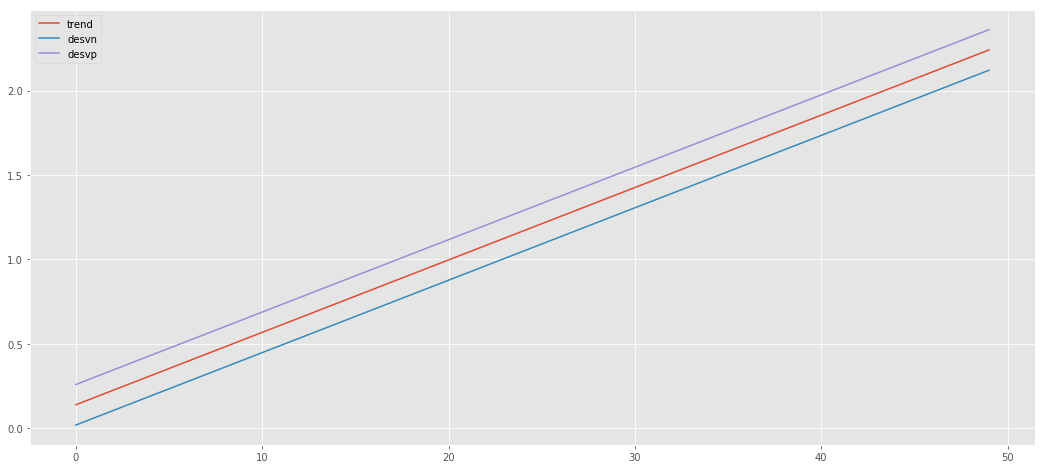

In [3]:
years=np.linspace(1,16)
df=pd.DataFrame(years)
df['trend']= years*.14
df['desvp']=df.trend+(.06*2)
df['desvn']=df.trend-(.06*2)
df[['trend','desvn','desvp']].plot()


<p>Podemos ver que la tendencia es positiva pues el proceso tiene una media positiva, y al ser una cte nuestra desviación tipica, nuestros valores estarían entre las rectas azules

---

<h1>Utilidad:</h1>
<p>Podemos ultilizarlo para:
<p>
<li>Limitar las pérdidas de nuestra inversión a un %</li>
<p>
<li>Poder comparar diferentes estrategias a igual riesgo
</li>

In [4]:
tickers = ['san', 'itx','tef']
tickers_name = {'san': 'SANTANDER', 'itx' : 'INDITEX', 'tef' : 'TELEFONICA'}
tickers_mc = [ticker + '.mc' for ticker in tickers]


<h1>Carga de Datos de San, Tef, Itx</h1>

<p>Vamos a calcular los diferentes datos para estas tres series

In [5]:
data = yf.download(tickers_mc, start='2008-01-01', end='2018-08-01', as_panel=False)
col_ticker = [col[:-3].lower() for  col in data.columns.levels[1]]
data.columns.set_levels(col_ticker, level=1, inplace=True)


[*********************100%***********************]  3 of 3 downloaded


In [6]:
# data2 = yf.download('san.mc', start='2008-01-01', end='2018-08-01', as_panel=False)

#  ESTA LINEA SE PUEDE BORRAR

In [7]:
def ajustado(df):
    df=df.copy()
    lista=['Open','High','Low']   
    for f in lista:
        df[f]=df[f]*df['Adj Close']/df['Close']
    df=df.drop('Close', axis=1)
    df=df.rename(columns = {'Adj Close': 'Close'} )
    return df


In [8]:
data = ajustado(data)
data = data.swaplevel(axis=1).sort_index(level=0, axis=1)

In [9]:
data['itx'].tail()

Close       High        Low       Open   Volume
Date                                                           
2018-07-26  28.639999  28.700001  28.340000  28.500000  1869408
2018-07-27  28.430000  28.700001  28.290001  28.530001  2051177
2018-07-30  28.200001  28.540001  28.129999  28.299999  1462561
2018-07-31  28.049999  28.280001  27.969999  28.090000  2537625
2018-08-01  27.980000  28.170000  27.879999  28.049999  2163168

# Media y varianza constante ?

<H2>Propiedades de la media y de la varianza</h2>

<p>Tanto la media como la varianza tienen unas propiedades que debemos saber.
<p>
<li> La media se ve afectada tanto por cambios en el origen como en la escala de la serie.</li>
<p><a href="https://es.wikipedia.org/wiki/Media_aritm%C3%A9tica#Propiedades"> - Propiedades de la media</a>

<p>
<li> La varianza sólo se ve afectada por los cambios de escala.
<p>
<p><a href="https://es.wikipedia.org/wiki/Varianza#Propiedades_de_la_varianza"> - Propiedades de la varianza</a>




In [10]:
f = data.swaplevel(axis=1)['Close']

In [11]:
f.head()

itx       san        tef
Date                                     
2008-01-02  3.379318  5.595079  21.731100
2008-01-03  3.300785  5.541409  21.296000
2008-01-04  3.077207  5.460856  21.167500
2008-01-07  2.975435  5.426378  21.948601
2008-01-08  2.938572  5.342005  22.314400

<H3>Gráficos de volatilidad corrida de las series</h3>

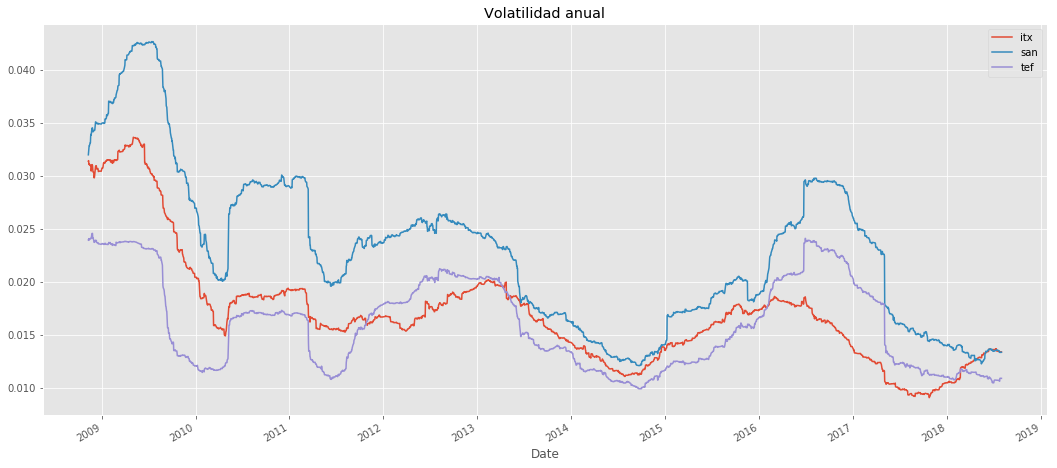

In [12]:
retornos = f.pct_change()
volatidad_anualizada = retornos.rolling(220).std()
volatidad_anualizada.plot(title='Volatilidad anual')

<p>Observamos en las tres series periodos de alta variación en la volatilidad combiandos con otros de volatilidad mas estable.

<H3>Gráficos de rendimiento anual de las series</h3>

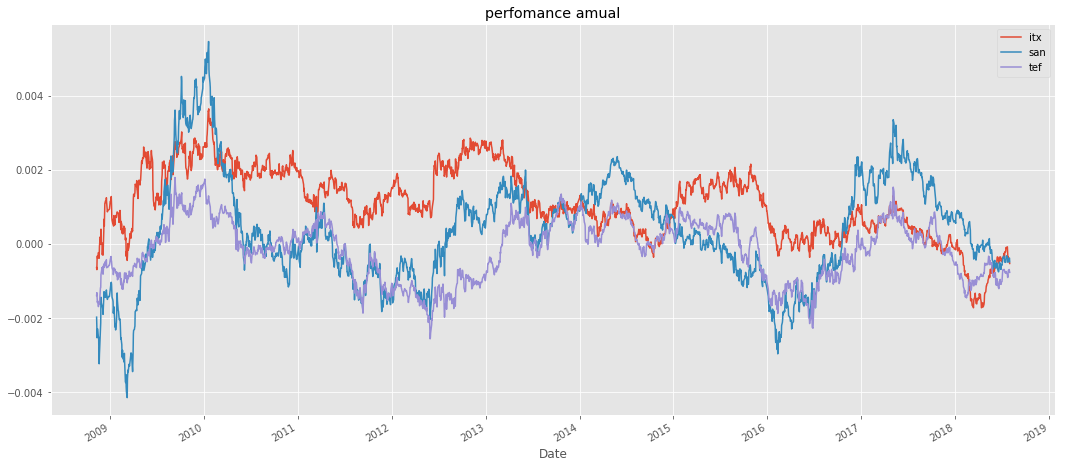

In [13]:
retornos_anulizados = retornos.rolling(220).mean()
retornos_anulizados.plot(title='perfomance amual')

<p>Aquí tb veo ciertos tramos de variabilidad y tramos mas tranquilos

<h3>Gráficos del Ratio Rentabilidad Anual / Volatilidad Anual de las series</h3>

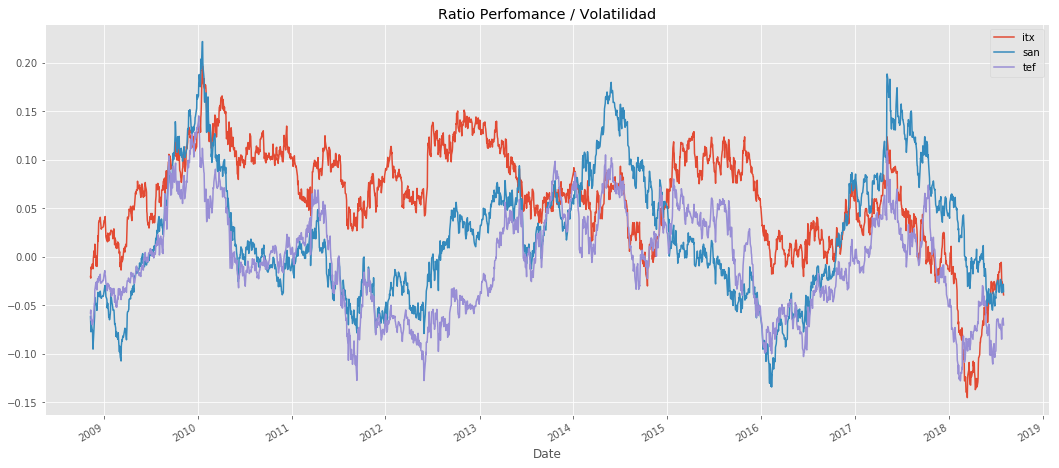

In [14]:
(retornos_anulizados/volatidad_anualizada).plot(title='Ratio Perfomance / Volatilidad')

<H3>Gráficos de la Matriz rendimiento - volatilidad</h3>

<p>Esto lo puedo convertir en una matriz rendimiento volatilidad</p>
<li>Baja volatilidad y buen rendiemiento ( vaca lechera - ordeñar)</li>
<li>Baja volatilidad y mal rendimiento  (Crecer en rendimiento)</li>
<li>Alta volatilidad y buen rendimiento  (Atento a la volatilidad)</li>
<li>Alta volatilidad y mal rendiemiento  ( No Operar )</li>


In [15]:
pepe = retornos_anulizados['itx']
#pepe3 = 

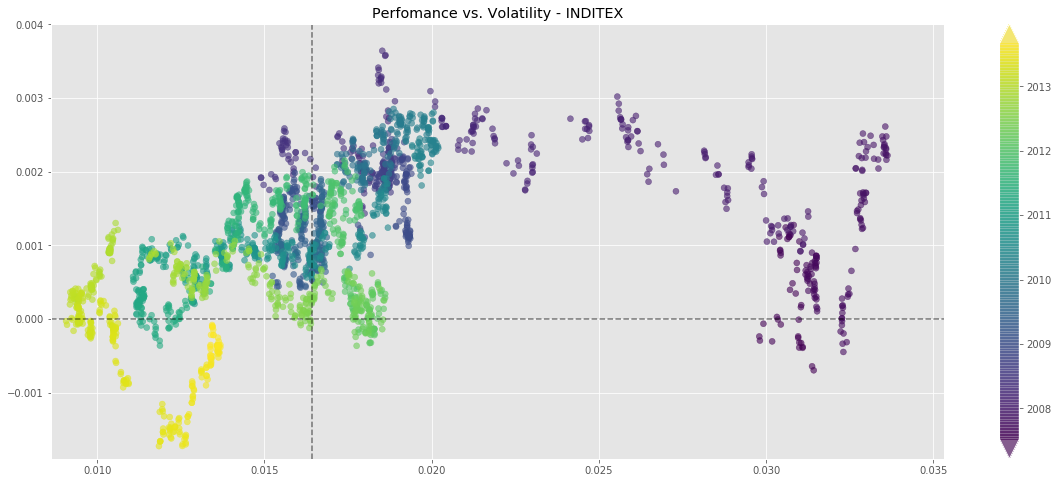

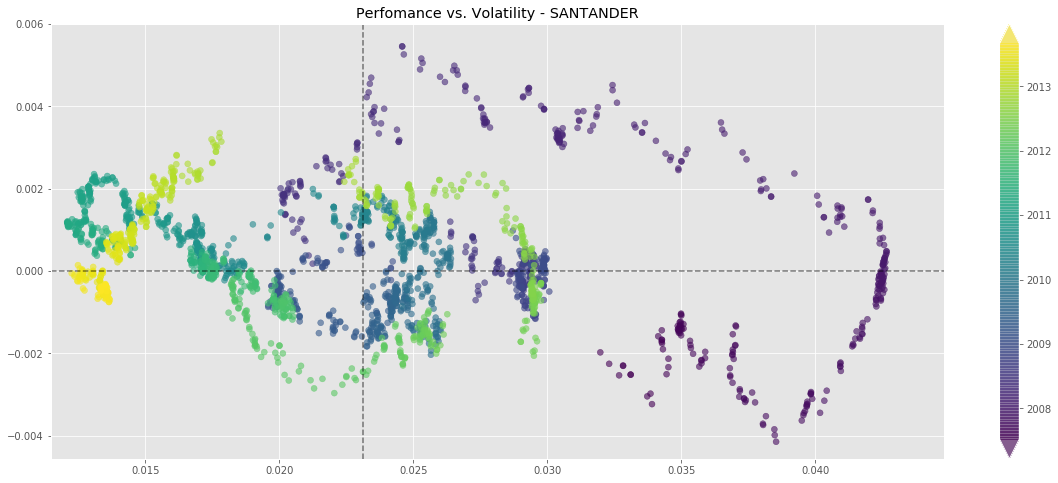

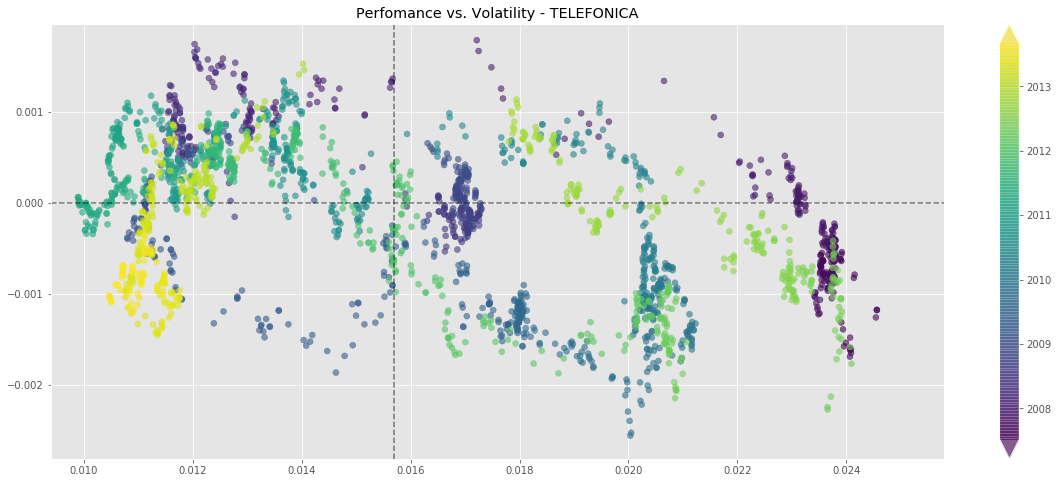

In [16]:
for valor in f.columns:
    vol = volatidad_anualizada[valor]
    ret = retornos_anulizados[valor]
    years=f.index.year.unique()
    fig = plt.figure(figsize=(20,8))
    scatter=plt.scatter(vol, ret, alpha = .6, c = pepe.index, cmap = 'viridis')
    
    plt.ylim(ret.min()*1.10,ret.max()*1.10)
    plt.xlim(vol.min()*0.95,vol.max()*1.05)
    plt.hlines(0,vol.min()*0.95,vol.max()*1.05,linestyle='dashed', alpha=0.5)
    plt.vlines(vol.median(),ret.min()*1.10,ret.max()*1.10,linestyle='dashed', alpha=0.5)
    
    cb = plt.colorbar(extend='both')
    cb.ax.set_yticklabels(years)
    plt.title('Perfomance vs. Volatility - {}'.format(tickers_name[valor]))
    plt.show()
    print('\n  \n')

---


## t -test

<p>Vemos un primer test para ver como de constante es nuestra media.
<p>Es el t-test y nos sirve para ver si una media es distinta de cero para una distribución dada.
<p>Si nuestra media es distinta de cero, al menos, podremos decir que ganamos dinero
<p>Enlazamos una definicion de 
<a href="https://en.wikipedia.org/wiki/Student%27s_t-test">t test</a>
<p> El cálculo es bastante sencillo:
<p> es el cociente entre la media del proceso y su desviación típica corregida por la raiz cuadrada del numero de sucesos


In [17]:
mean=f.pct_change().mean()
std=f.pct_change().std()
lon=len(f)
t_test=( mean - 0 )/(std/math.sqrt(lon))
t_test = pd.DataFrame(t_test, columns=['t-test'])
t_test

t-test
itx  2.689952
san  0.480856
tef -0.784507

## k - ratio


<p>Proviene de la Econometría. Nos permite validar si una media la podemos asmimilar a una constante.
<p>Es en realidad el ratio t-student del coeficiente de una regresión. 
<p>Nos indica a la vez que tenemos una media distinta de cero y que es de alguna manera constante a lo largo del experiemento.
<p>Cuanto mayor sea mucho mejor

In [18]:
g=f.resample('M').last()
g['time']=np.arange(1,len(g)+1)

In [19]:
import statsmodels.formula.api as smf
for valor in tickers:
    results = smf.ols('{} ~ time '.format(valor), data=g).fit()
    pendiente = results.params[1]
    error = results.bse[1]
    k_ratio = results.tvalues[1]
    rango = results.conf_int().iloc[1].values
    print ('\n{}: \n\n Pendiente = {:.3f} \n Error típico = {:.5f} \n K-ratio = {:.3f} \n Rango = {:.3f} - {:.3f}\n'
           .format(tickers_name[valor], pendiente, error, k_ratio, rango[0],rango[1]))




SANTANDER: 

 Pendiente = 0.006 
 Error típico = 0.00204 
 K-ratio = 3.033 
 Rango = 0.002 - 0.010


INDITEX: 

 Pendiente = 0.275 
 Error típico = 0.00654 
 K-ratio = 42.084 
 Rango = 0.262 - 0.288


TELEFONICA: 

 Pendiente = -0.079 
 Error típico = 0.00432 
 K-ratio = -18.371 
 Rango = -0.088 - -0.071



<p>Podemos ver que para cada regresión los valores del k-ratio varían notablemente.
<p>Por ejemplo en itx su valor es de 42 y nos indica que la media ha sido bastante constante en el tiempo, podemos decir que varia entre 0.262 y 0.288
<p>En este caso, al ser una constante el valor de la media de itx, podemos hacer predicciones sobre la volatilidad de la acción y ajustar bastante bien la prediccion del valor de la accion.
<p>Recuedo el gráfico rendimiento / volatilidad

# alpha y beta

<p>A la hora de construir distribuciones que puedan tener una media y varianza mas o menos constante, podemos sumar diferentes estrategias y obtener mejores resultados en nuestros test.
    
<p>Podemos definir una estrategia en funcion de otra

<p>Y_rdto = alpha + beta*X_rdto

<p>En función de ello podemos escoger diferentes estrategias, no voy a meterme en ello.
    
<p>En base a las propiedades de la media y de la varianza.
<p>La nueva Y_media = Y_media + alpha + beta*X
<p>La nueva varianza = Y_varianza * (beta * varianza X)
    
<p>El término "beta" es simplemente una medida de la sensibilidad de una acción al movimiento del mercado de valores en general o de una acción en particular. Si X gana un 5% y mi beta es de 2 el valor ganara un 10%
    
<p>El término alpha mide la capacidad de una accion para superar el índice de mercado o de una accion en particular.
    
<p>Si tengo un alpha de 0.02 quiere decir q todos los meses la estrategia Y gana un 2% mas que la X

In [20]:
g['itx_pct'] = g.itx.pct_change()
g['san_pct'] = g.san.pct_change()
g['tef_pct'] = g.tef.pct_change()

results = smf.ols('itx_pct ~ tef_pct ', data=g).fit()
print (results.summary())

                            OLS Regression Results                            
Dep. Variable:                itx_pct   R-squared:                       0.130
Model:                            OLS   Adj. R-squared:                  0.123
Method:                 Least Squares   F-statistic:                     18.61
Date:                Thu, 11 Oct 2018   Prob (F-statistic):           3.22e-05
Time:                        15:38:21   Log-Likelihood:                 181.46
No. Observations:                 127   AIC:                            -358.9
Df Residuals:                     125   BIC:                            -353.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0221      0.005      4.259      0.0

<p>Itx gana un 2% todos los meses, y solo se le suma un 37.28% de lo que gane o pierda tef.
<p>Si tef ganó un 5% es de esperar que en el mismo mes itx gane .02 + (.05 * .3728) = 0.03864
<p>Fijarse lo que supone ganar un 0.02 mensual

In [21]:
results = smf.ols('tef_pct ~ itx_pct ', data=g).fit()
print (results.summary())

                            OLS Regression Results                            
Dep. Variable:                tef_pct   R-squared:                       0.130
Model:                            OLS   Adj. R-squared:                  0.123
Method:                 Least Squares   F-statistic:                     18.61
Date:                Thu, 11 Oct 2018   Prob (F-statistic):           3.22e-05
Time:                        15:38:21   Log-Likelihood:                 171.57
No. Observations:                 127   AIC:                            -339.1
Df Residuals:                     125   BIC:                            -333.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0129      0.006     -2.192      0.0

<p>Este seria el ejemplo contrario. Telefónica pierde un -0,008 todos los meses y solo se le suma un .4136 de la variación de itx

# Riesgo de Cola

<p>En toda estrategia tenemos un cierto riesgo de eventos que sean mayor que tres veces la desviación tipica. Esto es lo que se llama Riesgo de Cola.

<p><a href="https://www.investopedia.com/terms/t/tailrisk.asp">Riesgo de Cola</a>

<p>Las estrategias suelen tener un exceso de "Kurtosis". Este esceso de Kurtosis implica riesgo de colas amplias y por tanto hay riesgo de que estas estrategias tengan rendimientos negativos superiores a los esperados


## kurtosis


<p>Es un momento de orden 4 que trata de ver si produce muchos valores extremos. Una distribución normal tiene un valor de 3.

<p>Si tiene un valor menor de 3 se la llama platicúrtica y cuanto menor sea tiende a convertir la distribución normal en una distribución Uniforme.

<p>Si tiene un valor mayor de 3 se llama leptocurtica y tendra un riesgo de cola alto
<p>Hay implementaciones que se les resta 3 para situar lo mismo en 0. Como es el gráfico de abajo, que son distintos valores de kurtosis para una misma varianza

![image](https://upload.wikimedia.org/wikipedia/commons/e/e6/Standard_symmetric_pdfs.png)

## Asimetría o Skewness

![image](https://www.kullabs.com/uploads/skewness1.jpg)

<p>Es un momento de orden 3 que trata de ver la distribución se concentra mas a la derecha o a la izquierda. Una distribución normal tiene un valor de 0 y está igualmente distribuida a la derecha y a la izquierda

<p>Si tiene un valor menor de 0 tiene inclinación negativa y suele tener cola negativa larga.
<p>Si tiene un valor mayor de 0 tiene una inclinación positiva y tendra un riesgo de cola negativa baja.

In [22]:
#retornos = g[].dropna()

In [23]:
g.columns

Index(['itx', 'san', 'tef', 'time', 'itx_pct', 'san_pct', 'tef_pct'], dtype='object')

<P>Una de las formas que podemos observar la kurtosis y la asimetría es con un boxplot o gráfico de caja.
<p>Un boxplot o gráfico de caja es un grafico que delimita los cuartiles Q1 y Q3 y tambien delimita la mediana dentro de la caja. 
<p>Nos muestra unos outliers que nos indican la posibilidad de kurtosis dentro de la distribución 

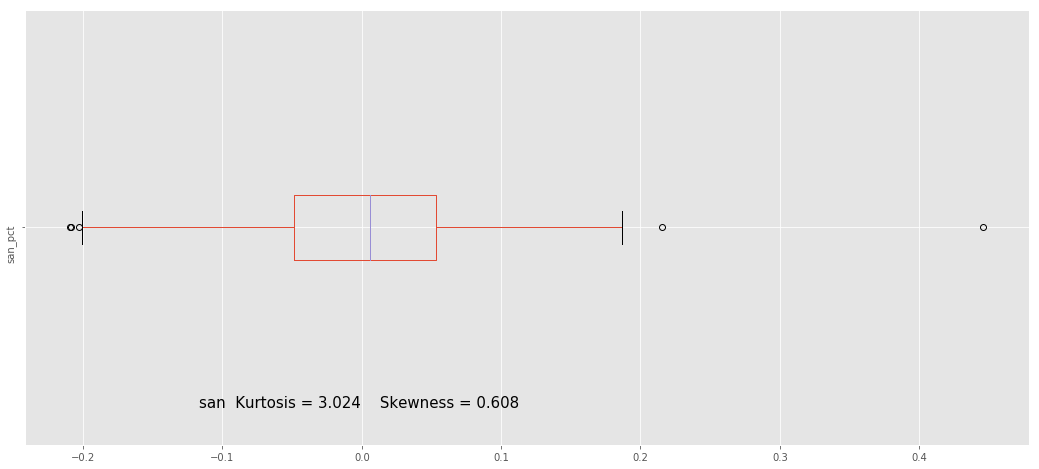

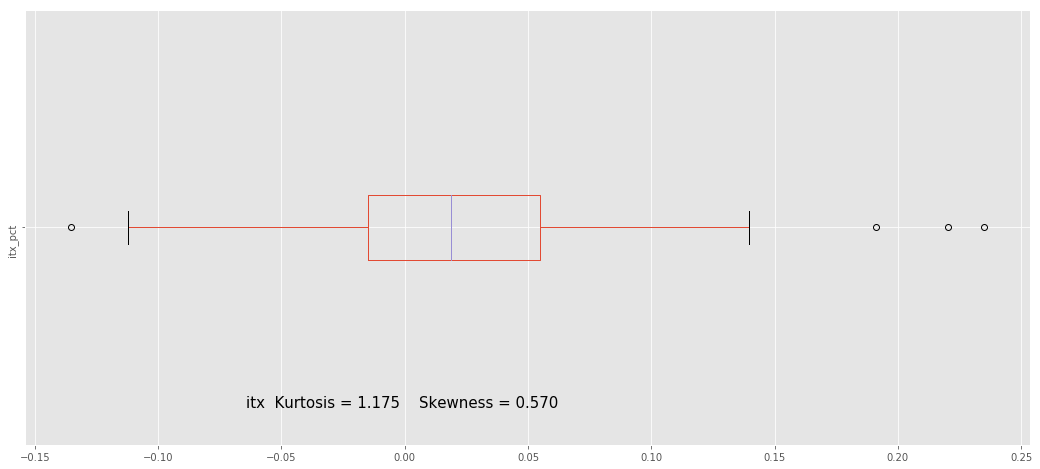

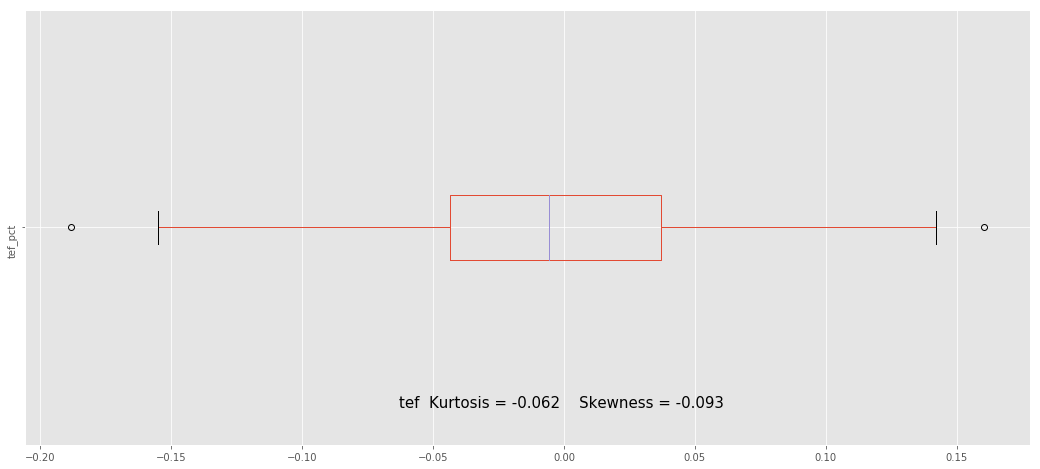

In [24]:
for n in tickers:
    values=g['{}_pct'.format(n)]
    
    values2=pd.DataFrame(values)
    values2.boxplot(vert=False,rot=90)
    plt.text(0, 0.5,'{}  Kurtosis = {:.3f}    Skewness = {:.3f} \n\n'.format(n,values2.kurt()[0],values2.skew()[0]),
            verticalalignment='bottom', horizontalalignment='center',color='k',fontsize=15)
    plt.show()
    del values2

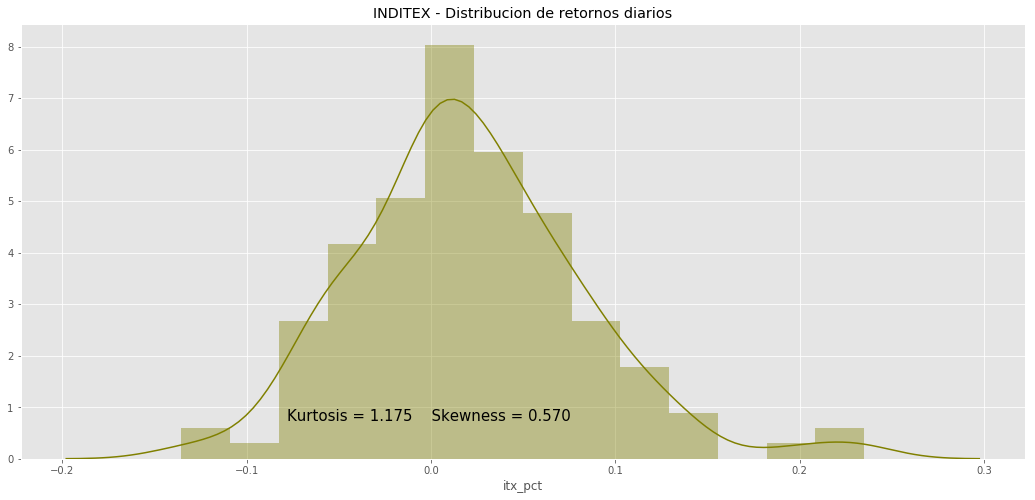

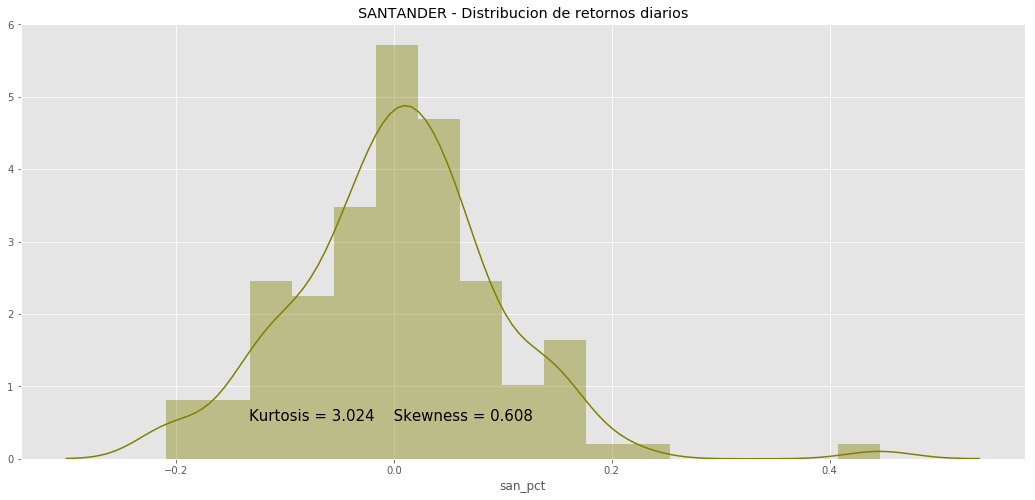

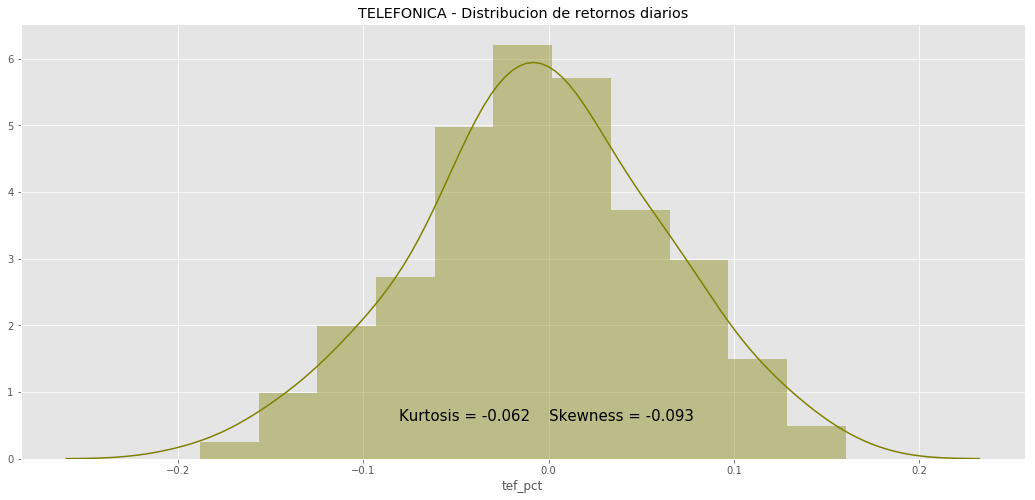

In [25]:
for col in [col for col in g.columns if col[-3:]=='pct']:
    rets = g[col].dropna()
    sns.distplot(rets, color='olive')
    ticker_name = tickers_name[col[:3]]
    plt.title('{} - Distribucion de retornos diarios'.format(ticker_name))
    
    kurtosis = rets.kurt()
    skew = rets.skew()
    plt.text(0, 0,'Kurtosis = {:.3f}    Skewness = {:.3f} \n\n'.format(kurtosis, skew),
            verticalalignment='bottom', horizontalalignment='center',         color='k', fontsize=15)
    plt.show()

<p><b>objetivo tener una kurtosis negativa y skewness leve positiva</b></h2>

# cálculo del var95

<p>Si el trading fuese la F1 tendríamos un riesgo de romper un motor y no acabar la carrera. Lo que hacen los diferentes equipos es testar dichos motores para que alcancen una total fiabilidad en 7 carreras. Es decir que no se rompan a un 99% de posibilidades.
<p>Aún así, parece que algunos motores se rompen.
<p>El trading tiene el mismo problema, si nos cargamos una cuenta, ya no podemos tradear más y por tanto hacemos game over. La forma de no caer en controlando el riesgo de las operaciones. Por lo general se establece como la posibilidad de no perder mas de un 10% en un mes al 95% de posibilidad. Pues hay un riesgo llamado de cola o de encontrarnos con el peor de los sucesos.
<p>Por tanto, vamos a intentar maximizar el valor del var95 y evitar todos los riesgos derivados de un posible cisne negro.
<p>Hay varias maneras de poder calcular el var95 de una serie

In [26]:
#calculamos los pct

for n in tickers:

    f['{}_pct_diario'.format(n)]=f['{}'.format(n)].pct_change()
    f['{}_pct_20dias'.format(n)]=f['{}'.format(n)].pct_change(20)
    f['{}_pct_60dias'.format(n)]=f['{}'.format(n)].pct_change(60)
    f['{}_pct_120dias'.format(n)]=f['{}'.format(n)].pct_change(120)
    f['{}_pct_220dias'.format(n)]=f['{}'.format(n)].pct_change(220)

    
    f['{}_pct_diario'.format(n)]=f['{}_pct_diario'.format(n)].dropna()
    f['{}_pct_20dias'.format(n)]=f['{}_pct_20dias'.format(n)].dropna()
    f['{}_pct_60dias'.format(n)]=f['{}_pct_60dias'.format(n)].dropna()
    f['{}_pct_120dias'.format(n)]=f['{}_pct_120dias'.format(n)].dropna()
    f['{}_pct_220dias'.format(n)]=f['{}_pct_220dias'.format(n)].dropna()

    
f.tail()

itx       san    tef  san_pct_diario  san_pct_20dias  \
Date                                                                     
2018-07-26  28.639999  4.699728  7.629        0.009964        0.041539   
2018-07-27  28.430000  4.753000  7.666        0.011335        0.049216   
2018-07-30  28.200001  4.765500  7.710        0.002630        0.058777   
2018-07-31  28.049999  4.819500  7.691        0.011331        0.059167   
2018-08-01  27.980000  4.753000  7.661       -0.013798        0.037468   

            san_pct_60dias  san_pct_120dias  san_pct_220dias  itx_pct_diario  \
Date                                                                           
2018-07-26       -0.107196        -0.166296        -0.115131        0.008806   
2018-07-27       -0.103795        -0.131447        -0.115223       -0.007332   
2018-07-30       -0.102106        -0.147549        -0.101623       -0.008090   
2018-07-31       -0.092606        -0.114560        -0.097741       -0.005319   
2018-08-01       -0.113523        -0.111329        -0.118029       -0.002496   

            itx_pct_20dias  itx_pct_60dias  itx_pct_120dias  itx_pct_220dias  \
Date                                                                           
2018-07-26       -0.028164        0.090217         0.061988        -0.092095   
2018-07-27       -0.028366        0.068797         0.083496        -0.103489   
2018-07-30       -0.036556        0.059354         0.069909        -0.118914   
2018-07-31       -0.051724        0.047815         0.088220        -0.120638   
2018-08-01       -0.057278        0.032472         0.087583        -0.126858   

            tef_pct_diario  tef_pct_20dias  tef_pct_60dias  tef_pct_120dias  \
Date                                                                          
2018-07-26        0.035002        0.047077       -0.088204        -0.033692   
2018-07-27        0.004850        0.053167       -0.077053        -0.003510   
2018-07-30        0.005740        0.063889       -0.069178        -0.022194   
2018-07-31       -0.002464        0.038623       -0.076378         0.004572   
2018-08-01       -0.003901        0.009620       -0.080974         0.018479   

            tef_pct_220dias  
Date                         
2018-07-26        -0.164128  
2018-07-27        -0.156192  
2018-07-30        -0.152002  
2018-07-31        -0.160280  
2018-08-01        -0.166195

In [27]:
f.head()

itx       san        tef  san_pct_diario  san_pct_20dias  \
Date                                                                        
2008-01-02  3.379318  5.595079  21.731100             NaN             NaN   
2008-01-03  3.300785  5.541409  21.296000       -0.009592             NaN   
2008-01-04  3.077207  5.460856  21.167500       -0.014537             NaN   
2008-01-07  2.975435  5.426378  21.948601       -0.006314             NaN   
2008-01-08  2.938572  5.342005  22.314400       -0.015549             NaN   

            san_pct_60dias  san_pct_120dias  san_pct_220dias  itx_pct_diario  \
Date                                                                           
2008-01-02             NaN              NaN              NaN             NaN   
2008-01-03             NaN              NaN              NaN       -0.023239   
2008-01-04             NaN              NaN              NaN       -0.067735   
2008-01-07             NaN              NaN              NaN       -0.033073   
2008-01-08             NaN              NaN              NaN       -0.012389   

            itx_pct_20dias  itx_pct_60dias  itx_pct_120dias  itx_pct_220dias  \
Date                                                                           
2008-01-02             NaN             NaN              NaN              NaN   
2008-01-03             NaN             NaN              NaN              NaN   
2008-01-04             NaN             NaN              NaN              NaN   
2008-01-07             NaN             NaN              NaN              NaN   
2008-01-08             NaN             NaN              NaN              NaN   

            tef_pct_diario  tef_pct_20dias  tef_pct_60dias  tef_pct_120dias  \
Date                                                                          
2008-01-02             NaN             NaN             NaN              NaN   
2008-01-03       -0.020022             NaN             NaN              NaN   
2008-01-04       -0.006034             NaN             NaN              NaN   
2008-01-07        0.036901             NaN             NaN              NaN   
2008-01-08        0.016666             NaN             NaN              NaN   

            tef_pct_220dias  
Date                         
2008-01-02              NaN  
2008-01-03              NaN  
2008-01-04              NaN  
2008-01-07              NaN  
2008-01-08              NaN

## Cálculo estadístico del VaR

<p>Es cuando tenemos una fotografía de nuestra dstribución, como el desempeño mensual de nuestros rendimientos. El principal problema es el número de datos, mientras que su cálculo es muy sencillo.
<p>Para ello sólo necesitamos saber el nivel de confianza. Pues de la serie obtenemos los datos para el cáculo del var.
<p>Hay que tener en cuenta un número mínimo de observaciones para dar una buena validez a los datos obtenidos.
<p>Una data posible es en formato anual:
    

In [28]:
def var_estadistico(price_serie, ci=0.95, time=None, verbose=True):
    '''
    Calcula el var para una serie de precios a un coefiente de confianza dado,
    pudiendo remuestrear la serie a una periodicidad superior.
    '''
    from scipy.stats import norm
    from numpy import mean, std
    if  time!=None:
        price_serie = price_serie.resample(time).last()
    retornos = price_serie.pct_change().dropna()
    
    var = -norm.ppf(1 - ci,mean(retornos), std(retornos)) #asume la normalidad de la distribución
    if verbose:
        print ('El VaR {} para los retornos analizados con un frequencia {} es del {}%'.format(int(ci*100), time, round(var*100,2)))
    return var

<p>Estos son los datos semestrales de Santander

In [29]:
print (f.san.resample('2Q').last().T)

Date
2008-03-31    4.895971
2008-09-30    4.218051
2009-03-31    2.323590
2009-09-30    5.313993
2010-03-31    4.869232
2010-09-30    4.790798
2011-03-31    4.393644
2011-09-30    3.496314
2012-03-31    3.380463
2012-09-30    3.665304
2013-03-31    3.482422
2013-09-30    4.246727
2014-03-31    5.107339
2014-09-30    5.831522
2015-03-31    5.754723
2015-09-30    4.008386
2016-03-31    3.349194
2016-09-30    3.502637
2017-03-31    5.211031
2017-09-30    5.608389
2018-03-31    5.165048
2018-09-30    4.753000
Name: san, dtype: float64


In [30]:
var = var_estadistico(f.san, ci=0.95, time='2Q')

El VaR 95 para los retornos analizados con un frequencia 2Q es del 51.53%


In [31]:
print (f.san.resample('A').last().T)

Date
2008-12-31    2.961322
2009-12-31    5.645009
2010-12-31    4.129840
2011-12-31    3.366684
2012-12-31    3.957815
2013-12-31    4.692185
2014-12-31    5.481115
2015-12-31    3.889623
2016-12-31    4.451128
2017-12-31    5.239249
2018-12-31    4.753000
Freq: A-DEC, Name: san, dtype: float64


In [32]:
ci = 0.95
var = var_estadistico(f.san, ci=ci, time='Y', verbose=False)
print ('El VaR{} anual para los retornos analizados es del {}%'.format(int(ci*100), round(var*100,2)))

El VaR95 anual para los retornos analizados es del 44.88%


In [33]:
def var95m(valuados,graph=True,box=True,imp=True,time='M'):
    #pasamos las cotizaciones a mensual
    memo=valuados.resample(time).last()
    #ploteamos
    #calculamos el % cambio
    mempct=memo.pct_change()
    #calculamos el t_test
    #print "t test mensual\n\n",mempct.mean()/(mempct.std()/math.sqrt(len(mempct)))
    #calculamos el var95
    #print "var95 \n\n",mempct.quantile(.05)
    #mempct.plot()
    t_test=(mempct.mean().values[0]/(mempct.std().values[0]/math.sqrt(len(mempct))))
    
    agg_measures = {
        'avg': mempct.mean().values[0],
        'std': mempct.std().values[0],
        'var': mempct.var().values[0],
        'med': mempct.median().values[0],
        '01p': mempct.quantile(.01).values[0],
        '05p': mempct.quantile(.05).values[0],
        '50p': mempct.quantile(.50).values[0],
        '95p': mempct.quantile(.95).values[0],
        'val': mempct.quantile(.95).values[0] / mempct.quantile(.05).values[0],
        'skw': mempct.skew().values[0],
        'kur': mempct.kurtosis().values[0],
        'T-test': t_test
    }
    
    if graph==True :
        plt.close()
        memo.plot();
        mempct.plot()
        #mempct.hist(bins=40,normed=True,alpha=0.7)
        #x=np.linspace(agg_measures['avg']-3*agg_measures['std'],agg_measures['avg']+3*agg_measures['std'],100)
        #plt.plot(x,mlab.normpdf(x,agg_measures['avg'],agg_measures['std']),'b')
        plt.show()
    if box==True:   
        mempct2=pd.DataFrame(mempct)
        mempct2.boxplot(vert=False,rot=90)
        plt.show()
        del mempct2
    if imp==True:
        for n in sorted(agg_measures.keys()):
            koko=" el valor de {} es : {:2.5} ".format(n,agg_measures[n])
            print (koko)
       
    
    return agg_measures 

In [34]:
def var95m2(valuados,graph=True,box=True,imp=True,time='M'):
    #pasamos las cotizaciones a mensual
    memo=valuados.resample(time).last()
    #ploteamos
    #calculamos el % cambio
    mempct=memo.pct_change()
    #calculamos el t_test
    #print "t test mensual\n\n",mempct.mean()/(mempct.std()/math.sqrt(len(mempct)))
    #calculamos el var95
    #print "var95 \n\n",mempct.quantile(.05)
    #mempct.plot()
    t_test=(mempct.mean()/(mempct.std()/math.sqrt(len(mempct))))
    
    agg_measures = {
        'avg': mempct.mean(),
        'std': mempct.std(),
        'var': mempct.var(),
        'med': mempct.median(),
        '01p': mempct.quantile(.01),
        '05p': mempct.quantile(.05),
        '50p': mempct.quantile(.50),
        '95p': mempct.quantile(.95),
        'val': mempct.quantile(.95)/mempct.quantile(.05),
        'skw': mempct.skew(),
        'kur': mempct.kurtosis(),
        'T-test': t_test
    }
    
    if graph==True :
        plt.close()
        memo.plot()
        plt.show()
        mempct.plot()
        #mempct.hist(bins=40,normed=True,alpha=0.7)
        #x=np.linspace(agg_measures['avg']-3*agg_measures['std'],agg_measures['avg']+3*agg_measures['std'],100)
        #plt.plot(x,mlab.normpdf(x,agg_measures['avg'],agg_measures['std']),'b')
        plt.show()
    if box==True:   
        mempct2=pd.DataFrame(mempct)
        mempct2.boxplot(vert=False,rot=90)
        plt.show()
        del mempct2
    if imp==True:
        for n in sorted(agg_measures.keys()):
            koko=" el valor de {} es : {:2.5} ".format(n,agg_measures[n])
            print (koko)
       
    
    return agg_measures 

<p>Quiero resaltar la importancia que tiene que al aumentar el periodo se reduzca el var.
<p>Por ejemplo, que el var95 semestral sea mayor que cero implica que nuestro sistema o serie no tiene drawdon mayor de seis meses. Nos indicaría una gran performace.

<P><b>Var95 de ITX mensual</b>

<p>Podemos ver diferentes ejemplos de cálculo del var estadístico

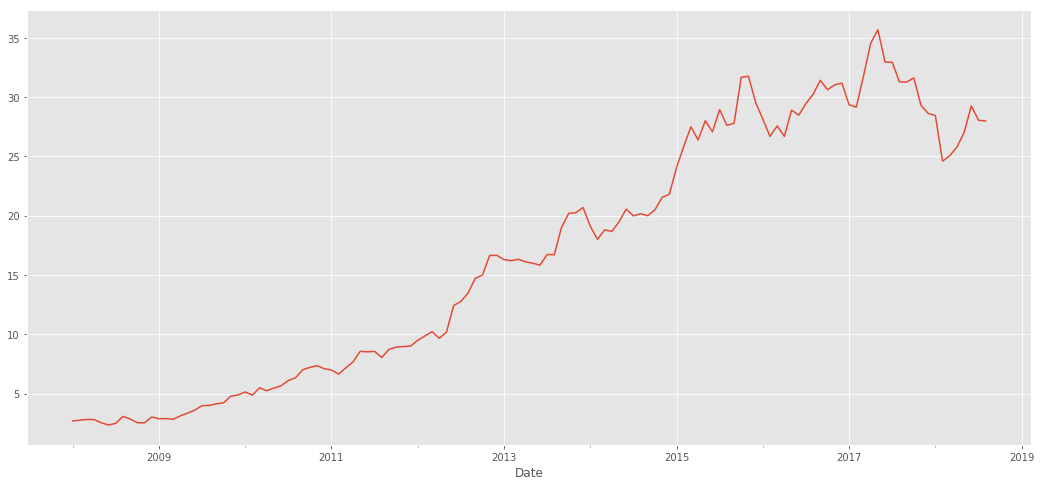

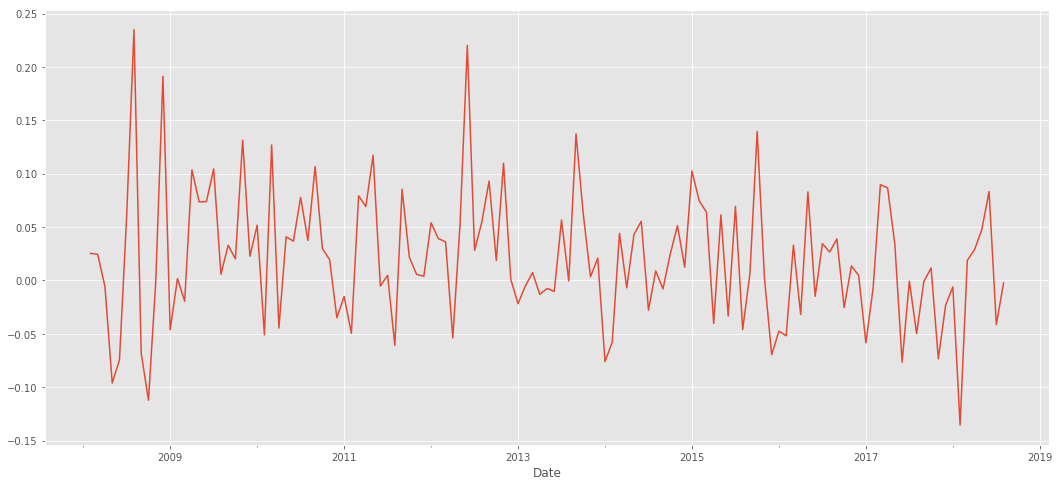

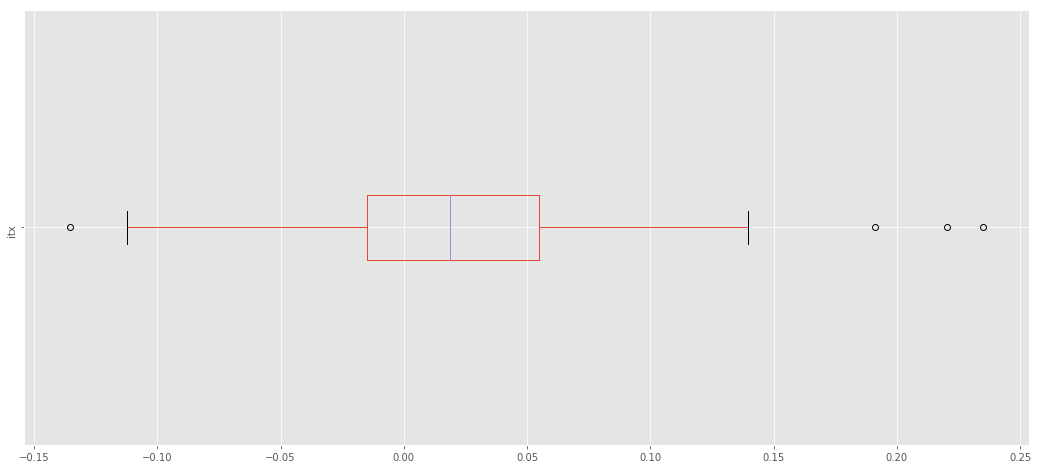

 el valor de 01p es : -0.10797 
 el valor de 05p es : -0.072238 
 el valor de 50p es : 0.018731 
 el valor de 95p es : 0.12399 
 el valor de T-test es : 3.7155 
 el valor de avg es : 0.020488 
 el valor de kur es : 1.175 
 el valor de med es : 0.018731 
 el valor de skw es : 0.57005 
 el valor de std es : 0.062387 
 el valor de val es : -1.7164 
 el valor de var es : 0.0038921 


In [35]:
nada=var95m2(f['itx'])

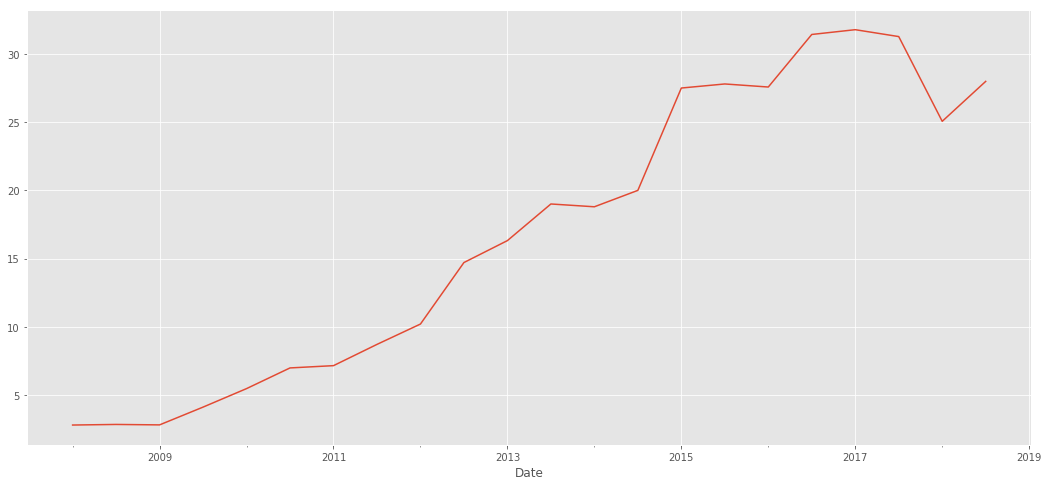

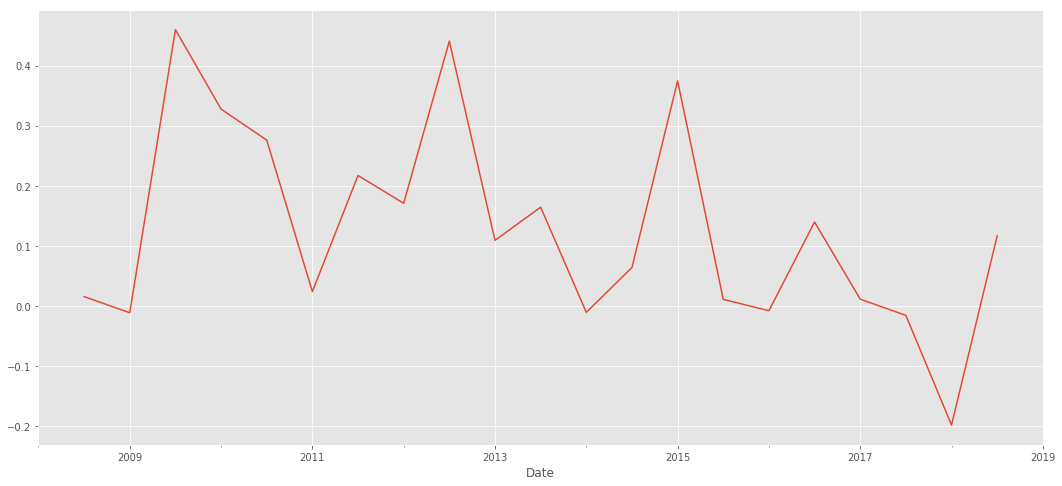

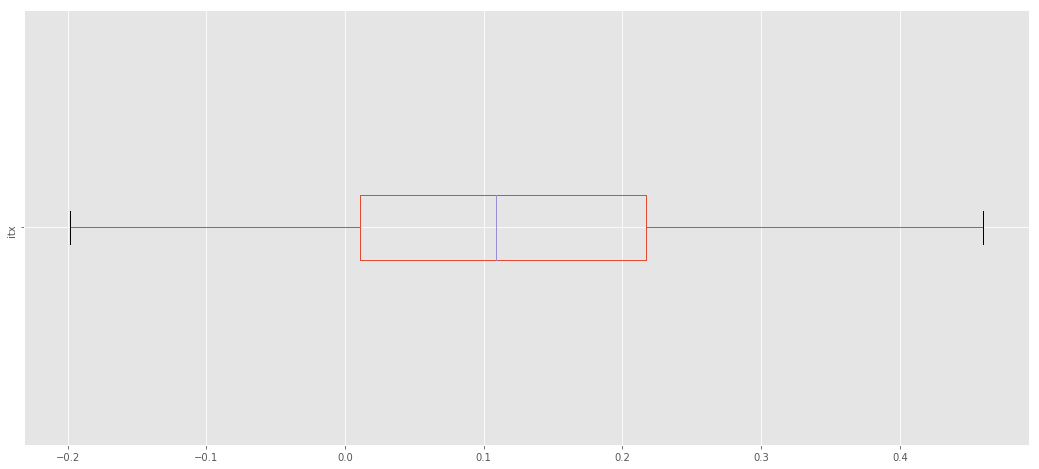

 el valor de 01p es : -0.16194 
 el valor de 05p es : -0.015873 
 el valor de 50p es : 0.10909 
 el valor de 95p es : 0.44087 
 el valor de T-test es : 3.5055 
 el valor de avg es : 0.12748 
 el valor de kur es : -0.22201 
 el valor de med es : 0.10909 
 el valor de skw es : 0.48354 
 el valor de std es : 0.17057 
 el valor de val es : -27.774 
 el valor de var es : 0.029096 


In [36]:
nada=var95m2(f['itx'],time='2Q')

<p>Está claro que el tiempo en drawdown es mayor que un semestre. Deberemos valorar esto a la hora de poder seleccionar los diferentes sistemas o series.

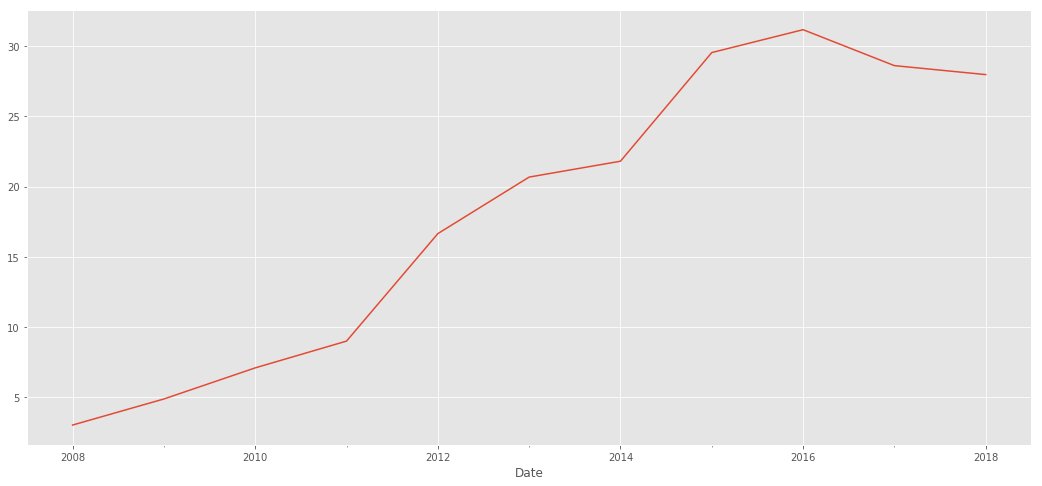

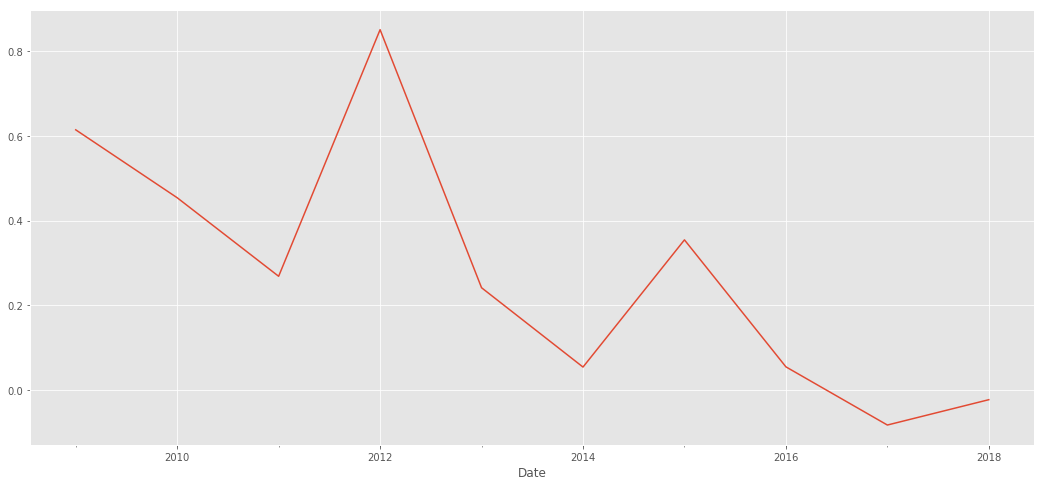

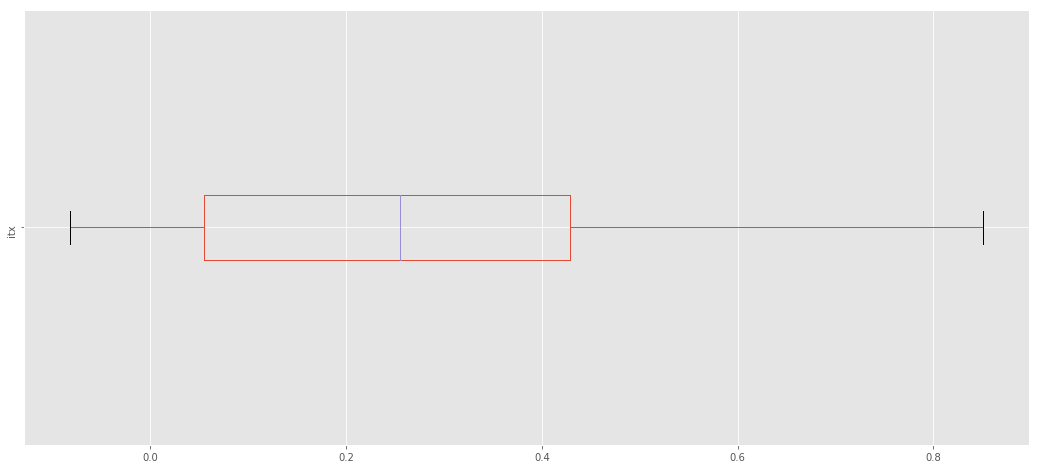

 el valor de 01p es : -0.076723 
 el valor de 05p es : -0.0552 
 el valor de 50p es : 0.25531 
 el valor de 95p es : 0.74426 
 el valor de T-test es : 3.1061 
 el valor de avg es : 0.27898 
 el valor de kur es : -0.16384 
 el valor de med es : 0.25531 
 el valor de skw es : 0.70032 
 el valor de std es : 0.29789 
 el valor de val es : -13.483 
 el valor de var es : 0.088737 


In [37]:
nada=var95m2(f['itx'],time='A')

<p>Está claro que el tiempo en drawdown es mayor que un semestre. Deberemos valorar esto a la hora de poder seleccionar los diferentes sistemas o series.

## calcula los diferentes var

In [38]:
#borrar
#f['itx'].tail()

<p>Podemos calcular los diferentes var estadisticos y ver como evoluciona

<h3>Tabla del var estadisitico por serie y frecuencia</h3>

In [39]:
var95a={}
tiempo=['M','2M','Q','2Q','A']
for n in tickers:
    for j in tiempo:
        clave="{}".format(n)
        tempo="{}".format(j)
        clatempo=clave+tempo
        var95a[clatempo]=dict(var95m(f[[clave]],time=tempo,graph=False,box=False,imp=False))

#var95est
var95esa=pd.DataFrame(var95a)
np.round(var95esa.T,3)


01p    05p    50p    95p  T-test    avg    kur    med    skw    std  \
sanM  -0.207 -0.142  0.006  0.149   0.563  0.005  3.024  0.006  0.608  0.095   
san2M -0.273 -0.220  0.019  0.205   0.602  0.011  1.946  0.019  0.588  0.146   
sanQ  -0.273 -0.215 -0.008  0.271   0.475  0.013  6.172 -0.008  1.746  0.179   
san2Q -0.420 -0.303 -0.033  0.488   0.547  0.040  8.419 -0.033  2.455  0.346   
sanA  -0.288 -0.280  0.156  0.582   0.881  0.092  2.993  0.156  1.374  0.347   
itxM  -0.108 -0.072  0.019  0.124   3.715  0.020  1.175  0.019  0.570  0.062   
itx2M -0.116 -0.098  0.035  0.180   3.926  0.041 -0.357  0.035  0.236  0.083   
itxQ  -0.150 -0.091  0.035  0.237   3.666  0.062 -0.756  0.035  0.116  0.111   
itx2Q -0.162 -0.016  0.109  0.441   3.505  0.127 -0.222  0.109  0.484  0.171   
itxA  -0.077 -0.055  0.255  0.744   3.106  0.279 -0.164  0.255  0.700  0.298   
tefM  -0.154 -0.118 -0.006  0.108  -0.833 -0.005 -0.062 -0.006 -0.093  0.067   
tef2M -0.241 -0.128 -0.006  0.124  -1.033 -0.011  1.010 -0.006 -0.381  0.084   
tefQ  -0.154 -0.144 -0.028  0.170  -1.116 -0.016 -0.095 -0.028  0.641  0.093   
tef2Q -0.183 -0.183 -0.070  0.163  -1.327 -0.033  0.250 -0.070  0.843  0.118   
tefA  -0.236 -0.226 -0.105  0.200  -1.273 -0.059  0.131 -0.105  0.964  0.153   

          val    var  
sanM   -1.052  0.009  
san2M  -0.932  0.021  
sanQ   -1.260  0.032  
san2Q  -1.607  0.120  
sanA   -2.075  0.120  
itxM   -1.716  0.004  
itx2M  -1.842  0.007  
itxQ   -2.611  0.012  
itx2Q -27.774  0.029  
itxA  -13.483  0.089  
tefM   -0.915  0.005  
tef2M  -0.965  0.007  
tefQ   -1.176  0.009  
tef2Q  -0.890  0.014  
tefA   -0.884  0.023

<p>En la tabla anterior podemos ver para itx encontramos t-test positivos. También podemos ver que en ningun timeframe encontramos un var95 psoitivo, por tanto tenemos drawdown de mas de 1 año en los tres acciones.

## Calculo del var histórico
        

<p>Nos permite calcular el var de manera mucho más precisa, pues tenemos muchos más datos, pero tambien los necesitamos.
<p>Permite tambien un mejor cálculo de la asimetría y de la kurtosis de la distribución, en el cálculo estadísitico nos faltaría datos para poder dar validez a estos cáĺculos

<h3>Gráficos de las diferentes series y frecuencias</h3>

In [40]:
def calculate_aggregate(values, graph=True,box=True):
    t_test=(values.mean()/(values.std()/math.sqrt(len(values))))
    agg_measures = {
        'avg': np.round(values.mean(),3),
        'std': values.std(),
        'var': values.var(),
        'val': values.quantile(.95)/values.quantile(.05),
        '05p': values.quantile(.05),
        '50p': values.quantile(.50),
        '95p': values.quantile(.95),
        '01p': values.quantile(.01),
        'skw': values.skew(),
        'kur': values.kurtosis(),
        'T-test': t_test
    }
    if graph==True :
        values.hist(bins=40,normed=True,alpha=0.7)
        x=np.linspace(agg_measures['avg']-3*agg_measures['std'],agg_measures['avg']+3*agg_measures['std'],100)
        plt.plot(x,mlab.normpdf(x,agg_measures['avg'],agg_measures['std']),'b')
        plt.show()
    if box==True:   
        values2=pd.DataFrame(values)
        values2.boxplot(vert=False,rot=90)
        plt.show()
        del values2
    
    for n in sorted(agg_measures.keys()):
        koko=" el valor de {} es : {:2.5} ".format(n,agg_measures[n])
        print (koko)
       
    
    return agg_measures 

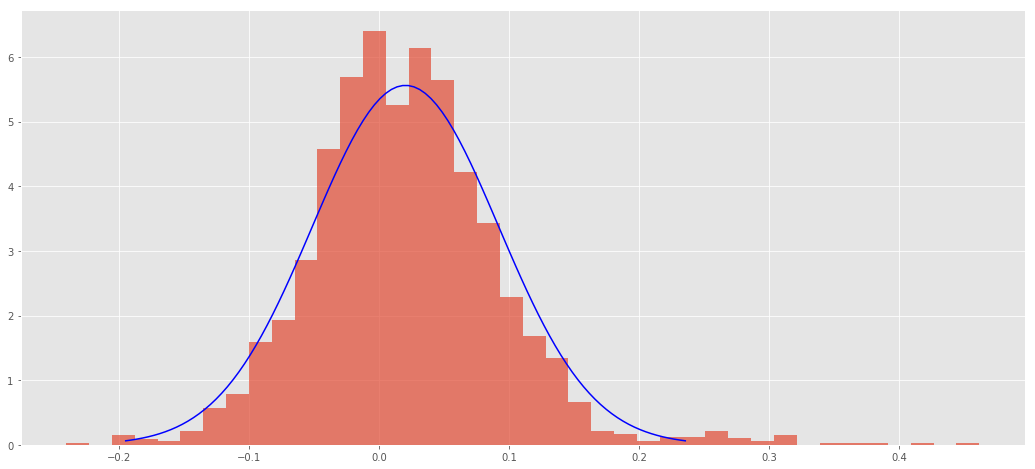

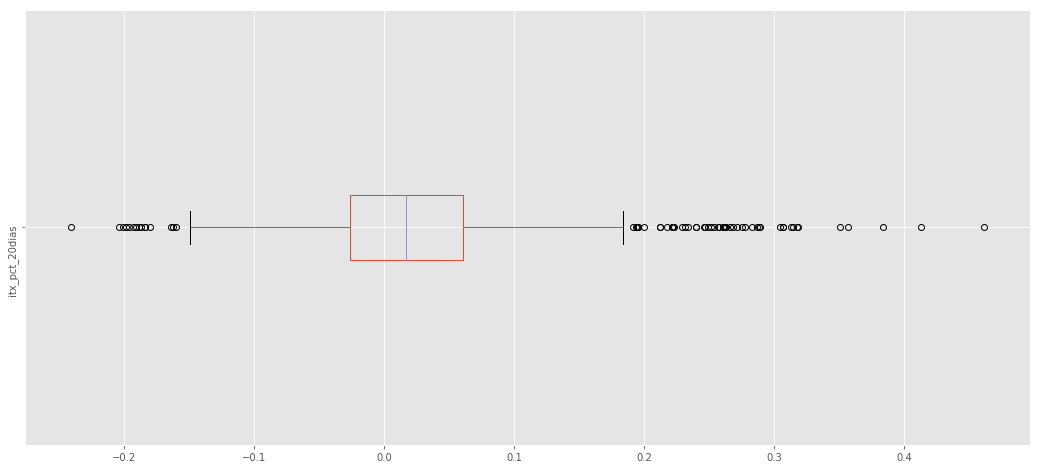

 el valor de 01p es : -0.13201 
 el valor de 05p es : -0.088743 
 el valor de 50p es : 0.016995 
 el valor de 95p es : 0.13449 
 el valor de T-test es : 14.418 
 el valor de avg es : 0.02 
 el valor de kur es : 2.4948 
 el valor de skw es : 0.67182 
 el valor de std es : 0.071742 
 el valor de val es : -1.5155 
 el valor de var es : 0.005147 


In [41]:
pepe=calculate_aggregate(f['itx_pct_20dias'])

<P>Podemos obtener para cada serie los distintos perfiles de cada serie y frecuencia, de manera gráfica

serie = san_pct_diario


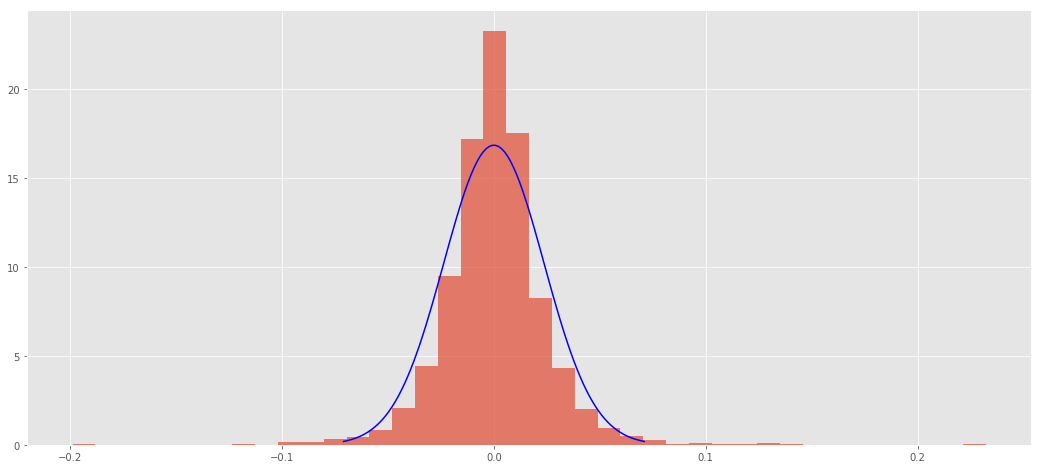

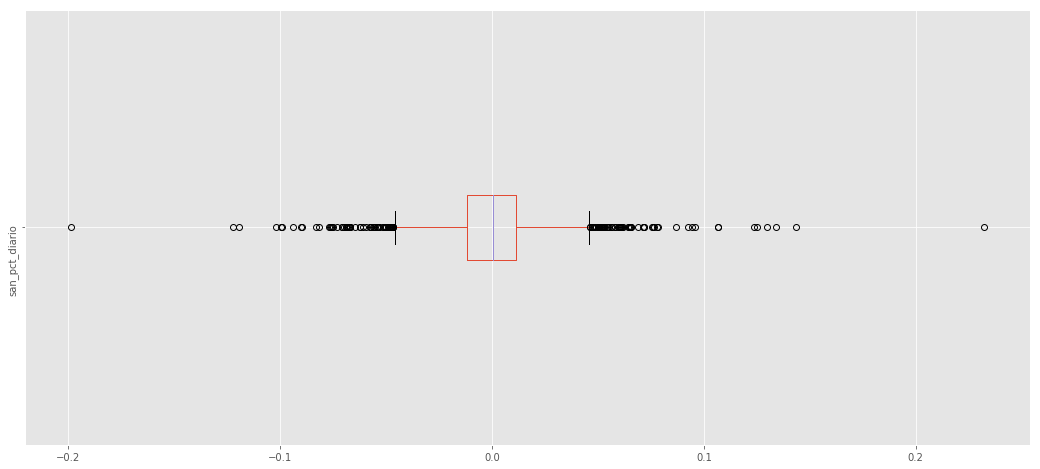

 el valor de 01p es : -0.066831 
 el valor de 05p es : -0.035019 
 el valor de 50p es : 0.00034423 
 el valor de 95p es : 0.036545 
 el valor de T-test es : 0.48086 
 el valor de avg es : 0.0 
 el valor de kur es : 8.5484 
 el valor de skw es : 0.31354 
 el valor de std es : 0.023656 
 el valor de val es : -1.0436 
 el valor de var es : 0.0005596 
serie = san_pct_20dias


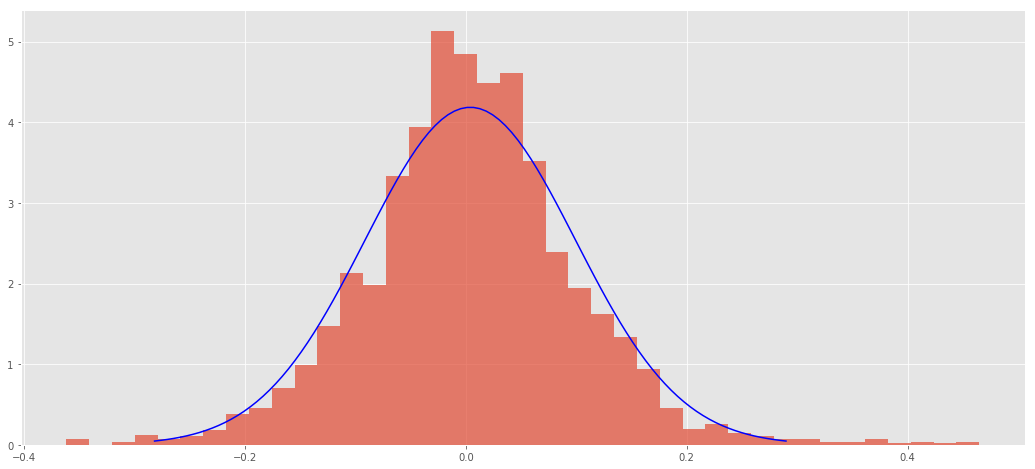

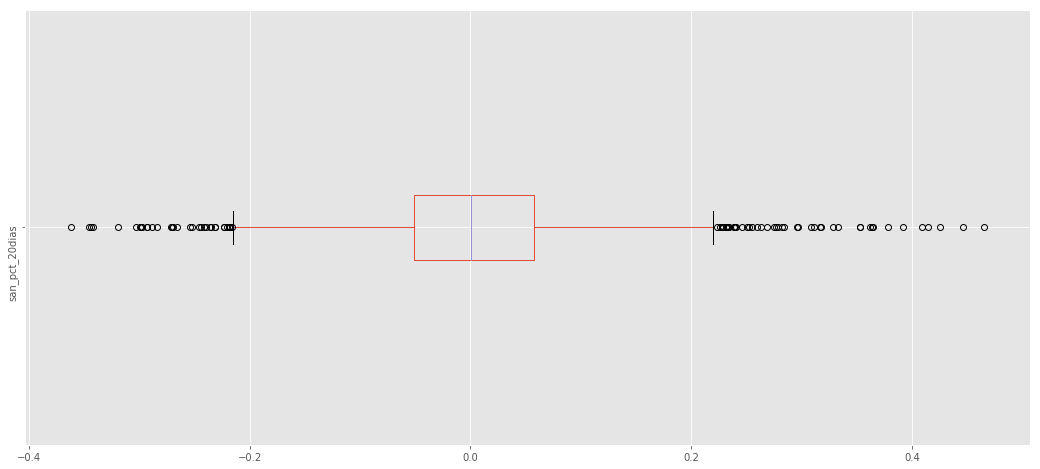

 el valor de 01p es : -0.22457 
 el valor de 05p es : -0.14797 
 el valor de 50p es : 0.00088851 
 el valor de 95p es : 0.15595 
 el valor de T-test es : 2.2211 
 el valor de avg es : 0.004 
 el valor de kur es : 1.5664 
 el valor de skw es : 0.21677 
 el valor de std es : 0.095309 
 el valor de val es : -1.054 
 el valor de var es : 0.0090839 
serie = san_pct_60dias


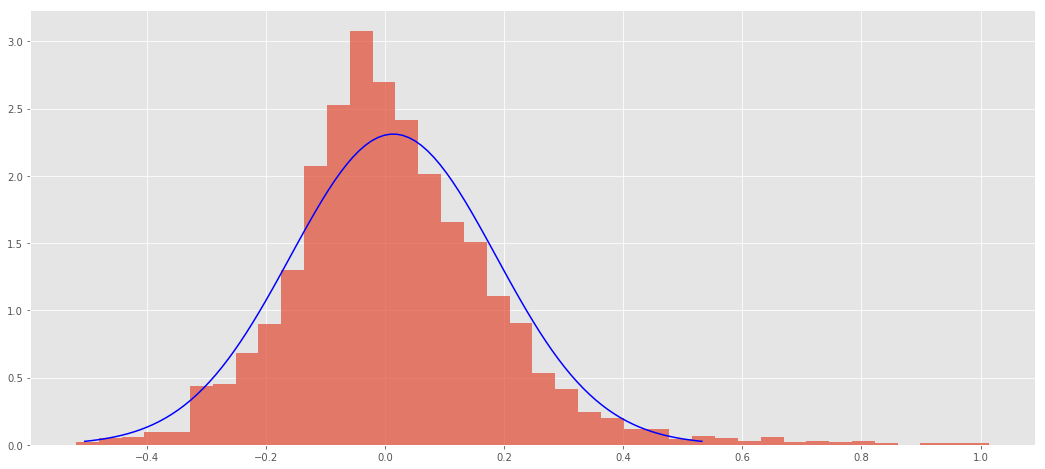

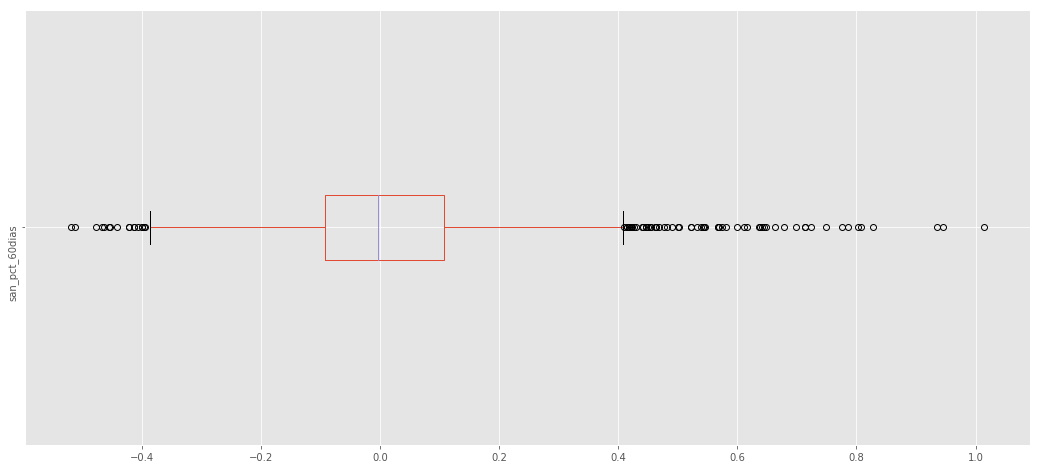

 el valor de 01p es : -0.34897 
 el valor de 05p es : -0.2427 
 el valor de 50p es : -0.0027534 
 el valor de 95p es : 0.29709 
 el valor de T-test es : 4.3482 
 el valor de avg es : 0.014 
 el valor de kur es : 2.5784 
 el valor de skw es : 0.81255 
 el valor de std es : 0.17269 
 el valor de val es : -1.2241 
 el valor de var es : 0.02982 
serie = san_pct_120dias


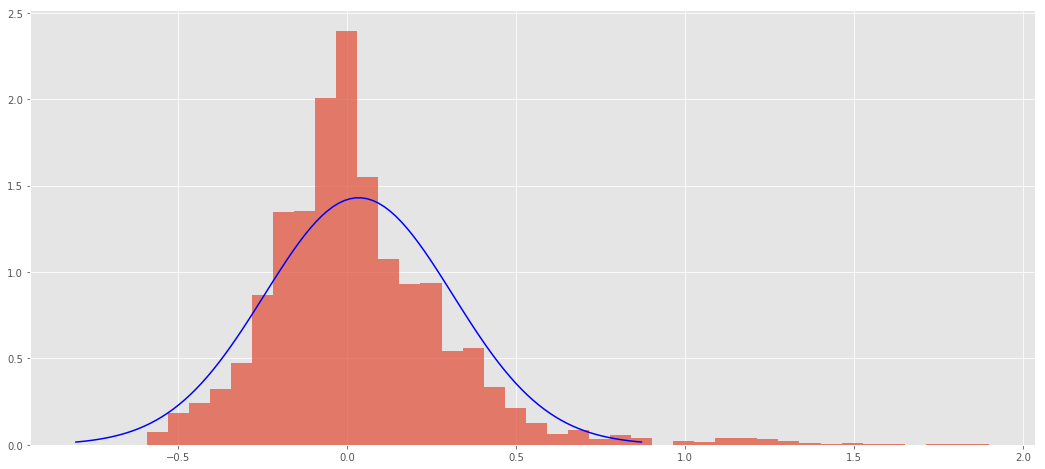

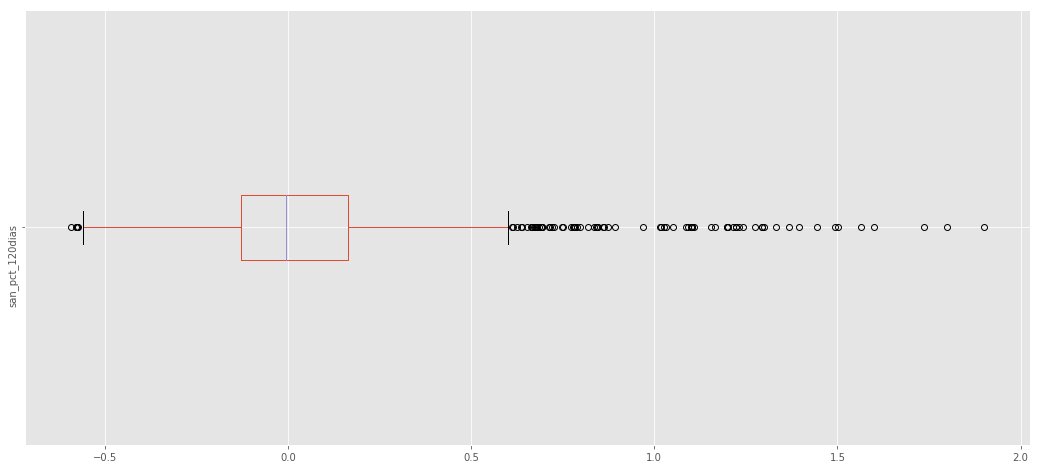

 el valor de 01p es : -0.49299 
 el valor de 05p es : -0.35039 
 el valor de 50p es : -0.0041226 
 el valor de 95p es : 0.47294 
 el valor de T-test es : 6.3874 
 el valor de avg es : 0.034 
 el valor de kur es : 5.6543 
 el valor de skw es : 1.5465 
 el valor de std es : 0.27904 
 el valor de val es : -1.3498 
 el valor de var es : 0.077862 
serie = san_pct_220dias


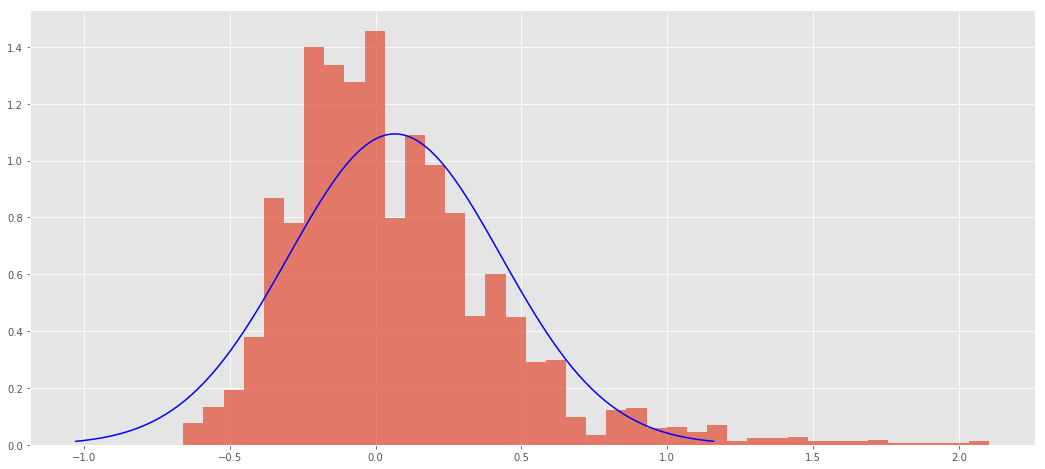

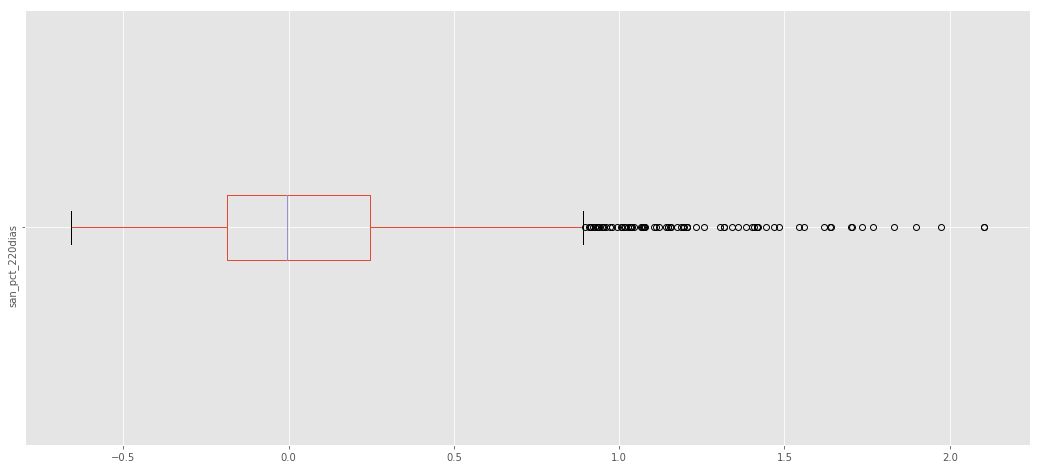

 el valor de 01p es : -0.56429 
 el valor de 05p es : -0.39158 
 el valor de 50p es : -0.0062796 
 el valor de 95p es : 0.70869 
 el valor de T-test es : 9.3606 
 el valor de avg es : 0.066 
 el valor de kur es : 3.204 
 el valor de skw es : 1.3196 
 el valor de std es : 0.36453 
 el valor de val es : -1.8098 
 el valor de var es : 0.13288 
serie = itx_pct_diario


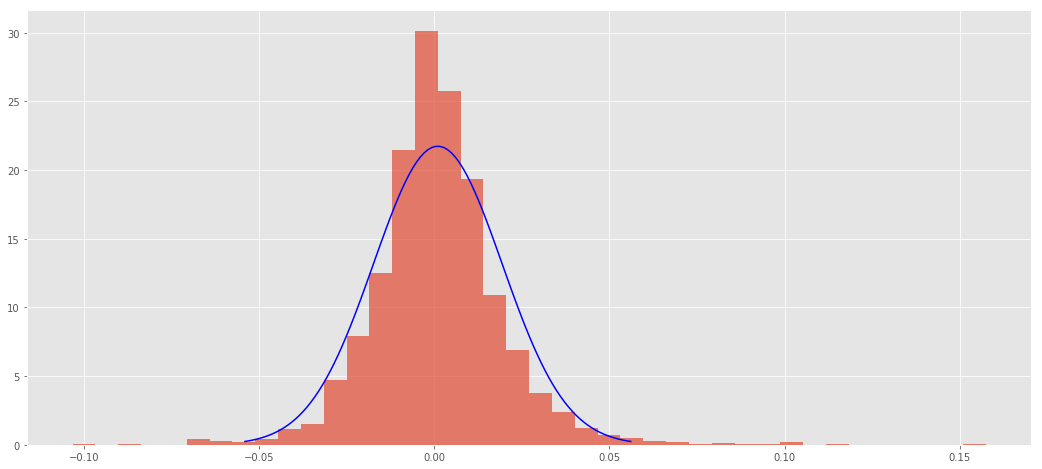

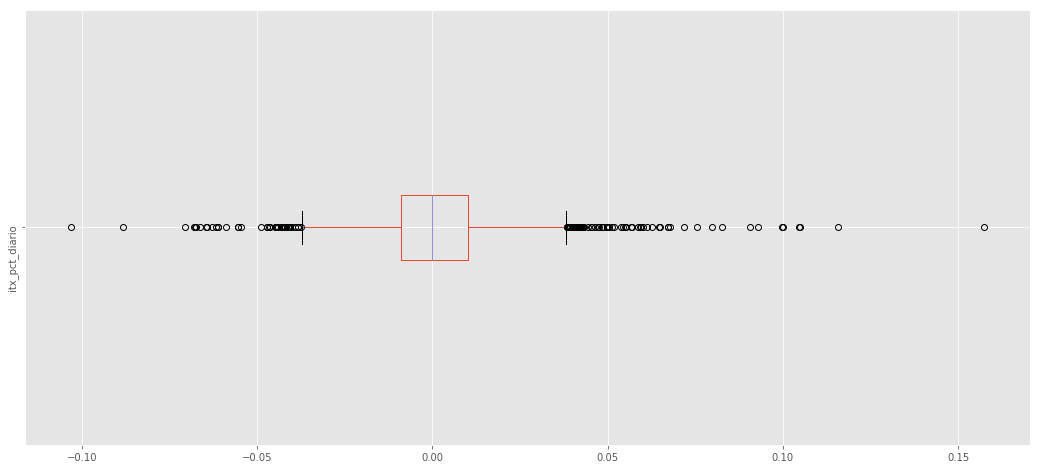

 el valor de 01p es : -0.043054 
 el valor de 05p es : -0.026111 
 el valor de 50p es : 0.0 
 el valor de 95p es : 0.029278 
 el valor de T-test es : 2.69 
 el valor de avg es : 0.001 
 el valor de kur es : 5.7752 
 el valor de skw es : 0.67499 
 el valor de std es : 0.018352 
 el valor de val es : -1.1213 
 el valor de var es : 0.00033679 
serie = itx_pct_20dias


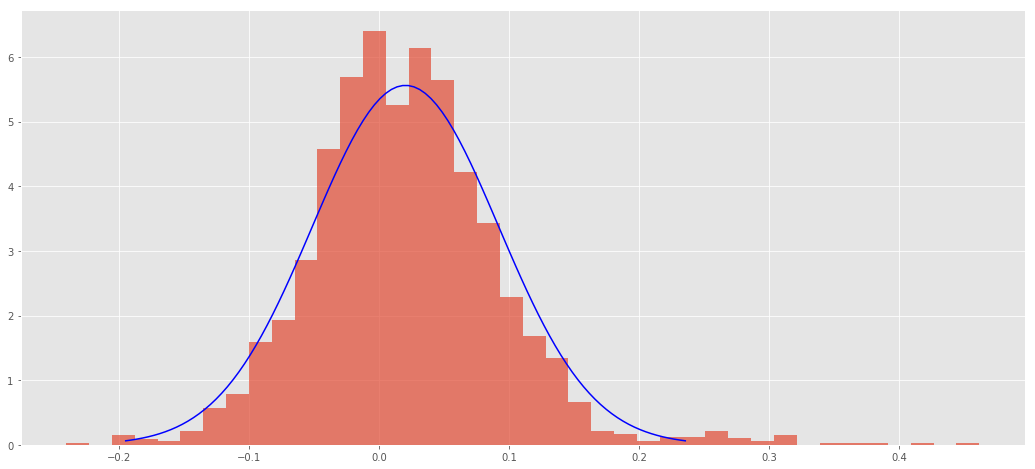

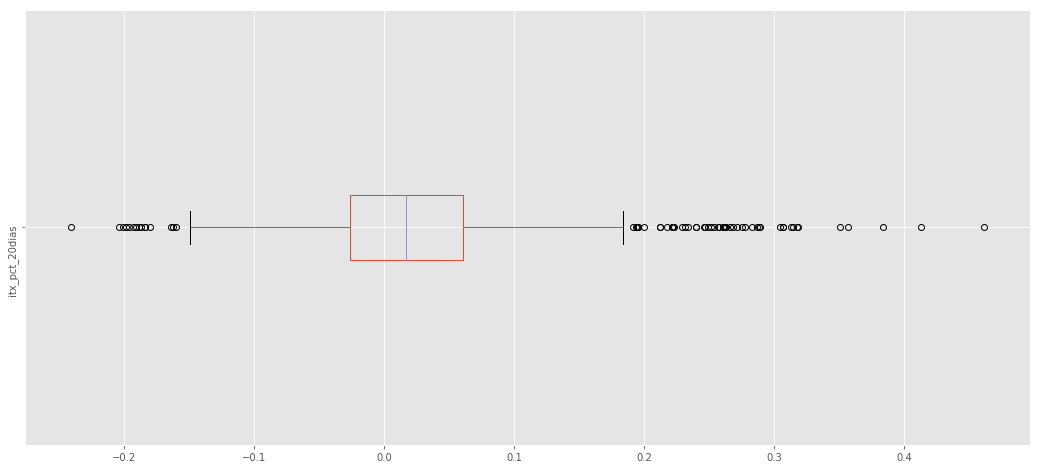

 el valor de 01p es : -0.13201 
 el valor de 05p es : -0.088743 
 el valor de 50p es : 0.016995 
 el valor de 95p es : 0.13449 
 el valor de T-test es : 14.418 
 el valor de avg es : 0.02 
 el valor de kur es : 2.4948 
 el valor de skw es : 0.67182 
 el valor de std es : 0.071742 
 el valor de val es : -1.5155 
 el valor de var es : 0.005147 
serie = itx_pct_60dias


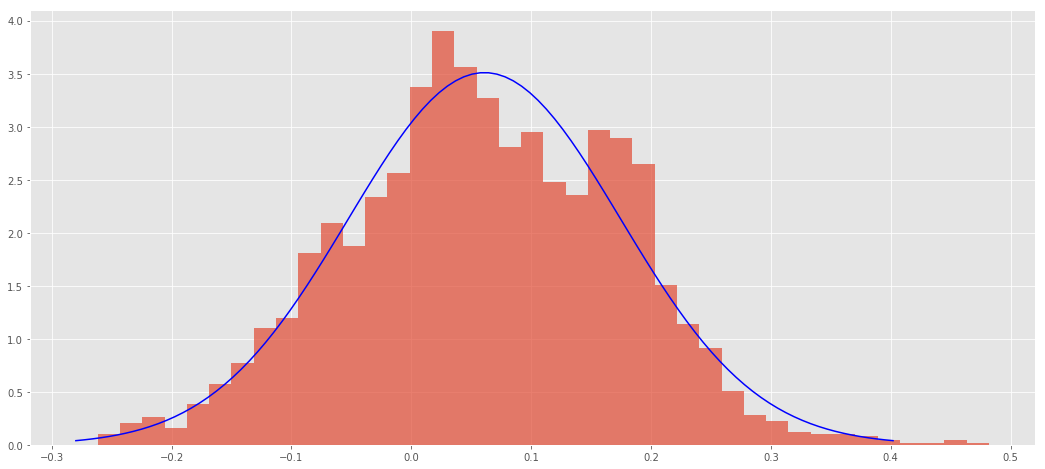

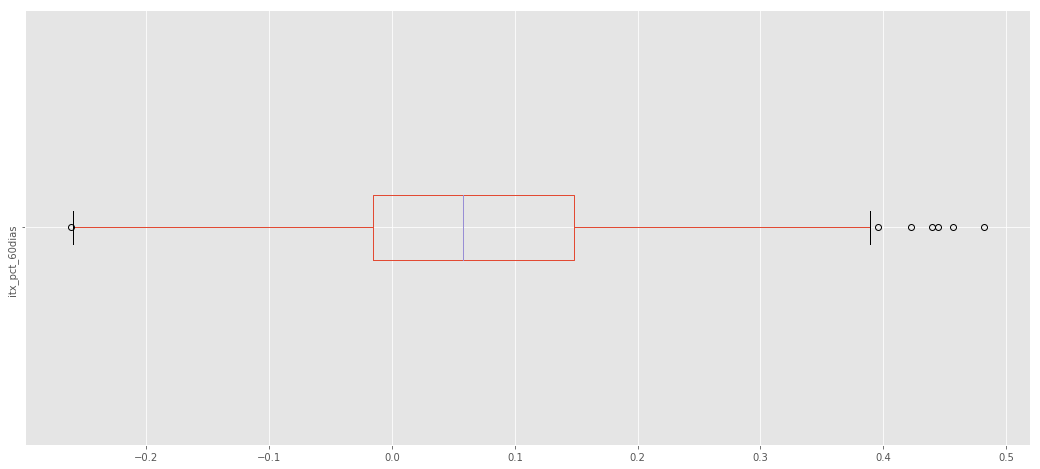

 el valor de 01p es : -0.20855 
 el valor de 05p es : -0.12564 
 el valor de 50p es : 0.057688 
 el valor de 95p es : 0.23461 
 el valor de T-test es : 27.81 
 el valor de avg es : 0.061 
 el valor de kur es : -0.15414 
 el valor de skw es : -0.016551 
 el valor de std es : 0.11364 
 el valor de val es : -1.8673 
 el valor de var es : 0.012913 
serie = itx_pct_120dias


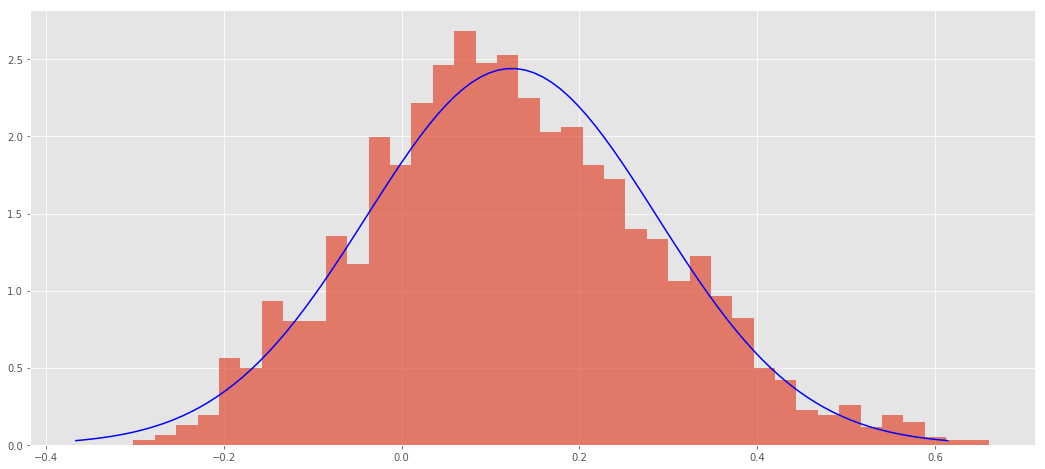

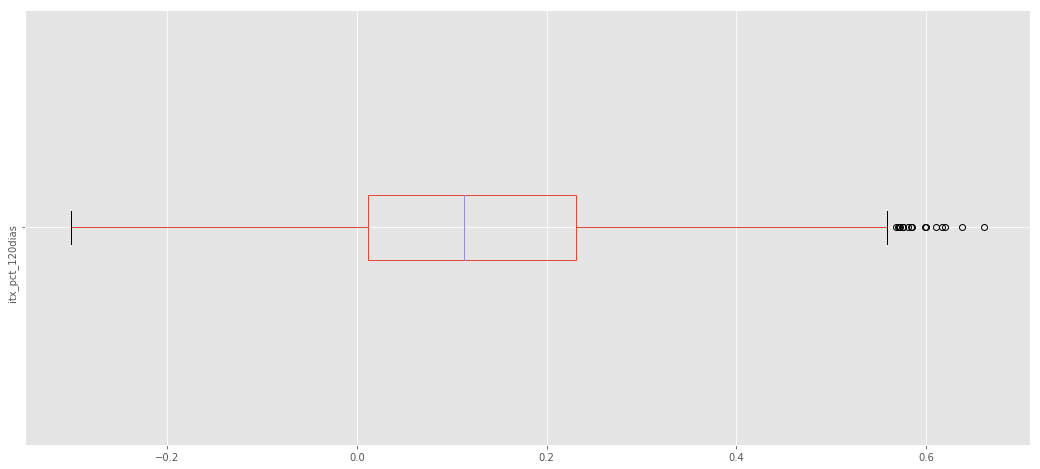

 el valor de 01p es : -0.20431 
 el valor de 05p es : -0.14056 
 el valor de 50p es : 0.113 
 el valor de 95p es : 0.39937 
 el valor de T-test es : 39.312 
 el valor de avg es : 0.124 
 el valor de kur es : -0.14483 
 el valor de skw es : 0.26422 
 el valor de std es : 0.16345 
 el valor de val es : -2.8412 
 el valor de var es : 0.026717 
serie = itx_pct_220dias


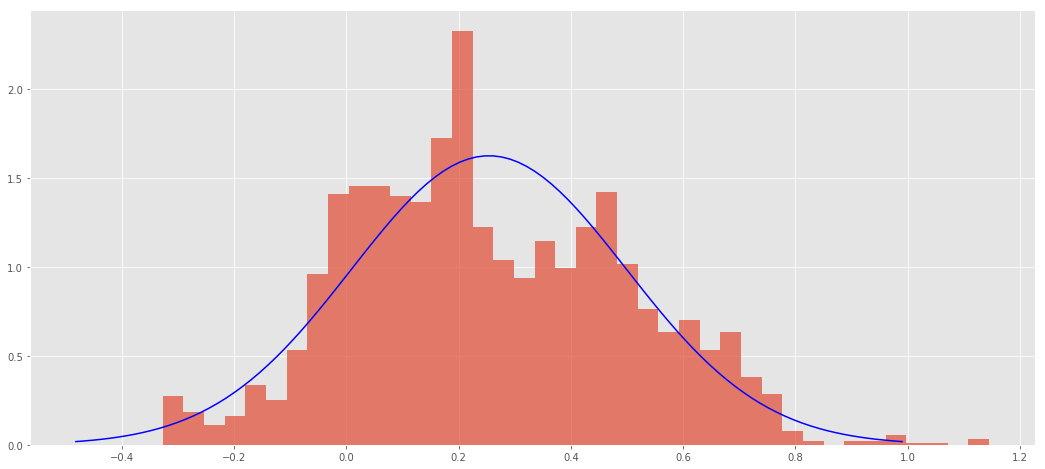

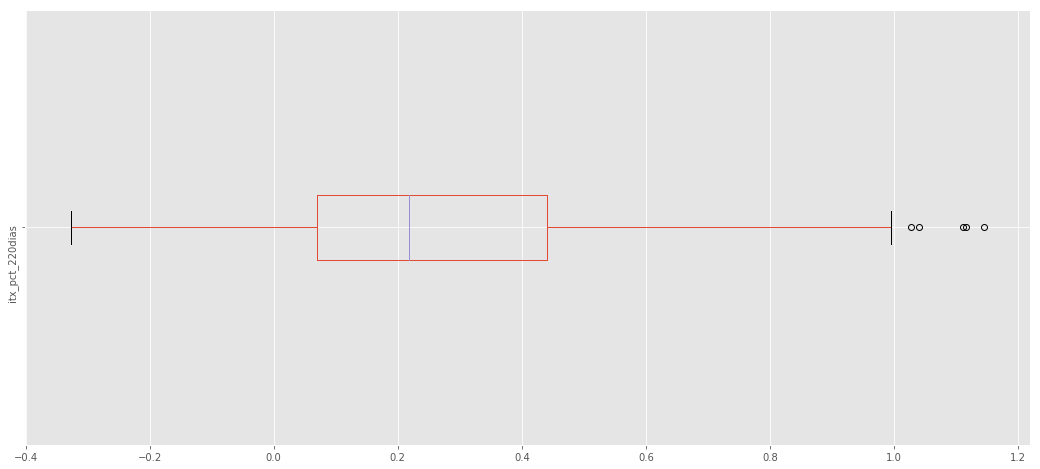

 el valor de 01p es : -0.29007 
 el valor de 05p es : -0.1033 
 el valor de 50p es : 0.21802 
 el valor de 95p es : 0.67891 
 el valor de T-test es : 53.841 
 el valor de avg es : 0.254 
 el valor de kur es : -0.31878 
 el valor de skw es : 0.24048 
 el valor de std es : 0.24527 
 el valor de val es : -6.5724 
 el valor de var es : 0.06016 
serie = tef_pct_diario


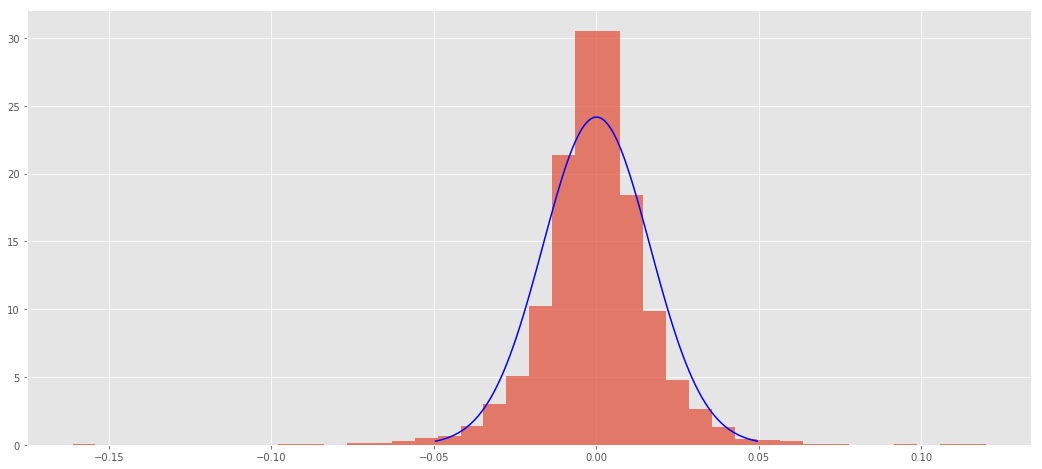

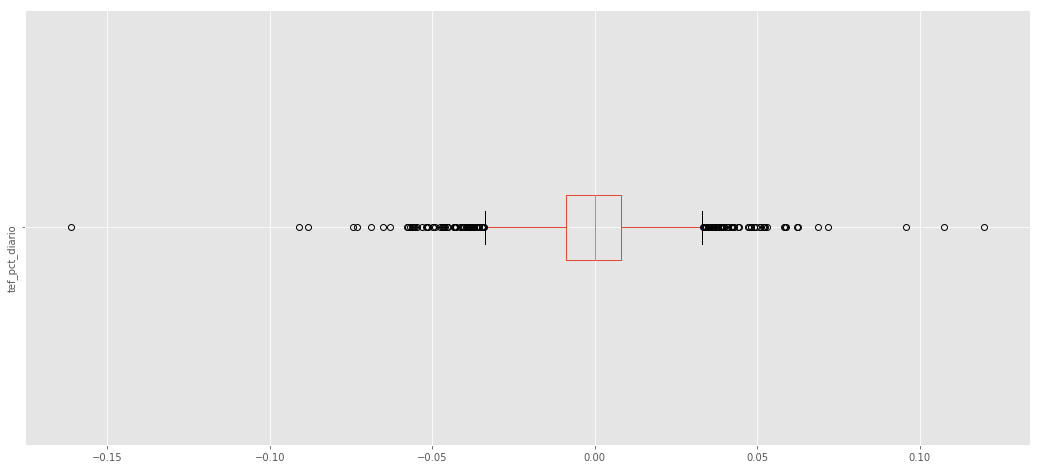

 el valor de 01p es : -0.046117 
 el valor de 05p es : -0.025546 
 el valor de 50p es : 0.0 
 el valor de 95p es : 0.025116 
 el valor de T-test es : -0.78451 
 el valor de avg es : -0.0 
 el valor de kur es : 7.2565 
 el valor de skw es : -0.23393 
 el valor de std es : 0.016502 
 el valor de val es : -0.98318 
 el valor de var es : 0.00027232 
serie = tef_pct_20dias


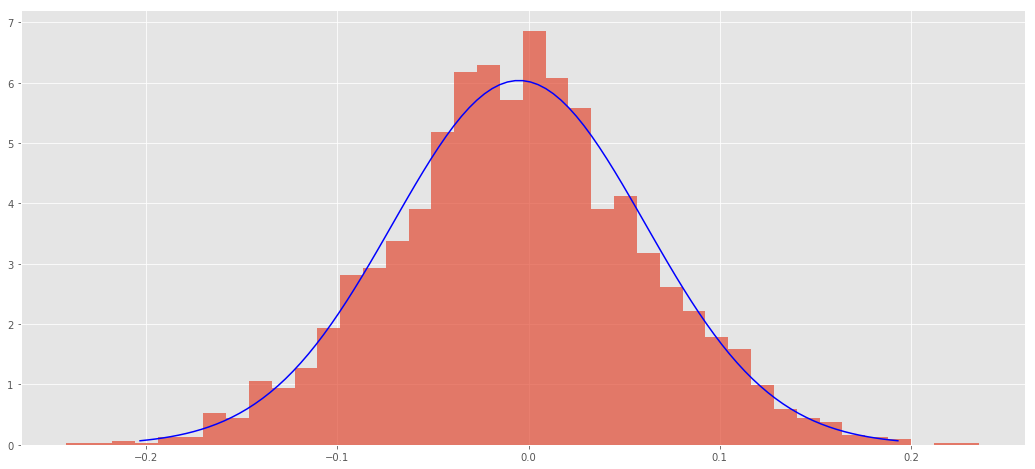

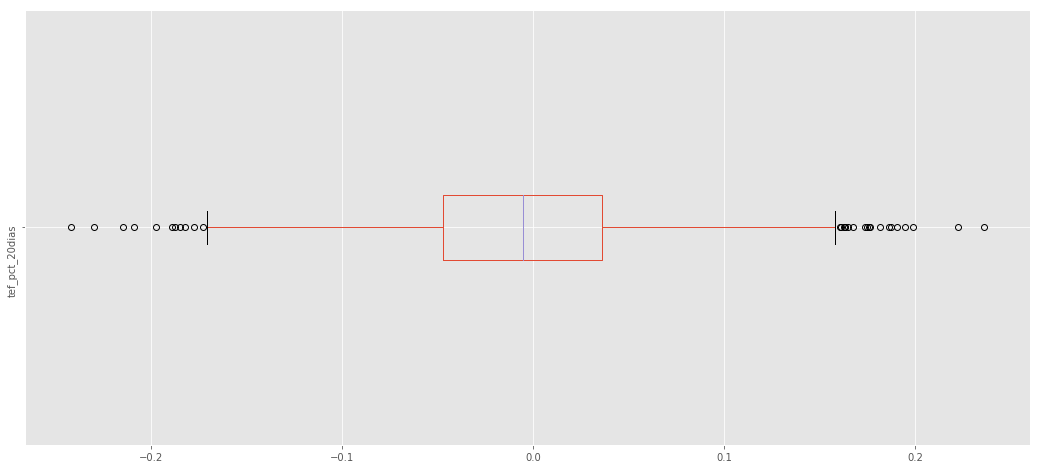

 el valor de 01p es : -0.15925 
 el valor de 05p es : -0.11485 
 el valor de 50p es : -0.0051814 
 el valor de 95p es : 0.10589 
 el valor de T-test es : -4.2166 
 el valor de avg es : -0.005 
 el valor de kur es : 0.084834 
 el valor de skw es : 0.03246 
 el valor de std es : 0.066066 
 el valor de val es : -0.92202 
 el valor de var es : 0.0043648 
serie = tef_pct_60dias


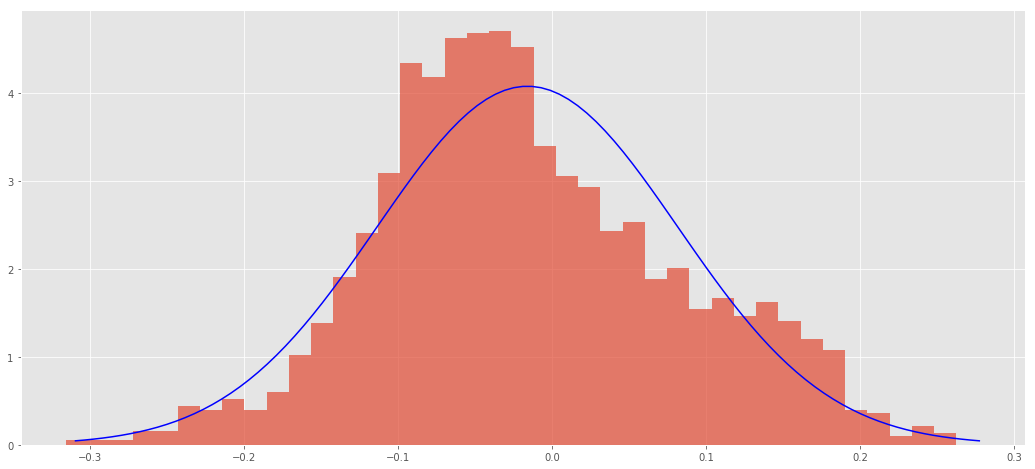

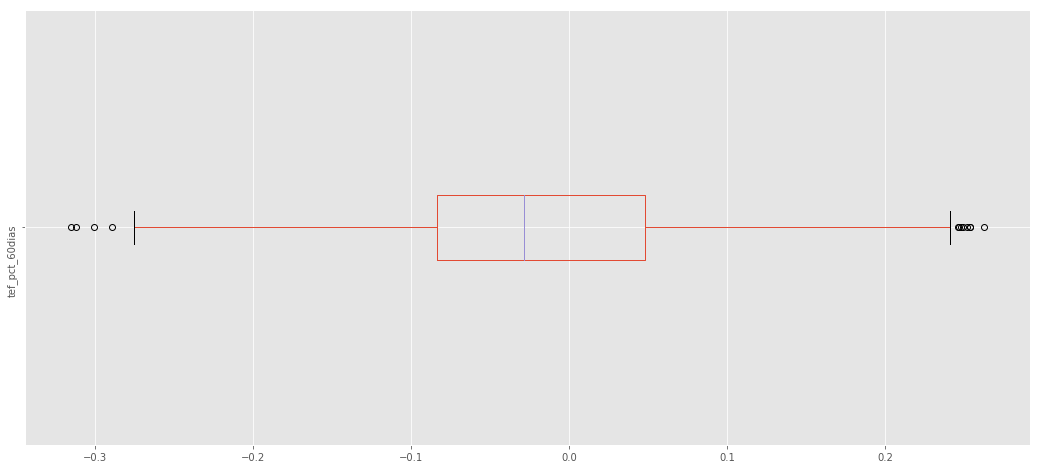

 el valor de 01p es : -0.23438 
 el valor de 05p es : -0.16142 
 el valor de 50p es : -0.028788 
 el valor de 95p es : 0.16146 
 el valor de T-test es : -8.5723 
 el valor de avg es : -0.016 
 el valor de kur es : -0.16881 
 el valor de skw es : 0.26119 
 el valor de std es : 0.097839 
 el valor de val es : -1.0002 
 el valor de var es : 0.0095724 
serie = tef_pct_120dias


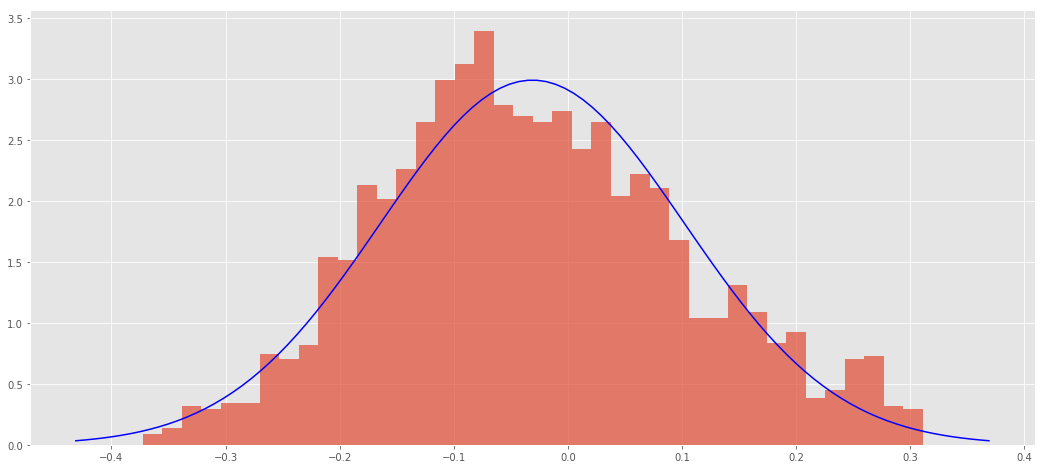

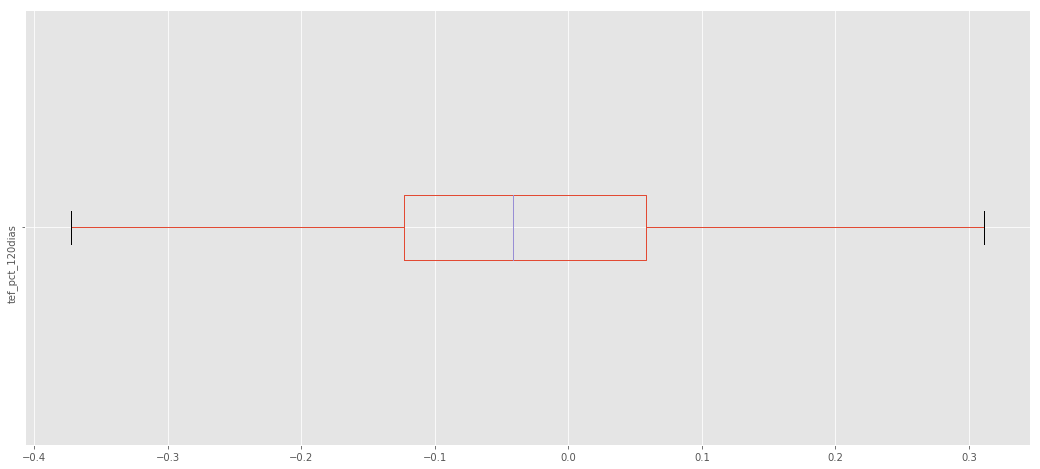

 el valor de 01p es : -0.31727 
 el valor de 05p es : -0.23724 
 el valor de 50p es : -0.041346 
 el valor de 95p es : 0.20718 
 el valor de T-test es : -11.999 
 el valor de avg es : -0.031 
 el valor de kur es : -0.31323 
 el valor de skw es : 0.23476 
 el valor de std es : 0.1334 
 el valor de val es : -0.87329 
 el valor de var es : 0.017796 
serie = tef_pct_220dias


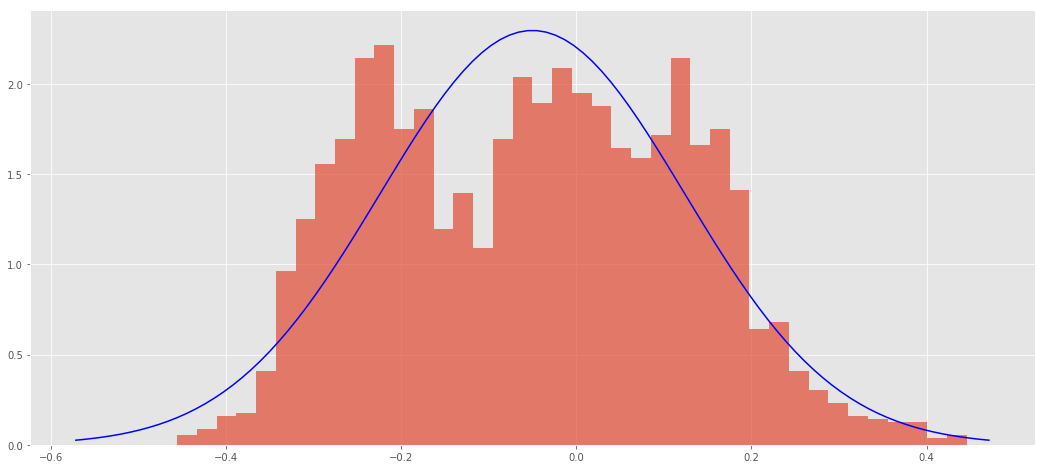

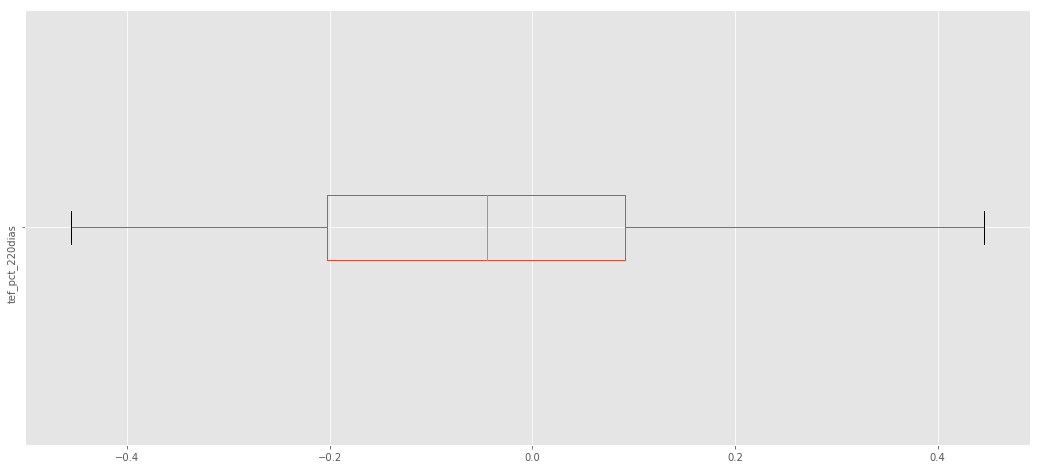

 el valor de 01p es : -0.37034 
 el valor de 05p es : -0.31287 
 el valor de 50p es : -0.045003 
 el valor de 95p es : 0.22145 
 el valor de T-test es : -14.837 
 el valor de avg es : -0.05 
 el valor de kur es : -0.83704 
 el valor de skw es : 0.095866 
 el valor de std es : 0.17372 
 el valor de val es : -0.70781 
 el valor de var es : 0.030177 


In [42]:
ccoco=f.filter(like='_pct',axis=1).columns.values
var95hist={}
for n in ccoco:
    soso="{}".format(n)
    #soso.append(n)
    #printsoso
    print ('serie =',soso)
    var95hist[soso]=calculate_aggregate(f[soso])


<h3>Tabla del var95 al 10%</h3>

In [43]:
#var95hist['05p']
for n in sorted(var95hist.keys()):
    print (n,'      ',var95hist[n]['05p'])

itx_pct_120dias        -0.14056400794374033
itx_pct_20dias        -0.08874327055051381
itx_pct_220dias        -0.10329570827455258
itx_pct_60dias        -0.12564126950921803
itx_pct_diario        -0.026110741713582308
san_pct_120dias        -0.3503889906569837
san_pct_20dias        -0.14796599839870406
san_pct_220dias        -0.3915822991291836
san_pct_60dias        -0.24270191308387015
san_pct_diario        -0.03501888098759252
tef_pct_120dias        -0.2372413819500246
tef_pct_20dias        -0.11484797634033804
tef_pct_220dias        -0.31287358189696735
tef_pct_60dias        -0.1614244009253026
tef_pct_diario        -0.025546012633065364


<h3>Tabla de cada serie y su respectiva frecuencia</h3>

In [44]:
histvar95=pd.DataFrame(var95hist)
np.round(histvar95.T,3)

01p    05p    50p    95p  T-test    avg    kur    skw  \
san_pct_diario  -0.067 -0.035  0.000  0.037   0.481  0.000  8.548  0.314   
san_pct_20dias  -0.225 -0.148  0.001  0.156   2.221  0.004  1.566  0.217   
san_pct_60dias  -0.349 -0.243 -0.003  0.297   4.348  0.014  2.578  0.813   
san_pct_120dias -0.493 -0.350 -0.004  0.473   6.387  0.034  5.654  1.546   
san_pct_220dias -0.564 -0.392 -0.006  0.709   9.361  0.066  3.204  1.320   
itx_pct_diario  -0.043 -0.026  0.000  0.029   2.690  0.001  5.775  0.675   
itx_pct_20dias  -0.132 -0.089  0.017  0.134  14.418  0.020  2.495  0.672   
itx_pct_60dias  -0.209 -0.126  0.058  0.235  27.810  0.061 -0.154 -0.017   
itx_pct_120dias -0.204 -0.141  0.113  0.399  39.312  0.124 -0.145  0.264   
itx_pct_220dias -0.290 -0.103  0.218  0.679  53.841  0.254 -0.319  0.240   
tef_pct_diario  -0.046 -0.026  0.000  0.025  -0.785 -0.000  7.256 -0.234   
tef_pct_20dias  -0.159 -0.115 -0.005  0.106  -4.217 -0.005  0.085  0.032   
tef_pct_60dias  -0.234 -0.161 -0.029  0.161  -8.572 -0.016 -0.169  0.261   
tef_pct_120dias -0.317 -0.237 -0.041  0.207 -11.999 -0.031 -0.313  0.235   
tef_pct_220dias -0.370 -0.313 -0.045  0.221 -14.837 -0.050 -0.837  0.096   

                   std    val    var  
san_pct_diario   0.024 -1.044  0.001  
san_pct_20dias   0.095 -1.054  0.009  
san_pct_60dias   0.173 -1.224  0.030  
san_pct_120dias  0.279 -1.350  0.078  
san_pct_220dias  0.365 -1.810  0.133  
itx_pct_diario   0.018 -1.121  0.000  
itx_pct_20dias   0.072 -1.515  0.005  
itx_pct_60dias   0.114 -1.867  0.013  
itx_pct_120dias  0.163 -2.841  0.027  
itx_pct_220dias  0.245 -6.572  0.060  
tef_pct_diario   0.017 -0.983  0.000  
tef_pct_20dias   0.066 -0.922  0.004  
tef_pct_60dias   0.098 -1.000  0.010  
tef_pct_120dias  0.133 -0.873  0.018  
tef_pct_220dias  0.174 -0.708  0.030

---

<p>También podemos ver límites en los que sabemos que esta roto el comportamiento de nuestra serie. Por ejemplo, en todas las series anteriores con kurtosis negativa, tenemos un mínimo donde dejamos de operar la serie.

<p>En este caso podemos decir, que si perdemos mas de un 30% en itx dejaremos de operar la serie, en cambio no asi con san o tef

<h4>Gráfico kurtosis anual de santander</h4>

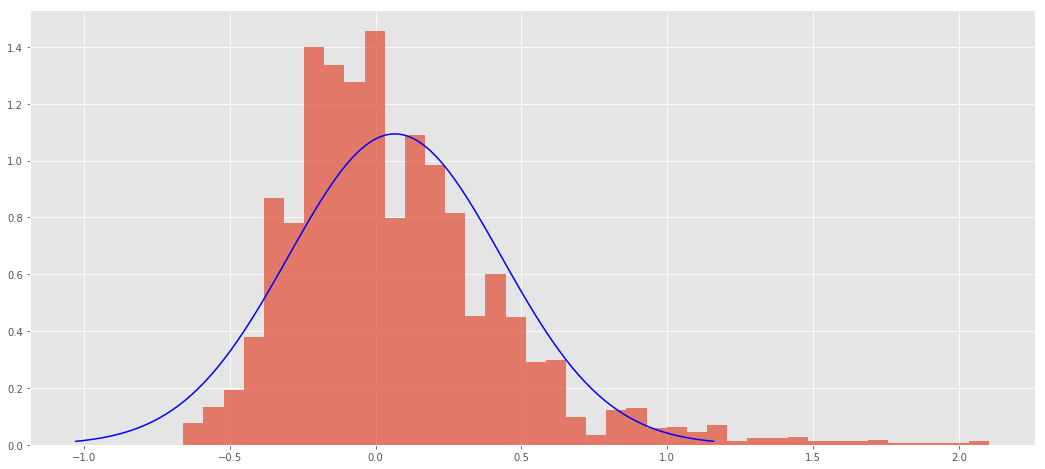

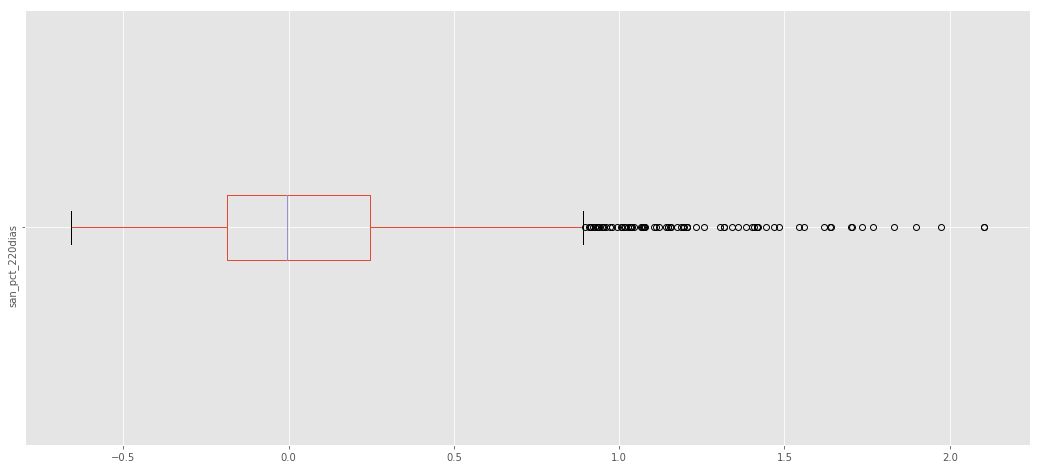

 el valor de 01p es : -0.56429 
 el valor de 05p es : -0.39158 
 el valor de 50p es : -0.0062796 
 el valor de 95p es : 0.70869 
 el valor de T-test es : 9.3606 
 el valor de avg es : 0.066 
 el valor de kur es : 3.204 
 el valor de skw es : 1.3196 
 el valor de std es : 0.36453 
 el valor de val es : -1.8098 
 el valor de var es : 0.13288 


In [45]:
pepe=calculate_aggregate(f['san_pct_220dias'])

<h4>Gráfico de itx de kurtosis anual </h4>

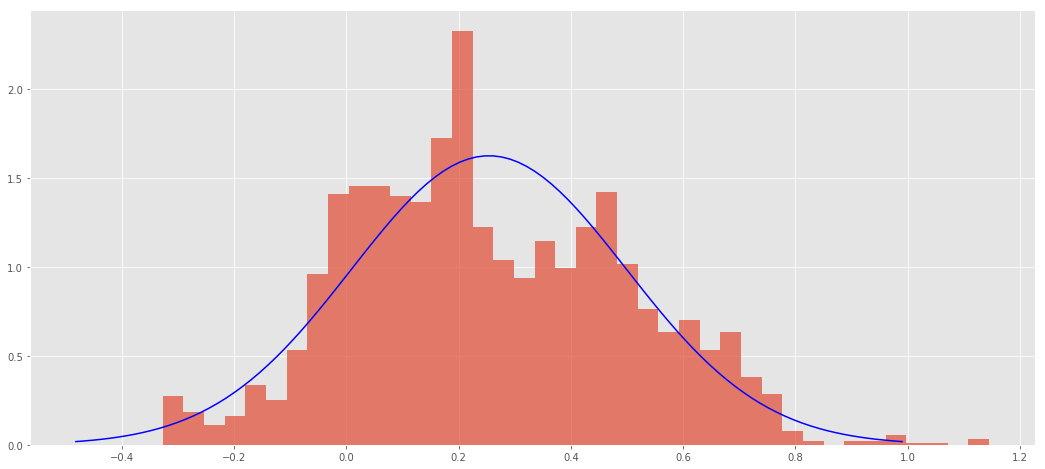

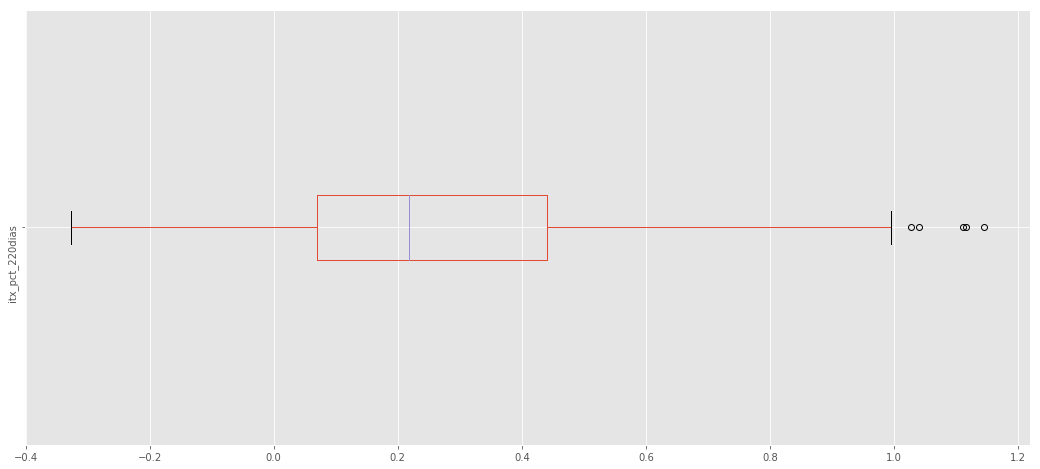

 el valor de 01p es : -0.29007 
 el valor de 05p es : -0.1033 
 el valor de 50p es : 0.21802 
 el valor de 95p es : 0.67891 
 el valor de T-test es : 53.841 
 el valor de avg es : 0.254 
 el valor de kur es : -0.31878 
 el valor de skw es : 0.24048 
 el valor de std es : 0.24527 
 el valor de val es : -6.5724 
 el valor de var es : 0.06016 


In [46]:
pepe=calculate_aggregate(f['itx_pct_220dias'])

<h4>Gráfico de la kurtosis de telefónica</h4>

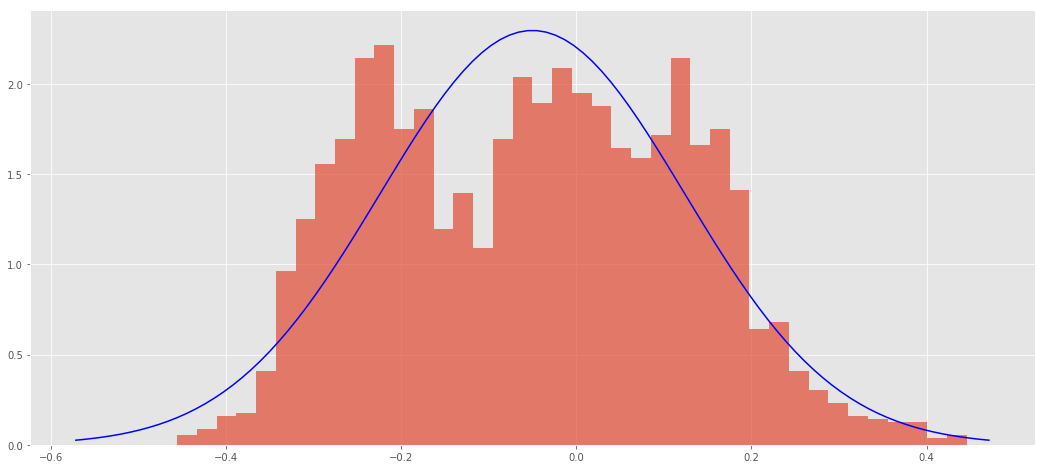

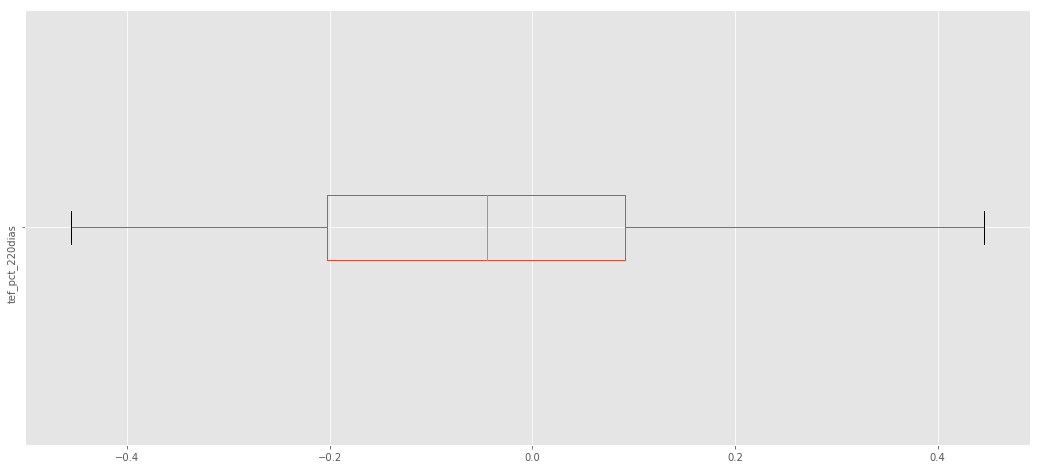

 el valor de 01p es : -0.37034 
 el valor de 05p es : -0.31287 
 el valor de 50p es : -0.045003 
 el valor de 95p es : 0.22145 
 el valor de T-test es : -14.837 
 el valor de avg es : -0.05 
 el valor de kur es : -0.83704 
 el valor de skw es : 0.095866 
 el valor de std es : 0.17372 
 el valor de val es : -0.70781 
 el valor de var es : 0.030177 


In [47]:
pepe=calculate_aggregate(f['tef_pct_220dias'])

# Calulo del VaR con el método Monte Carlo

El método estadístico o paramétrico de calculo del Value at Risk, suele asumir la normalidad de los rendimientos. Pero la distribución normal no siempre es un buen ajuste para la distribución de los retornos.

Podemos conseguir un mejor ajuste usando una distribución Johnson SU, debido a que esta distribución, con sus 4 parametros, puede ajustarse a cualquier combinación de kurtosis y skewness, que se encuentre por debajo de una distribución lognormal.

Podemos verlo mas claramente con unas gráficas.

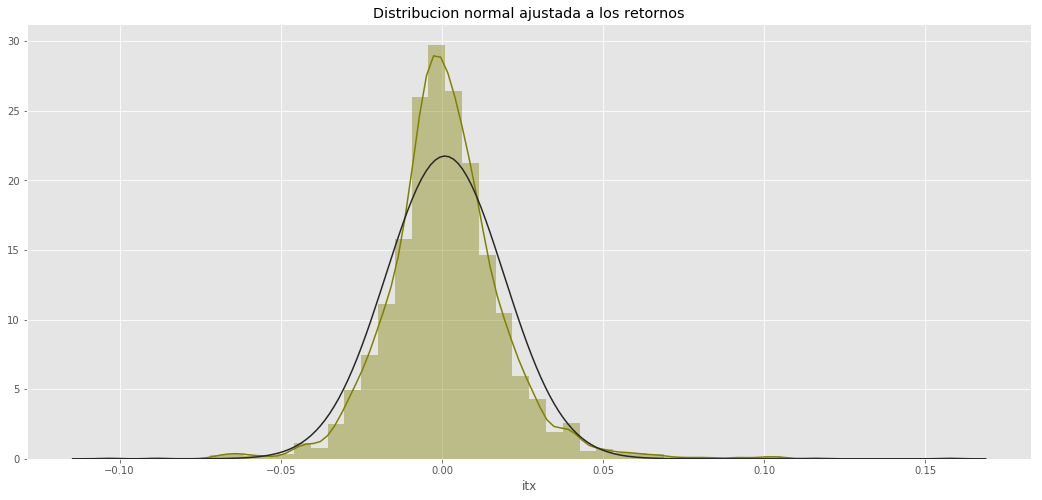

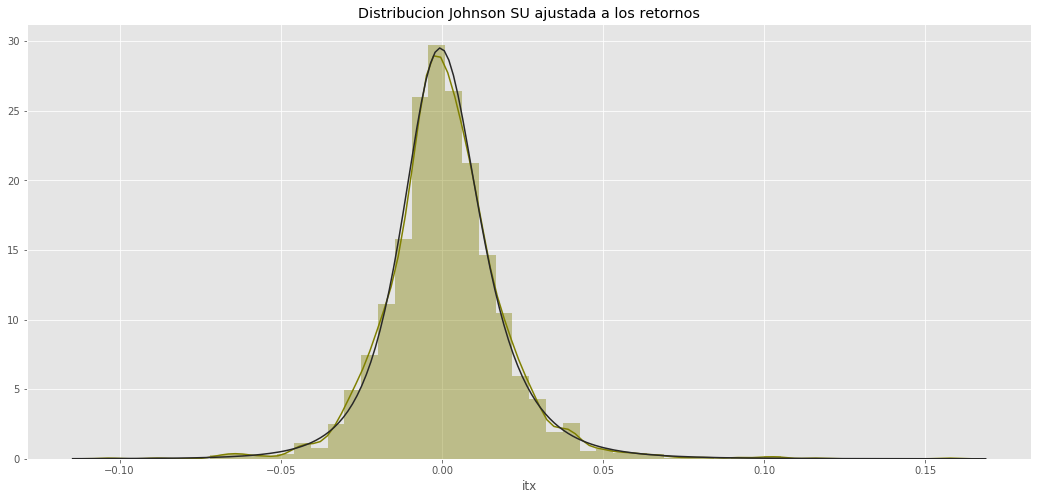

In [48]:
# import analisis
# import seaborn as sns
from scipy import stats
rets = f.itx.pct_change().dropna()
sns.distplot(rets, fit=stats.norm, kde=True, color='olive')
plt.title('Distribucion normal ajustada a los retornos')
plt.show()
sns.distplot(rets, fit=stats.johnsonsu, kde=True, color='olive')
plt.title('Distribucion Johnson SU ajustada a los retornos')
plt.show()

Una vez calculados los parametros de la distribución Johnson SU que ajusta nuestra distribución de retornos históricos, podemos simular una serie aleatoria futura que cumpla con esta distribución. 

Si hacemos un número suficientemente grande de simulaciones y tomamos los retornos relativos que arrojan al final del periodo propuesto, podemos obtener un VaR estimado futuro para un indice de confianza dado. 

Esto no es otra cosa que usar el método Monte Carlo para el calculo del VaR. 

Veamoslo en funcionamiento, para lo cual definimos una función que realiza el proceso explicado.

In [49]:
def var_montecarlo (prices, n_sims = 2000, ci=0.95, steps = 22, plot=False, ret_sims=False):
    
    # Calcula los parametros para ajustar la distribución a la serie de retornos históricos
    params = stats.johnsonsu.fit(prices.pct_change().dropna())
    arg = params[:-2]
    loc = params[-2]
    scale = params[-1]
    
    # Simulamos los retornos futuros según la distribución ajustada y calcula los precios futuros.
    simulations = pd.DataFrame()
    for sim in range(n_sims):
        jrets = stats.johnsonsu.rvs(loc=loc, scale=scale, *arg, size=steps)
        mc_price =  np.cumprod(jrets + 1) * prices.iloc[-1]
        mc_price = np.insert(mc_price,0, prices.iloc[-1])
        simulations[sim] = mc_price
    
    # Obtenemos los retornos relativos finales, y tomamos el cuantil que se ajusta al indice de confianza dado.
    ret_mes = (simulations.iloc[-1] / simulations.iloc[0]) - 1 
    var_mc = -round(ret_mes.quantile(1 - ci),6)
    
    # Grafica los precios futuros en caso de que se solicite.
    if plot:
        simulations.plot(legend=False, alpha=0.5)
        plt.title('Simulaciones de precios futuros'.upper(), fontsize=18, color='brown')
        plt.text(0, 21, 'El VaR 95 mensual por el metodo Monte Carlo es de {}%'.format(round(var_mc*100,2)), 
                 fontsize=16, color='navy')
        plt.show()
        
        sns.distplot((simulations.iloc[-1]/simulations.iloc[0])-1 , kde=True, color='darkolivegreen')
        plt.title('Distribucion de los retornos finales simulados'.upper(), fontsize=18, color='brown')
        plt.vlines(-var_mc, 0,2, linestyle='dashed', color='crimson')
        plt.text(-var_mc-0.1,2.2,'VaR 95 = {:.2f}%'.format(var_mc*100), fontsize=15, color='navy' )
        plt.show()
    
    # Retorna el VaR calculado, y opcionalmente el dataframe con las simulaciones.
    if ret_sims:
        return var_mc, simulations
    else:
        return var_mc

Simularemos los retornos de Inditex para el mes a partir del último precio de la seríe histórica que estamos estudiando, y obtendremos el VaR 95 mensual.

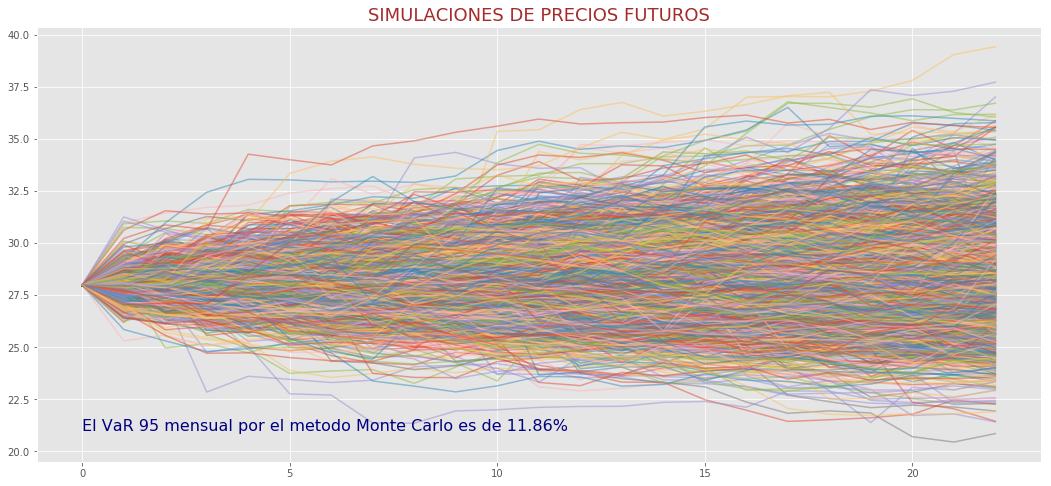

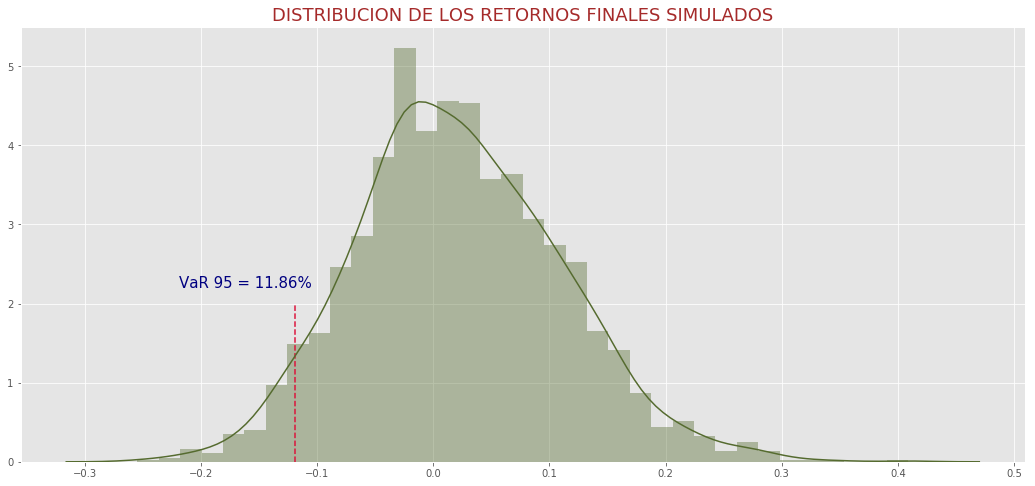

In [50]:
var, sims = var_montecarlo (f.itx, ret_sims=True, plot=True, n_sims=2000)

Vamos a calcular el VaR 95 mensual por el metódo paramétrico para compararlo.

In [51]:
var_e = var_estadistico(f.itx, time='M')

El VaR 95 para los retornos analizados con un frequencia M es del 8.17%


Podemos comprobar como el VaR calculado por el método Monte Carlo ofrece una perdida superior a la calculada por el paramétrico. 

Esto es debido al diferente ajuste de la distribución Johnson SU.

---

<H1>Conclusión</h1>

<li>Nos permite ver que distribución se está comportando mejor</li>
<li>Nos permite dibujar cual es el periodo en drawdown o por debajo de cero, de las diferentes distribuciones en funcion de su frecuencia</li>
<li>Podemos tener un mínimo de la distribución en el que podemos considerar que nuestra distribución se comporta de manera diferente.

# Cruce de medias

In [52]:
def ma_crossover(values,larga=20,corta=10):
#     import talib as ta
    df=pd.DataFrame()
    #print type(values)
    df['base']=values.copy()
    #print df.base.tail()
    df['logvalues']=np.log(df.base / df.base.shift(1))
    df['mediacorta']=df.base.rolling(corta).mean()
#     df['mediacorta']=ta.MA(df.base.values,corta,0)
    #print df.mediacorta.tail(20)
    df['medialarga']=df.base.rolling(larga).mean()
#     df['medialarga']=ta.MA(df.base.values,larga,0)
    #print df.medialarga.tail(20)
    #df[['base','medialarga','mediacorta']].plot(figsize=(16,9))
    df['senal']=np.where(df.mediacorta>df.medialarga,1,-1)
    df['senal']=df['senal'].fillna(0)
    #df.senal.plot(secondary_y=True)
    #print df.logvalues
    df['rendimiento']=df.senal.shift()*df.logvalues
    df['rendimiento']=df['rendimiento'].fillna(0)
    df['rendimiento'][0]=np.log(df['base'][0])
    df['serie']=np.exp(df.rendimiento.cumsum())
    
    return df.serie

<p>Calculamos todo lo anterior para unas estrategias simples.
<p>Vamos a calcular el var en función de unas estrategias simples de cruce de medias. En este caso vamos a combinar las medias cortas de 10,20,50,10 con las medias largas de 20,50, 100 y 220.

In [53]:
estrategias={}
corta = [10,20,50,100]
larga = [20,50,100,220]
for n in tickers:
    for j in larga:
        for m in corta:
            if m < j:
                f['{}_c_m_{}_{}'.format(n,m,j)]=ma_crossover(f['{}'.format(n)],j,m)


In [54]:
f.columns
seleccion=f.filter(like='_c_m',axis=1).columns.values
g=f[seleccion]
g.columns

Index(['san_c_m_10_20', 'san_c_m_10_50', 'san_c_m_20_50', 'san_c_m_10_100',
       'san_c_m_20_100', 'san_c_m_50_100', 'san_c_m_10_220', 'san_c_m_20_220',
       'san_c_m_50_220', 'san_c_m_100_220', 'itx_c_m_10_20', 'itx_c_m_10_50',
       'itx_c_m_20_50', 'itx_c_m_10_100', 'itx_c_m_20_100', 'itx_c_m_50_100',
       'itx_c_m_10_220', 'itx_c_m_20_220', 'itx_c_m_50_220', 'itx_c_m_100_220',
       'tef_c_m_10_20', 'tef_c_m_10_50', 'tef_c_m_20_50', 'tef_c_m_10_100',
       'tef_c_m_20_100', 'tef_c_m_50_100', 'tef_c_m_10_220', 'tef_c_m_20_220',
       'tef_c_m_50_220', 'tef_c_m_100_220'],
      dtype='object')

<h4>Cálculo del var historico para cada sistema en grafico</h4>

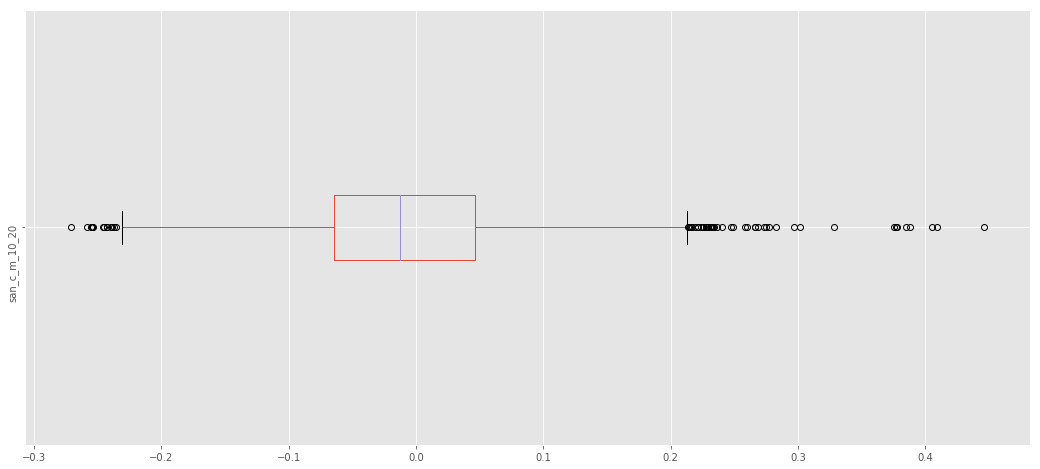

 el valor de 01p es : -0.20369 
 el valor de 05p es : -0.13761 
 el valor de 50p es : -0.012603 
 el valor de 95p es : 0.15424 
 el valor de T-test es : -2.4889 
 el valor de avg es : -0.004 
 el valor de kur es : 1.2084 
 el valor de skw es : 0.52378 
 el valor de std es : 0.090123 
 el valor de val es : -1.1208 
 el valor de var es : 0.0081222 


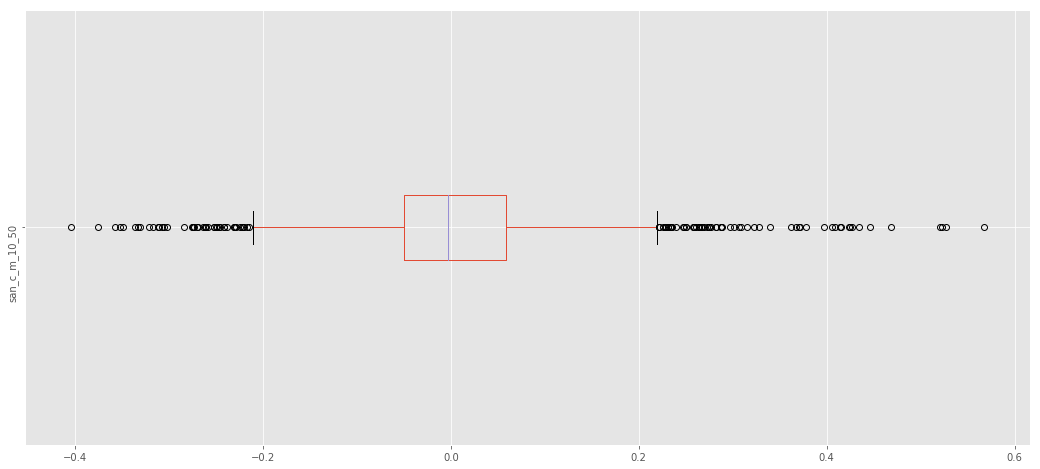

 el valor de 01p es : -0.25292 
 el valor de 05p es : -0.12759 
 el valor de 50p es : -0.0029124 
 el valor de 95p es : 0.17283 
 el valor de T-test es : 3.8566 
 el valor de avg es : 0.007 
 el valor de kur es : 3.0366 
 el valor de skw es : 0.59238 
 el valor de std es : 0.099485 
 el valor de val es : -1.3546 
 el valor de var es : 0.0098972 


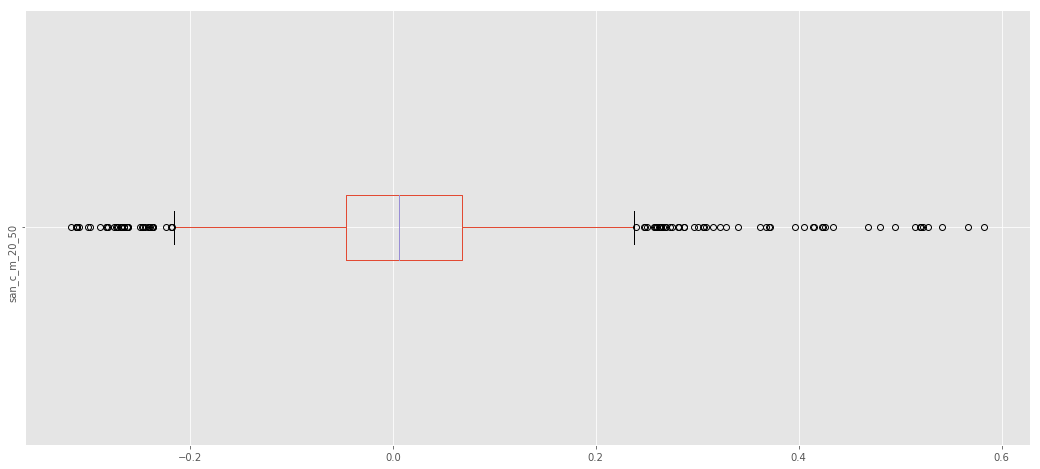

 el valor de 01p es : -0.24757 
 el valor de 05p es : -0.12792 
 el valor de 50p es : 0.0063836 
 el valor de 95p es : 0.17477 
 el valor de T-test es : 7.5418 
 el valor de avg es : 0.015 
 el valor de kur es : 3.4146 
 el valor de skw es : 0.7223 
 el valor de std es : 0.10072 
 el valor de val es : -1.3662 
 el valor de var es : 0.010145 


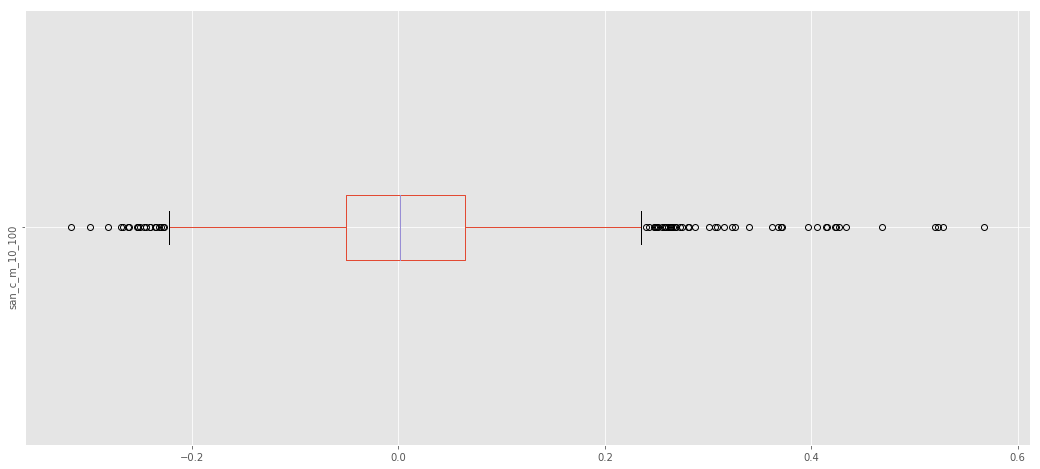

 el valor de 01p es : -0.21286 
 el valor de 05p es : -0.14101 
 el valor de 50p es : 0.0019825 
 el valor de 95p es : 0.16613 
 el valor de T-test es : 5.0494 
 el valor de avg es : 0.009 
 el valor de kur es : 2.2979 
 el valor de skw es : 0.62601 
 el valor de std es : 0.097574 
 el valor de val es : -1.1782 
 el valor de var es : 0.0095207 


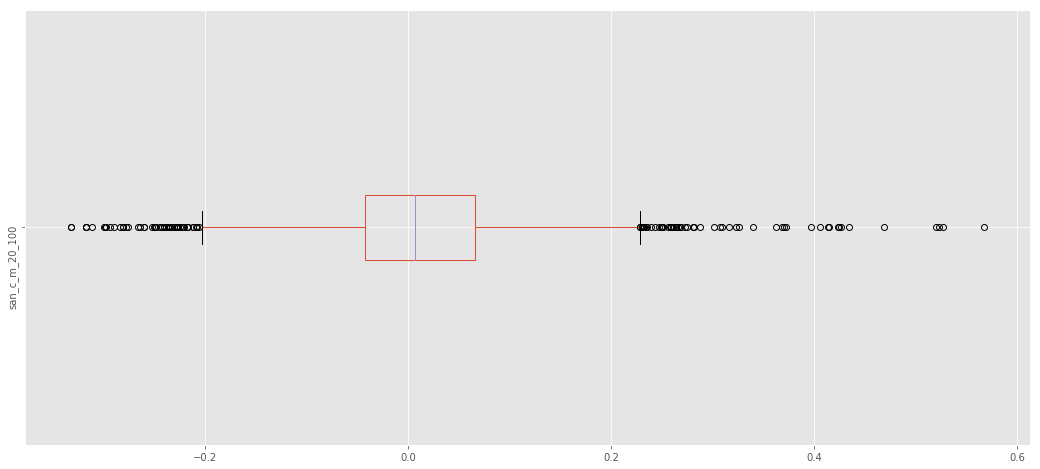

 el valor de 01p es : -0.24122 
 el valor de 05p es : -0.12929 
 el valor de 50p es : 0.0064542 
 el valor de 95p es : 0.16917 
 el valor de T-test es : 7.0937 
 el valor de avg es : 0.013 
 el valor de kur es : 2.6409 
 el valor de skw es : 0.45358 
 el valor de std es : 0.097745 
 el valor de val es : -1.3084 
 el valor de var es : 0.0095541 


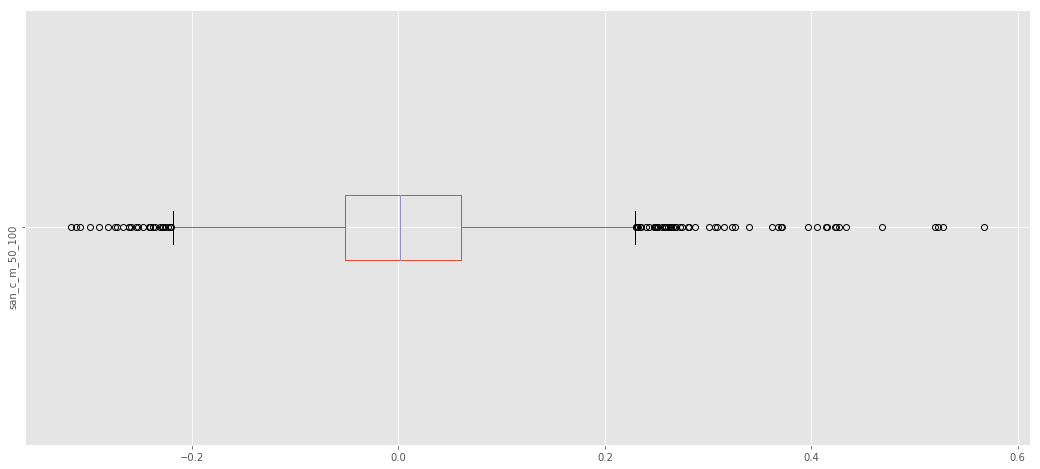

 el valor de 01p es : -0.21856 
 el valor de 05p es : -0.14349 
 el valor de 50p es : 0.0012615 
 el valor de 95p es : 0.16636 
 el valor de T-test es : 4.0237 
 el valor de avg es : 0.008 
 el valor de kur es : 2.2243 
 el valor de skw es : 0.58078 
 el valor de std es : 0.099034 
 el valor de val es : -1.1594 
 el valor de var es : 0.0098078 


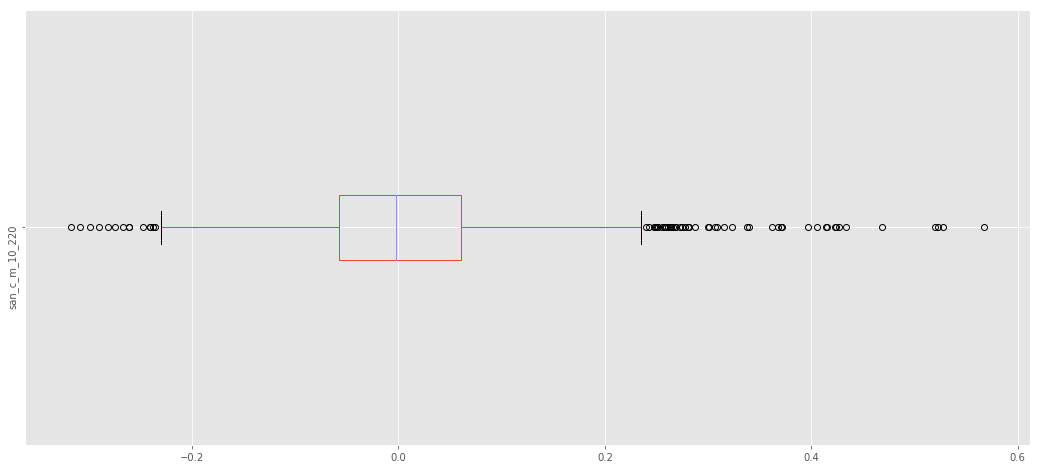

 el valor de 01p es : -0.21133 
 el valor de 05p es : -0.13974 
 el valor de 50p es : -0.0019419 
 el valor de 95p es : 0.16613 
 el valor de T-test es : 2.9558 
 el valor de avg es : 0.006 
 el valor de kur es : 2.1987 
 el valor de skw es : 0.67591 
 el valor de std es : 0.098911 
 el valor de val es : -1.1889 
 el valor de var es : 0.0097833 


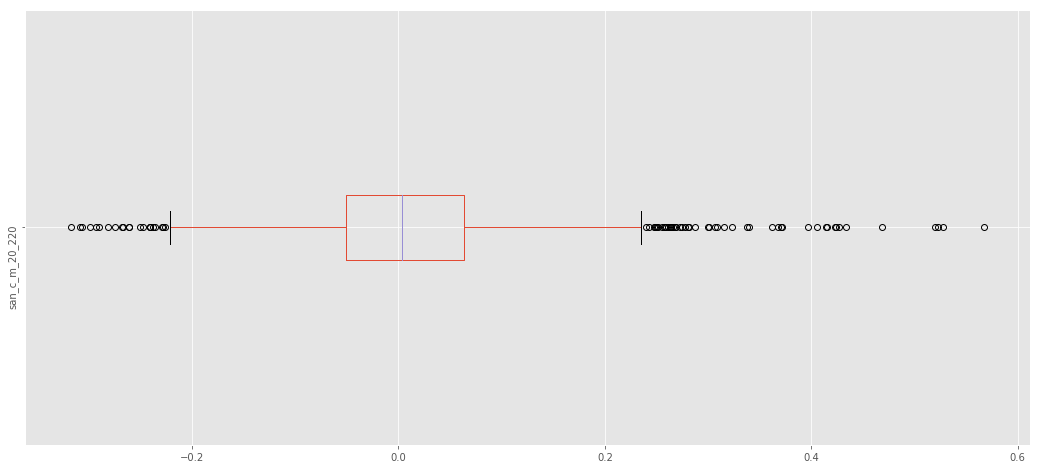

 el valor de 01p es : -0.21583 
 el valor de 05p es : -0.14352 
 el valor de 50p es : 0.0036936 
 el valor de 95p es : 0.16612 
 el valor de T-test es : 4.7708 
 el valor de avg es : 0.009 
 el valor de kur es : 2.232 
 el valor de skw es : 0.5774 
 el valor de std es : 0.098716 
 el valor de val es : -1.1575 
 el valor de var es : 0.0097449 


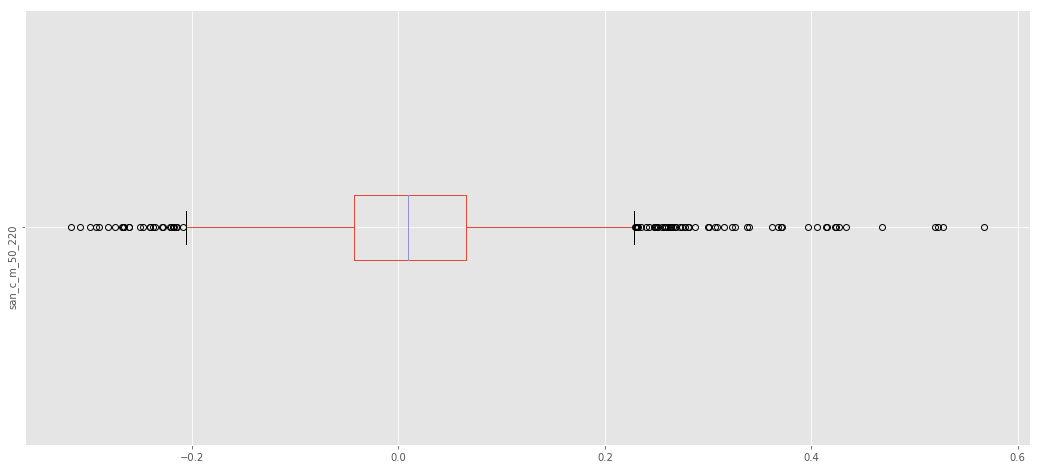

 el valor de 01p es : -0.20935 
 el valor de 05p es : -0.13129 
 el valor de 50p es : 0.0095671 
 el valor de 95p es : 0.16313 
 el valor de T-test es : 7.5912 
 el valor de avg es : 0.014 
 el valor de kur es : 2.6538 
 el valor de skw es : 0.60039 
 el valor de std es : 0.09534 
 el valor de val es : -1.2425 
 el valor de var es : 0.0090896 


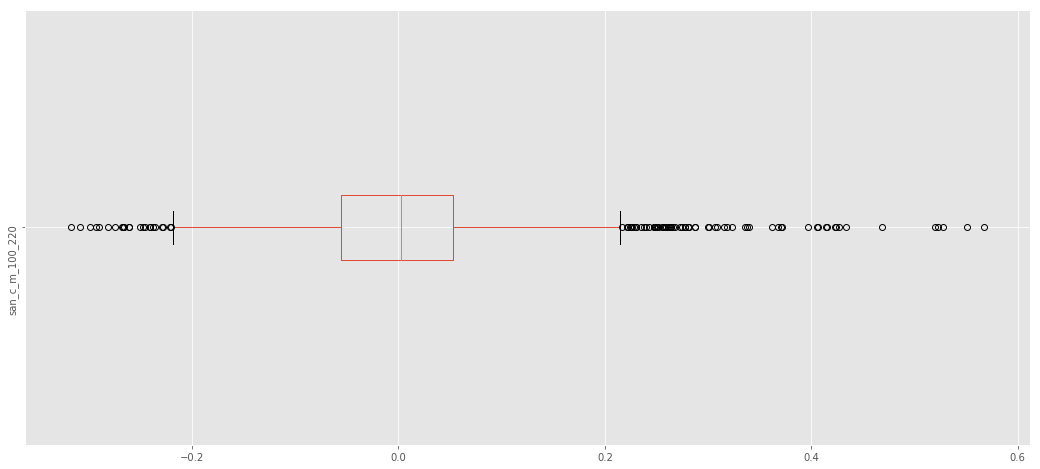

 el valor de 01p es : -0.21453 
 el valor de 05p es : -0.13919 
 el valor de 50p es : 0.0023623 
 el valor de 95p es : 0.15868 
 el valor de T-test es : 2.293 
 el valor de avg es : 0.004 
 el valor de kur es : 3.0569 
 el valor de skw es : 0.77256 
 el valor de std es : 0.097422 
 el valor de val es : -1.14 
 el valor de var es : 0.009491 


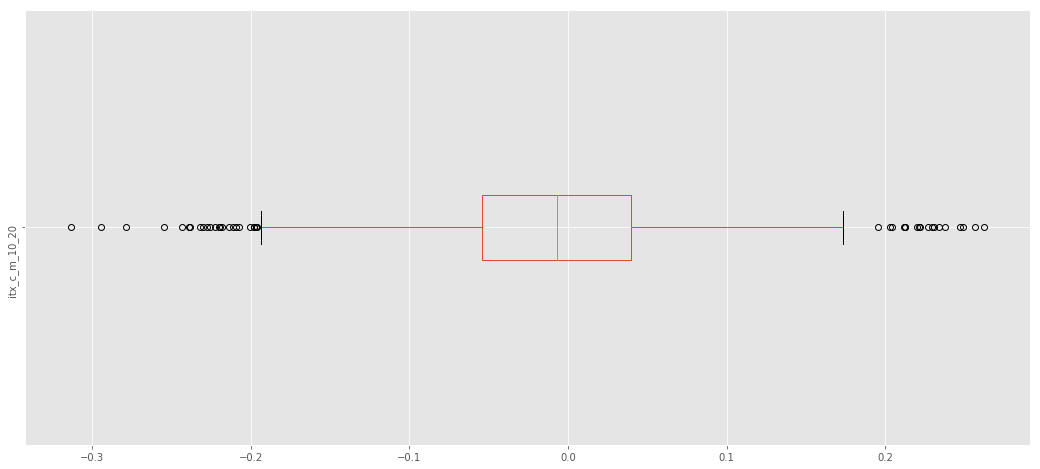

 el valor de 01p es : -0.19052 
 el valor de 05p es : -0.12303 
 el valor de 50p es : -0.0067361 
 el valor de 95p es : 0.11424 
 el valor de T-test es : -4.5365 
 el valor de avg es : -0.006 
 el valor de kur es : 0.59543 
 el valor de skw es : -0.015249 
 el valor de std es : 0.073572 
 el valor de val es : -0.92854 
 el valor de var es : 0.0054128 


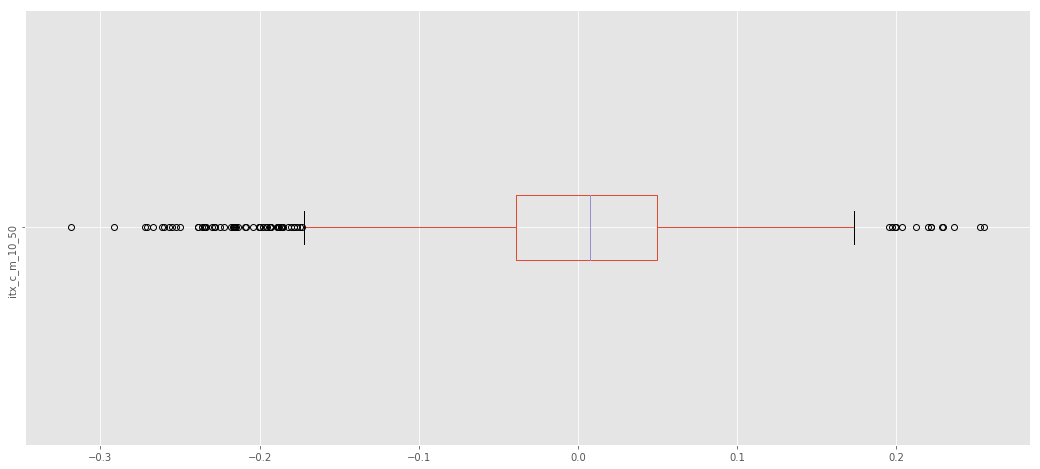

 el valor de 01p es : -0.21549 
 el valor de 05p es : -0.11873 
 el valor de 50p es : 0.0075141 
 el valor de 95p es : 0.11541 
 el valor de T-test es : 2.4815 
 el valor de avg es : 0.003 
 el valor de kur es : 1.0395 
 el valor de skw es : -0.44716 
 el valor de std es : 0.073119 
 el valor de val es : -0.97198 
 el valor de var es : 0.0053465 


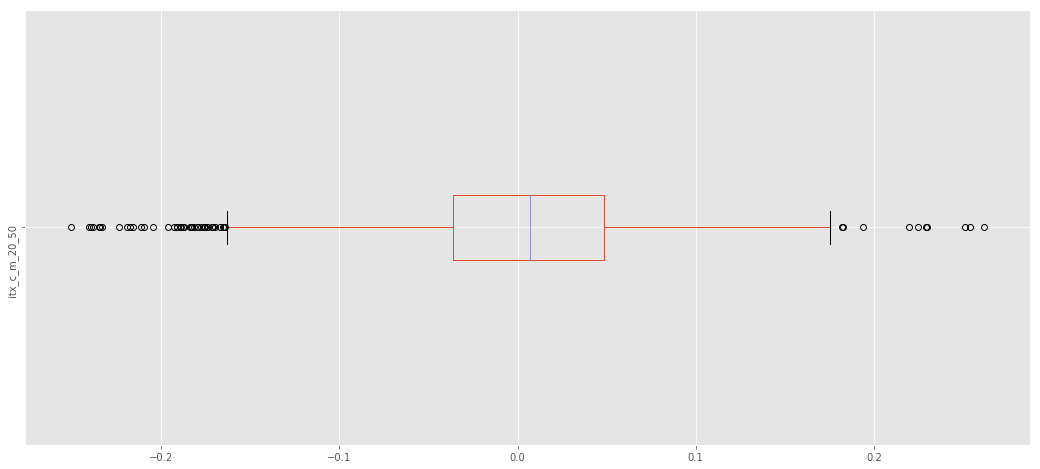

 el valor de 01p es : -0.1794 
 el valor de 05p es : -0.10802 
 el valor de 50p es : 0.0071159 
 el valor de 95p es : 0.11405 
 el valor de T-test es : 3.7057 
 el valor de avg es : 0.005 
 el valor de kur es : 0.61312 
 el valor de skw es : -0.24011 
 el valor de std es : 0.068181 
 el valor de val es : -1.0558 
 el valor de var es : 0.0046486 


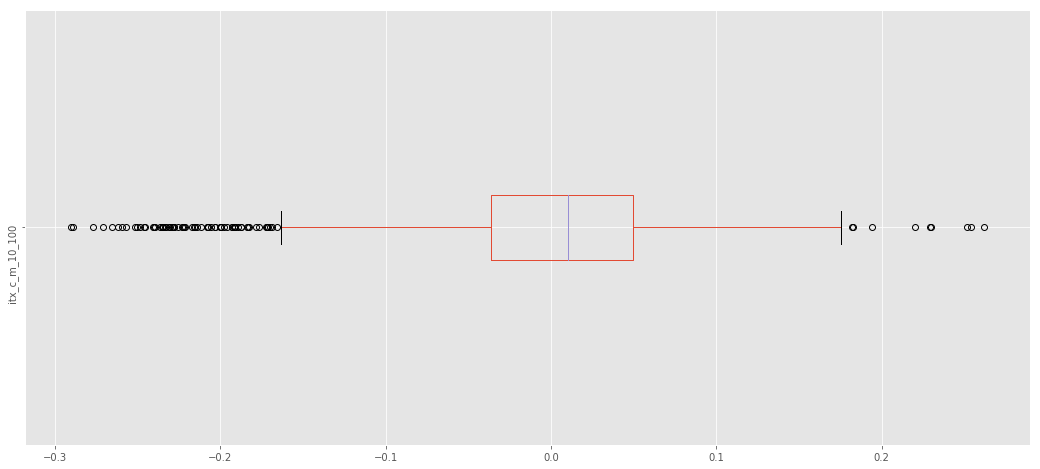

 el valor de 01p es : -0.228 
 el valor de 05p es : -0.1191 
 el valor de 50p es : 0.010159 
 el valor de 95p es : 0.11664 
 el valor de T-test es : 3.3833 
 el valor de avg es : 0.005 
 el valor de kur es : 1.2534 
 el valor de skw es : -0.58662 
 el valor de std es : 0.073291 
 el valor de val es : -0.97934 
 el valor de var es : 0.0053716 


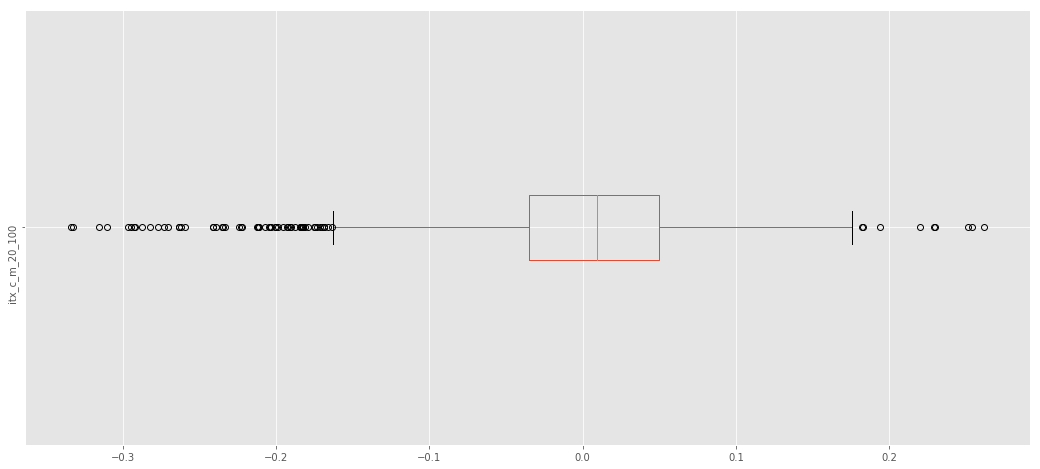

 el valor de 01p es : -0.2119 
 el valor de 05p es : -0.11657 
 el valor de 50p es : 0.009584 
 el valor de 95p es : 0.11679 
 el valor de T-test es : 3.8461 
 el valor de avg es : 0.005 
 el valor de kur es : 1.6859 
 el valor de skw es : -0.63731 
 el valor de std es : 0.072765 
 el valor de val es : -1.0019 
 el valor de var es : 0.0052947 


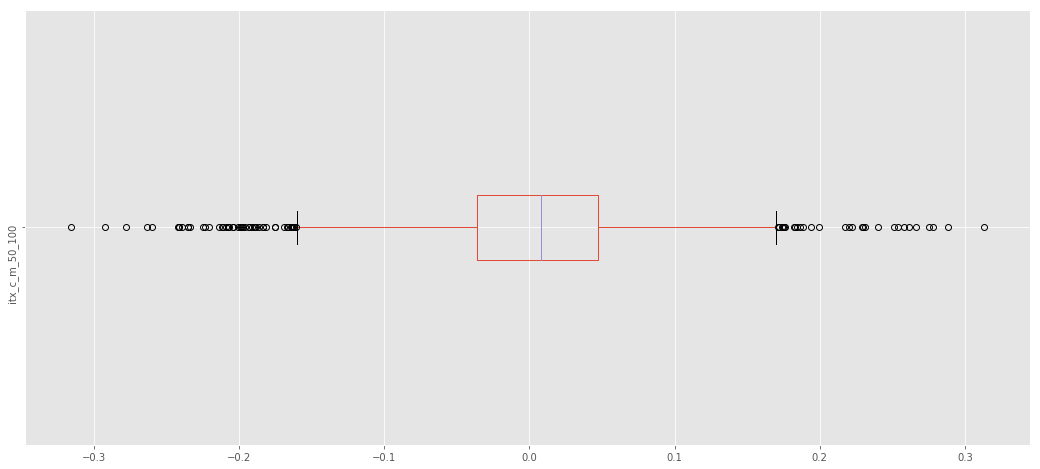

 el valor de 01p es : -0.19819 
 el valor de 05p es : -0.11056 
 el valor de 50p es : 0.0081278 
 el valor de 95p es : 0.11741 
 el valor de T-test es : 4.258 
 el valor de avg es : 0.006 
 el valor de kur es : 1.4595 
 el valor de skw es : -0.19723 
 el valor de std es : 0.070759 
 el valor de val es : -1.062 
 el valor de var es : 0.0050068 


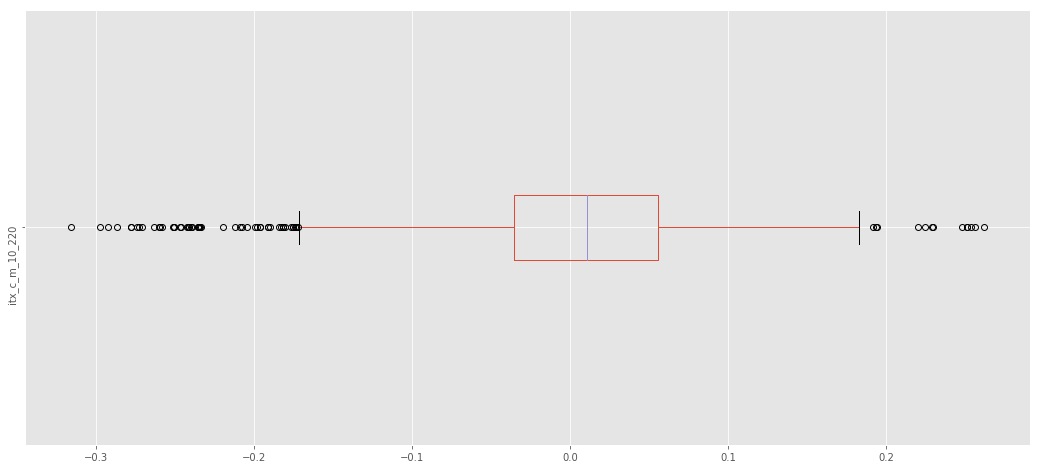

 el valor de 01p es : -0.23491 
 el valor de 05p es : -0.10246 
 el valor de 50p es : 0.010986 
 el valor de 95p es : 0.12484 
 el valor de T-test es : 6.7923 
 el valor de avg es : 0.01 
 el valor de kur es : 1.5401 
 el valor de skw es : -0.46052 
 el valor de std es : 0.073029 
 el valor de val es : -1.2185 
 el valor de var es : 0.0053332 


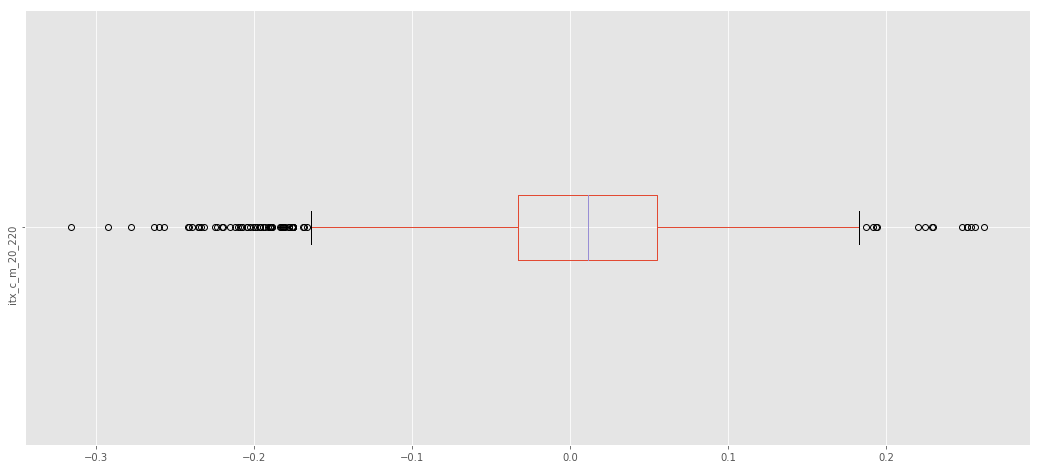

 el valor de 01p es : -0.19954 
 el valor de 05p es : -0.11418 
 el valor de 50p es : 0.011389 
 el valor de 95p es : 0.12555 
 el valor de T-test es : 6.707 
 el valor de avg es : 0.009 
 el valor de kur es : 1.0469 
 el valor de skw es : -0.3765 
 el valor de std es : 0.072918 
 el valor de val es : -1.0996 
 el valor de var es : 0.0053171 


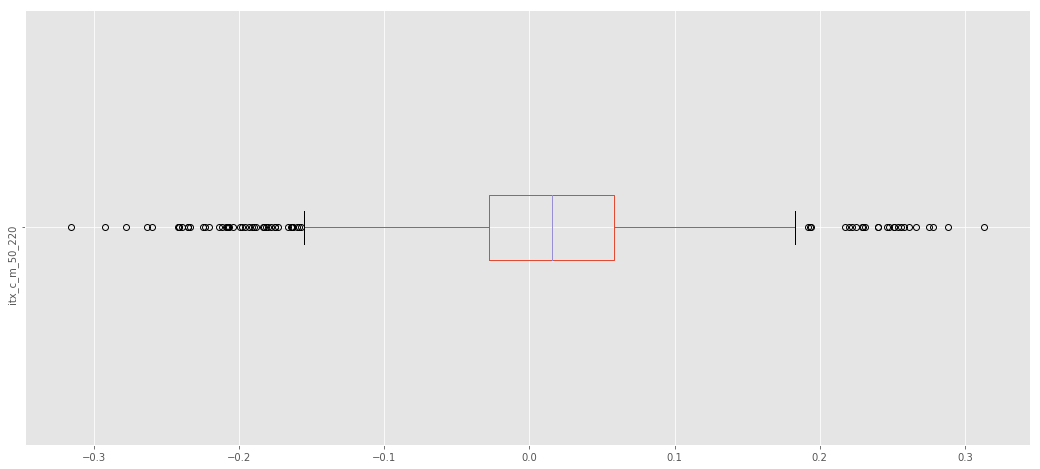

 el valor de 01p es : -0.19142 
 el valor de 05p es : -0.091313 
 el valor de 50p es : 0.015692 
 el valor de 95p es : 0.13037 
 el valor de T-test es : 11.414 
 el valor de avg es : 0.016 
 el valor de kur es : 1.4664 
 el valor de skw es : -0.14343 
 el valor de std es : 0.071276 
 el valor de val es : -1.4278 
 el valor de var es : 0.0050802 


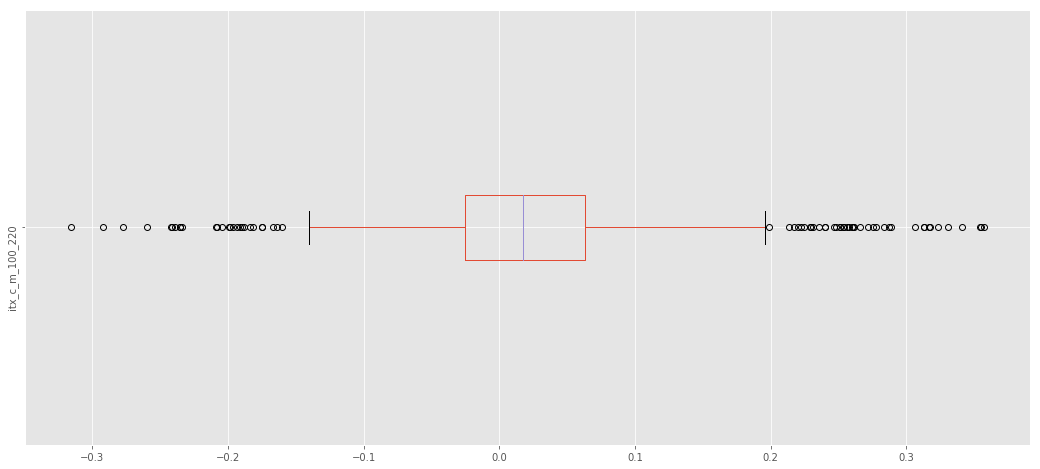

 el valor de 01p es : -0.14351 
 el valor de 05p es : -0.083927 
 el valor de 50p es : 0.017856 
 el valor de 95p es : 0.13642 
 el valor de T-test es : 15.157 
 el valor de avg es : 0.021 
 el valor de kur es : 2.1776 
 el valor de skw es : 0.36453 
 el valor de std es : 0.072563 
 el valor de val es : -1.6255 
 el valor de var es : 0.0052653 


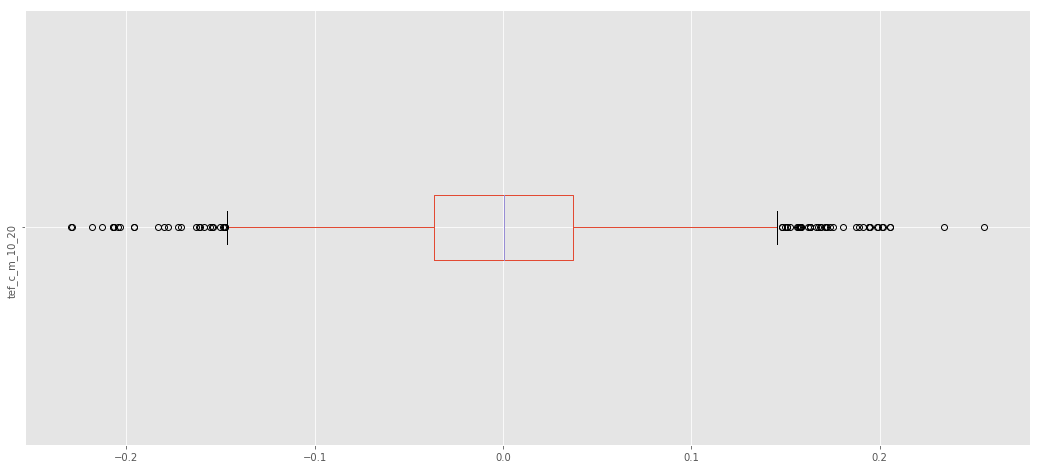

 el valor de 01p es : -0.14743 
 el valor de 05p es : -0.09849 
 el valor de 50p es : 0.00061619 
 el valor de 95p es : 0.1098 
 el valor de T-test es : 1.1992 
 el valor de avg es : 0.001 
 el valor de kur es : 0.72704 
 el valor de skw es : 0.12495 
 el valor de std es : 0.062419 
 el valor de val es : -1.1149 
 el valor de var es : 0.0038961 


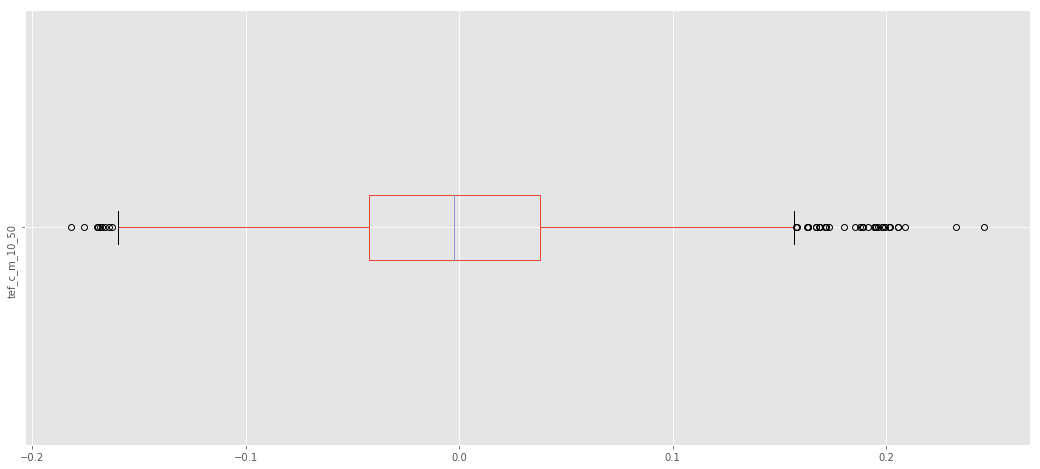

 el valor de 01p es : -0.14203 
 el valor de 05p es : -0.10465 
 el valor de 50p es : -0.002469 
 el valor de 95p es : 0.10704 
 el valor de T-test es : -1.1339 
 el valor de avg es : -0.001 
 el valor de kur es : 0.33307 
 el valor de skw es : 0.21701 
 el valor de std es : 0.063379 
 el valor de val es : -1.0228 
 el valor de var es : 0.0040169 


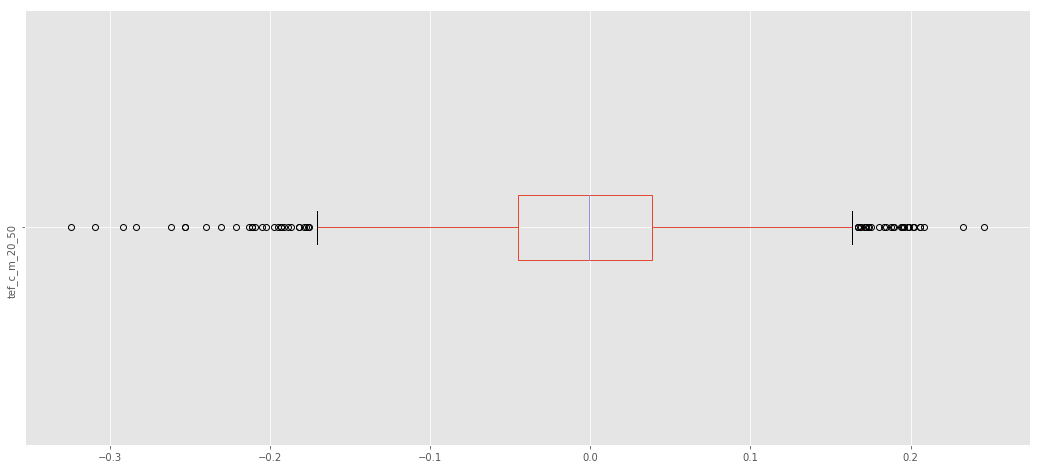

 el valor de 01p es : -0.17653 
 el valor de 05p es : -0.1213 
 el valor de 50p es : -0.00074326 
 el valor de 95p es : 0.11202 
 el valor de T-test es : -2.4757 
 el valor de avg es : -0.003 
 el valor de kur es : 0.85528 
 el valor de skw es : -0.13198 
 el valor de std es : 0.070083 
 el valor de val es : -0.92353 
 el valor de var es : 0.0049116 


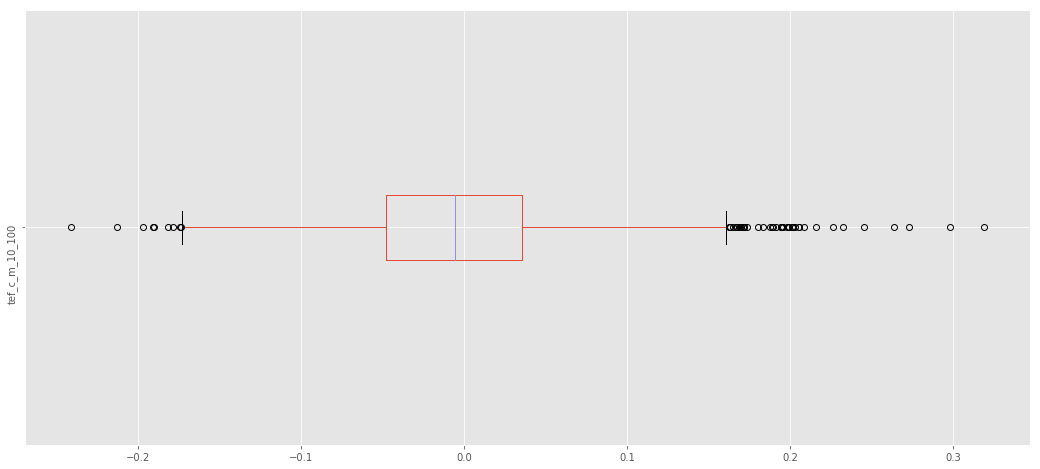

 el valor de 01p es : -0.13978 
 el valor de 05p es : -0.10217 
 el valor de 50p es : -0.0055503 
 el valor de 95p es : 0.11373 
 el valor de T-test es : -1.7636 
 el valor de avg es : -0.002 
 el valor de kur es : 0.83871 
 el valor de skw es : 0.46262 
 el valor de std es : 0.065829 
 el valor de val es : -1.1132 
 el valor de var es : 0.0043335 


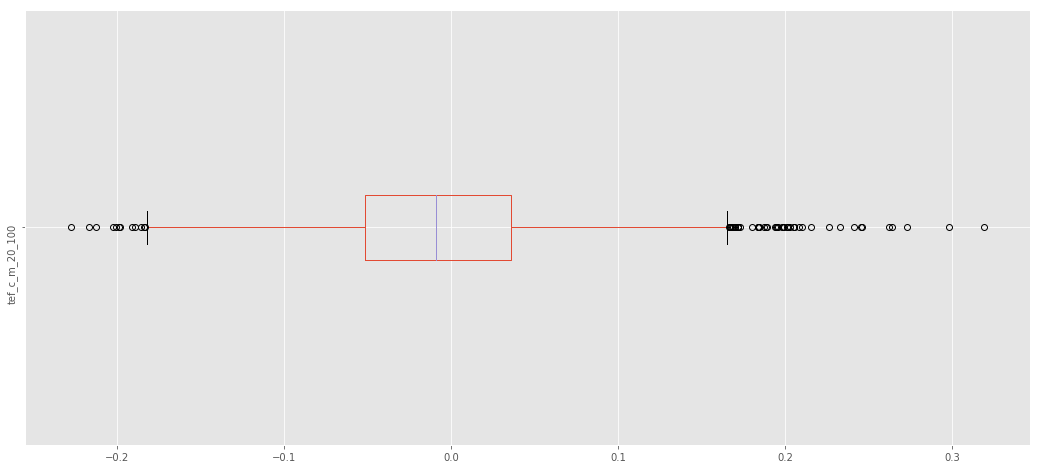

 el valor de 01p es : -0.16016 
 el valor de 05p es : -0.11546 
 el valor de 50p es : -0.0087576 
 el valor de 95p es : 0.11825 
 el valor de T-test es : -3.873 
 el valor de avg es : -0.005 
 el valor de kur es : 0.74564 
 el valor de skw es : 0.37394 
 el valor de std es : 0.070613 
 el valor de val es : -1.0242 
 el valor de var es : 0.0049862 


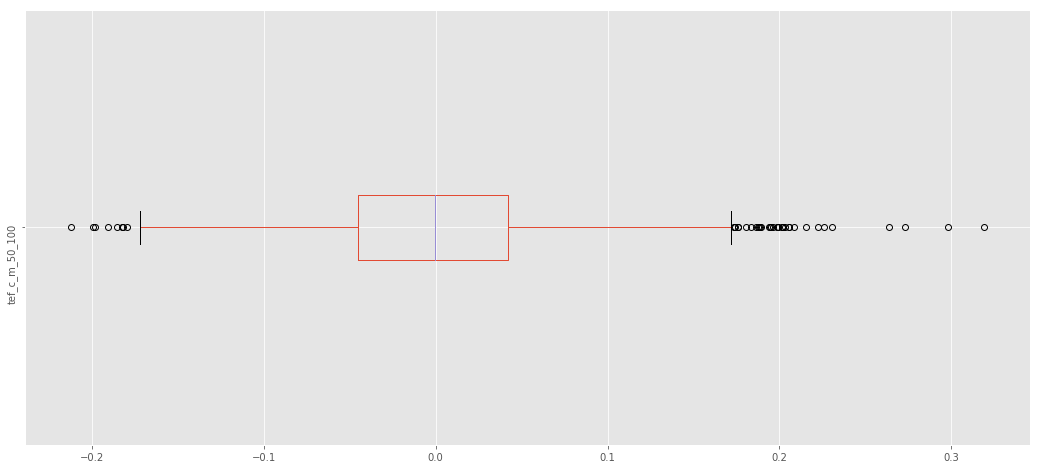

 el valor de 01p es : -0.1441 
 el valor de 05p es : -0.10282 
 el valor de 50p es : -0.00046556 
 el valor de 95p es : 0.12096 
 el valor de T-test es : 1.5699 
 el valor de avg es : 0.002 
 el valor de kur es : 0.48484 
 el valor de skw es : 0.34815 
 el valor de std es : 0.068436 
 el valor de val es : -1.1763 
 el valor de var es : 0.0046834 


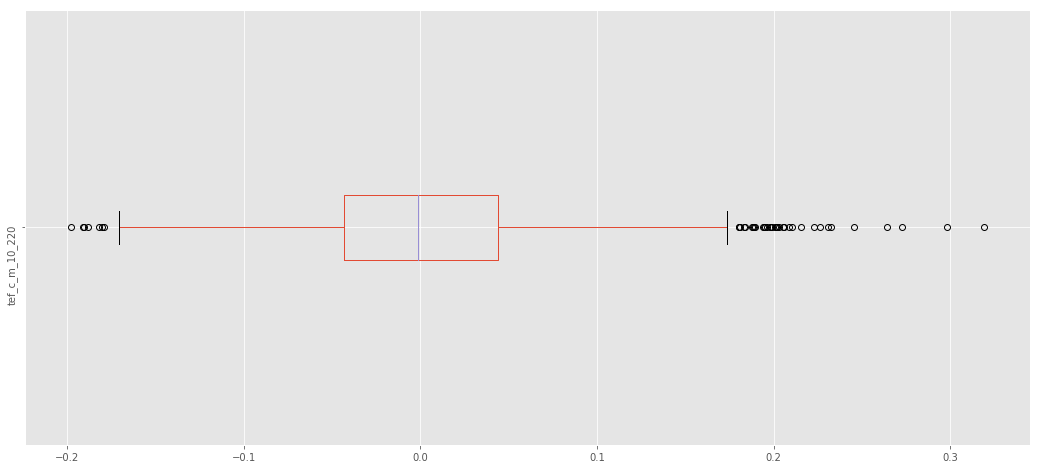

 el valor de 01p es : -0.14206 
 el valor de 05p es : -0.099719 
 el valor de 50p es : -0.0013035 
 el valor de 95p es : 0.12356 
 el valor de T-test es : 2.153 
 el valor de avg es : 0.003 
 el valor de kur es : 0.52325 
 el valor de skw es : 0.41976 
 el valor de std es : 0.068912 
 el valor de val es : -1.2391 
 el valor de var es : 0.0047488 


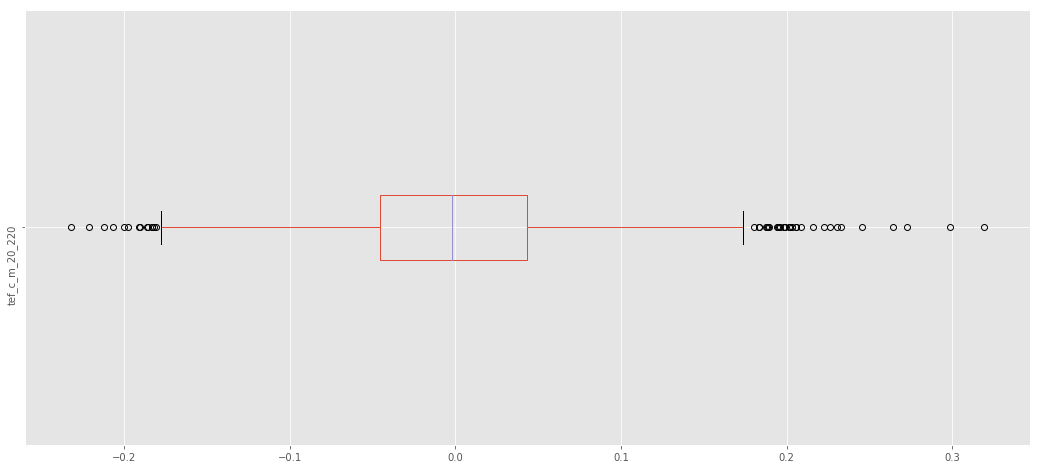

 el valor de 01p es : -0.16074 
 el valor de 05p es : -0.10798 
 el valor de 50p es : -0.0017859 
 el valor de 95p es : 0.12132 
 el valor de T-test es : 0.26284 
 el valor de avg es : 0.0 
 el valor de kur es : 0.52248 
 el valor de skw es : 0.26043 
 el valor de std es : 0.070922 
 el valor de val es : -1.1236 
 el valor de var es : 0.0050299 


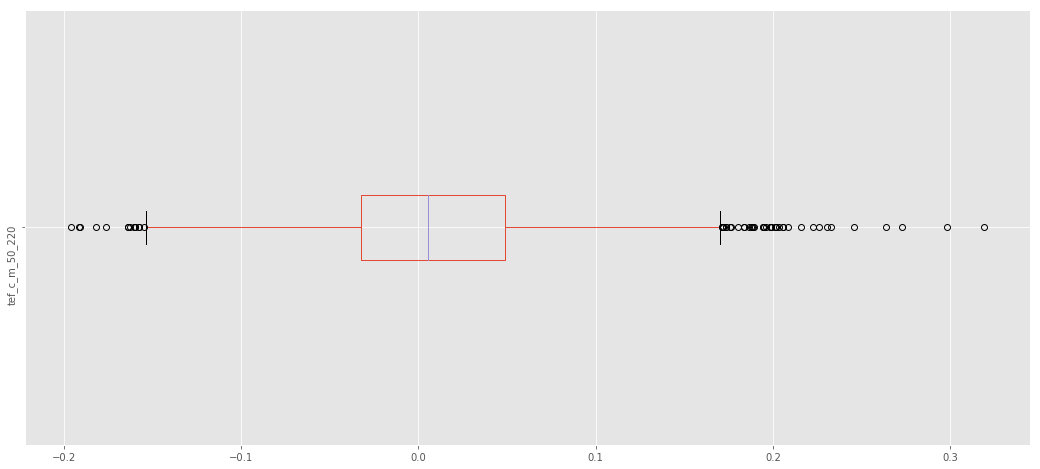

 el valor de 01p es : -0.14112 
 el valor de 05p es : -0.096947 
 el valor de 50p es : 0.0051873 
 el valor de 95p es : 0.12696 
 el valor de T-test es : 7.1598 
 el valor de avg es : 0.009 
 el valor de kur es : 0.56157 
 el valor de skw es : 0.3419 
 el valor de std es : 0.067627 
 el valor de val es : -1.3096 
 el valor de var es : 0.0045734 


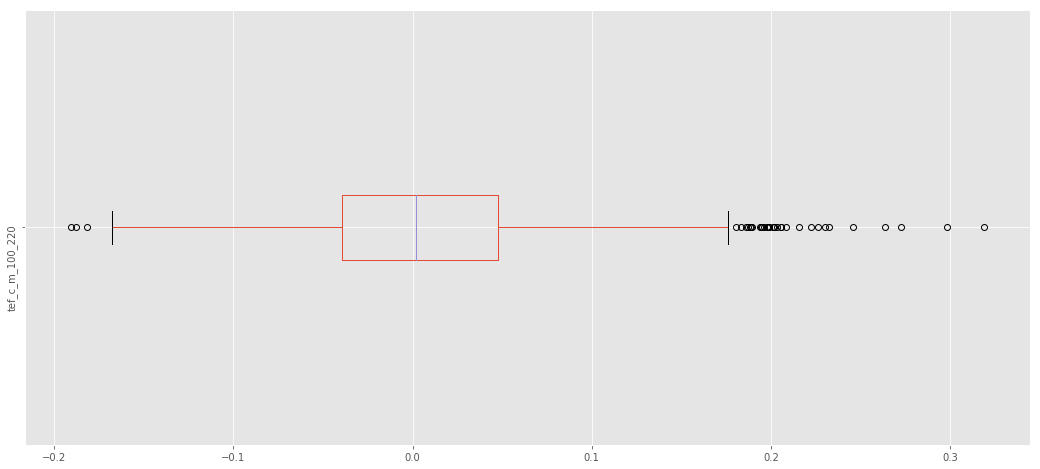

 el valor de 01p es : -0.14007 
 el valor de 05p es : -0.10102 
 el valor de 50p es : 0.0016498 
 el valor de 95p es : 0.12174 
 el valor de T-test es : 4.1304 
 el valor de avg es : 0.005 
 el valor de kur es : 0.4529 
 el valor de skw es : 0.37897 
 el valor de std es : 0.068385 
 el valor de val es : -1.2051 
 el valor de var es : 0.0046766 


In [55]:
#ccoco=f.filter(like='_cruce_medias',axis=1).columns.values
var95histmedias={}
for n in seleccion:
    valor="{}".format(n)
    #soso.append(n)
    #printsoso
    var95histmedias[valor]=calculate_aggregate(g[valor].pct_change(20),False)

<h4>Tabla de comportamiento var95 de cada sistema</h4>

In [56]:
fofo=pd.DataFrame(var95histmedias)
np.round(fofo.T,3)

01p    05p    50p    95p  T-test    avg    kur    skw  \
san_c_m_10_20   -0.204 -0.138 -0.013  0.154  -2.489 -0.004  1.208  0.524   
san_c_m_10_50   -0.253 -0.128 -0.003  0.173   3.857  0.007  3.037  0.592   
san_c_m_20_50   -0.248 -0.128  0.006  0.175   7.542  0.015  3.415  0.722   
san_c_m_10_100  -0.213 -0.141  0.002  0.166   5.049  0.009  2.298  0.626   
san_c_m_20_100  -0.241 -0.129  0.006  0.169   7.094  0.013  2.641  0.454   
san_c_m_50_100  -0.219 -0.143  0.001  0.166   4.024  0.008  2.224  0.581   
san_c_m_10_220  -0.211 -0.140 -0.002  0.166   2.956  0.006  2.199  0.676   
san_c_m_20_220  -0.216 -0.144  0.004  0.166   4.771  0.009  2.232  0.577   
san_c_m_50_220  -0.209 -0.131  0.010  0.163   7.591  0.014  2.654  0.600   
san_c_m_100_220 -0.215 -0.139  0.002  0.159   2.293  0.004  3.057  0.773   
itx_c_m_10_20   -0.191 -0.123 -0.007  0.114  -4.536 -0.006  0.595 -0.015   
itx_c_m_10_50   -0.215 -0.119  0.008  0.115   2.481  0.003  1.039 -0.447   
itx_c_m_20_50   -0.179 -0.108  0.007  0.114   3.706  0.005  0.613 -0.240   
itx_c_m_10_100  -0.228 -0.119  0.010  0.117   3.383  0.005  1.253 -0.587   
itx_c_m_20_100  -0.212 -0.117  0.010  0.117   3.846  0.005  1.686 -0.637   
itx_c_m_50_100  -0.198 -0.111  0.008  0.117   4.258  0.006  1.459 -0.197   
itx_c_m_10_220  -0.235 -0.102  0.011  0.125   6.792  0.010  1.540 -0.461   
itx_c_m_20_220  -0.200 -0.114  0.011  0.126   6.707  0.009  1.047 -0.377   
itx_c_m_50_220  -0.191 -0.091  0.016  0.130  11.414  0.016  1.466 -0.143   
itx_c_m_100_220 -0.144 -0.084  0.018  0.136  15.157  0.021  2.178  0.365   
tef_c_m_10_20   -0.147 -0.098  0.001  0.110   1.199  0.001  0.727  0.125   
tef_c_m_10_50   -0.142 -0.105 -0.002  0.107  -1.134 -0.001  0.333  0.217   
tef_c_m_20_50   -0.177 -0.121 -0.001  0.112  -2.476 -0.003  0.855 -0.132   
tef_c_m_10_100  -0.140 -0.102 -0.006  0.114  -1.764 -0.002  0.839  0.463   
tef_c_m_20_100  -0.160 -0.115 -0.009  0.118  -3.873 -0.005  0.746  0.374   
tef_c_m_50_100  -0.144 -0.103 -0.000  0.121   1.570  0.002  0.485  0.348   
tef_c_m_10_220  -0.142 -0.100 -0.001  0.124   2.153  0.003  0.523  0.420   
tef_c_m_20_220  -0.161 -0.108 -0.002  0.121   0.263  0.000  0.522  0.260   
tef_c_m_50_220  -0.141 -0.097  0.005  0.127   7.160  0.009  0.562  0.342   
tef_c_m_100_220 -0.140 -0.101  0.002  0.122   4.130  0.005  0.453  0.379   

                   std    val    var  
san_c_m_10_20    0.090 -1.121  0.008  
san_c_m_10_50    0.099 -1.355  0.010  
san_c_m_20_50    0.101 -1.366  0.010  
san_c_m_10_100   0.098 -1.178  0.010  
san_c_m_20_100   0.098 -1.308  0.010  
san_c_m_50_100   0.099 -1.159  0.010  
san_c_m_10_220   0.099 -1.189  0.010  
san_c_m_20_220   0.099 -1.157  0.010  
san_c_m_50_220   0.095 -1.242  0.009  
san_c_m_100_220  0.097 -1.140  0.009  
itx_c_m_10_20    0.074 -0.929  0.005  
itx_c_m_10_50    0.073 -0.972  0.005  
itx_c_m_20_50    0.068 -1.056  0.005  
itx_c_m_10_100   0.073 -0.979  0.005  
itx_c_m_20_100   0.073 -1.002  0.005  
itx_c_m_50_100   0.071 -1.062  0.005  
itx_c_m_10_220   0.073 -1.218  0.005  
itx_c_m_20_220   0.073 -1.100  0.005  
itx_c_m_50_220   0.071 -1.428  0.005  
itx_c_m_100_220  0.073 -1.625  0.005  
tef_c_m_10_20    0.062 -1.115  0.004  
tef_c_m_10_50    0.063 -1.023  0.004  
tef_c_m_20_50    0.070 -0.924  0.005  
tef_c_m_10_100   0.066 -1.113  0.004  
tef_c_m_20_100   0.071 -1.024  0.005  
tef_c_m_50_100   0.068 -1.176  0.005  
tef_c_m_10_220   0.069 -1.239  0.005  
tef_c_m_20_220   0.071 -1.124  0.005  
tef_c_m_50_220   0.068 -1.310  0.005  
tef_c_m_100_220  0.068 -1.205  0.005

<p>Si ordenamos las series por el t-test, podemos ver que la confluencia de itx y de las medias mas largas, obtiene los mejores resultados. No obtenemos, ningún var95 > 0, ni menor del -0,05%

<p>Obtenemos las series con t-Test > 4, para ver como se comportan con un límite de pérdida mensual del 10%.

<h4>Gráficos de los sistemas con t-Student > 4</h4>

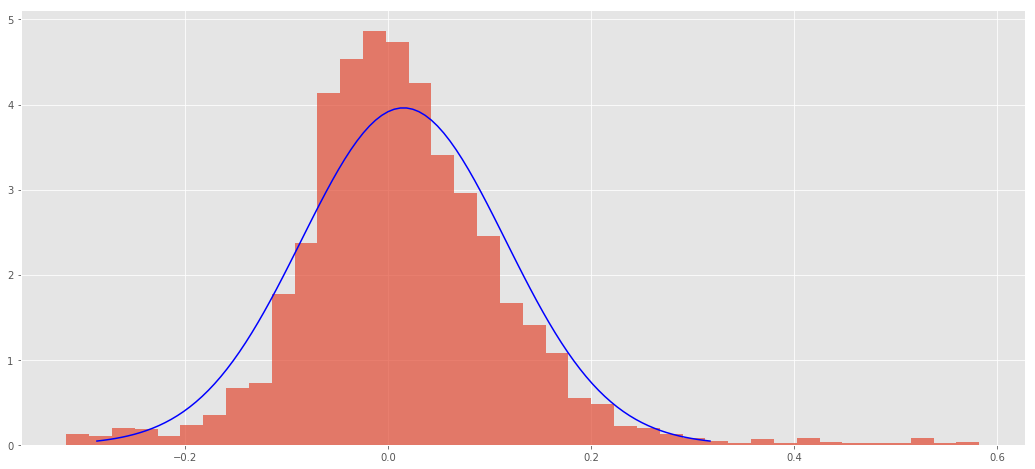

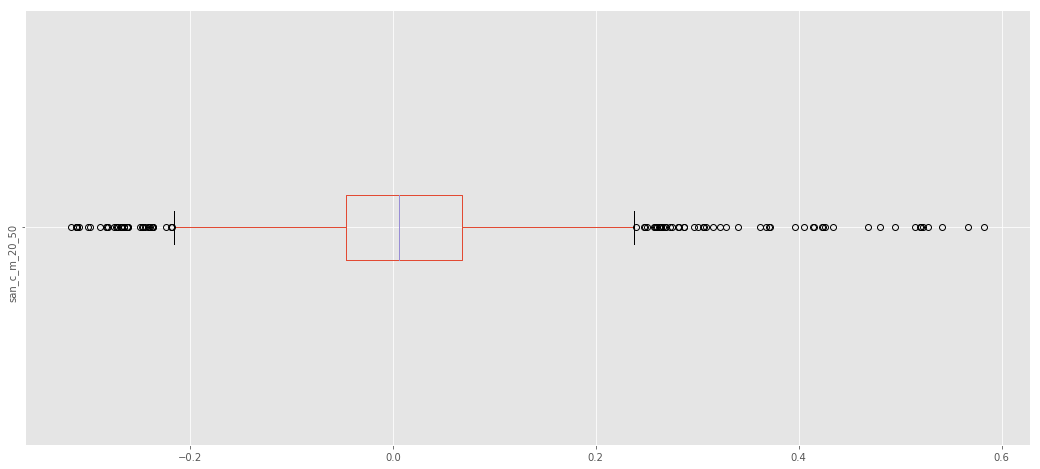

 el valor de 01p es : -0.24757 
 el valor de 05p es : -0.12792 
 el valor de 50p es : 0.0063836 
 el valor de 95p es : 0.17477 
 el valor de T-test es : 7.5418 
 el valor de avg es : 0.015 
 el valor de kur es : 3.4146 
 el valor de skw es : 0.7223 
 el valor de std es : 0.10072 
 el valor de val es : -1.3662 
 el valor de var es : 0.010145 


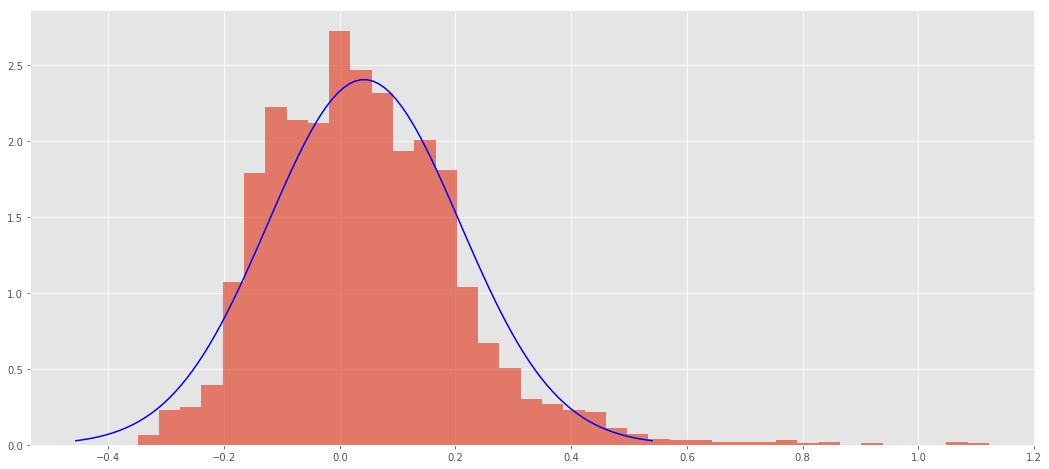

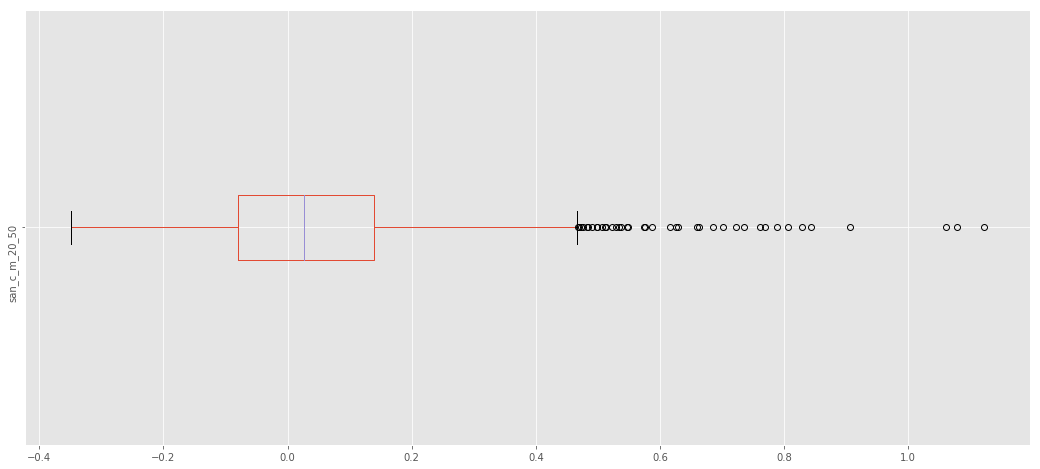

 el valor de 01p es : -0.27726 
 el valor de 05p es : -0.18307 
 el valor de 50p es : 0.026987 
 el valor de 95p es : 0.32533 
 el valor de T-test es : 13.136 
 el valor de avg es : 0.042 
 el valor de kur es : 3.0584 
 el valor de skw es : 1.0209 
 el valor de std es : 0.16602 
 el valor de val es : -1.7771 
 el valor de var es : 0.027562 


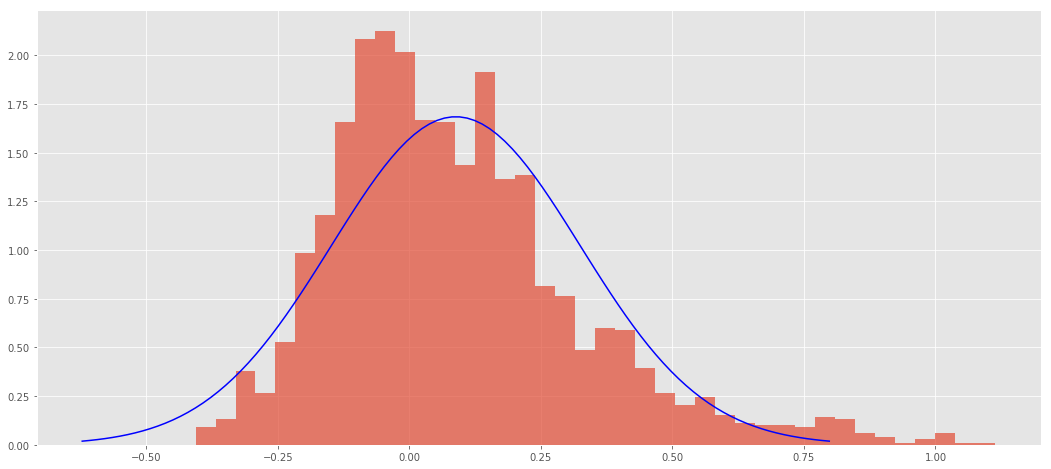

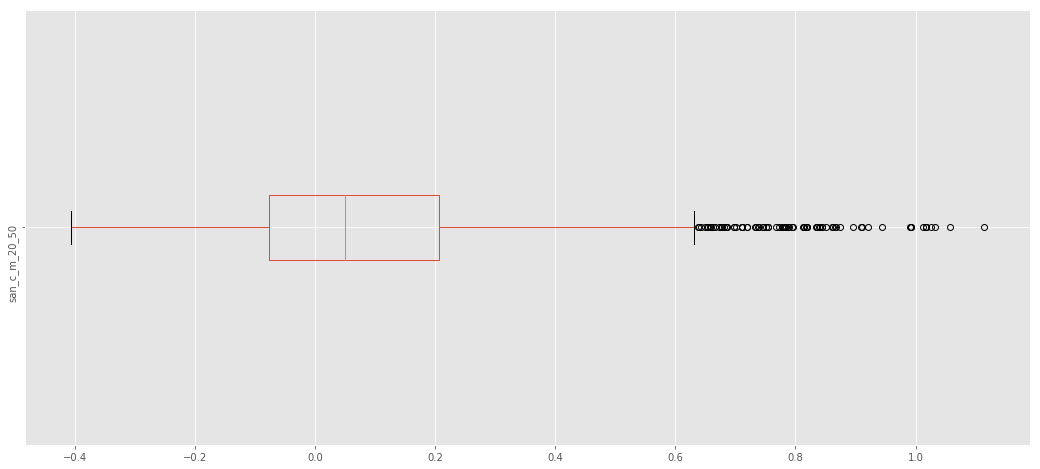

 el valor de 01p es : -0.32664 
 el valor de 05p es : -0.22035 
 el valor de 50p es : 0.049698 
 el valor de 95p es : 0.53637 
 el valor de T-test es : 19.288 
 el valor de avg es : 0.088 
 el valor de kur es : 1.4495 
 el valor de skw es : 1.0045 
 el valor de std es : 0.23672 
 el valor de val es : -2.4342 
 el valor de var es : 0.056034 


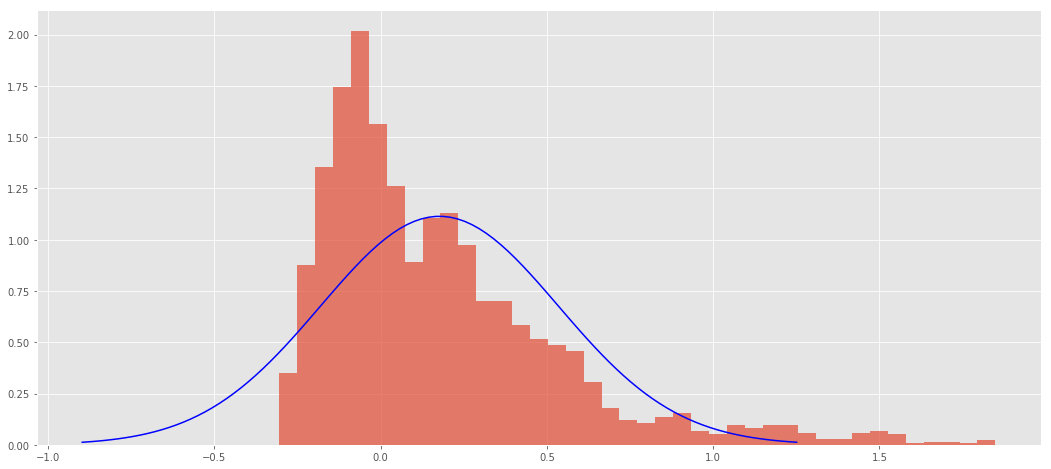

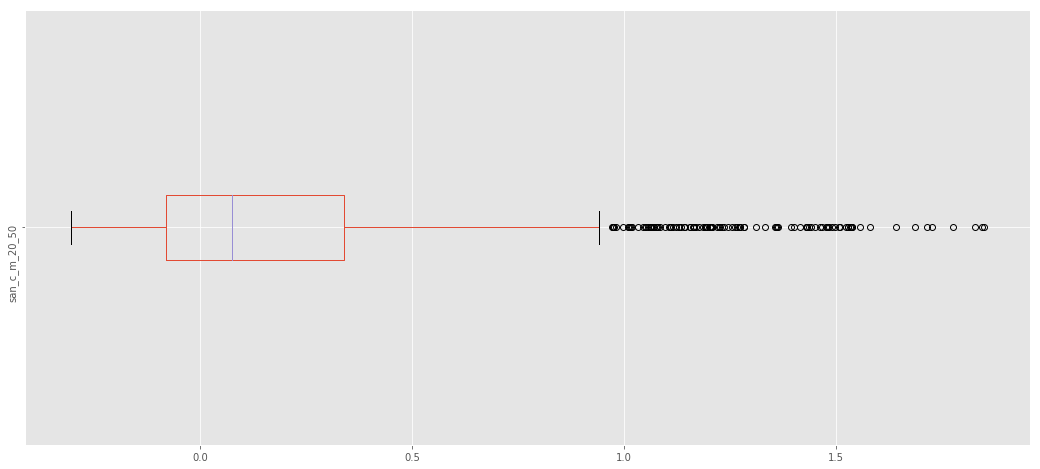

 el valor de 01p es : -0.26149 
 el valor de 05p es : -0.21068 
 el valor de 50p es : 0.076523 
 el valor de 95p es : 0.90958 
 el valor de T-test es : 25.692 
 el valor de avg es : 0.177 
 el valor de kur es : 2.8313 
 el valor de skw es : 1.5473 
 el valor de std es : 0.35801 
 el valor de val es : -4.3173 
 el valor de var es : 0.12817 


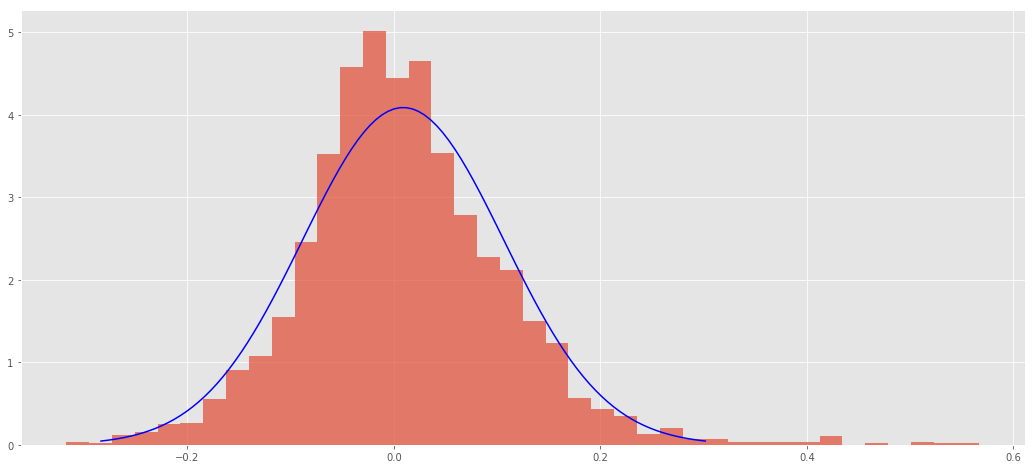

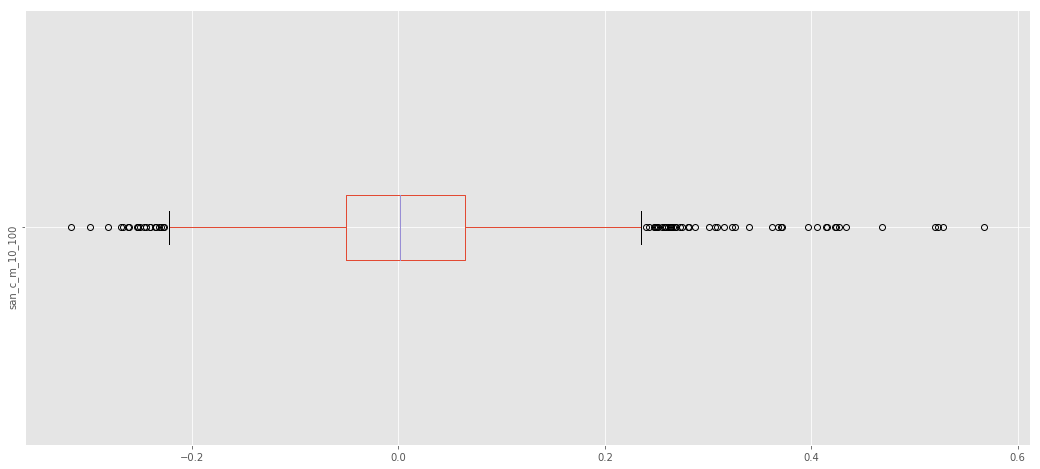

 el valor de 01p es : -0.21286 
 el valor de 05p es : -0.14101 
 el valor de 50p es : 0.0019825 
 el valor de 95p es : 0.16613 
 el valor de T-test es : 5.0494 
 el valor de avg es : 0.009 
 el valor de kur es : 2.2979 
 el valor de skw es : 0.62601 
 el valor de std es : 0.097574 
 el valor de val es : -1.1782 
 el valor de var es : 0.0095207 


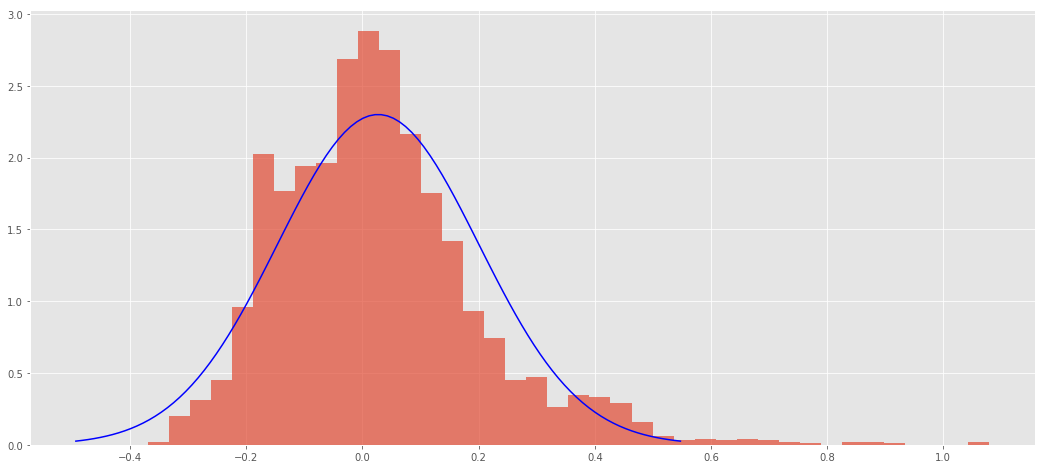

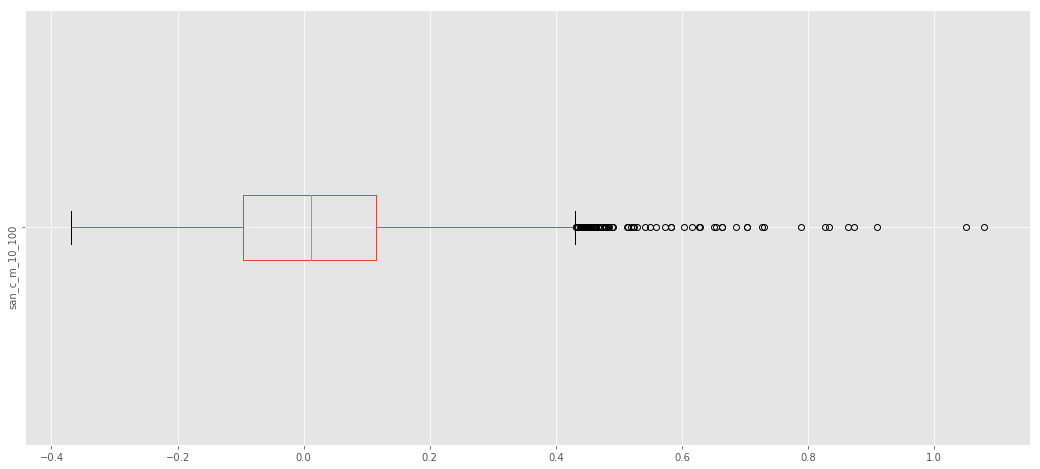

 el valor de 01p es : -0.28153 
 el valor de 05p es : -0.20732 
 el valor de 50p es : 0.011219 
 el valor de 95p es : 0.36077 
 el valor de T-test es : 8.0451 
 el valor de avg es : 0.027 
 el valor de kur es : 2.5058 
 el valor de skw es : 1.0522 
 el valor de std es : 0.17348 
 el valor de val es : -1.7401 
 el valor de var es : 0.030096 


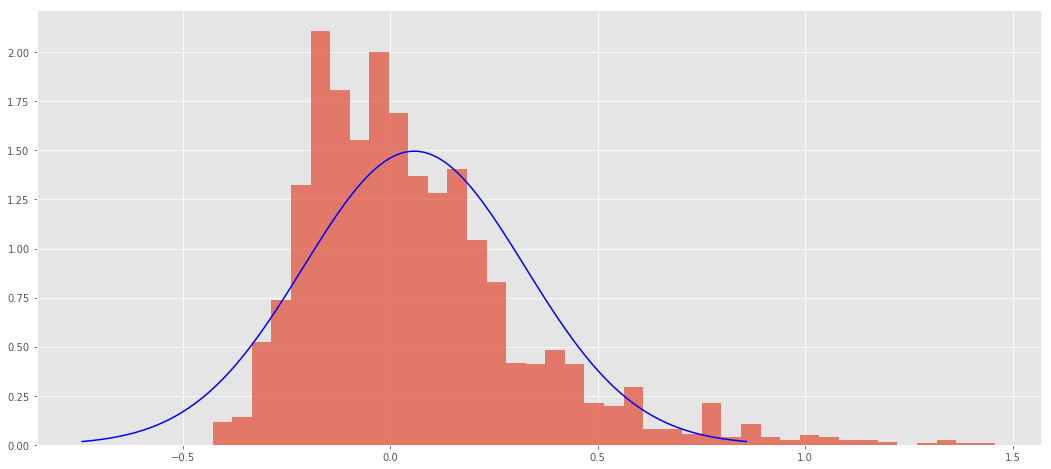

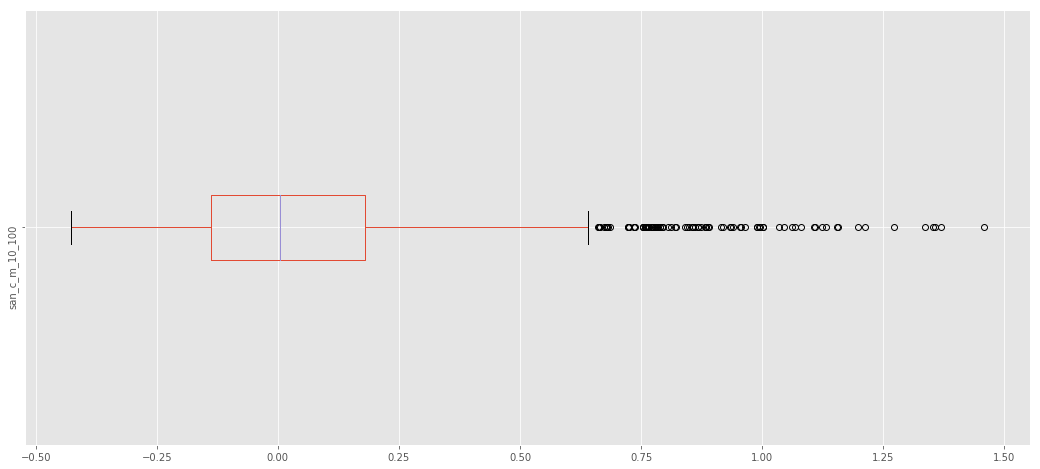

 el valor de 01p es : -0.34544 
 el valor de 05p es : -0.26481 
 el valor de 50p es : 0.0049006 
 el valor de 95p es : 0.57539 
 el valor de T-test es : 11.224 
 el valor de avg es : 0.058 
 el valor de kur es : 2.687 
 el valor de skw es : 1.3583 
 el valor de std es : 0.26664 
 el valor de val es : -2.1729 
 el valor de var es : 0.071094 


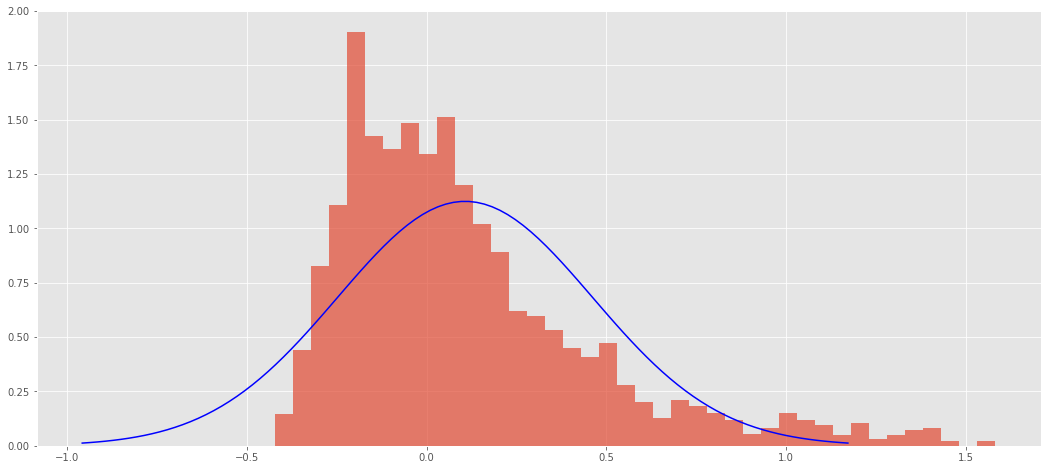

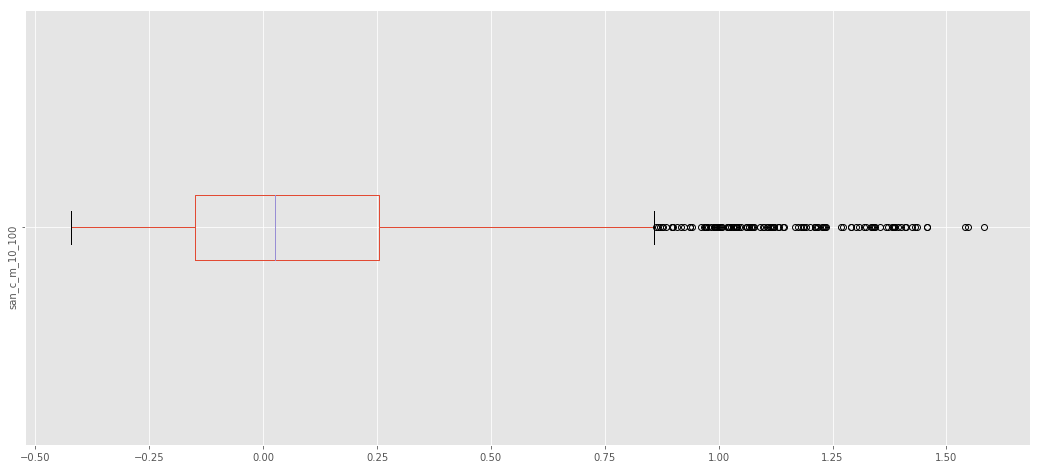

 el valor de 01p es : -0.3608 
 el valor de 05p es : -0.29745 
 el valor de 50p es : 0.026368 
 el valor de 95p es : 0.85607 
 el valor de T-test es : 15.678 
 el valor de avg es : 0.107 
 el valor de kur es : 2.0568 
 el valor de skw es : 1.4021 
 el valor de std es : 0.355 
 el valor de val es : -2.878 
 el valor de var es : 0.12603 


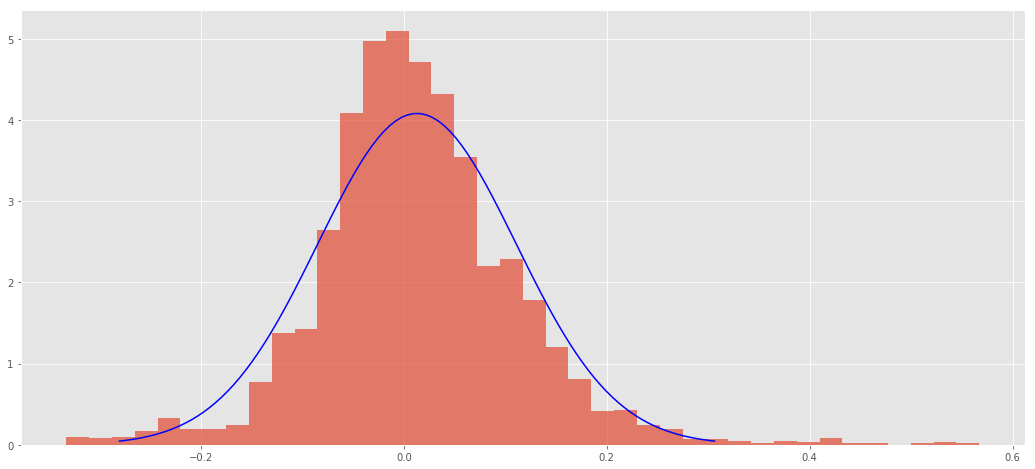

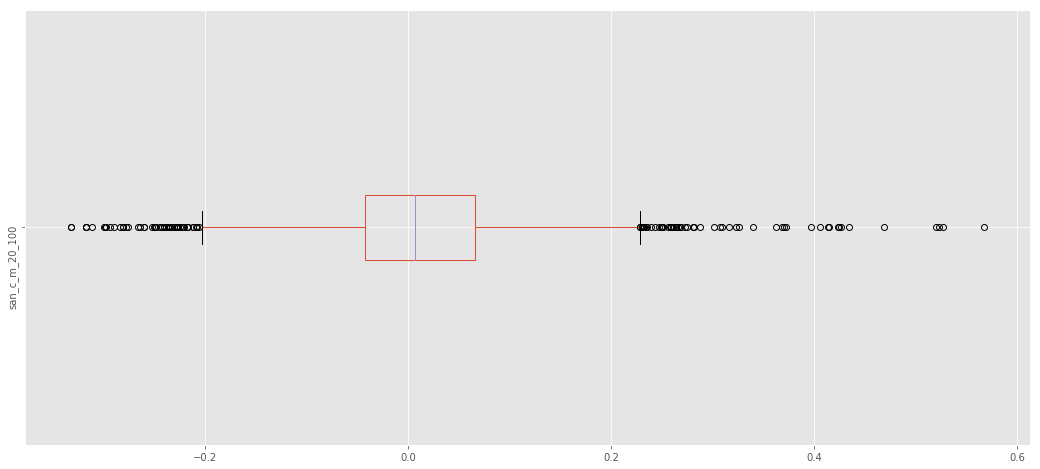

 el valor de 01p es : -0.24122 
 el valor de 05p es : -0.12929 
 el valor de 50p es : 0.0064542 
 el valor de 95p es : 0.16917 
 el valor de T-test es : 7.0937 
 el valor de avg es : 0.013 
 el valor de kur es : 2.6409 
 el valor de skw es : 0.45358 
 el valor de std es : 0.097745 
 el valor de val es : -1.3084 
 el valor de var es : 0.0095541 


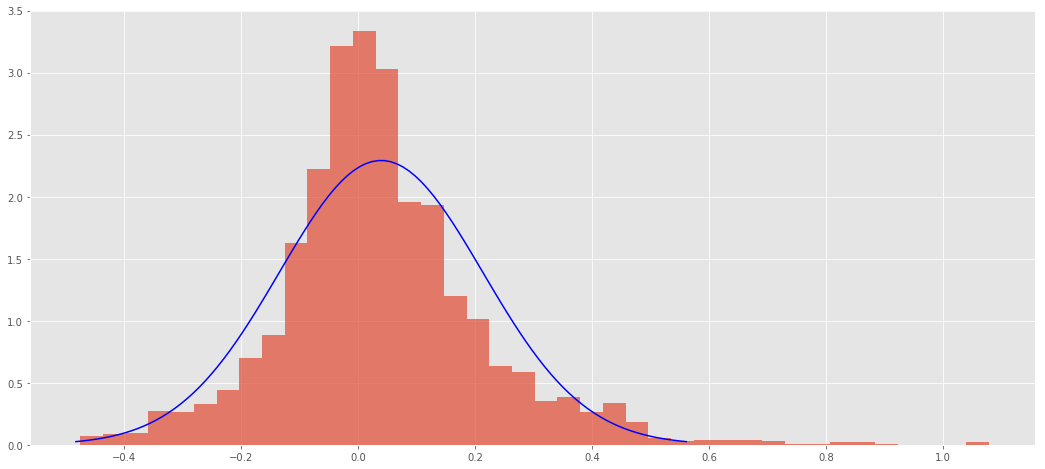

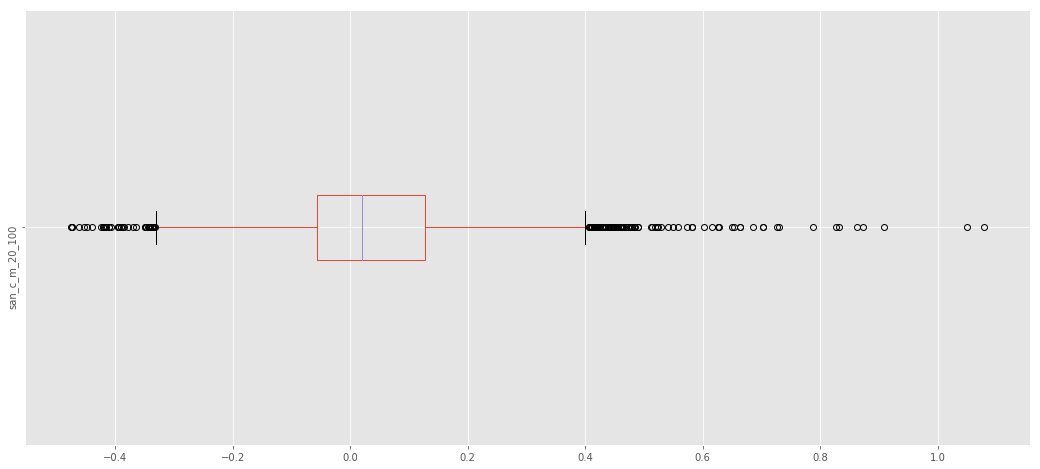

 el valor de 01p es : -0.34928 
 el valor de 05p es : -0.22804 
 el valor de 50p es : 0.020854 
 el valor de 95p es : 0.36344 
 el valor de T-test es : 11.675 
 el valor de avg es : 0.039 
 el valor de kur es : 2.6635 
 el valor de skw es : 0.75756 
 el valor de std es : 0.17403 
 el valor de val es : -1.5938 
 el valor de var es : 0.030286 


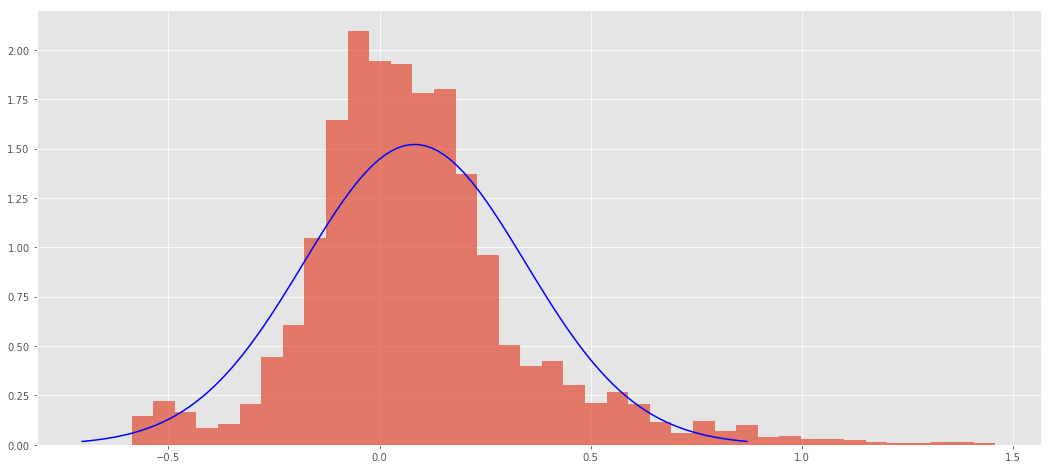

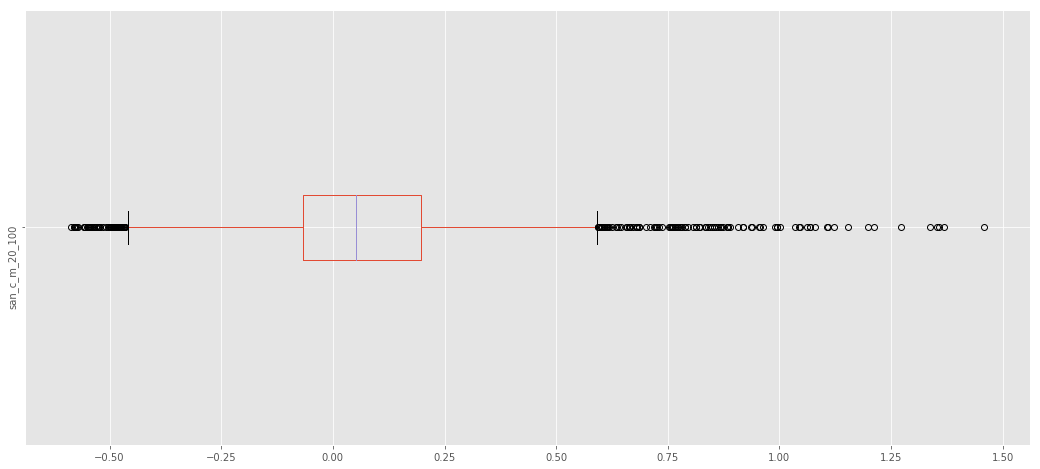

 el valor de 01p es : -0.52496 
 el valor de 05p es : -0.27191 
 el valor de 50p es : 0.051863 
 el valor de 95p es : 0.57263 
 el valor de T-test es : 16.525 
 el valor de avg es : 0.083 
 el valor de kur es : 2.8236 
 el valor de skw es : 0.95673 
 el valor de std es : 0.26231 
 el valor de val es : -2.106 
 el valor de var es : 0.068805 


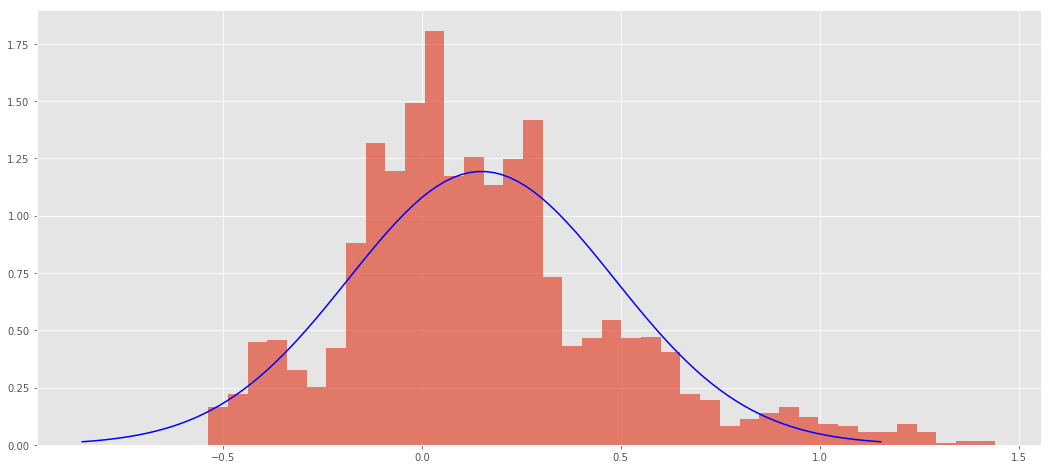

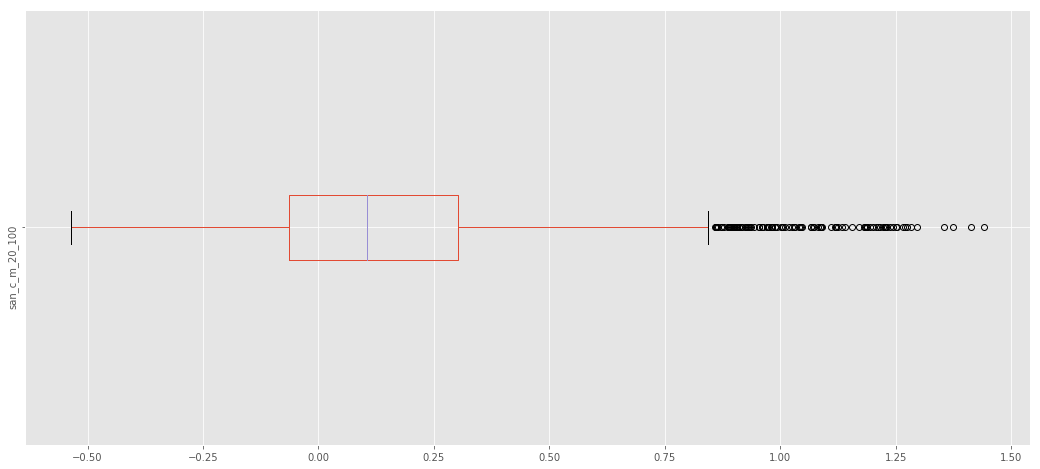

 el valor de 01p es : -0.47686 
 el valor de 05p es : -0.36901 
 el valor de 50p es : 0.10447 
 el valor de 95p es : 0.79599 
 el valor de T-test es : 23.31 
 el valor de avg es : 0.15 
 el valor de kur es : 0.94796 
 el valor de skw es : 0.77558 
 el valor de std es : 0.33434 
 el valor de val es : -2.1571 
 el valor de var es : 0.11178 


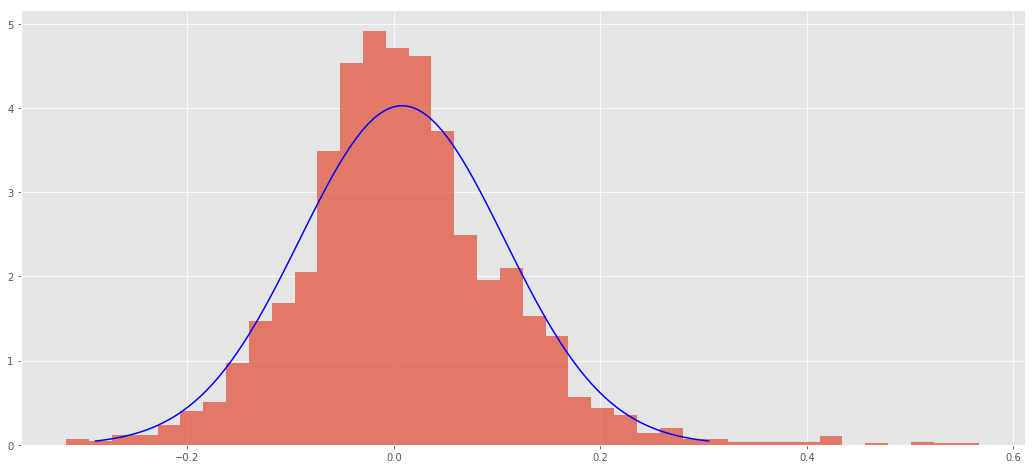

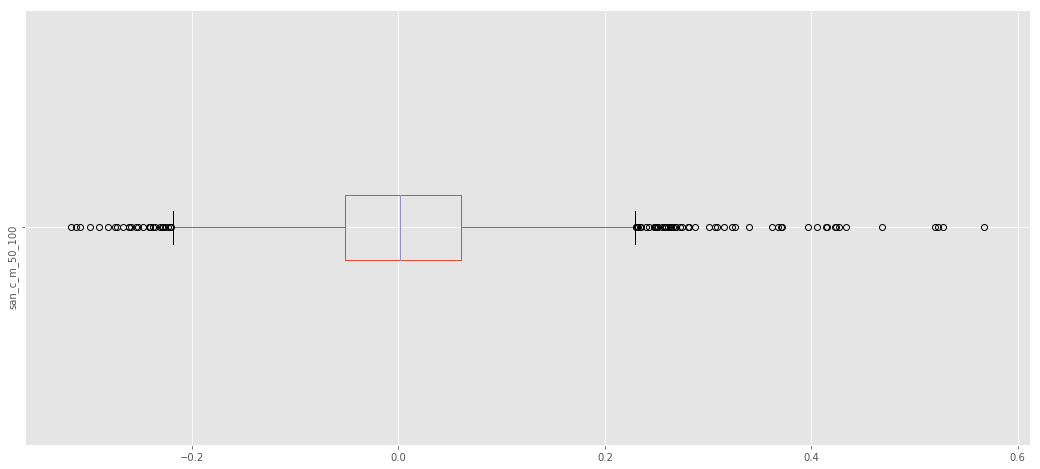

 el valor de 01p es : -0.21856 
 el valor de 05p es : -0.14349 
 el valor de 50p es : 0.0012615 
 el valor de 95p es : 0.16636 
 el valor de T-test es : 4.0237 
 el valor de avg es : 0.008 
 el valor de kur es : 2.2243 
 el valor de skw es : 0.58078 
 el valor de std es : 0.099034 
 el valor de val es : -1.1594 
 el valor de var es : 0.0098078 


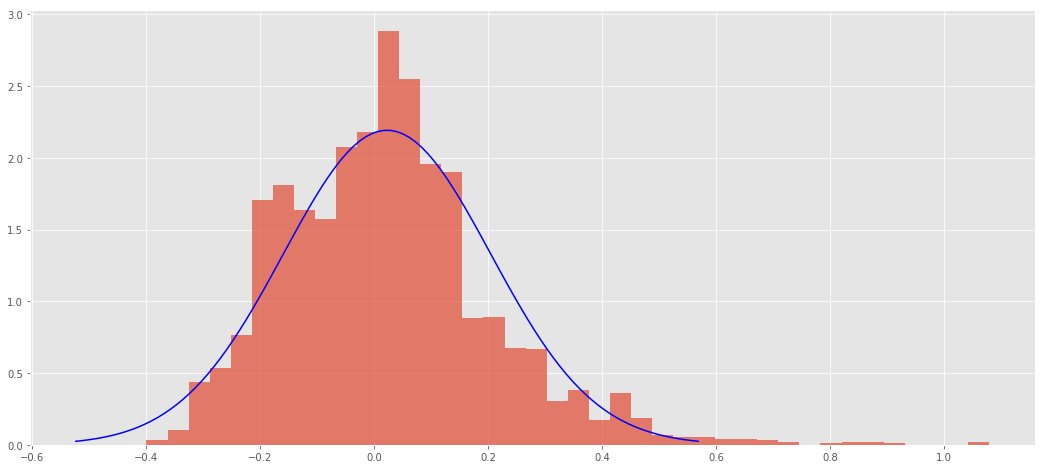

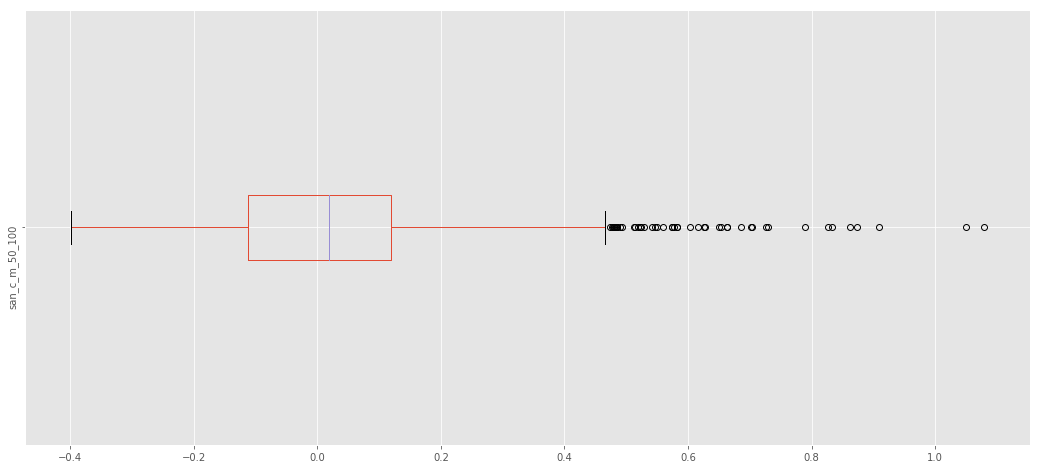

 el valor de 01p es : -0.3096 
 el valor de 05p es : -0.2365 
 el valor de 50p es : 0.018218 
 el valor de 95p es : 0.35336 
 el valor de T-test es : 6.4318 
 el valor de avg es : 0.023 
 el valor de kur es : 1.9348 
 el valor de skw es : 0.8561 
 el valor de std es : 0.18193 
 el valor de val es : -1.4942 
 el valor de var es : 0.033097 


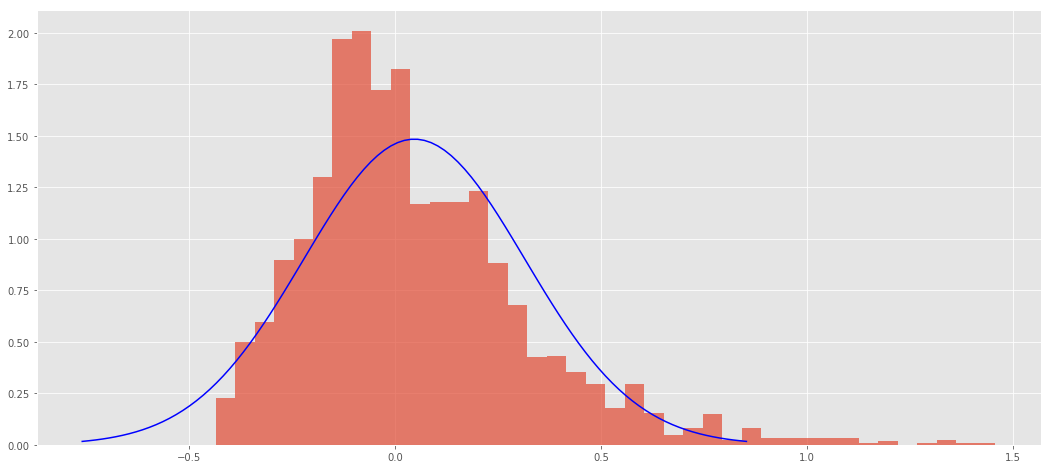

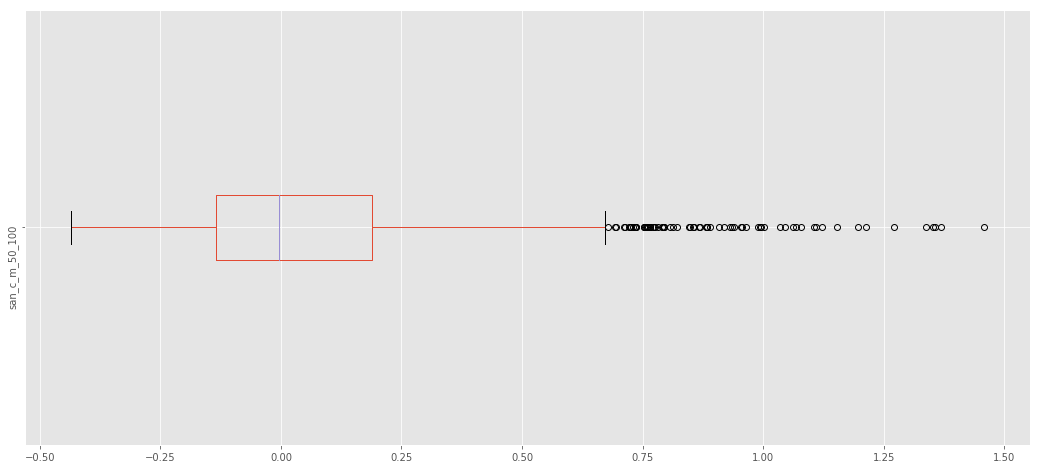

 el valor de 01p es : -0.39023 
 el valor de 05p es : -0.31284 
 el valor de 50p es : -0.003262 
 el valor de 95p es : 0.56036 
 el valor de T-test es : 9.1102 
 el valor de avg es : 0.047 
 el valor de kur es : 2.2889 
 el valor de skw es : 1.1672 
 el valor de std es : 0.2688 
 el valor de val es : -1.7912 
 el valor de var es : 0.072254 


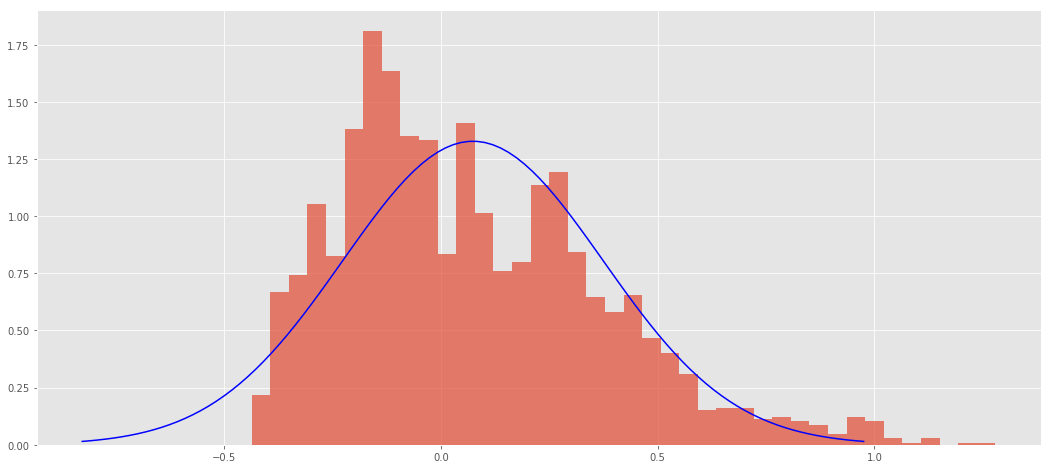

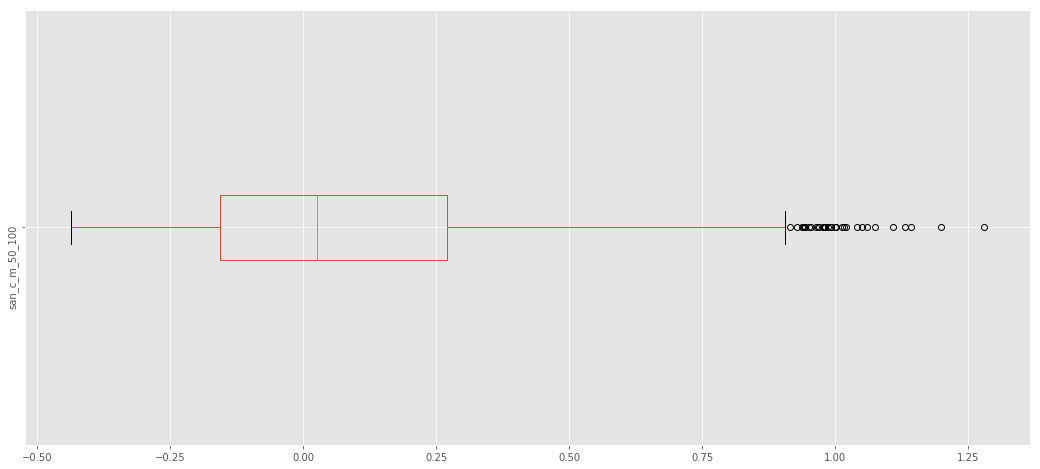

 el valor de 01p es : -0.39072 
 el valor de 05p es : -0.33179 
 el valor de 50p es : 0.026688 
 el valor de 95p es : 0.60755 
 el valor de T-test es : 12.738 
 el valor de avg es : 0.074 
 el valor de kur es : 0.34019 
 el valor de skw es : 0.76191 
 el valor de std es : 0.30043 
 el valor de val es : -1.8311 
 el valor de var es : 0.090258 


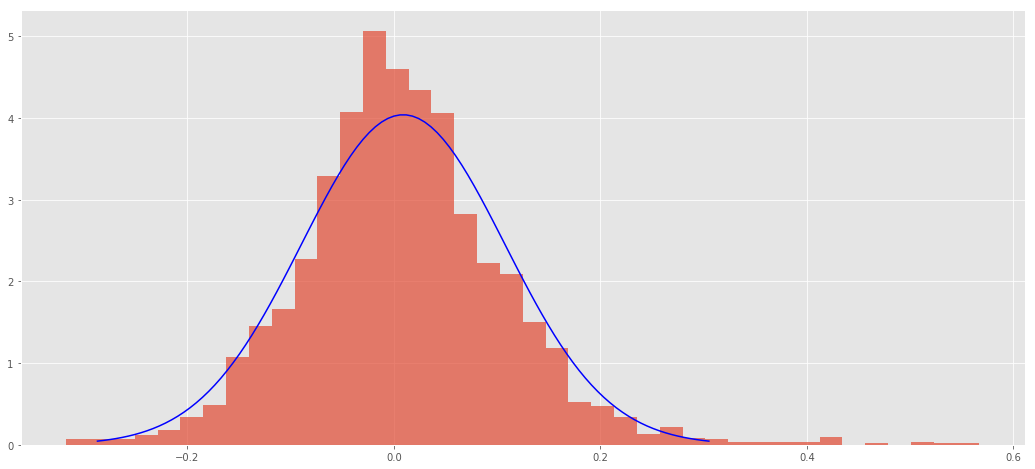

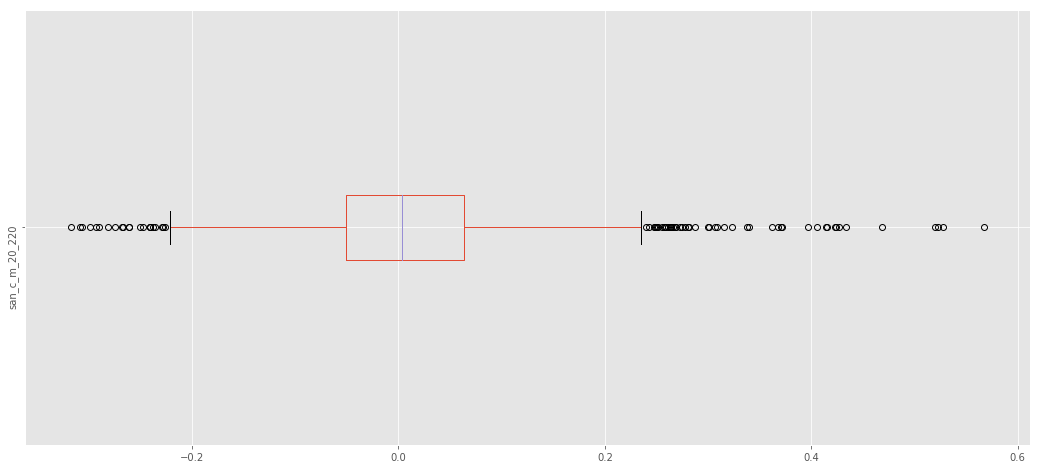

 el valor de 01p es : -0.21583 
 el valor de 05p es : -0.14352 
 el valor de 50p es : 0.0036936 
 el valor de 95p es : 0.16612 
 el valor de T-test es : 4.7708 
 el valor de avg es : 0.009 
 el valor de kur es : 2.232 
 el valor de skw es : 0.5774 
 el valor de std es : 0.098716 
 el valor de val es : -1.1575 
 el valor de var es : 0.0097449 


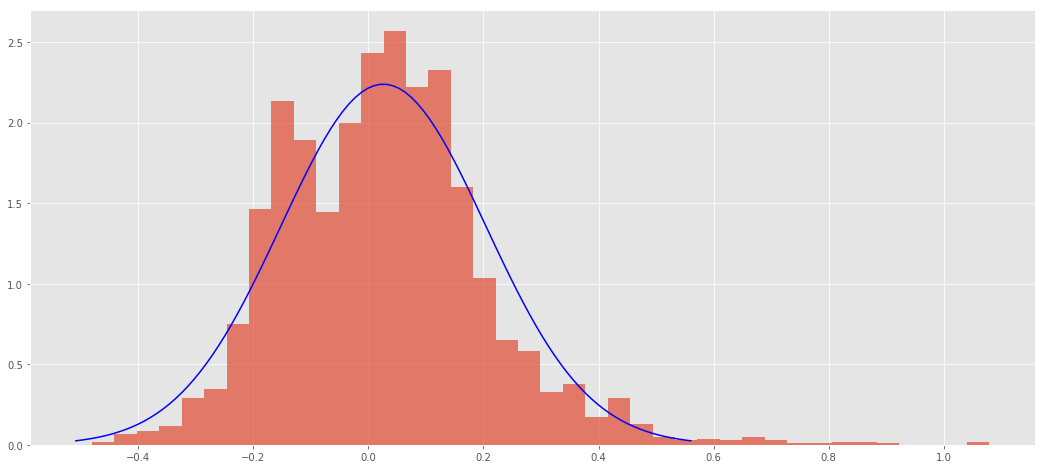

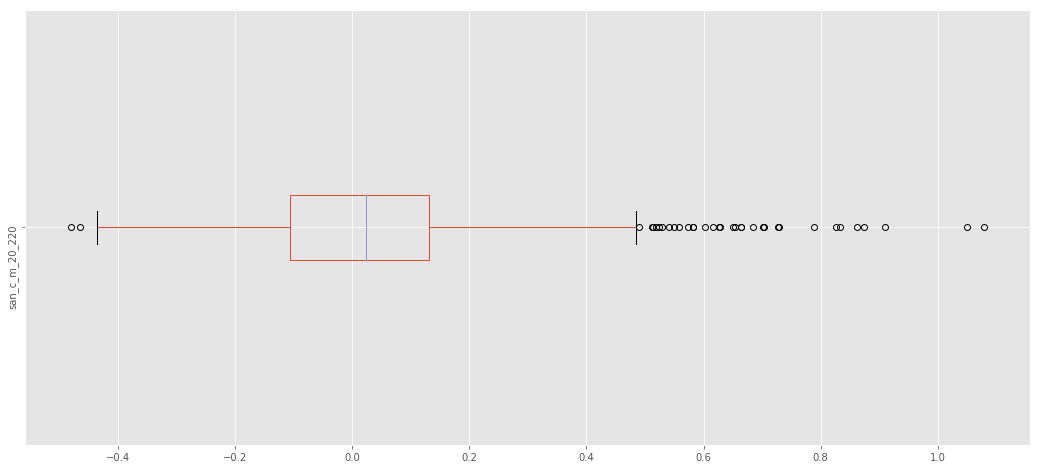

 el valor de 01p es : -0.33299 
 el valor de 05p es : -0.22532 
 el valor de 50p es : 0.023946 
 el valor de 95p es : 0.33724 
 el valor de T-test es : 7.7166 
 el valor de avg es : 0.026 
 el valor de kur es : 2.0866 
 el valor de skw es : 0.75104 
 el valor de std es : 0.17818 
 el valor de val es : -1.4967 
 el valor de var es : 0.031748 


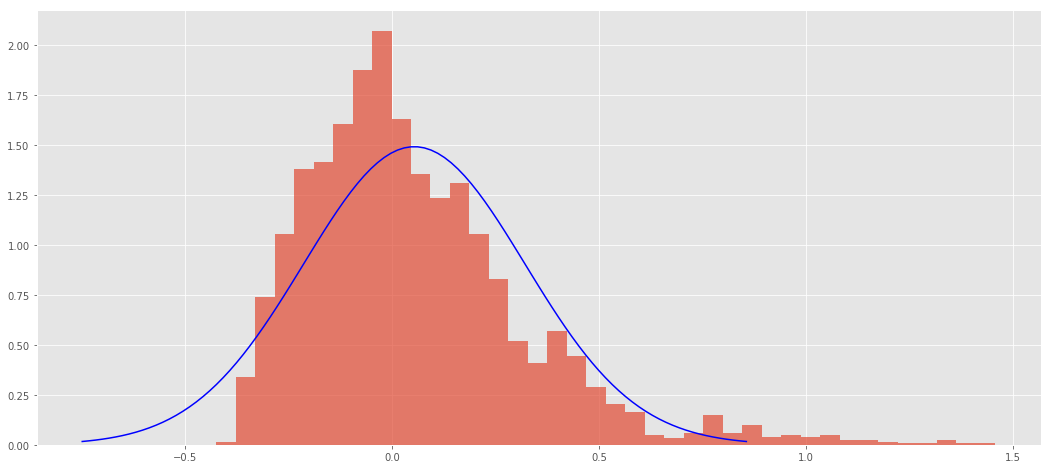

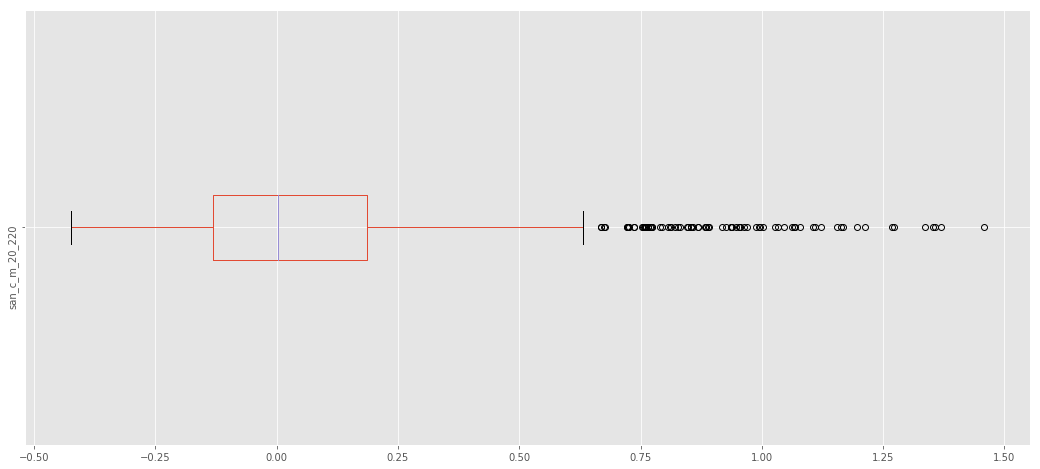

 el valor de 01p es : -0.34854 
 el valor de 05p es : -0.28525 
 el valor de 50p es : 0.0024995 
 el valor de 95p es : 0.53069 
 el valor de T-test es : 10.535 
 el valor de avg es : 0.054 
 el valor de kur es : 2.8107 
 el valor de skw es : 1.3326 
 el valor de std es : 0.26743 
 el valor de val es : -1.8604 
 el valor de var es : 0.071519 


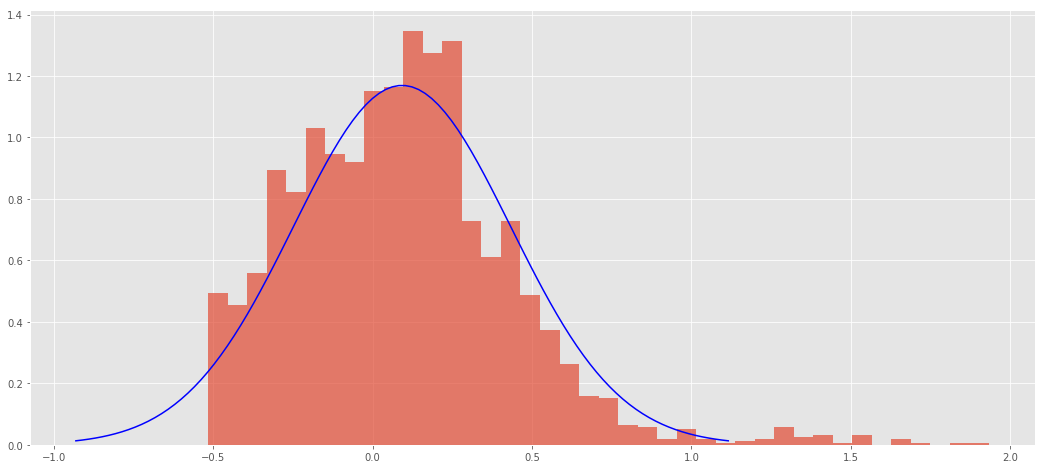

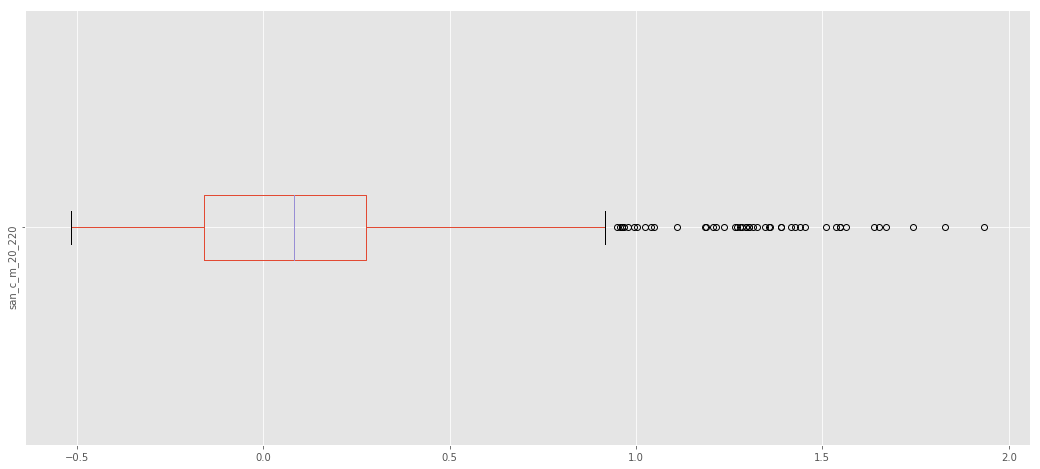

 el valor de 01p es : -0.48545 
 el valor de 05p es : -0.4143 
 el valor de 50p es : 0.083208 
 el valor de 95p es : 0.63032 
 el valor de T-test es : 13.973 
 el valor de avg es : 0.092 
 el valor de kur es : 2.2946 
 el valor de skw es : 0.93024 
 el valor de std es : 0.34114 
 el valor de val es : -1.5214 
 el valor de var es : 0.11638 


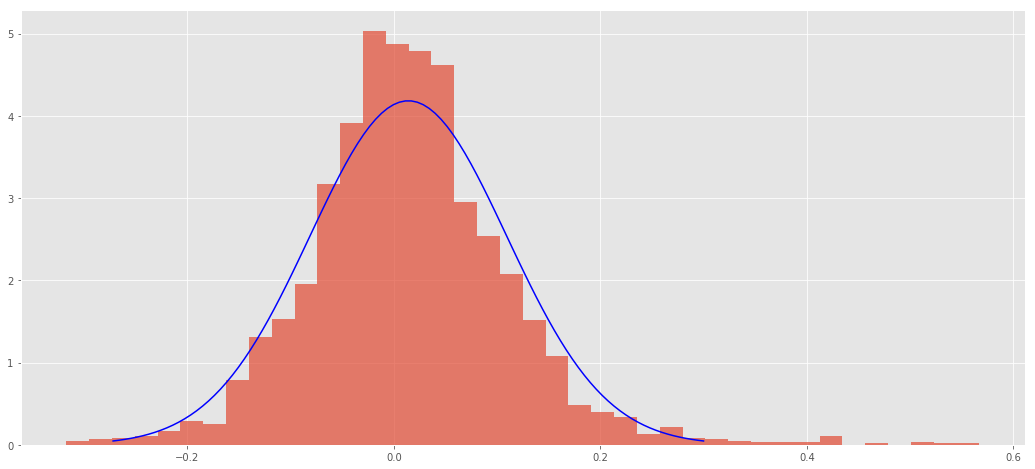

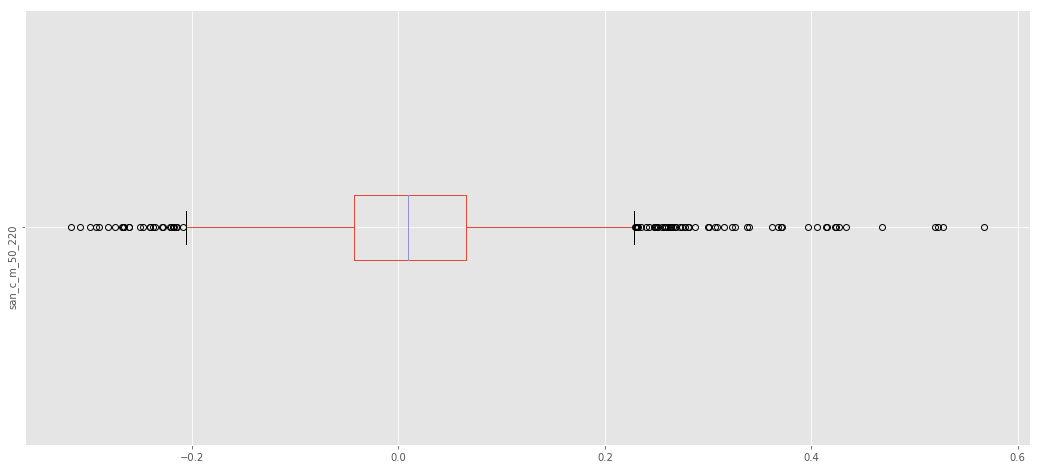

 el valor de 01p es : -0.20935 
 el valor de 05p es : -0.13129 
 el valor de 50p es : 0.0095671 
 el valor de 95p es : 0.16313 
 el valor de T-test es : 7.5912 
 el valor de avg es : 0.014 
 el valor de kur es : 2.6538 
 el valor de skw es : 0.60039 
 el valor de std es : 0.09534 
 el valor de val es : -1.2425 
 el valor de var es : 0.0090896 


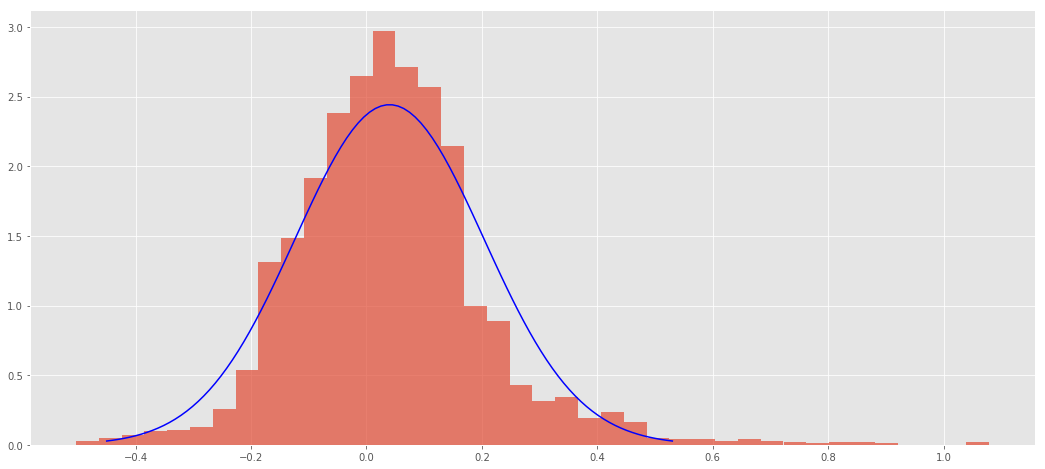

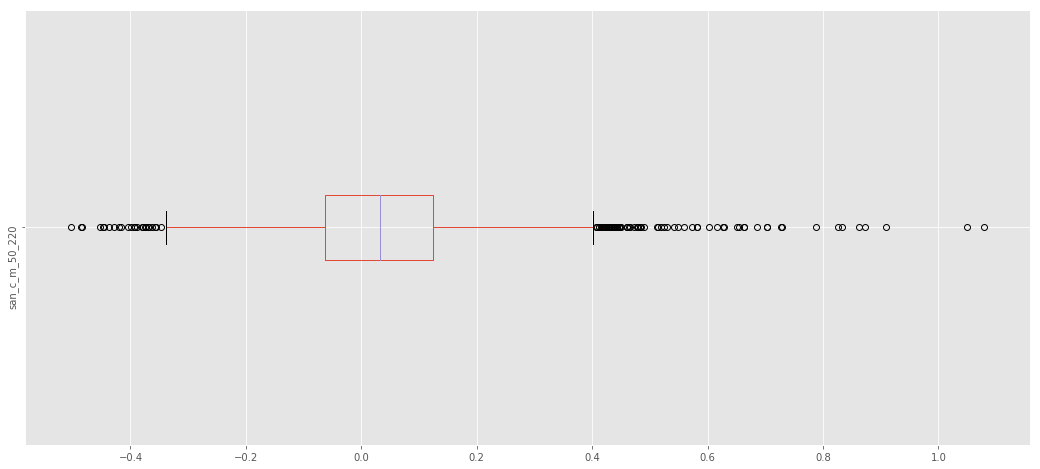

 el valor de 01p es : -0.33501 
 el valor de 05p es : -0.18686 
 el valor de 50p es : 0.031643 
 el valor de 95p es : 0.32093 
 el valor de T-test es : 12.713 
 el valor de avg es : 0.04 
 el valor de kur es : 3.4121 
 el valor de skw es : 0.86624 
 el valor de std es : 0.16335 
 el valor de val es : -1.7175 
 el valor de var es : 0.026684 


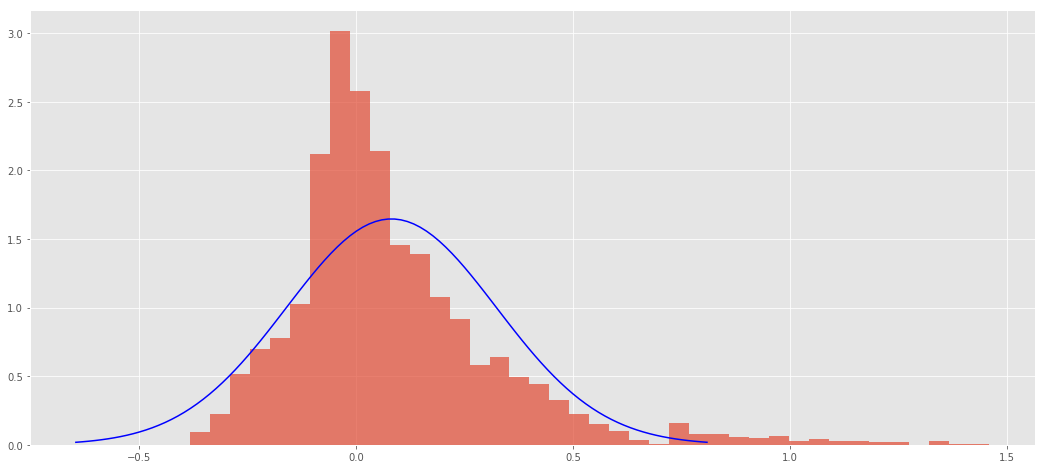

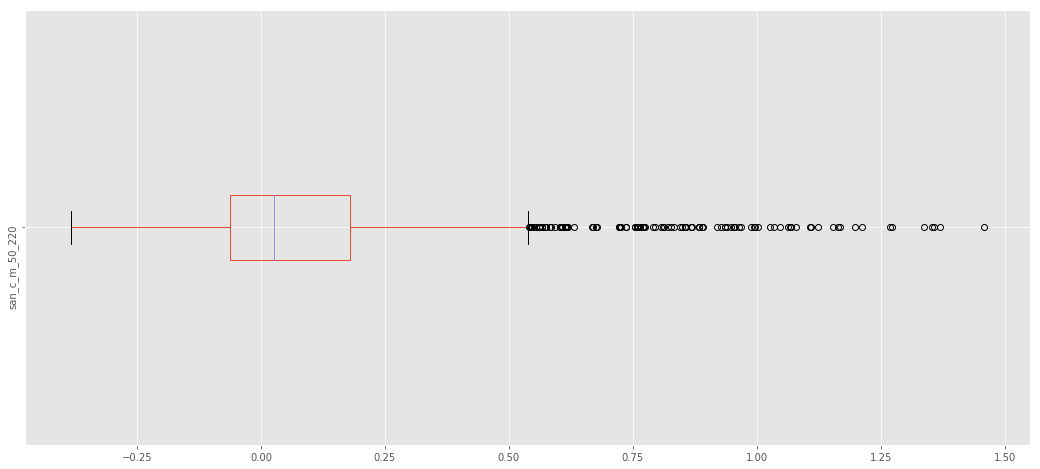

 el valor de 01p es : -0.30735 
 el valor de 05p es : -0.23093 
 el valor de 50p es : 0.026407 
 el valor de 95p es : 0.50812 
 el valor de T-test es : 17.379 
 el valor de avg es : 0.081 
 el valor de kur es : 4.3566 
 el valor de skw es : 1.6327 
 el valor de std es : 0.24238 
 el valor de val es : -2.2003 
 el valor de var es : 0.058746 


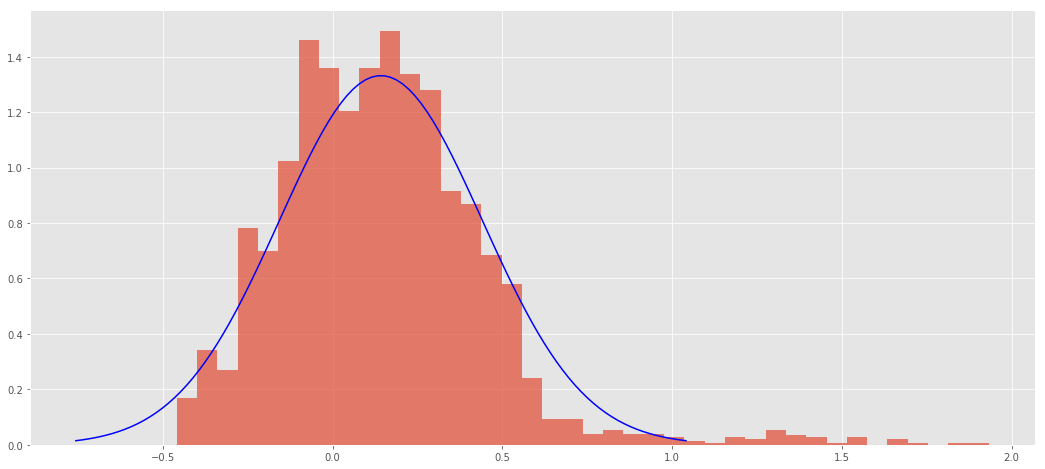

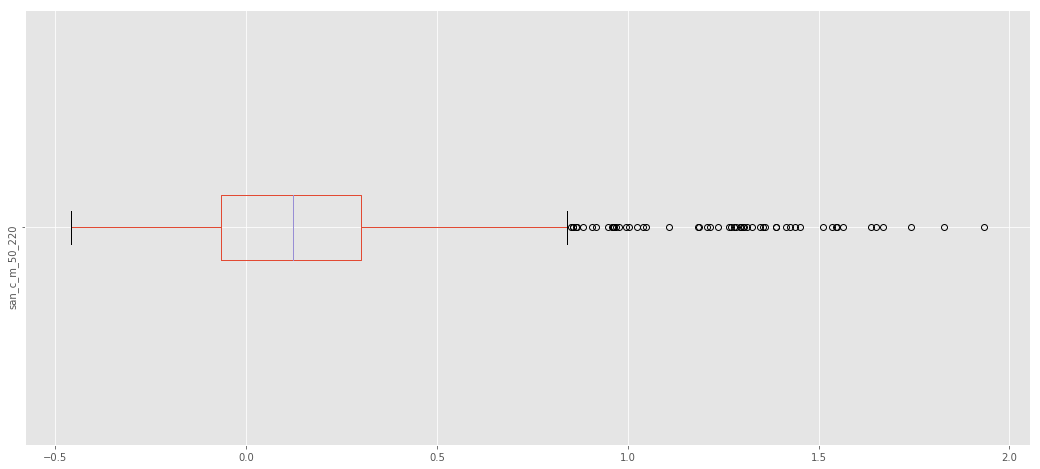

 el valor de 01p es : -0.39982 
 el valor de 05p es : -0.27319 
 el valor de 50p es : 0.12391 
 el valor de 95p es : 0.56627 
 el valor de T-test es : 24.695 
 el valor de avg es : 0.142 
 el valor de kur es : 3.9616 
 el valor de skw es : 1.2109 
 el valor de std es : 0.29953 
 el valor de val es : -2.0728 
 el valor de var es : 0.089721 


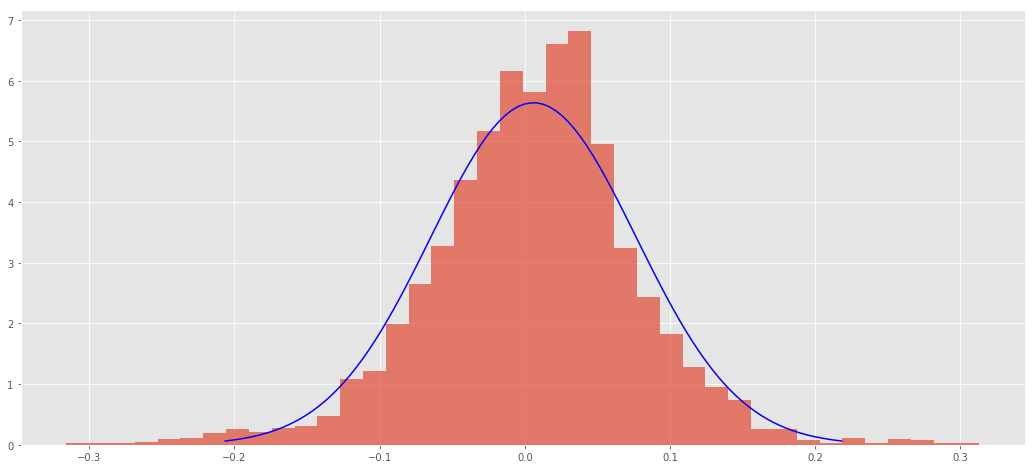

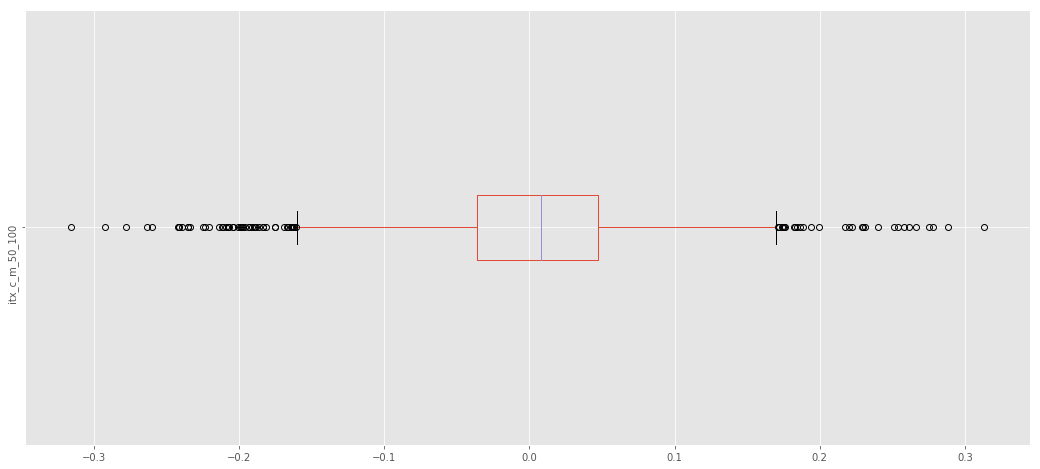

 el valor de 01p es : -0.19819 
 el valor de 05p es : -0.11056 
 el valor de 50p es : 0.0081278 
 el valor de 95p es : 0.11741 
 el valor de T-test es : 4.258 
 el valor de avg es : 0.006 
 el valor de kur es : 1.4595 
 el valor de skw es : -0.19723 
 el valor de std es : 0.070759 
 el valor de val es : -1.062 
 el valor de var es : 0.0050068 


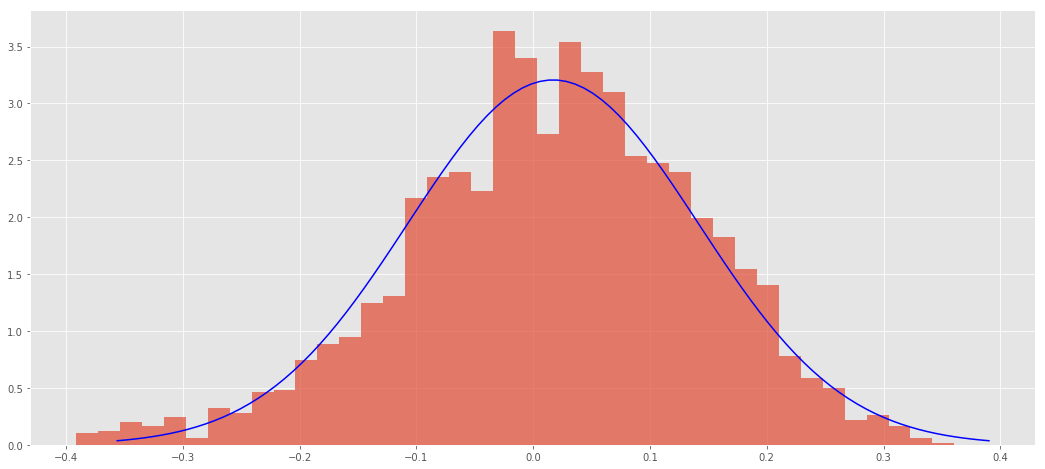

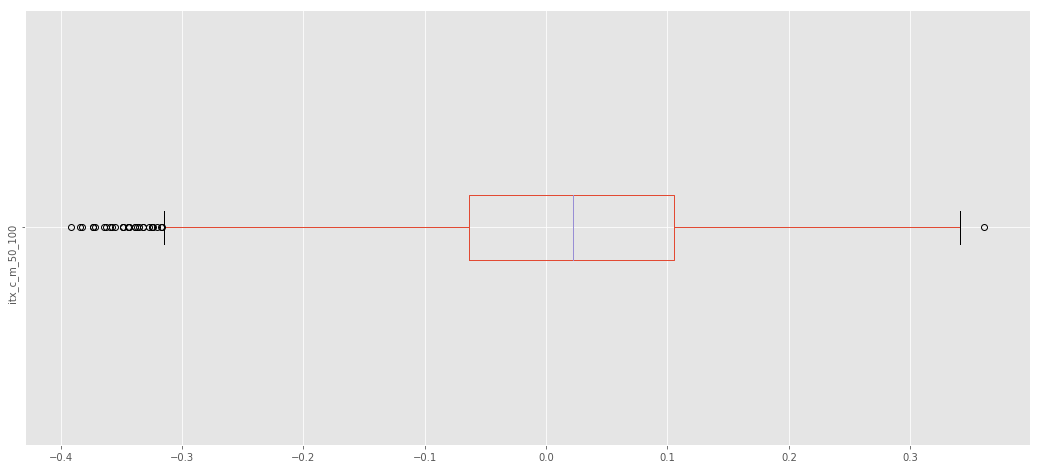

 el valor de 01p es : -0.32269 
 el valor de 05p es : -0.19652 
 el valor de 50p es : 0.022492 
 el valor de 95p es : 0.20833 
 el valor de T-test es : 7.2162 
 el valor de avg es : 0.017 
 el valor de kur es : 0.12038 
 el valor de skw es : -0.30252 
 el valor de std es : 0.12441 
 el valor de val es : -1.0601 
 el valor de var es : 0.015479 


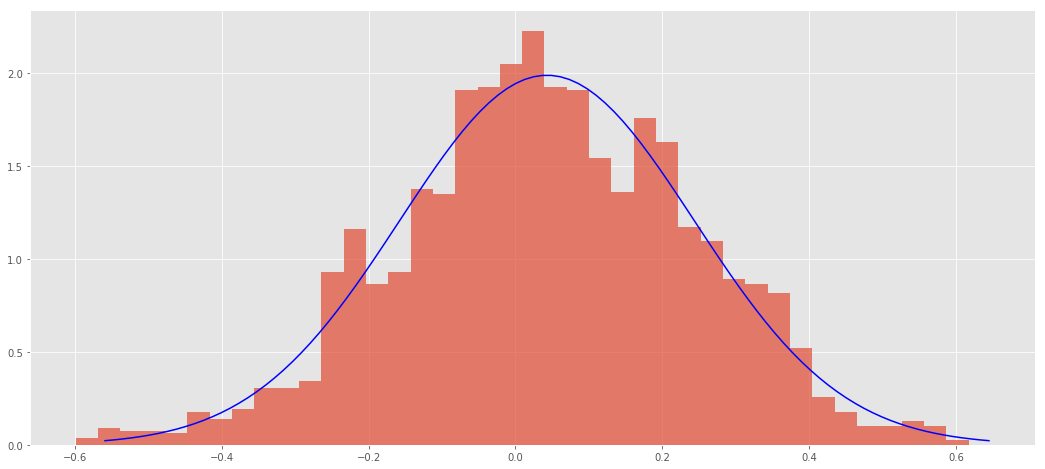

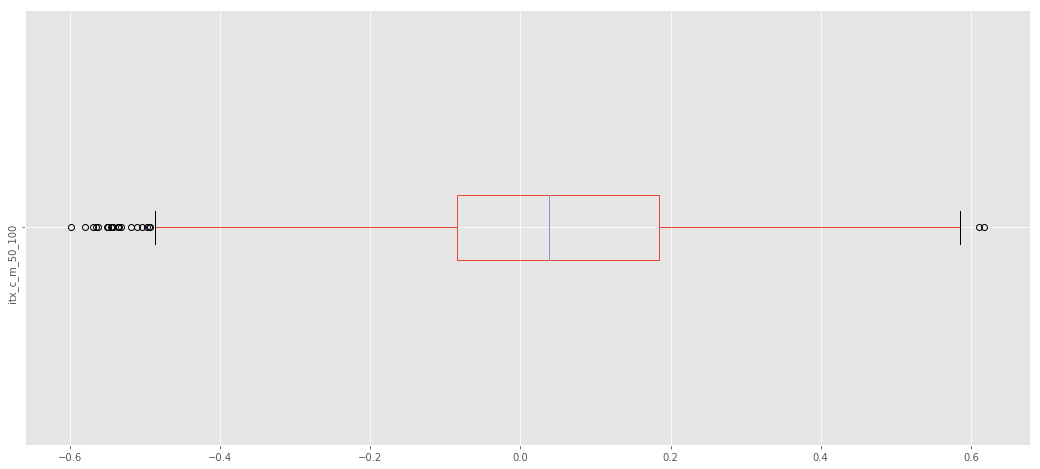

 el valor de 01p es : -0.45102 
 el valor de 05p es : -0.27301 
 el valor de 50p es : 0.038593 
 el valor de 95p es : 0.3663 
 el valor de T-test es : 11.063 
 el valor de avg es : 0.043 
 el valor de kur es : -0.041345 
 el valor de skw es : -0.10341 
 el valor de std es : 0.20068 
 el valor de val es : -1.3417 
 el valor de var es : 0.040274 


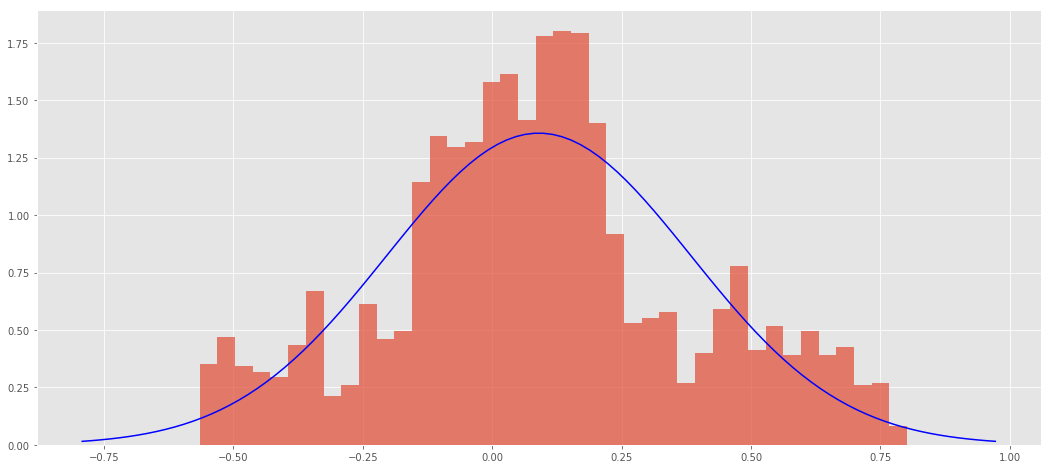

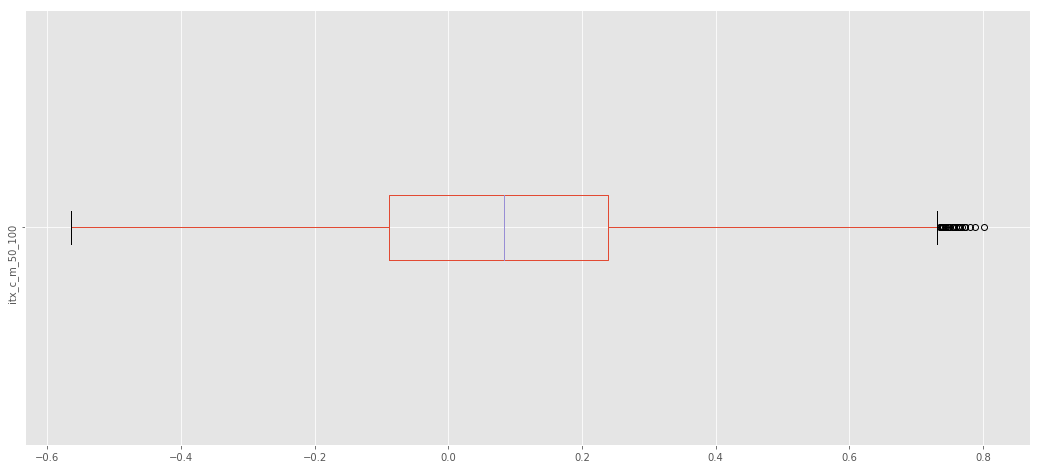

 el valor de 01p es : -0.5339 
 el valor de 05p es : -0.4296 
 el valor de 50p es : 0.083842 
 el valor de 95p es : 0.62737 
 el valor de T-test es : 15.957 
 el valor de avg es : 0.09 
 el valor de kur es : -0.21798 
 el valor de skw es : 0.11844 
 el valor de std es : 0.29398 
 el valor de val es : -1.4604 
 el valor de var es : 0.086423 


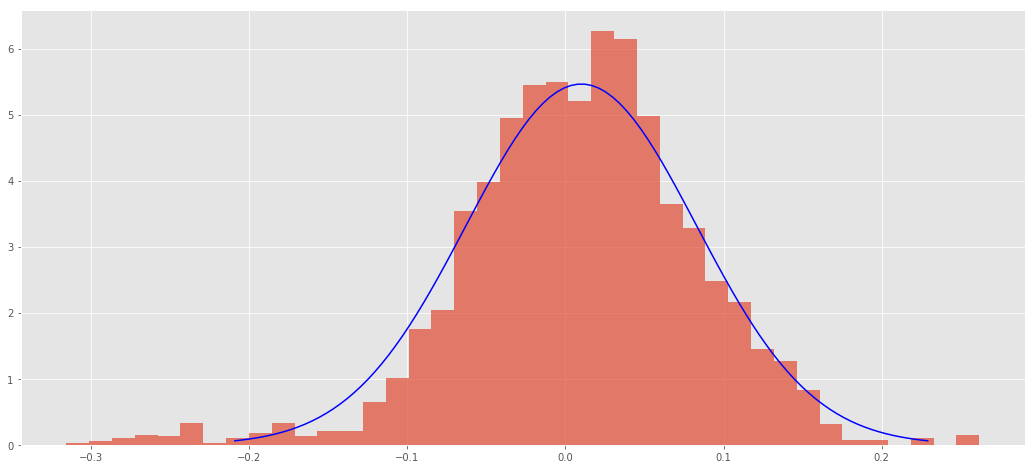

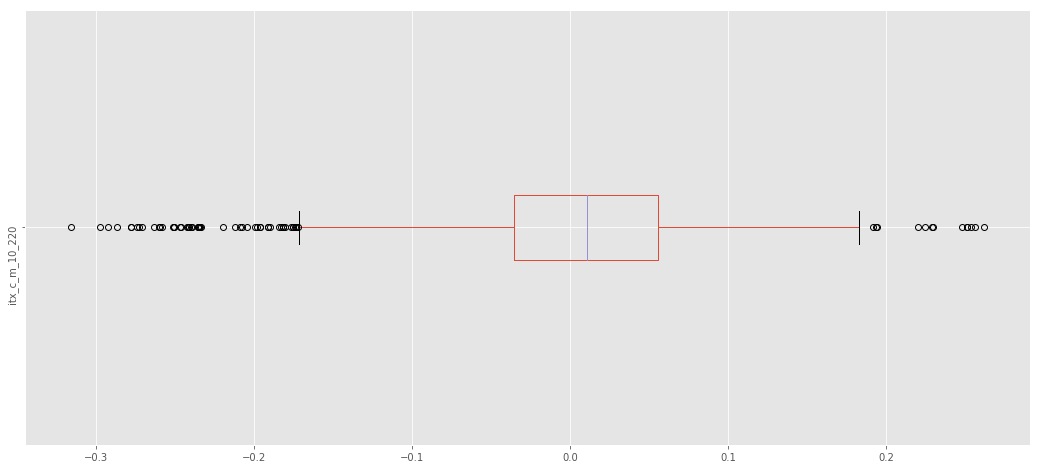

 el valor de 01p es : -0.23491 
 el valor de 05p es : -0.10246 
 el valor de 50p es : 0.010986 
 el valor de 95p es : 0.12484 
 el valor de T-test es : 6.7923 
 el valor de avg es : 0.01 
 el valor de kur es : 1.5401 
 el valor de skw es : -0.46052 
 el valor de std es : 0.073029 
 el valor de val es : -1.2185 
 el valor de var es : 0.0053332 


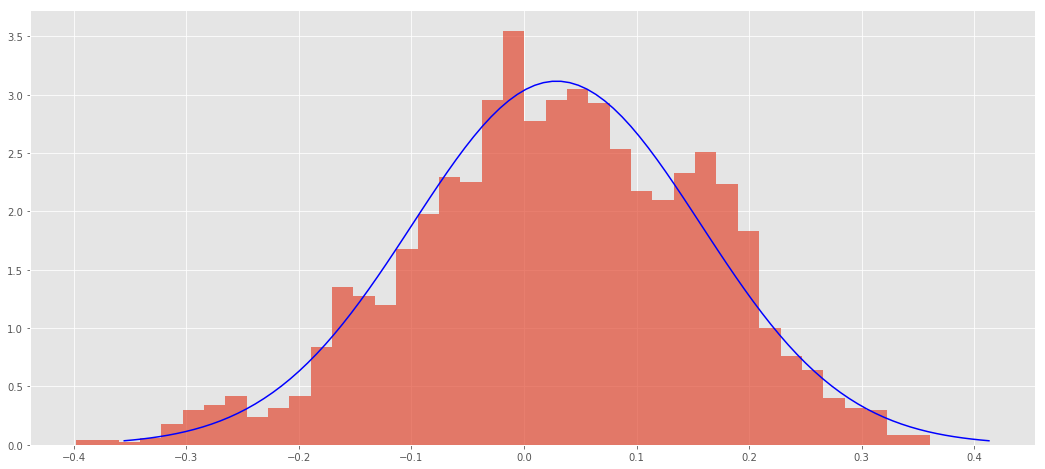

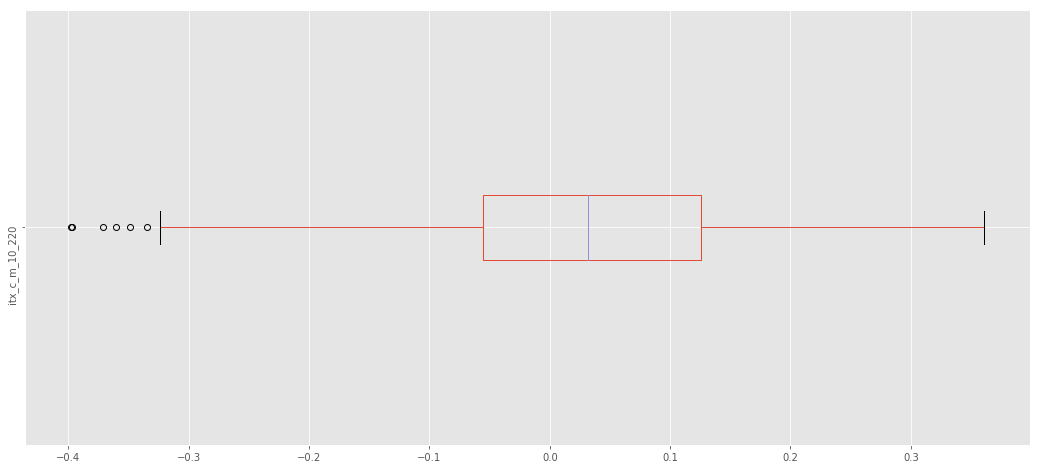

 el valor de 01p es : -0.29098 
 el valor de 05p es : -0.17834 
 el valor de 50p es : 0.031449 
 el valor de 95p es : 0.22729 
 el valor de T-test es : 11.949 
 el valor de avg es : 0.029 
 el valor de kur es : -0.18541 
 el valor de skw es : -0.22551 
 el valor de std es : 0.128 
 el valor de val es : -1.2745 
 el valor de var es : 0.016385 


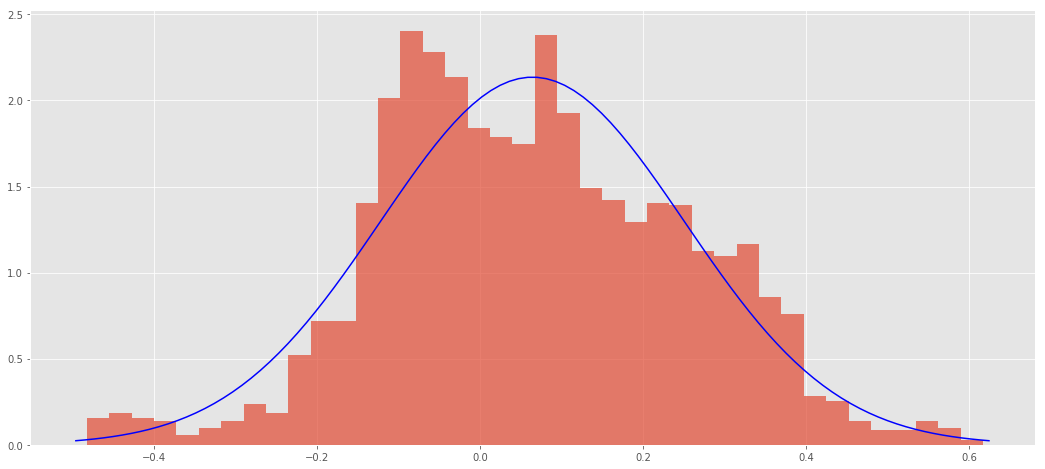

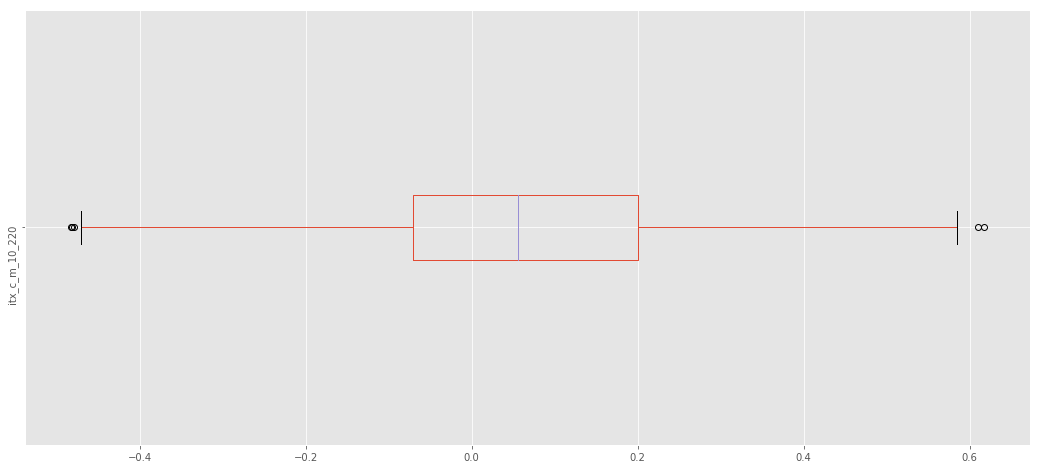

 el valor de 01p es : -0.4212 
 el valor de 05p es : -0.21085 
 el valor de 50p es : 0.056007 
 el valor de 95p es : 0.37086 
 el valor de T-test es : 17.946 
 el valor de avg es : 0.064 
 el valor de kur es : -0.075272 
 el valor de skw es : 0.049159 
 el valor de std es : 0.18681 
 el valor de val es : -1.7589 
 el valor de var es : 0.034899 


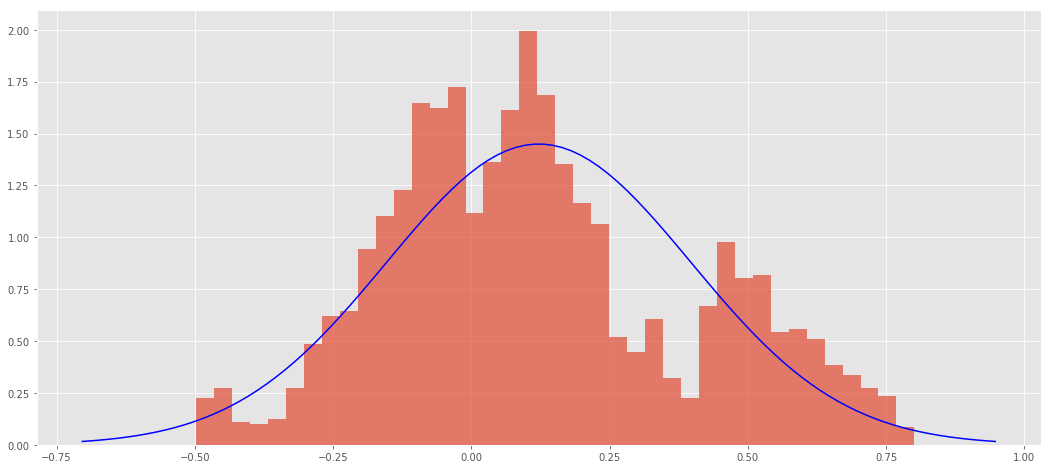

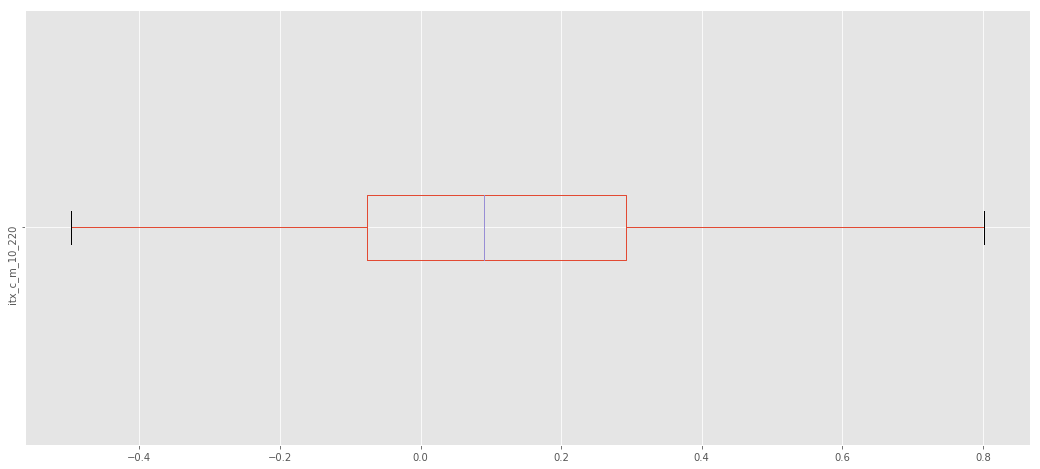

 el valor de 01p es : -0.45096 
 el valor de 05p es : -0.27179 
 el valor de 50p es : 0.090626 
 el valor de 95p es : 0.6271 
 el valor de T-test es : 22.975 
 el valor de avg es : 0.122 
 el valor de kur es : -0.47398 
 el valor de skw es : 0.37537 
 el valor de std es : 0.27522 
 el valor de val es : -2.3073 
 el valor de var es : 0.075744 


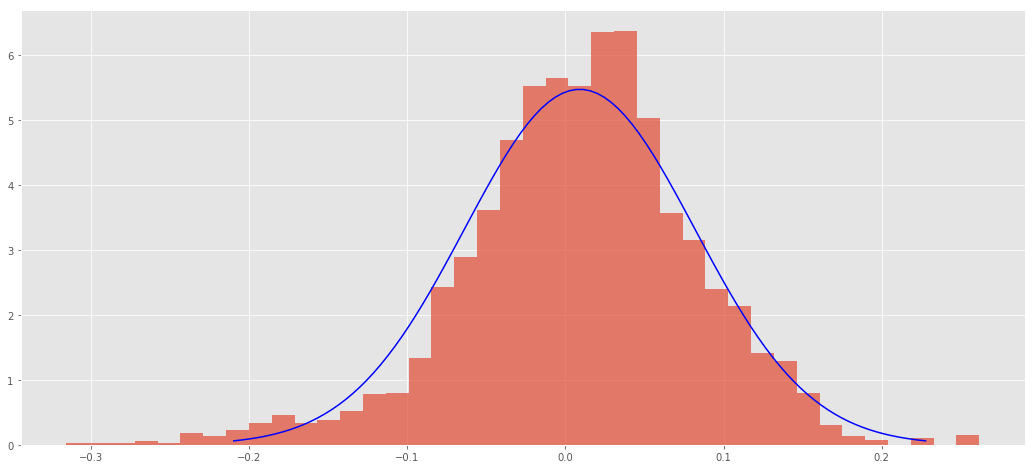

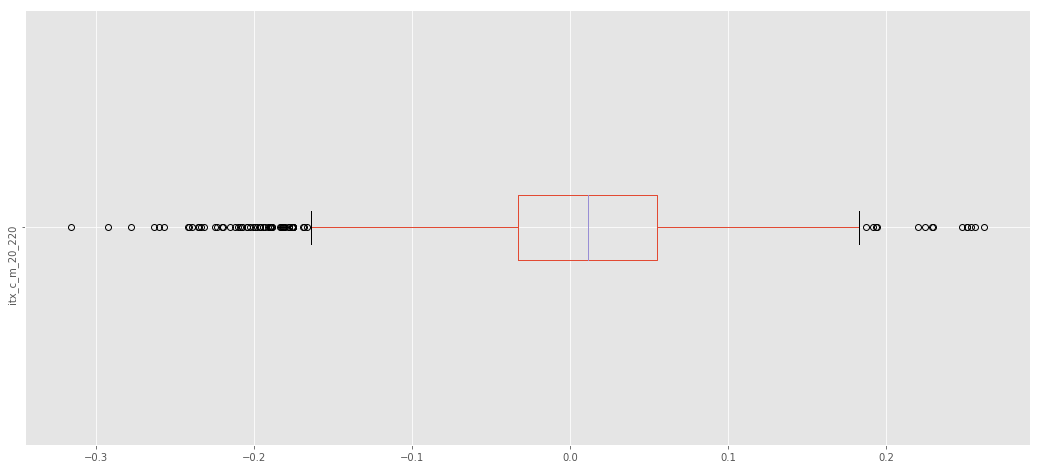

 el valor de 01p es : -0.19954 
 el valor de 05p es : -0.11418 
 el valor de 50p es : 0.011389 
 el valor de 95p es : 0.12555 
 el valor de T-test es : 6.707 
 el valor de avg es : 0.009 
 el valor de kur es : 1.0469 
 el valor de skw es : -0.3765 
 el valor de std es : 0.072918 
 el valor de val es : -1.0996 
 el valor de var es : 0.0053171 


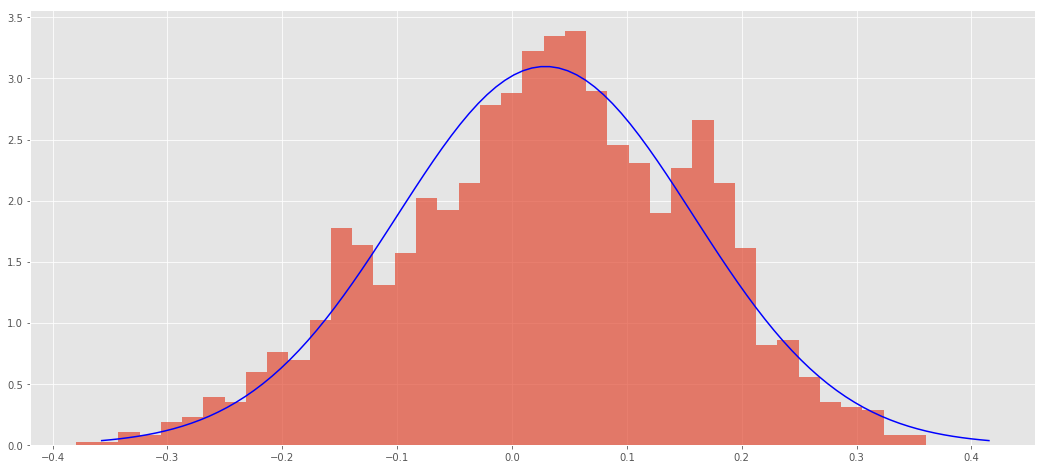

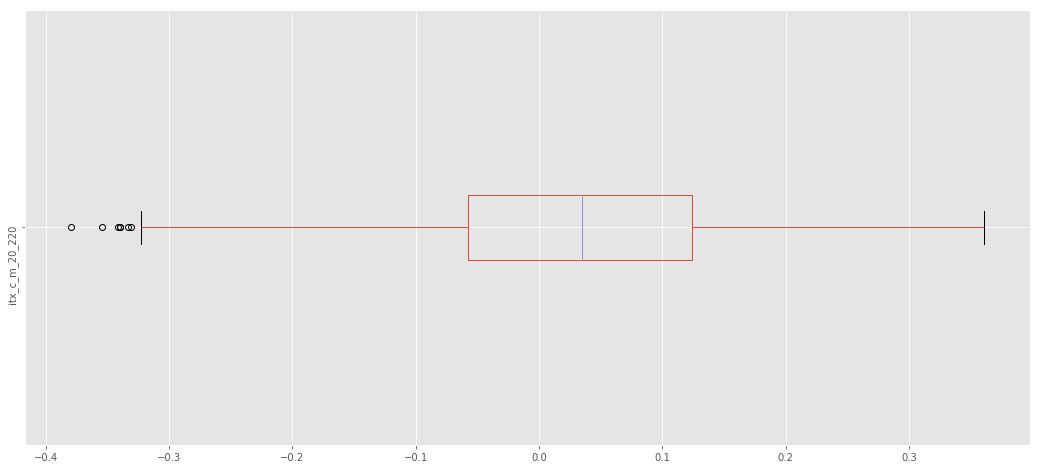

 el valor de 01p es : -0.27619 
 el valor de 05p es : -0.19466 
 el valor de 50p es : 0.034419 
 el valor de 95p es : 0.22732 
 el valor de T-test es : 11.618 
 el valor de avg es : 0.029 
 el valor de kur es : -0.3411 
 el valor de skw es : -0.21815 
 el valor de std es : 0.12875 
 el valor de val es : -1.1678 
 el valor de var es : 0.016578 


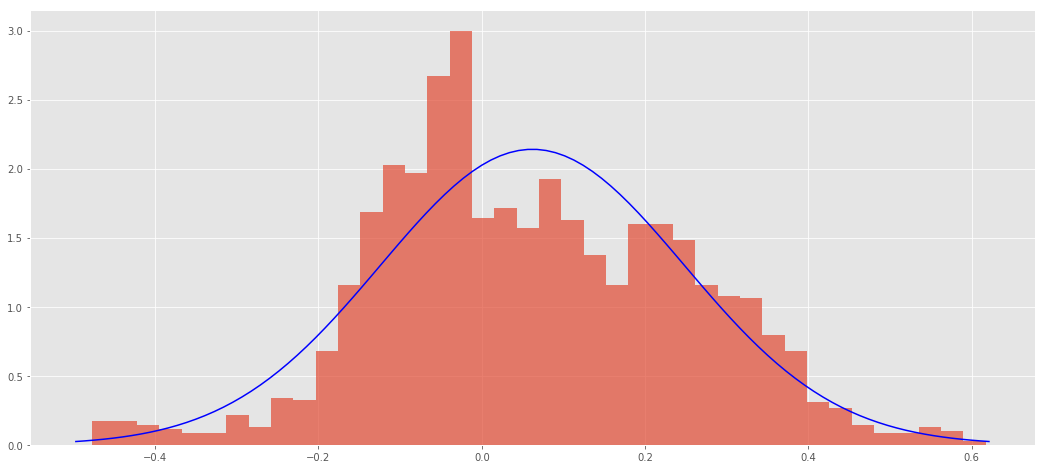

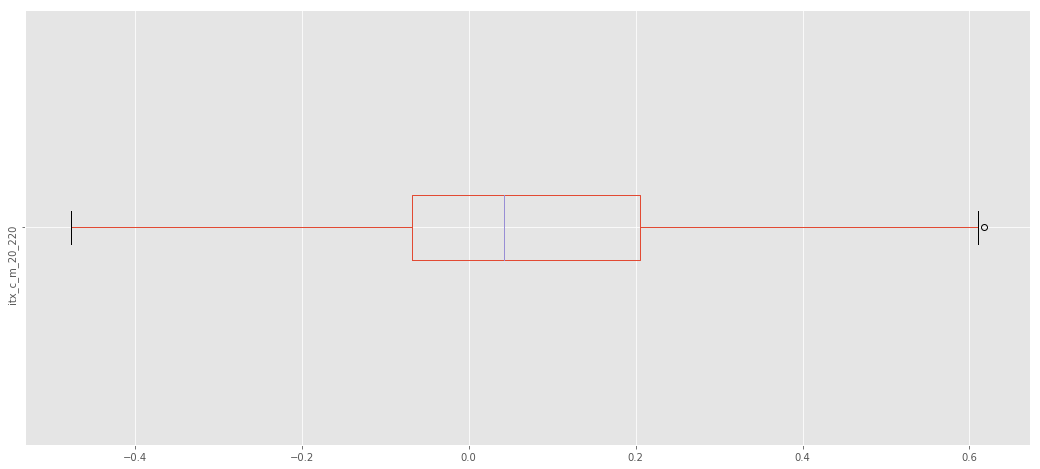

 el valor de 01p es : -0.41319 
 el valor de 05p es : -0.19907 
 el valor de 50p es : 0.0426 
 el valor de 95p es : 0.37086 
 el valor de T-test es : 17.365 
 el valor de avg es : 0.062 
 el valor de kur es : -0.14633 
 el valor de skw es : 0.10448 
 el valor de std es : 0.1864 
 el valor de val es : -1.863 
 el valor de var es : 0.034744 


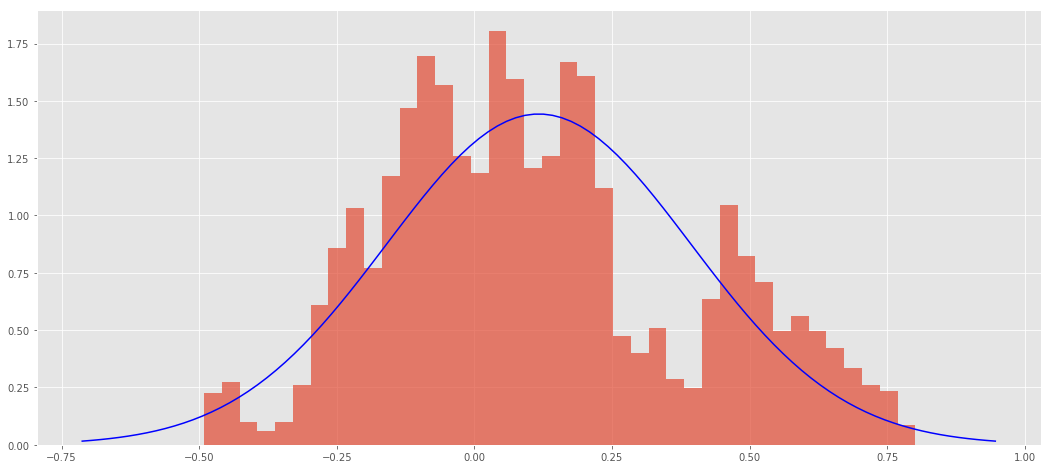

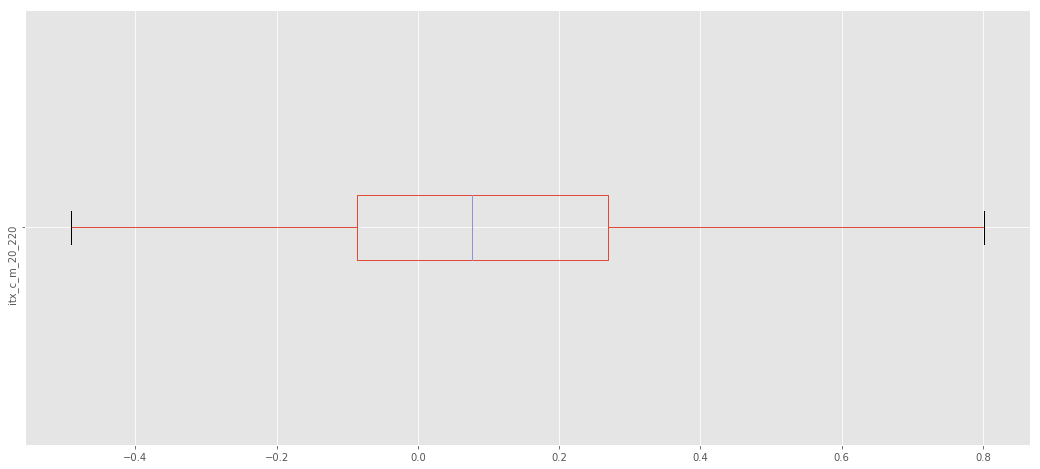

 el valor de 01p es : -0.45029 
 el valor de 05p es : -0.26671 
 el valor de 50p es : 0.07709 
 el valor de 95p es : 0.62815 
 el valor de T-test es : 22.069 
 el valor de avg es : 0.117 
 el valor de kur es : -0.51181 
 el valor de skw es : 0.39652 
 el valor de std es : 0.27654 
 el valor de val es : -2.3552 
 el valor de var es : 0.076474 


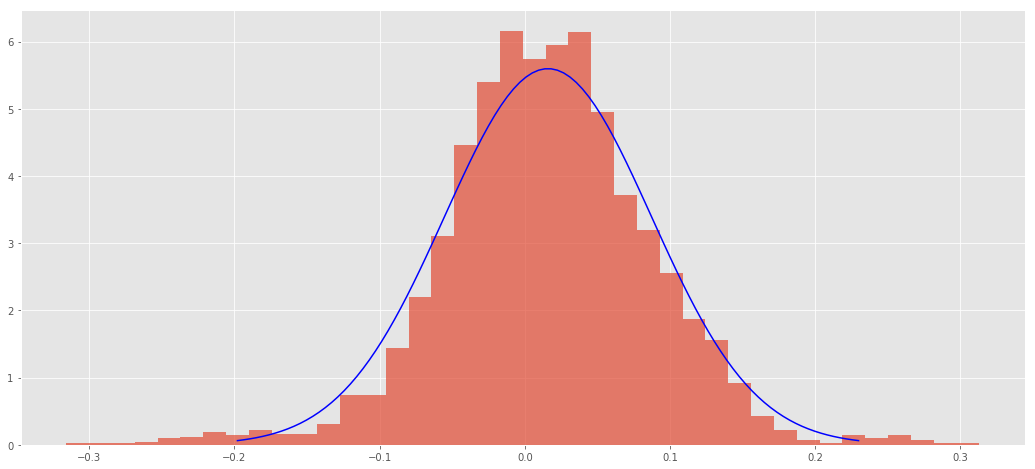

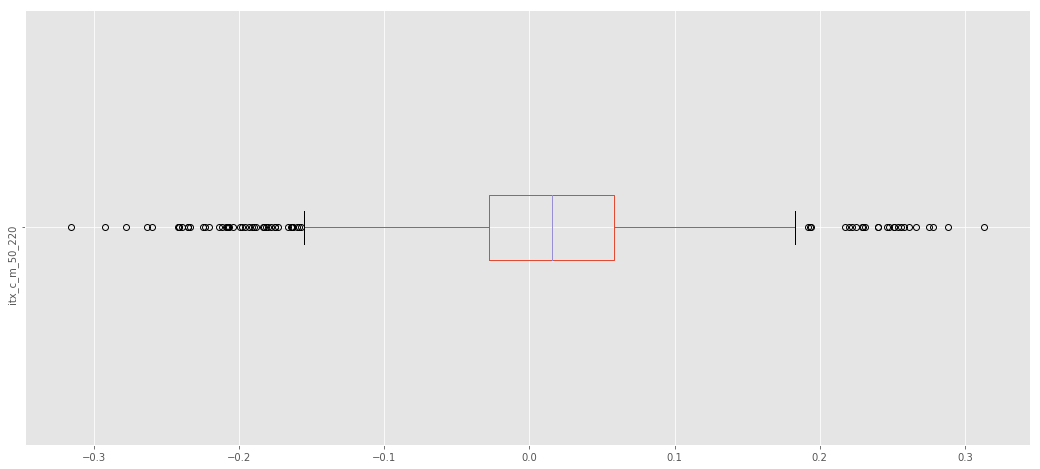

 el valor de 01p es : -0.19142 
 el valor de 05p es : -0.091313 
 el valor de 50p es : 0.015692 
 el valor de 95p es : 0.13037 
 el valor de T-test es : 11.414 
 el valor de avg es : 0.016 
 el valor de kur es : 1.4664 
 el valor de skw es : -0.14343 
 el valor de std es : 0.071276 
 el valor de val es : -1.4278 
 el valor de var es : 0.0050802 


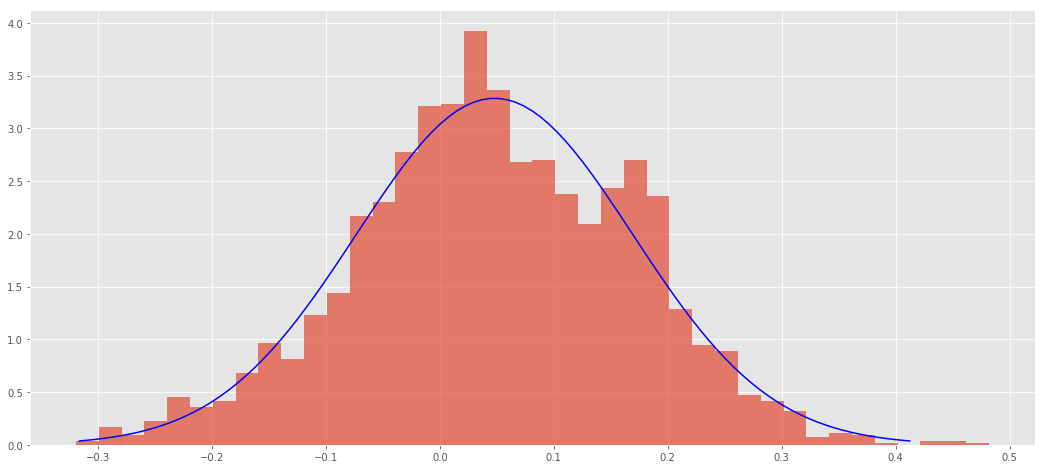

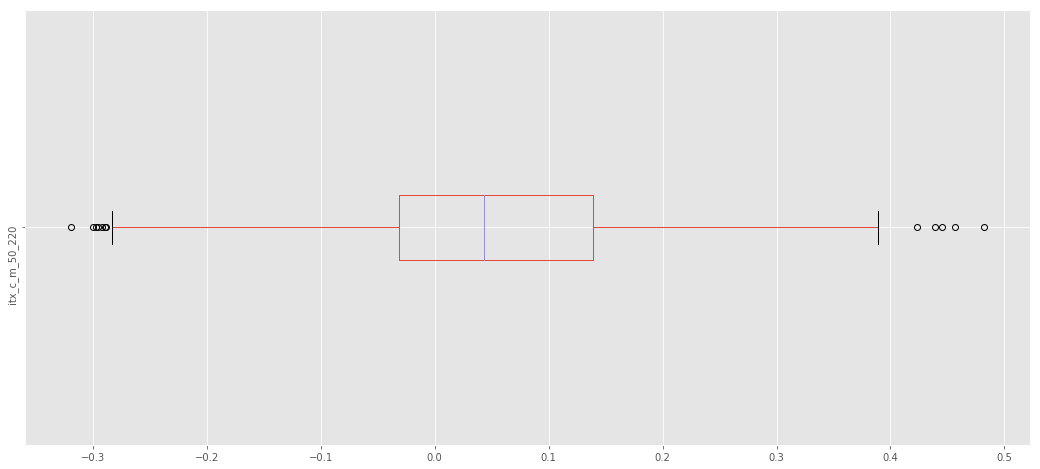

 el valor de 01p es : -0.24111 
 el valor de 05p es : -0.15792 
 el valor de 50p es : 0.043311 
 el valor de 95p es : 0.24133 
 el valor de T-test es : 20.564 
 el valor de avg es : 0.048 
 el valor de kur es : -0.048797 
 el valor de skw es : -0.064696 
 el valor de std es : 0.12144 
 el valor de val es : -1.5282 
 el valor de var es : 0.014748 


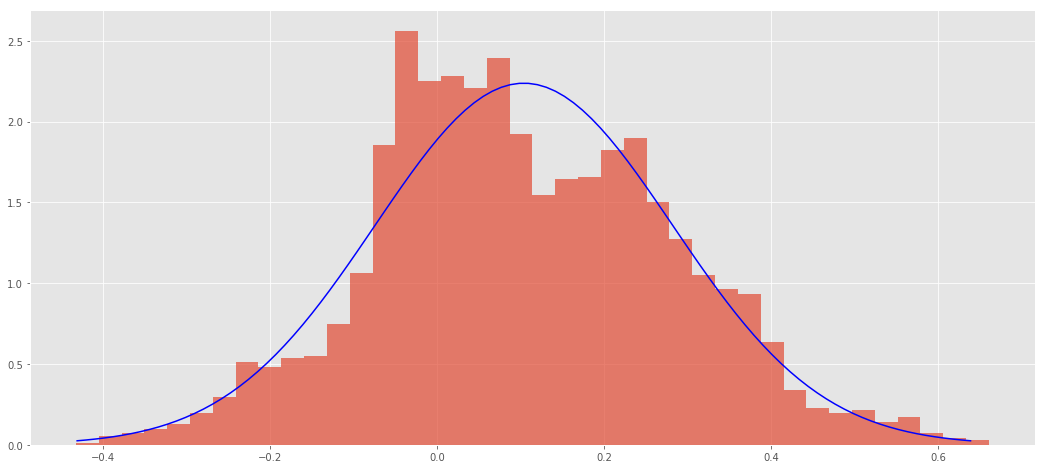

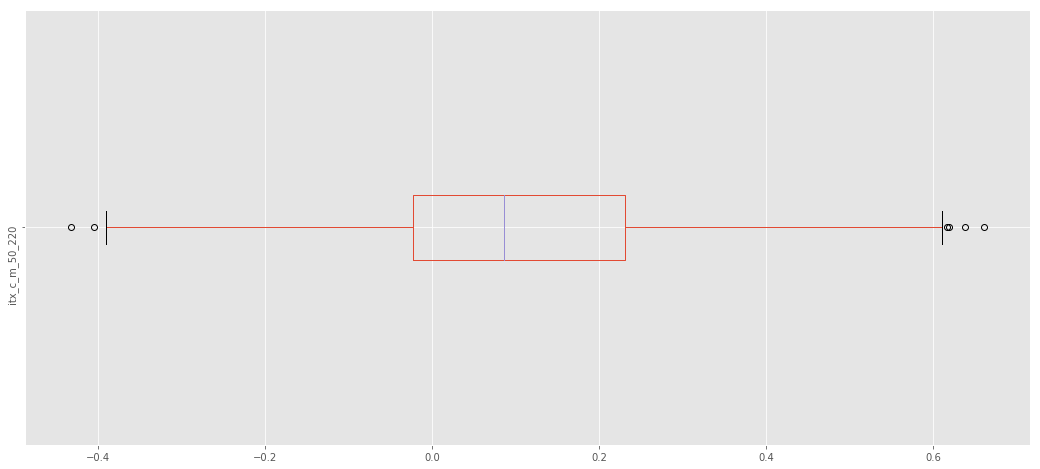

 el valor de 01p es : -0.29475 
 el valor de 05p es : -0.18715 
 el valor de 50p es : 0.086799 
 el valor de 95p es : 0.39535 
 el valor de T-test es : 30.24 
 el valor de avg es : 0.104 
 el valor de kur es : -0.15825 
 el valor de skw es : 0.13078 
 el valor de std es : 0.17826 
 el valor de val es : -2.1125 
 el valor de var es : 0.031777 


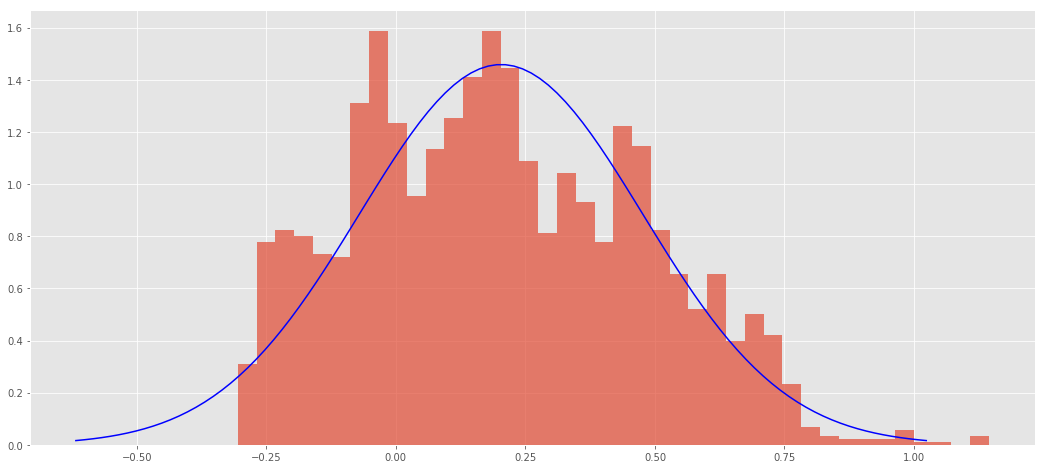

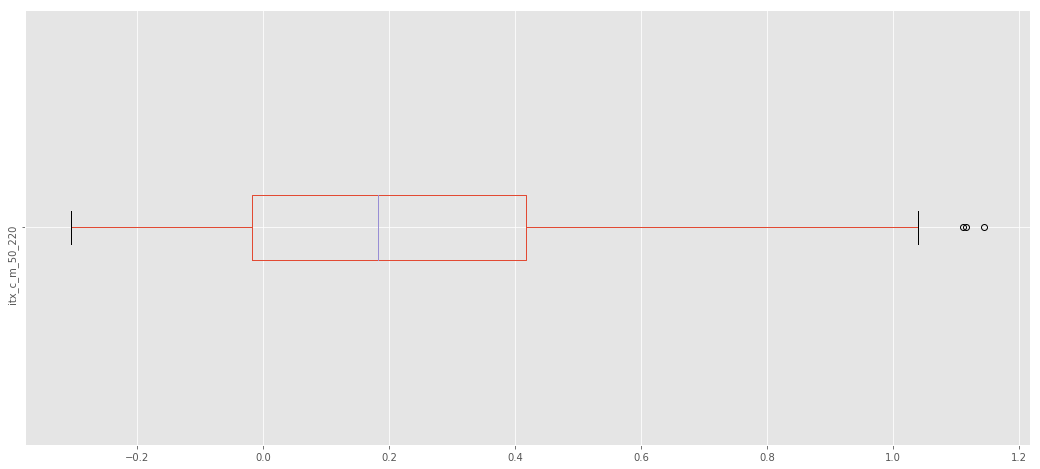

 el valor de 01p es : -0.27202 
 el valor de 05p es : -0.21995 
 el valor de 50p es : 0.18267 
 el valor de 95p es : 0.67752 
 el valor de T-test es : 38.534 
 el valor de avg es : 0.203 
 el valor de kur es : -0.59555 
 el valor de skw es : 0.28824 
 el valor de std es : 0.27354 
 el valor de val es : -3.0803 
 el valor de var es : 0.074822 


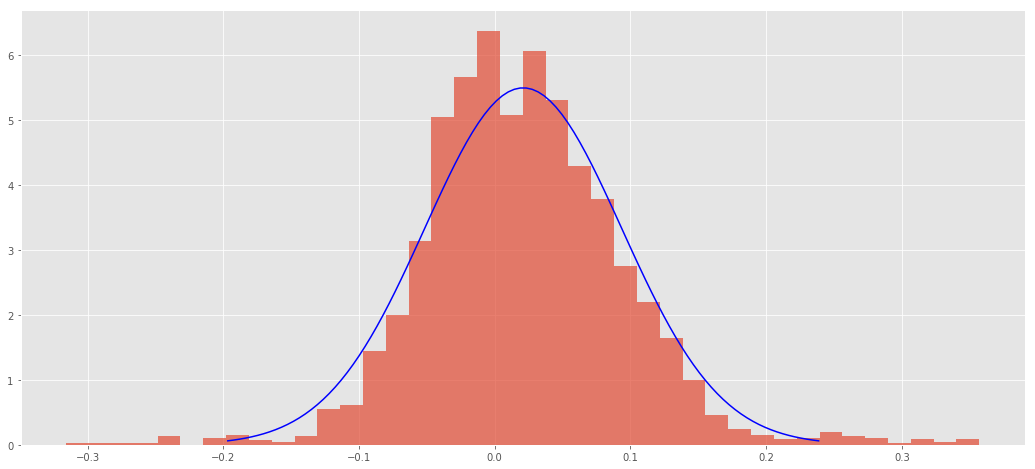

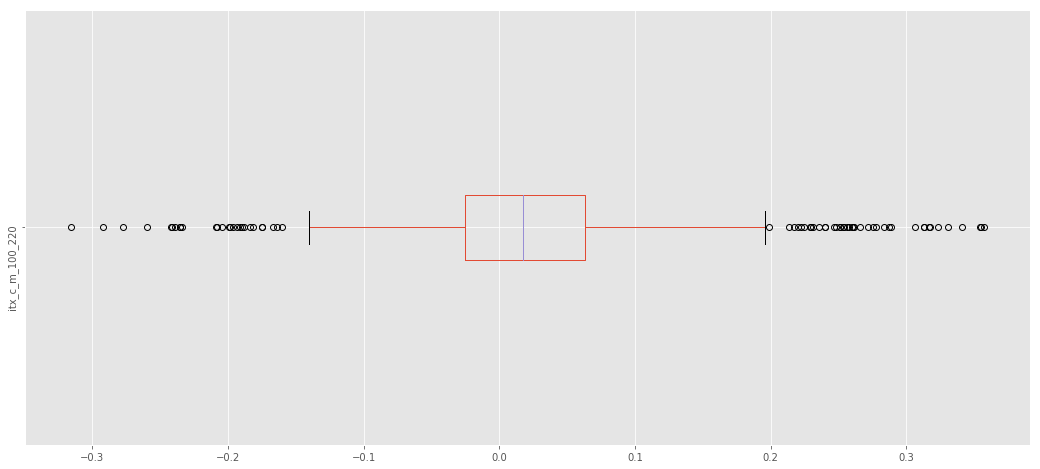

 el valor de 01p es : -0.14351 
 el valor de 05p es : -0.083927 
 el valor de 50p es : 0.017856 
 el valor de 95p es : 0.13642 
 el valor de T-test es : 15.157 
 el valor de avg es : 0.021 
 el valor de kur es : 2.1776 
 el valor de skw es : 0.36453 
 el valor de std es : 0.072563 
 el valor de val es : -1.6255 
 el valor de var es : 0.0052653 


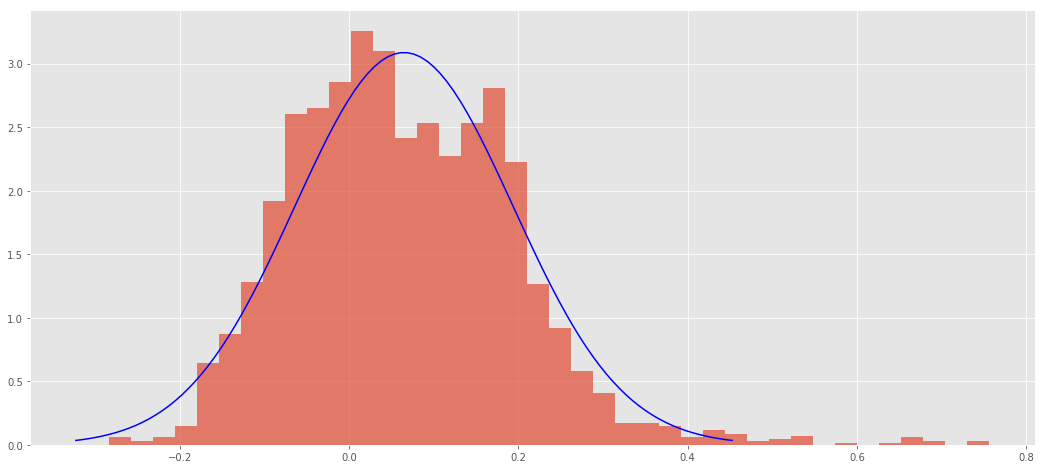

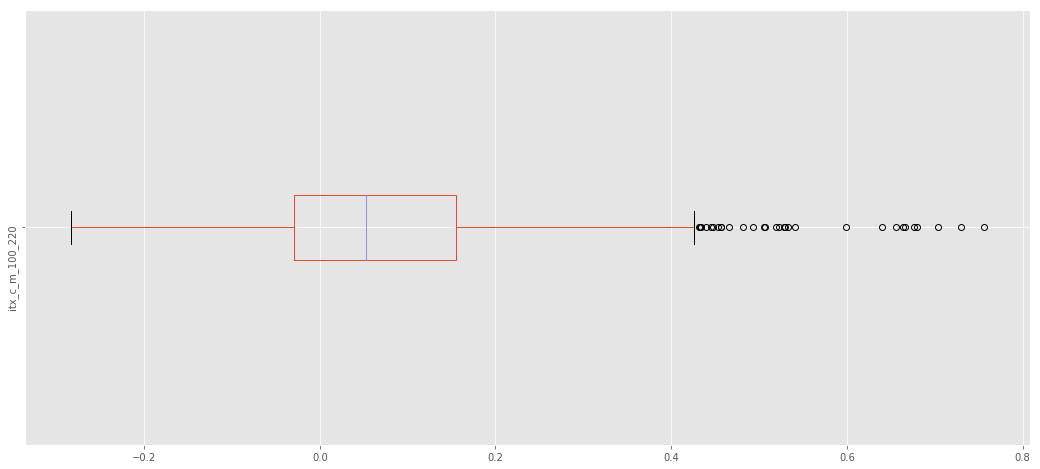

 el valor de 01p es : -0.17363 
 el valor de 05p es : -0.12378 
 el valor de 50p es : 0.052395 
 el valor de 95p es : 0.26621 
 el valor de T-test es : 26.036 
 el valor de avg es : 0.065 
 el valor de kur es : 1.6336 
 el valor de skw es : 0.69438 
 el valor de std es : 0.1292 
 el valor de val es : -2.1507 
 el valor de var es : 0.016691 


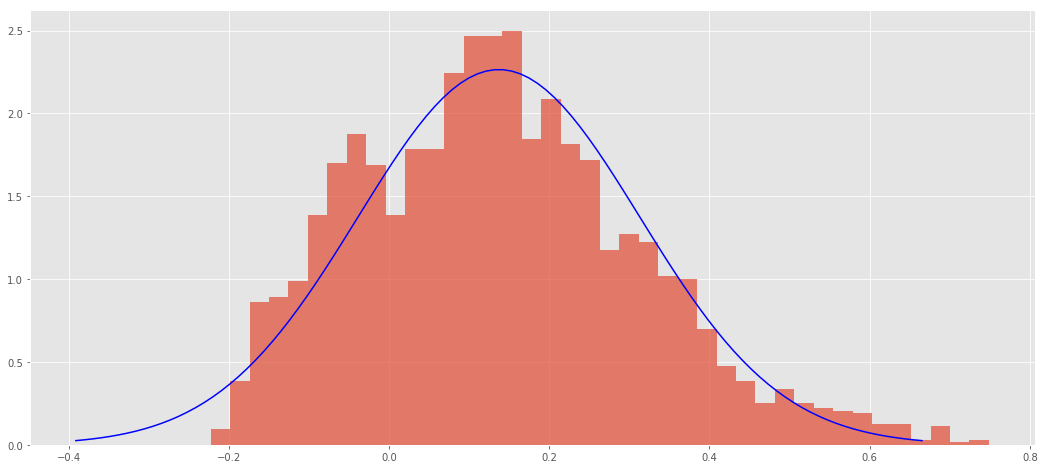

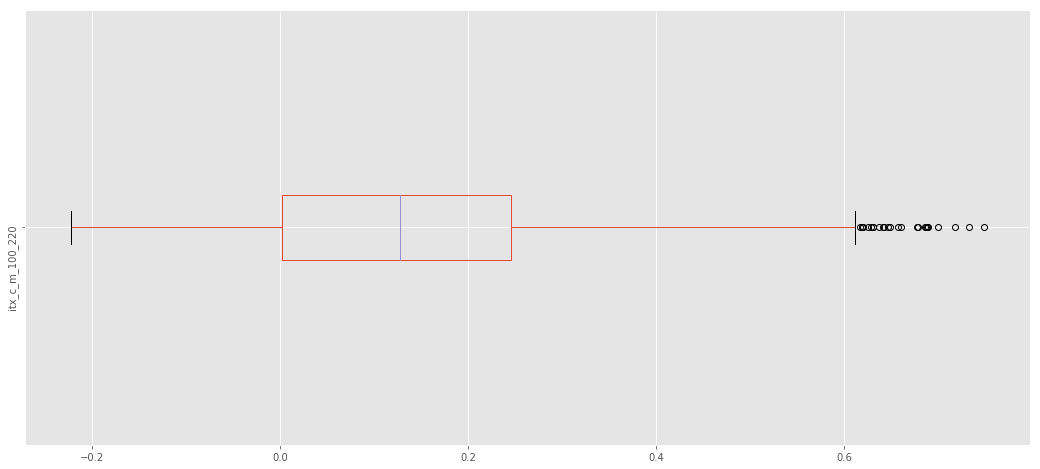

 el valor de 01p es : -0.17737 
 el valor de 05p es : -0.12895 
 el valor de 50p es : 0.12702 
 el valor de 95p es : 0.44391 
 el valor de T-test es : 40.431 
 el valor de avg es : 0.137 
 el valor de kur es : -0.0036466 
 el valor de skw es : 0.45485 
 el valor de std es : 0.17613 
 el valor de val es : -3.4425 
 el valor de var es : 0.03102 


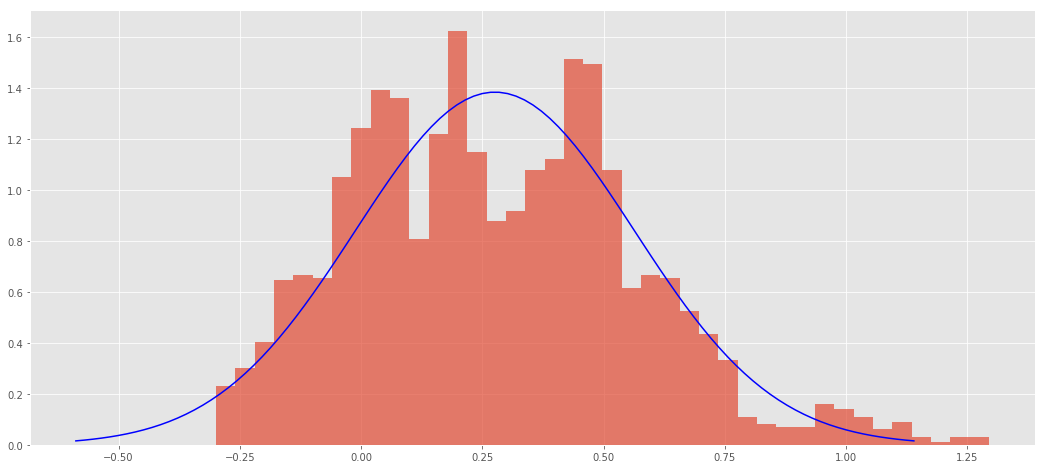

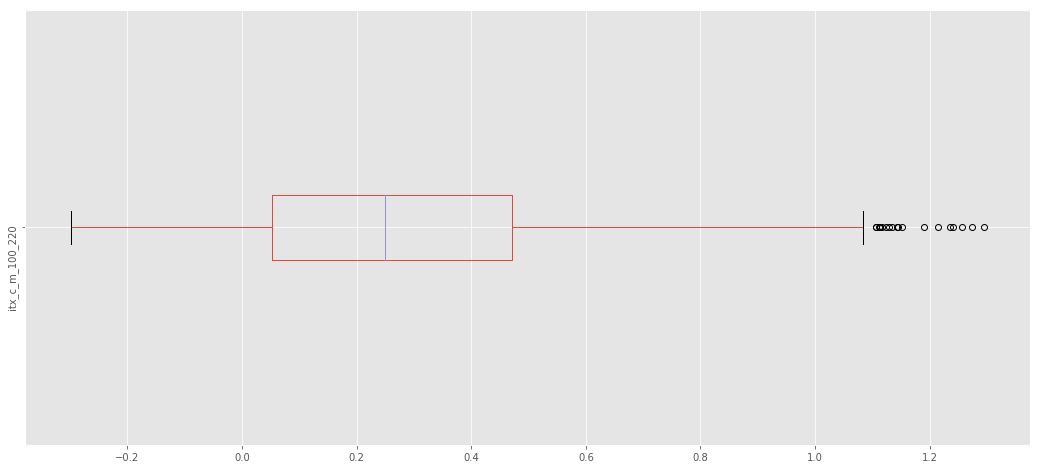

 el valor de 01p es : -0.25569 
 el valor de 05p es : -0.15932 
 el valor de 50p es : 0.24916 
 el valor de 95p es : 0.74048 
 el valor de T-test es : 49.906 
 el valor de avg es : 0.276 
 el valor de kur es : -0.033986 
 el valor de skw es : 0.4251 
 el valor de std es : 0.288 
 el valor de val es : -4.6477 
 el valor de var es : 0.082944 


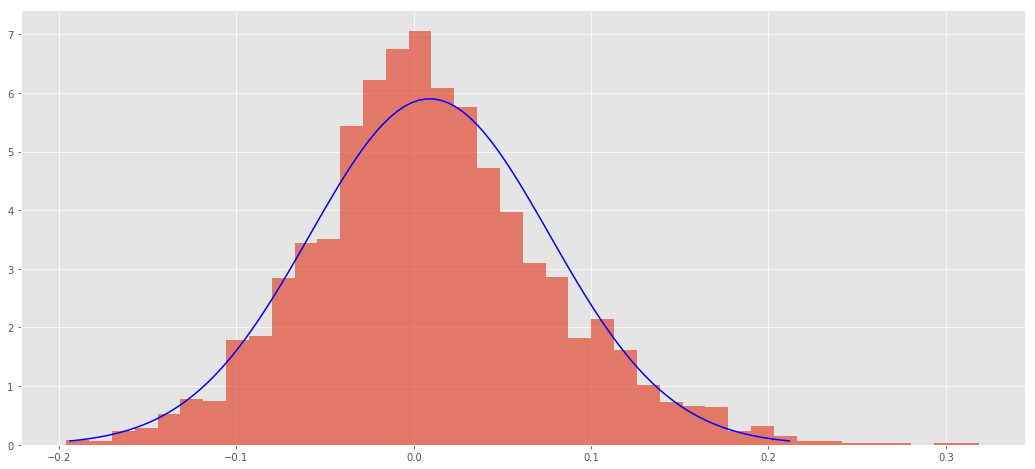

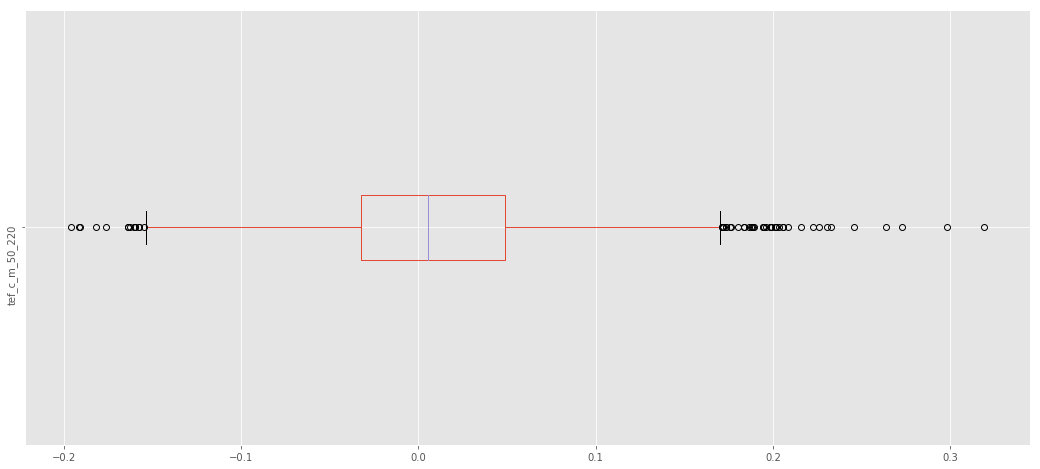

 el valor de 01p es : -0.14112 
 el valor de 05p es : -0.096947 
 el valor de 50p es : 0.0051873 
 el valor de 95p es : 0.12696 
 el valor de T-test es : 7.1598 
 el valor de avg es : 0.009 
 el valor de kur es : 0.56157 
 el valor de skw es : 0.3419 
 el valor de std es : 0.067627 
 el valor de val es : -1.3096 
 el valor de var es : 0.0045734 


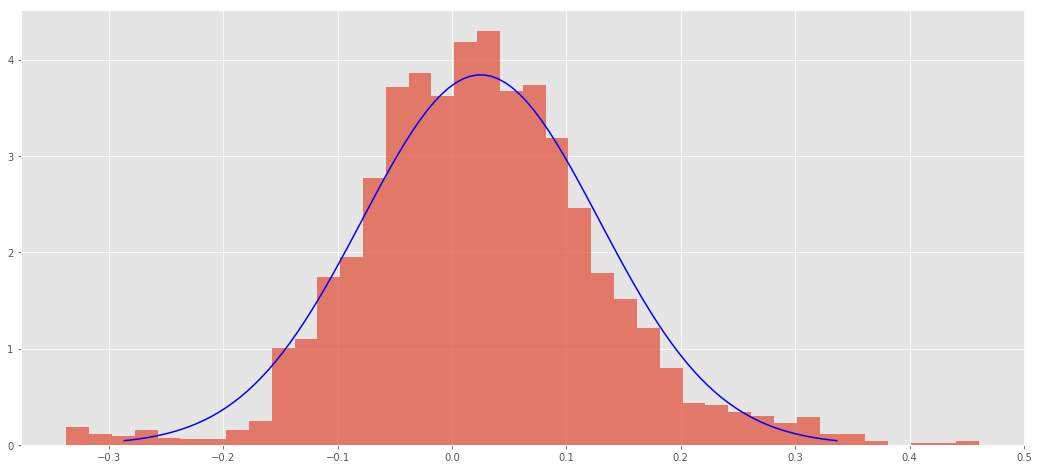

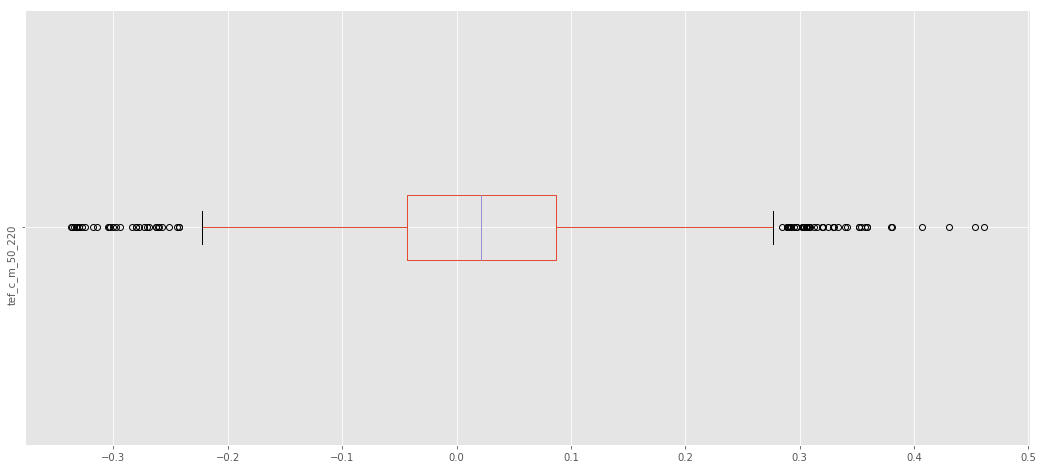

 el valor de 01p es : -0.26085 
 el valor de 05p es : -0.12868 
 el valor de 50p es : 0.021654 
 el valor de 95p es : 0.19772 
 el valor de T-test es : 12.523 
 el valor de avg es : 0.025 
 el valor de kur es : 1.0985 
 el valor de skw es : 0.18916 
 el valor de std es : 0.1038 
 el valor de val es : -1.5365 
 el valor de var es : 0.010775 


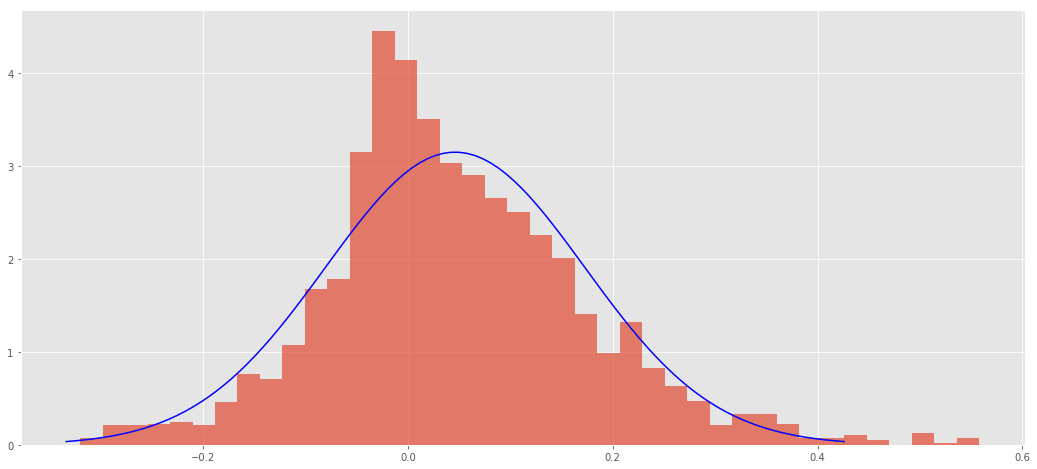

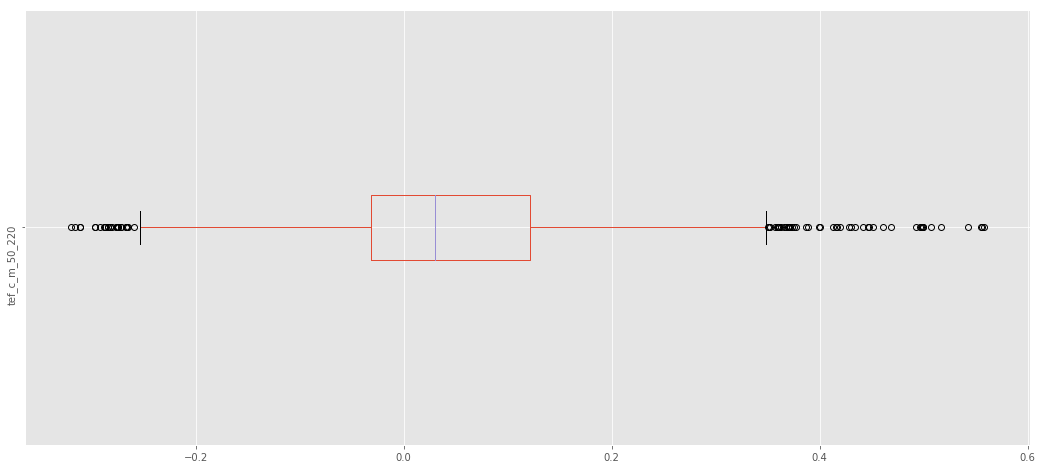

 el valor de 01p es : -0.26521 
 el valor de 05p es : -0.1459 
 el valor de 50p es : 0.029775 
 el valor de 95p es : 0.26572 
 el valor de T-test es : 18.74 
 el valor de avg es : 0.046 
 el valor de kur es : 0.97544 
 el valor de skw es : 0.45804 
 el valor de std es : 0.12659 
 el valor de val es : -1.8212 
 el valor de var es : 0.016026 


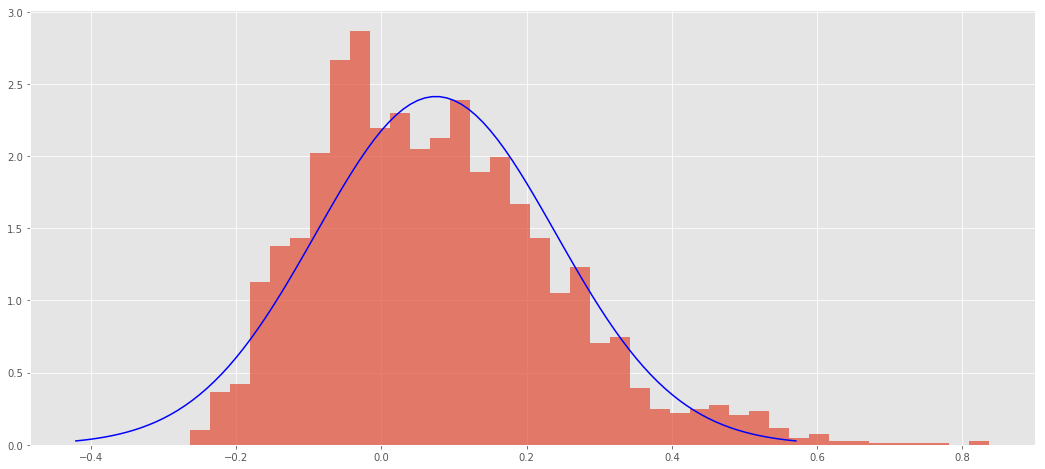

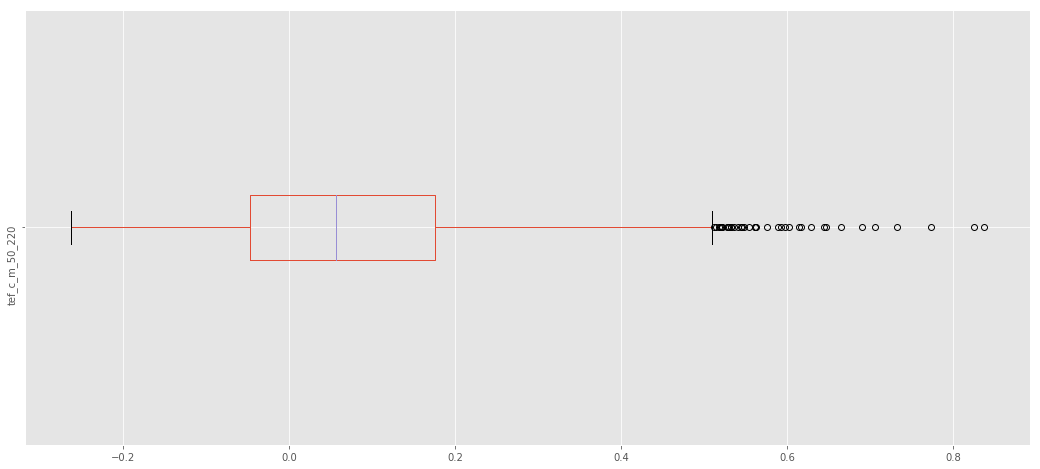

 el valor de 01p es : -0.21412 
 el valor de 05p es : -0.15401 
 el valor de 50p es : 0.056149 
 el valor de 95p es : 0.36742 
 el valor de T-test es : 23.751 
 el valor de avg es : 0.075 
 el valor de kur es : 0.68684 
 el valor de skw es : 0.7361 
 el valor de std es : 0.16529 
 el valor de val es : -2.3857 
 el valor de var es : 0.027319 


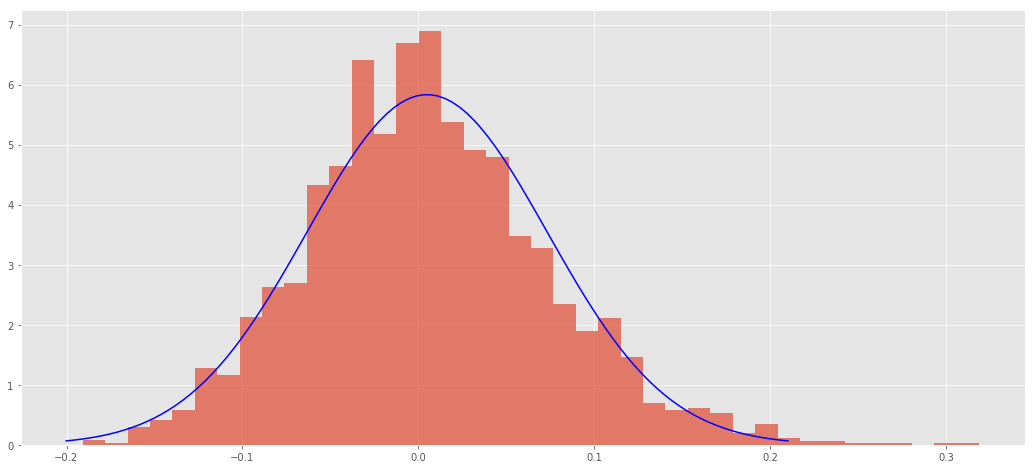

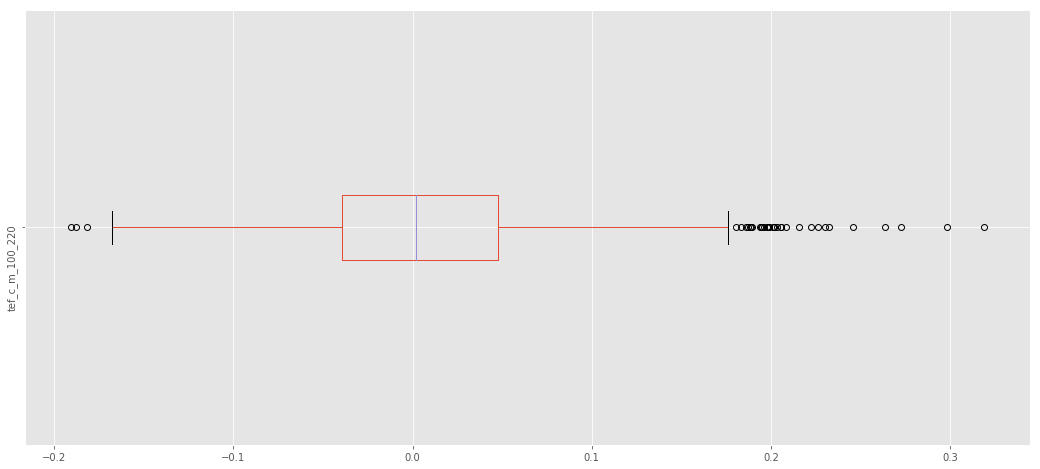

 el valor de 01p es : -0.14007 
 el valor de 05p es : -0.10102 
 el valor de 50p es : 0.0016498 
 el valor de 95p es : 0.12174 
 el valor de T-test es : 4.1304 
 el valor de avg es : 0.005 
 el valor de kur es : 0.4529 
 el valor de skw es : 0.37897 
 el valor de std es : 0.068385 
 el valor de val es : -1.2051 
 el valor de var es : 0.0046766 


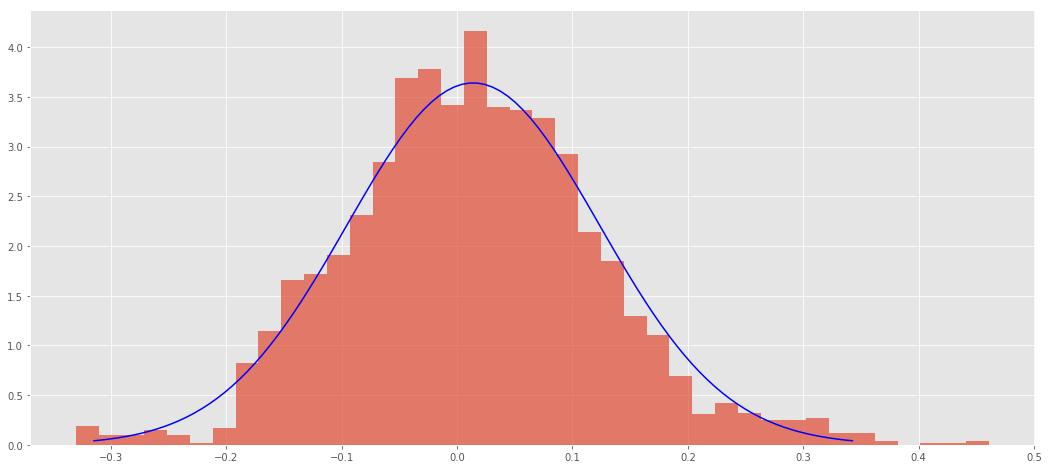

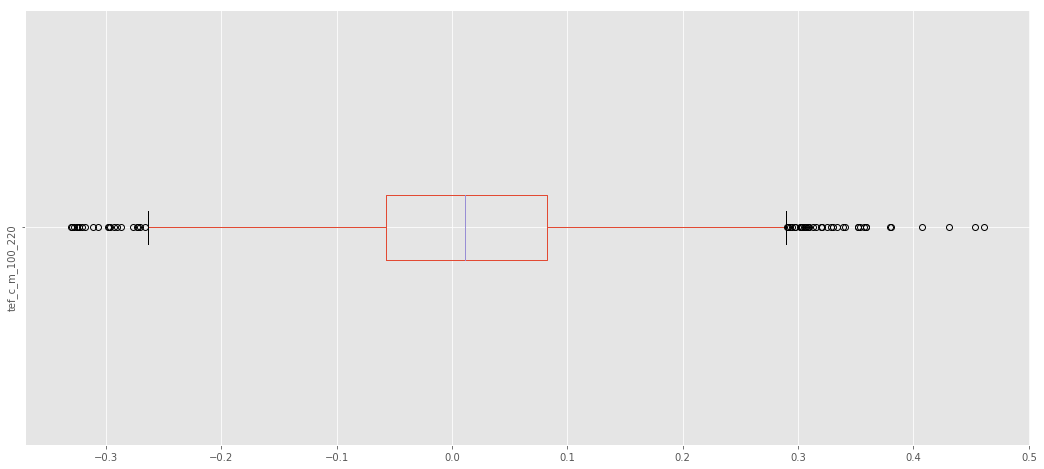

 el valor de 01p es : -0.25319 
 el valor de 05p es : -0.15518 
 el valor de 50p es : 0.011588 
 el valor de 95p es : 0.19296 
 el valor de T-test es : 6.4351 
 el valor de avg es : 0.014 
 el valor de kur es : 0.60399 
 el valor de skw es : 0.22207 
 el valor de std es : 0.10955 
 el valor de val es : -1.2434 
 el valor de var es : 0.012002 


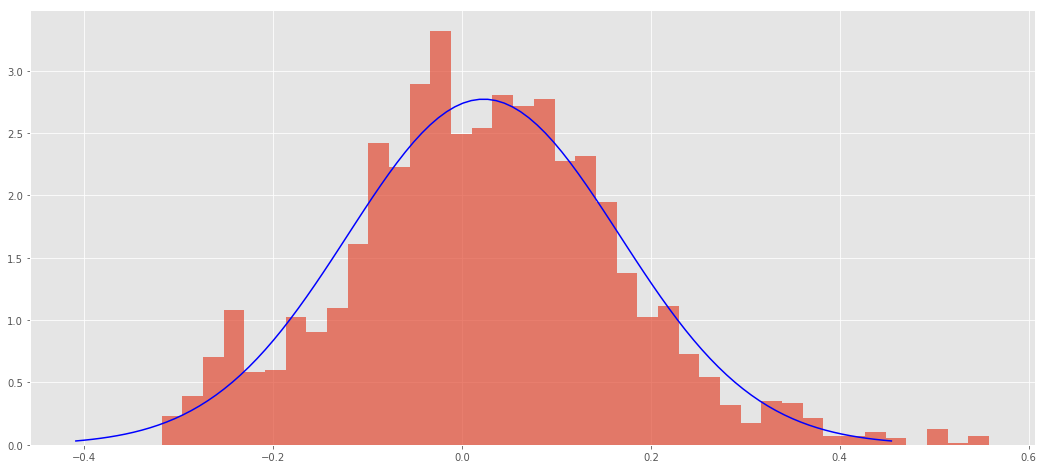

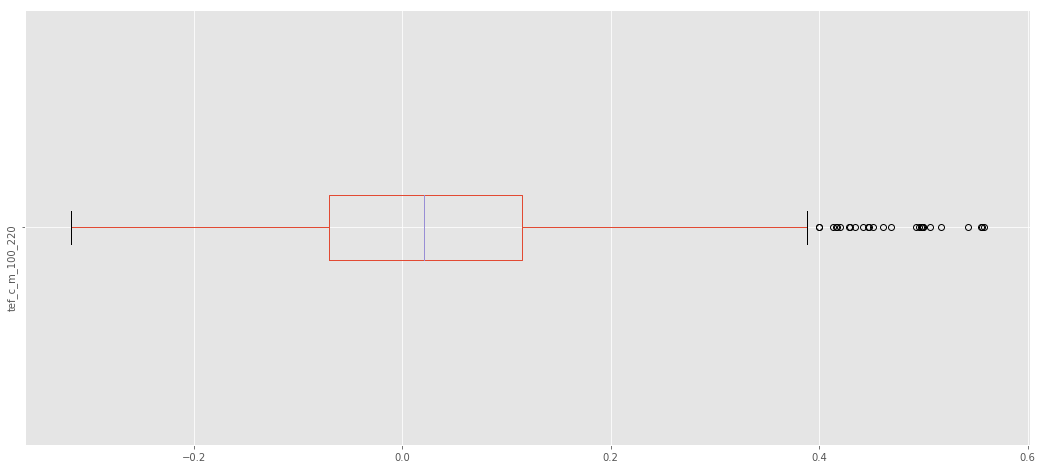

 el valor de 01p es : -0.28243 
 el valor de 05p es : -0.23344 
 el valor de 50p es : 0.020978 
 el valor de 95p es : 0.256 
 el valor de T-test es : 8.3916 
 el valor de avg es : 0.023 
 el valor de kur es : 0.33633 
 el valor de skw es : 0.22093 
 el valor de std es : 0.14388 
 el valor de val es : -1.0967 
 el valor de var es : 0.020702 


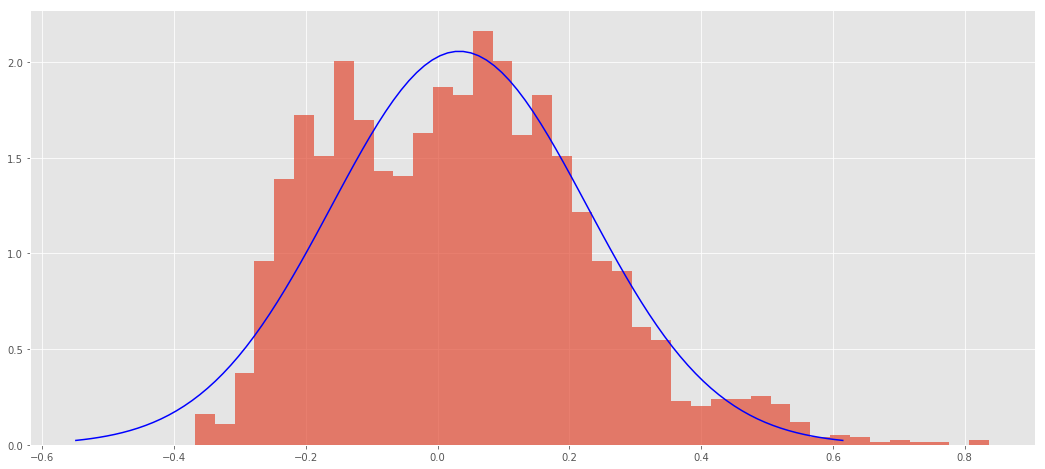

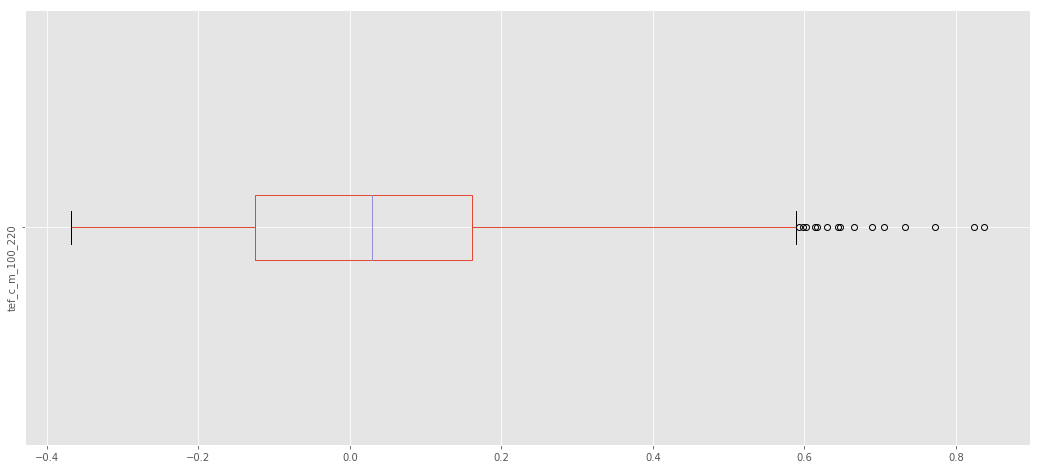

 el valor de 01p es : -0.29492 
 el valor de 05p es : -0.24605 
 el valor de 50p es : 0.029093 
 el valor de 95p es : 0.36682 
 el valor de T-test es : 8.7836 
 el valor de avg es : 0.033 
 el valor de kur es : 0.078651 
 el valor de skw es : 0.48552 
 el valor de std es : 0.19397 
 el valor de val es : -1.4909 
 el valor de var es : 0.037625 


In [57]:
fofo=fofo.T
fofo['nombre']=fofo.index
seleccion=fofo['nombre'][fofo['T-test']>4]
var95histmediasmascuatro={}
gg=seleccion
rango = [20,60,120,220]
for n in seleccion:
    for j in rango:
        soso="{}_+4_{}".format(n,j)
        #soso.append(n)
        #printsoso
        var95histmediasmascuatro[soso]=calculate_aggregate(g[n].pct_change(j))
        

<h4>Tabla de series co t-student > 4 y calculo de rendimiento mensual, trimestral, semestral y anual</h4>

In [58]:
ff=pd.DataFrame(var95histmediasmascuatro)
tabla=np.round(ff.T,3)
tabla

01p    05p    50p    95p  T-test    avg    kur  \
san_c_m_20_50_+4_20    -0.248 -0.128  0.006  0.175   7.542  0.015  3.415   
san_c_m_20_50_+4_60    -0.277 -0.183  0.027  0.325  13.136  0.042  3.058   
san_c_m_20_50_+4_120   -0.327 -0.220  0.050  0.536  19.288  0.088  1.450   
san_c_m_20_50_+4_220   -0.261 -0.211  0.077  0.910  25.692  0.177  2.831   
san_c_m_10_100_+4_20   -0.213 -0.141  0.002  0.166   5.049  0.009  2.298   
san_c_m_10_100_+4_60   -0.282 -0.207  0.011  0.361   8.045  0.027  2.506   
san_c_m_10_100_+4_120  -0.345 -0.265  0.005  0.575  11.224  0.058  2.687   
san_c_m_10_100_+4_220  -0.361 -0.297  0.026  0.856  15.678  0.107  2.057   
san_c_m_20_100_+4_20   -0.241 -0.129  0.006  0.169   7.094  0.013  2.641   
san_c_m_20_100_+4_60   -0.349 -0.228  0.021  0.363  11.675  0.039  2.664   
san_c_m_20_100_+4_120  -0.525 -0.272  0.052  0.573  16.525  0.083  2.824   
san_c_m_20_100_+4_220  -0.477 -0.369  0.104  0.796  23.310  0.150  0.948   
san_c_m_50_100_+4_20   -0.219 -0.143  0.001  0.166   4.024  0.008  2.224   
san_c_m_50_100_+4_60   -0.310 -0.236  0.018  0.353   6.432  0.023  1.935   
san_c_m_50_100_+4_120  -0.390 -0.313 -0.003  0.560   9.110  0.047  2.289   
san_c_m_50_100_+4_220  -0.391 -0.332  0.027  0.608  12.738  0.074  0.340   
san_c_m_20_220_+4_20   -0.216 -0.144  0.004  0.166   4.771  0.009  2.232   
san_c_m_20_220_+4_60   -0.333 -0.225  0.024  0.337   7.717  0.026  2.087   
san_c_m_20_220_+4_120  -0.349 -0.285  0.002  0.531  10.535  0.054  2.811   
san_c_m_20_220_+4_220  -0.485 -0.414  0.083  0.630  13.973  0.092  2.295   
san_c_m_50_220_+4_20   -0.209 -0.131  0.010  0.163   7.591  0.014  2.654   
san_c_m_50_220_+4_60   -0.335 -0.187  0.032  0.321  12.713  0.040  3.412   
san_c_m_50_220_+4_120  -0.307 -0.231  0.026  0.508  17.379  0.081  4.357   
san_c_m_50_220_+4_220  -0.400 -0.273  0.124  0.566  24.695  0.142  3.962   
itx_c_m_50_100_+4_20   -0.198 -0.111  0.008  0.117   4.258  0.006  1.459   
itx_c_m_50_100_+4_60   -0.323 -0.197  0.022  0.208   7.216  0.017  0.120   
itx_c_m_50_100_+4_120  -0.451 -0.273  0.039  0.366  11.063  0.043 -0.041   
itx_c_m_50_100_+4_220  -0.534 -0.430  0.084  0.627  15.957  0.090 -0.218   
itx_c_m_10_220_+4_20   -0.235 -0.102  0.011  0.125   6.792  0.010  1.540   
itx_c_m_10_220_+4_60   -0.291 -0.178  0.031  0.227  11.949  0.029 -0.185   
itx_c_m_10_220_+4_120  -0.421 -0.211  0.056  0.371  17.946  0.064 -0.075   
itx_c_m_10_220_+4_220  -0.451 -0.272  0.091  0.627  22.975  0.122 -0.474   
itx_c_m_20_220_+4_20   -0.200 -0.114  0.011  0.126   6.707  0.009  1.047   
itx_c_m_20_220_+4_60   -0.276 -0.195  0.034  0.227  11.618  0.029 -0.341   
itx_c_m_20_220_+4_120  -0.413 -0.199  0.043  0.371  17.365  0.062 -0.146   
itx_c_m_20_220_+4_220  -0.450 -0.267  0.077  0.628  22.069  0.117 -0.512   
itx_c_m_50_220_+4_20   -0.191 -0.091  0.016  0.130  11.414  0.016  1.466   
itx_c_m_50_220_+4_60   -0.241 -0.158  0.043  0.241  20.564  0.048 -0.049   
itx_c_m_50_220_+4_120  -0.295 -0.187  0.087  0.395  30.240  0.104 -0.158   
itx_c_m_50_220_+4_220  -0.272 -0.220  0.183  0.678  38.534  0.203 -0.596   
itx_c_m_100_220_+4_20  -0.144 -0.084  0.018  0.136  15.157  0.021  2.178   
itx_c_m_100_220_+4_60  -0.174 -0.124  0.052  0.266  26.036  0.065  1.634   
itx_c_m_100_220_+4_120 -0.177 -0.129  0.127  0.444  40.431  0.137 -0.004   
itx_c_m_100_220_+4_220 -0.256 -0.159  0.249  0.740  49.906  0.276 -0.034   
tef_c_m_50_220_+4_20   -0.141 -0.097  0.005  0.127   7.160  0.009  0.562   
tef_c_m_50_220_+4_60   -0.261 -0.129  0.022  0.198  12.523  0.025  1.098   
tef_c_m_50_220_+4_120  -0.265 -0.146  0.030  0.266  18.740  0.046  0.975   
tef_c_m_50_220_+4_220  -0.214 -0.154  0.056  0.367  23.751  0.075  0.687   
tef_c_m_100_220_+4_20  -0.140 -0.101  0.002  0.122   4.130  0.005  0.453   
tef_c_m_100_220_+4_60  -0.253 -0.155  0.012  0.193   6.435  0.014  0.604   
tef_c_m_100_220_+4_120 -0.282 -0.233  0.021  0.256   8.392  0.023  0.336   
tef_c_m_100_220_+4_220 -0.295 -0.246  0.029  0.367   8.784  0.033  0.079  

In [59]:
ff.columns

Index(['san_c_m_20_50_+4_20', 'san_c_m_20_50_+4_60', 'san_c_m_20_50_+4_120',
       'san_c_m_20_50_+4_220', 'san_c_m_10_100_+4_20', 'san_c_m_10_100_+4_60',
       'san_c_m_10_100_+4_120', 'san_c_m_10_100_+4_220',
       'san_c_m_20_100_+4_20', 'san_c_m_20_100_+4_60', 'san_c_m_20_100_+4_120',
       'san_c_m_20_100_+4_220', 'san_c_m_50_100_+4_20', 'san_c_m_50_100_+4_60',
       'san_c_m_50_100_+4_120', 'san_c_m_50_100_+4_220',
       'san_c_m_20_220_+4_20', 'san_c_m_20_220_+4_60', 'san_c_m_20_220_+4_120',
       'san_c_m_20_220_+4_220', 'san_c_m_50_220_+4_20', 'san_c_m_50_220_+4_60',
       'san_c_m_50_220_+4_120', 'san_c_m_50_220_+4_220',
       'itx_c_m_50_100_+4_20', 'itx_c_m_50_100_+4_60', 'itx_c_m_50_100_+4_120',
       'itx_c_m_50_100_+4_220', 'itx_c_m_10_220_+4_20', 'itx_c_m_10_220_+4_60',
       'itx_c_m_10_220_+4_120', 'itx_c_m_10_220_+4_220',
       'itx_c_m_20_220_+4_20', 'itx_c_m_20_220_+4_60', 'itx_c_m_20_220_+4_120',
       'itx_c_m_20_220_+4_220', 'itx_c_m_50_220_+4_20', 

<h4>Gráfico de itx con sistema de cruce de medias 100 - 220</h4>

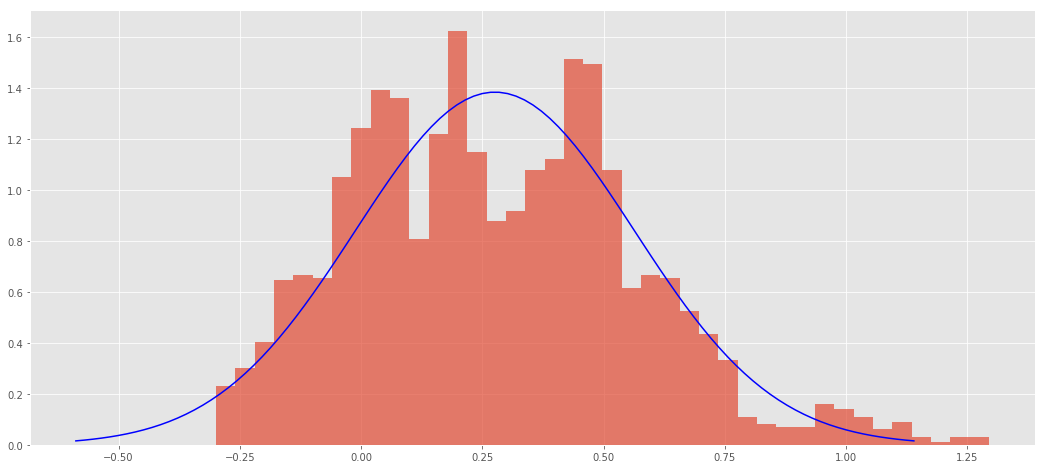

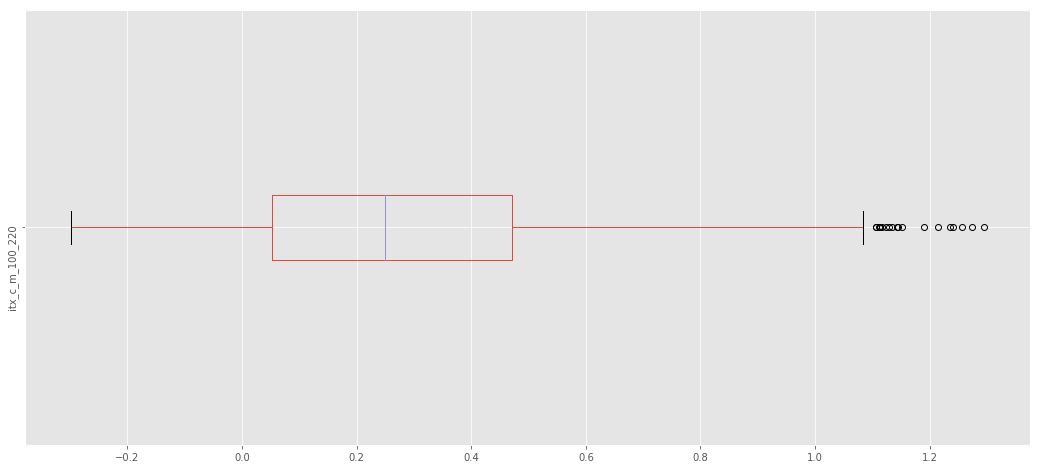

 el valor de 01p es : -0.25569 
 el valor de 05p es : -0.15932 
 el valor de 50p es : 0.24916 
 el valor de 95p es : 0.74048 
 el valor de T-test es : 49.906 
 el valor de avg es : 0.276 
 el valor de kur es : -0.033986 
 el valor de skw es : 0.4251 
 el valor de std es : 0.288 
 el valor de val es : -4.6477 
 el valor de var es : 0.082944 


{'01p': -0.2556940642703661,
 '05p': -0.15932375910750163,
 '50p': 0.24916257144692566,
 '95p': 0.7404821193157076,
 'T-test': 49.90562204944721,
 'avg': 0.276,
 'kur': -0.033986038911924865,
 'skw': 0.42509894543123655,
 'std': 0.2880000304992841,
 'val': -4.647656592235418,
 'var': 0.08294401756758855}

In [60]:
calculate_aggregate(g['itx_c_m_100_220'].pct_change(220))

In [61]:
#g.loc[:,'itx_cruce_medias_100_200_11']=g['itx_cruce_medias_100_200'].values/0.08
#g['itx_cruce_medias_100_200'].plot()
# g['itx_cruce_medias_100_200_10%'].plot()

In [62]:
selector=g.filter(like='itx',axis=1).columns.values
h=g[selector]
h.columns

Index(['itx_c_m_10_20', 'itx_c_m_10_50', 'itx_c_m_20_50', 'itx_c_m_10_100',
       'itx_c_m_20_100', 'itx_c_m_50_100', 'itx_c_m_10_220', 'itx_c_m_20_220',
       'itx_c_m_50_220', 'itx_c_m_100_220'],
      dtype='object')

In [63]:
g.columns

Index(['san_c_m_10_20', 'san_c_m_10_50', 'san_c_m_20_50', 'san_c_m_10_100',
       'san_c_m_20_100', 'san_c_m_50_100', 'san_c_m_10_220', 'san_c_m_20_220',
       'san_c_m_50_220', 'san_c_m_100_220', 'itx_c_m_10_20', 'itx_c_m_10_50',
       'itx_c_m_20_50', 'itx_c_m_10_100', 'itx_c_m_20_100', 'itx_c_m_50_100',
       'itx_c_m_10_220', 'itx_c_m_20_220', 'itx_c_m_50_220', 'itx_c_m_100_220',
       'tef_c_m_10_20', 'tef_c_m_10_50', 'tef_c_m_20_50', 'tef_c_m_10_100',
       'tef_c_m_20_100', 'tef_c_m_50_100', 'tef_c_m_10_220', 'tef_c_m_20_220',
       'tef_c_m_50_220', 'tef_c_m_100_220'],
      dtype='object')

---

# Sistema mayor del -15%

<p>Dado que podemos utilizar el var para determinar apartir de que % dejamos de operar un sistema, podemos hacer un pequeño análsis situando esta barrera en el -15%

In [64]:
#crear sistema menor que el 10%
def crossover_tanto(values,tanto=-.10,change=20):
    
    df=pd.DataFrame()
    #print type(values)
    df['base']=values.copy()
    #print df.base.tail()
    df['logvalues']=np.log(df.base / df.base.shift(1))
    df['pctvalues']=df['base'].pct_change(change).fillna(1)
    df['senal']=np.where(df.pctvalues>tanto,1,0)
    df['senal']=df['senal']
    #.senal.plot(secondary_y=True)
    #print df.logvalues
    df['rendimiento']=df.senal.shift()*df.logvalues
    df['rendimiento']=df['rendimiento'].fillna(0)
    df['rendimiento'][0]=np.log(df['base'][0])
    df['serie']=np.exp(df.rendimiento.cumsum())
    
    return df.serie

In [65]:
h.columns

Index(['itx_c_m_10_20', 'itx_c_m_10_50', 'itx_c_m_20_50', 'itx_c_m_10_100',
       'itx_c_m_20_100', 'itx_c_m_50_100', 'itx_c_m_10_220', 'itx_c_m_20_220',
       'itx_c_m_50_220', 'itx_c_m_100_220'],
      dtype='object')

<h4>Gráficos de los sistemas limitando la pérdida al -15%</h4>

In [66]:
seleccion=h.filter(like='_c_m',axis=1).columns.values
var95histmedias10={}

tanto=-.15
for n in seleccion:
      h['{}_c_t_{}'.format(n,tanto)]=crossover_tanto(g['{}'.format(n)],tanto,change=20)


In [67]:
h.columns

Index(['itx_c_m_10_20', 'itx_c_m_10_50', 'itx_c_m_20_50', 'itx_c_m_10_100',
       'itx_c_m_20_100', 'itx_c_m_50_100', 'itx_c_m_10_220', 'itx_c_m_20_220',
       'itx_c_m_50_220', 'itx_c_m_100_220', 'itx_c_m_10_20_c_t_-0.15',
       'itx_c_m_10_50_c_t_-0.15', 'itx_c_m_20_50_c_t_-0.15',
       'itx_c_m_10_100_c_t_-0.15', 'itx_c_m_20_100_c_t_-0.15',
       'itx_c_m_50_100_c_t_-0.15', 'itx_c_m_10_220_c_t_-0.15',
       'itx_c_m_20_220_c_t_-0.15', 'itx_c_m_50_220_c_t_-0.15',
       'itx_c_m_100_220_c_t_-0.15'],
      dtype='object')

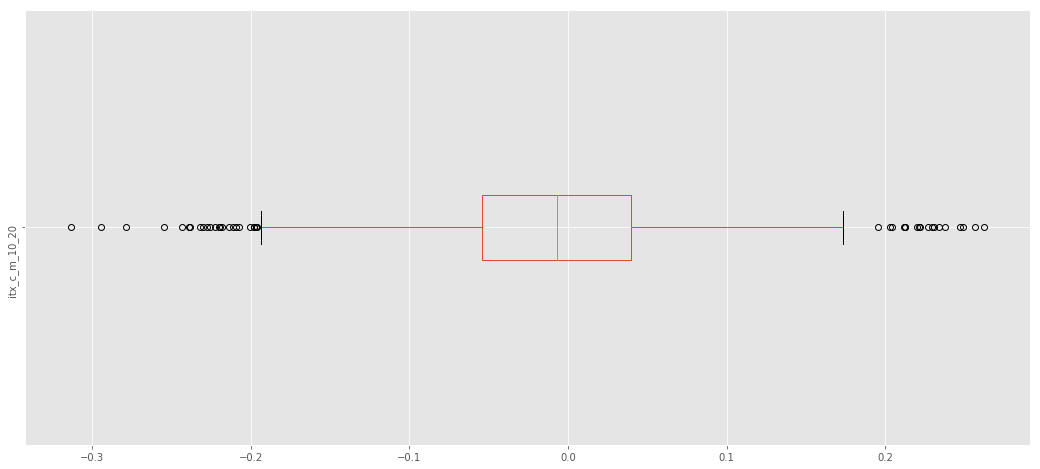

 el valor de 01p es : -0.19052 
 el valor de 05p es : -0.12303 
 el valor de 50p es : -0.0067361 
 el valor de 95p es : 0.11424 
 el valor de T-test es : -4.5365 
 el valor de avg es : -0.006 
 el valor de kur es : 0.59543 
 el valor de skw es : -0.015249 
 el valor de std es : 0.073572 
 el valor de val es : -0.92854 
 el valor de var es : 0.0054128 


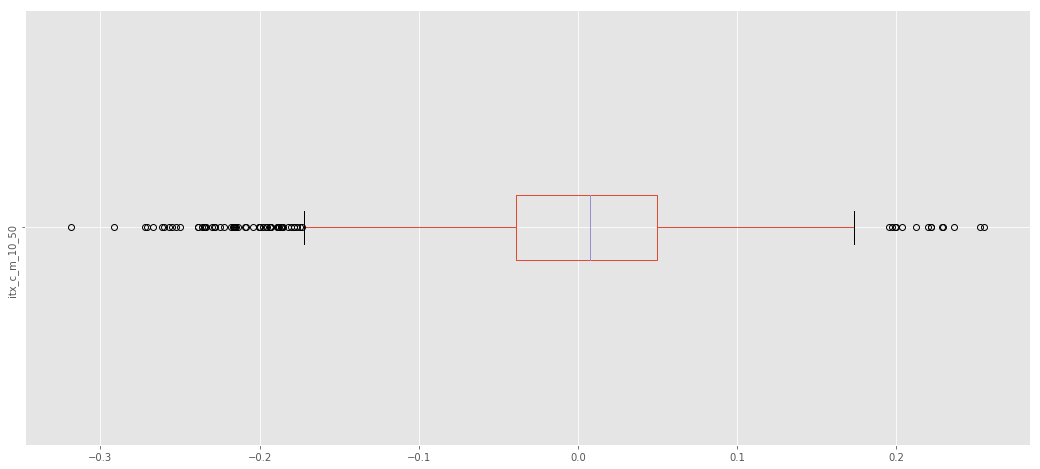

 el valor de 01p es : -0.21549 
 el valor de 05p es : -0.11873 
 el valor de 50p es : 0.0075141 
 el valor de 95p es : 0.11541 
 el valor de T-test es : 2.4815 
 el valor de avg es : 0.003 
 el valor de kur es : 1.0395 
 el valor de skw es : -0.44716 
 el valor de std es : 0.073119 
 el valor de val es : -0.97198 
 el valor de var es : 0.0053465 


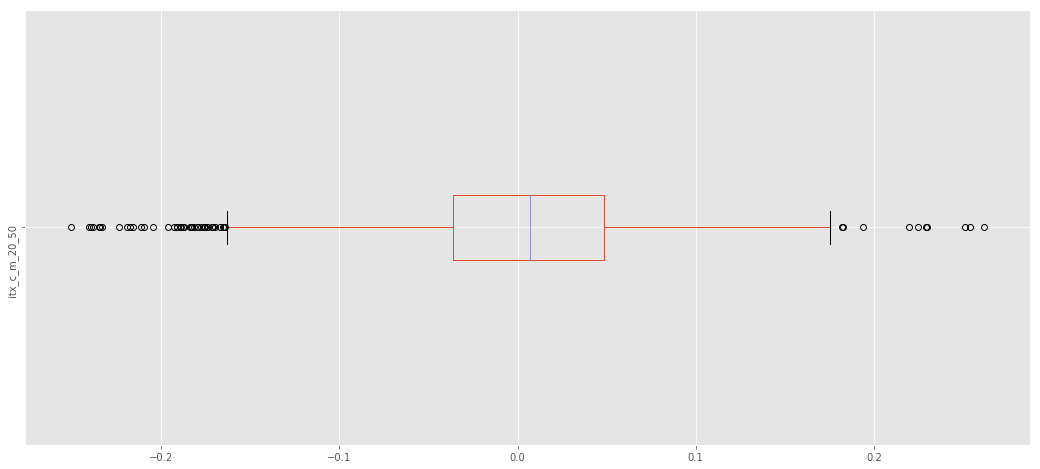

 el valor de 01p es : -0.1794 
 el valor de 05p es : -0.10802 
 el valor de 50p es : 0.0071159 
 el valor de 95p es : 0.11405 
 el valor de T-test es : 3.7057 
 el valor de avg es : 0.005 
 el valor de kur es : 0.61312 
 el valor de skw es : -0.24011 
 el valor de std es : 0.068181 
 el valor de val es : -1.0558 
 el valor de var es : 0.0046486 


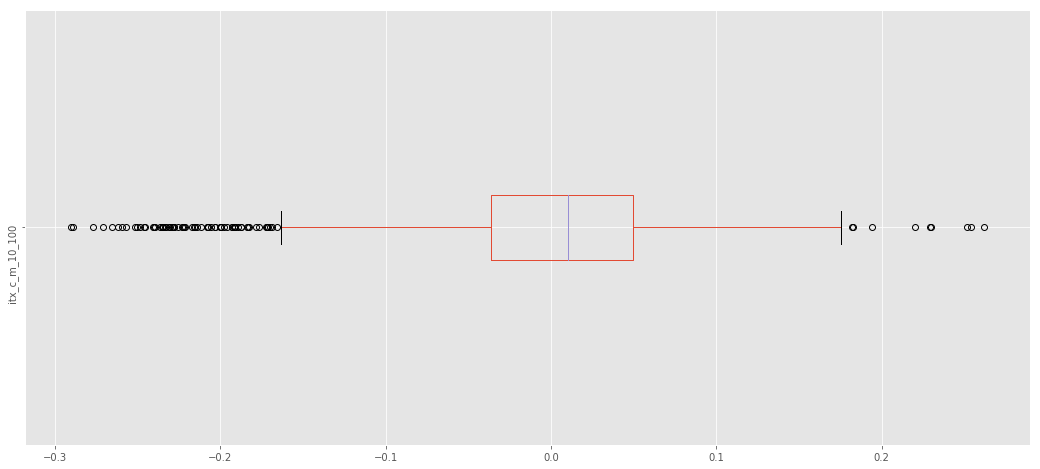

 el valor de 01p es : -0.228 
 el valor de 05p es : -0.1191 
 el valor de 50p es : 0.010159 
 el valor de 95p es : 0.11664 
 el valor de T-test es : 3.3833 
 el valor de avg es : 0.005 
 el valor de kur es : 1.2534 
 el valor de skw es : -0.58662 
 el valor de std es : 0.073291 
 el valor de val es : -0.97934 
 el valor de var es : 0.0053716 


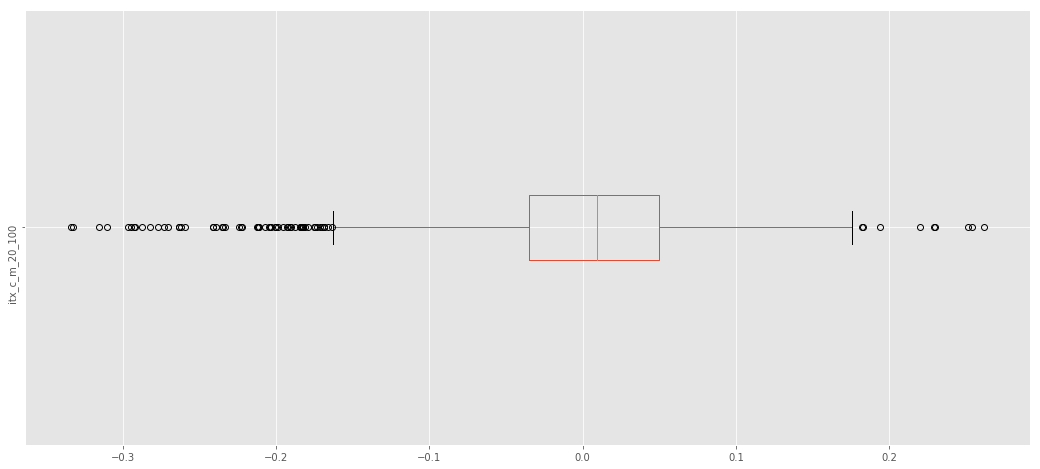

 el valor de 01p es : -0.2119 
 el valor de 05p es : -0.11657 
 el valor de 50p es : 0.009584 
 el valor de 95p es : 0.11679 
 el valor de T-test es : 3.8461 
 el valor de avg es : 0.005 
 el valor de kur es : 1.6859 
 el valor de skw es : -0.63731 
 el valor de std es : 0.072765 
 el valor de val es : -1.0019 
 el valor de var es : 0.0052947 


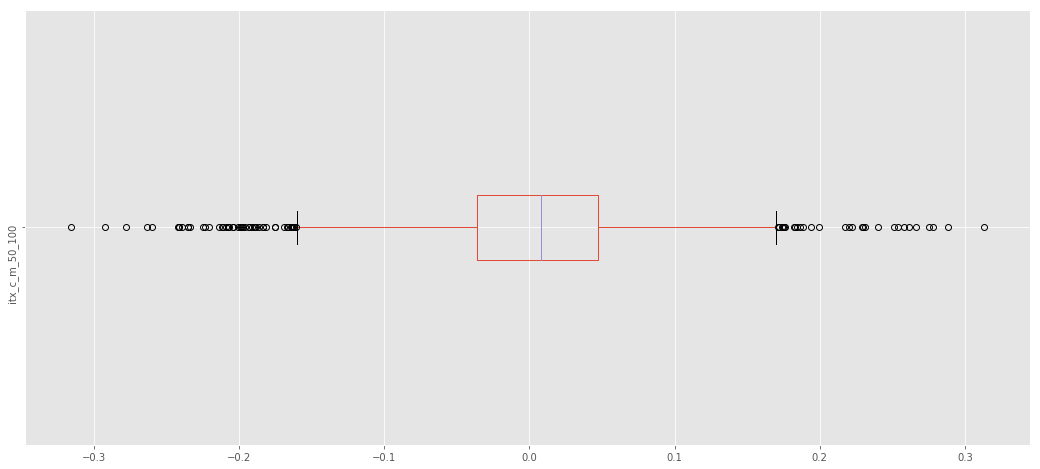

 el valor de 01p es : -0.19819 
 el valor de 05p es : -0.11056 
 el valor de 50p es : 0.0081278 
 el valor de 95p es : 0.11741 
 el valor de T-test es : 4.258 
 el valor de avg es : 0.006 
 el valor de kur es : 1.4595 
 el valor de skw es : -0.19723 
 el valor de std es : 0.070759 
 el valor de val es : -1.062 
 el valor de var es : 0.0050068 


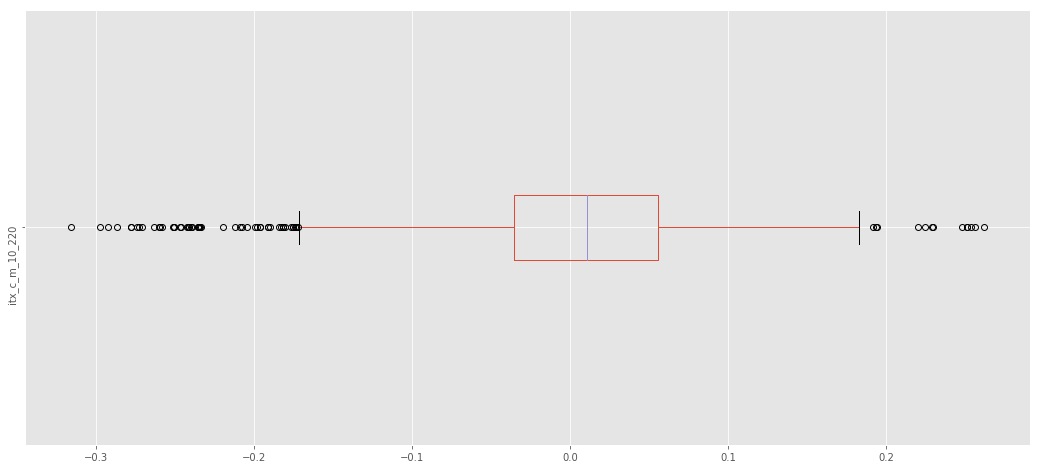

 el valor de 01p es : -0.23491 
 el valor de 05p es : -0.10246 
 el valor de 50p es : 0.010986 
 el valor de 95p es : 0.12484 
 el valor de T-test es : 6.7923 
 el valor de avg es : 0.01 
 el valor de kur es : 1.5401 
 el valor de skw es : -0.46052 
 el valor de std es : 0.073029 
 el valor de val es : -1.2185 
 el valor de var es : 0.0053332 


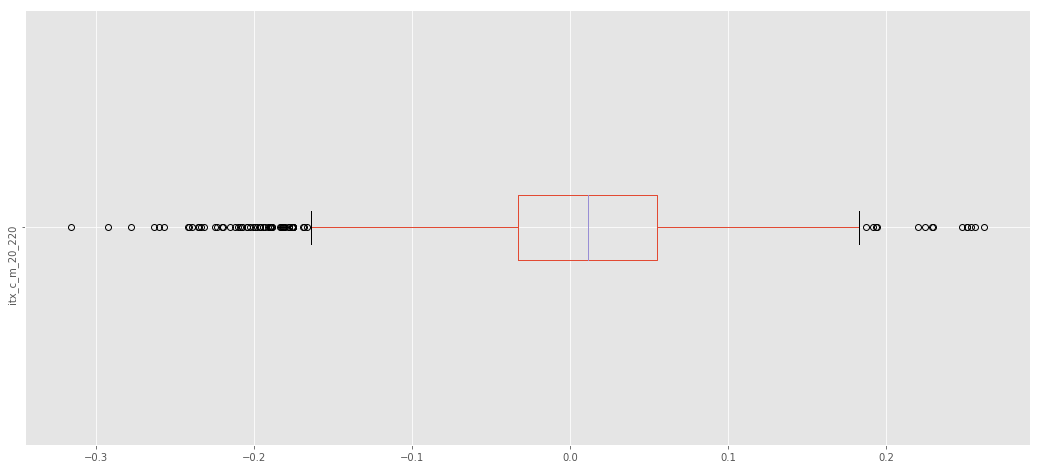

 el valor de 01p es : -0.19954 
 el valor de 05p es : -0.11418 
 el valor de 50p es : 0.011389 
 el valor de 95p es : 0.12555 
 el valor de T-test es : 6.707 
 el valor de avg es : 0.009 
 el valor de kur es : 1.0469 
 el valor de skw es : -0.3765 
 el valor de std es : 0.072918 
 el valor de val es : -1.0996 
 el valor de var es : 0.0053171 


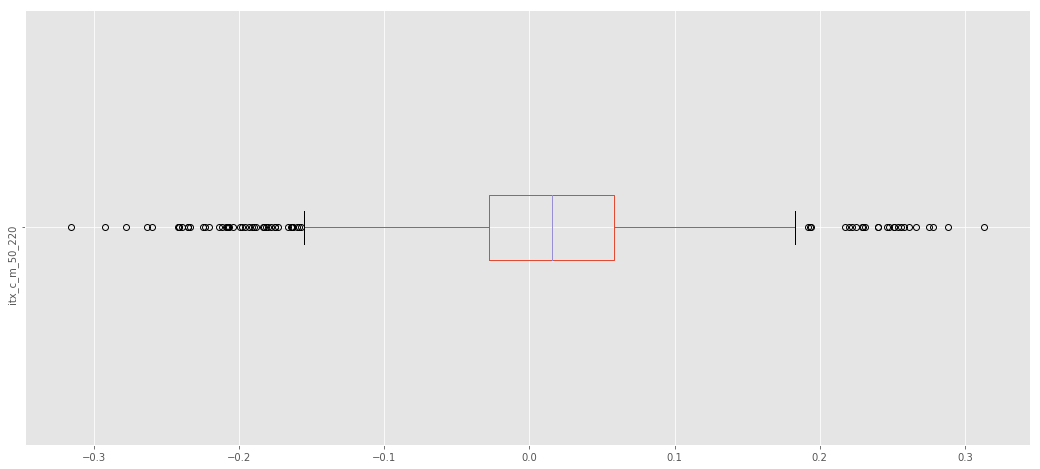

 el valor de 01p es : -0.19142 
 el valor de 05p es : -0.091313 
 el valor de 50p es : 0.015692 
 el valor de 95p es : 0.13037 
 el valor de T-test es : 11.414 
 el valor de avg es : 0.016 
 el valor de kur es : 1.4664 
 el valor de skw es : -0.14343 
 el valor de std es : 0.071276 
 el valor de val es : -1.4278 
 el valor de var es : 0.0050802 


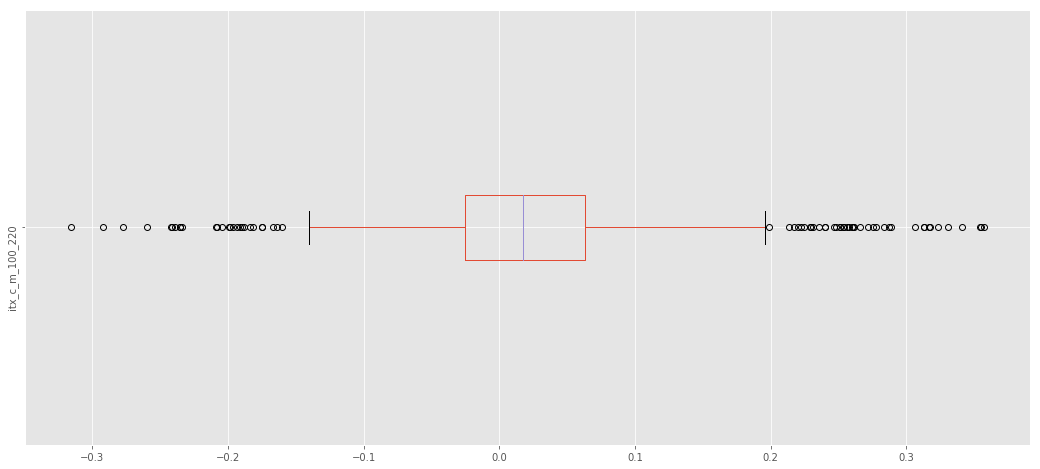

 el valor de 01p es : -0.14351 
 el valor de 05p es : -0.083927 
 el valor de 50p es : 0.017856 
 el valor de 95p es : 0.13642 
 el valor de T-test es : 15.157 
 el valor de avg es : 0.021 
 el valor de kur es : 2.1776 
 el valor de skw es : 0.36453 
 el valor de std es : 0.072563 
 el valor de val es : -1.6255 
 el valor de var es : 0.0052653 


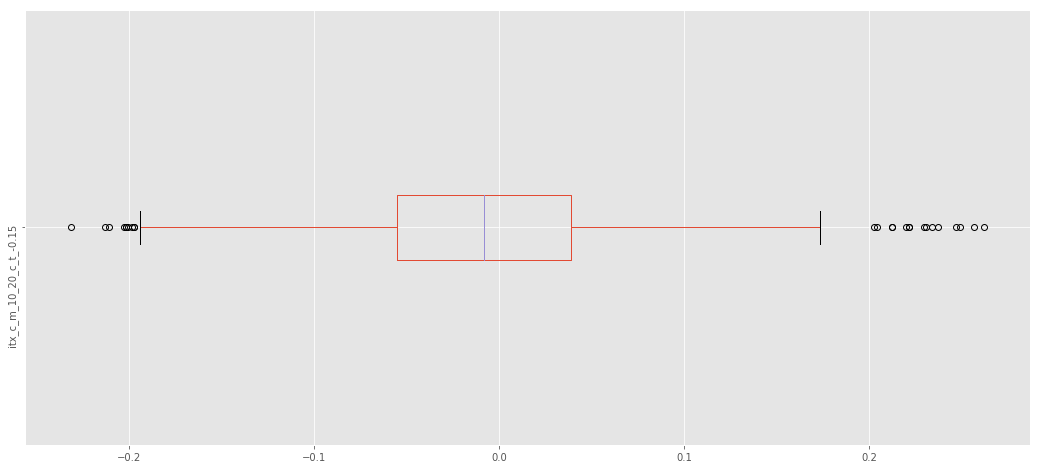

 el valor de 01p es : -0.17363 
 el valor de 05p es : -0.11842 
 el valor de 50p es : -0.0082743 
 el valor de 95p es : 0.10997 
 el valor de T-test es : -5.0101 
 el valor de avg es : -0.007 
 el valor de kur es : 0.26927 
 el valor de skw es : 0.13826 
 el valor de std es : 0.070376 
 el valor de val es : -0.92864 
 el valor de var es : 0.0049528 


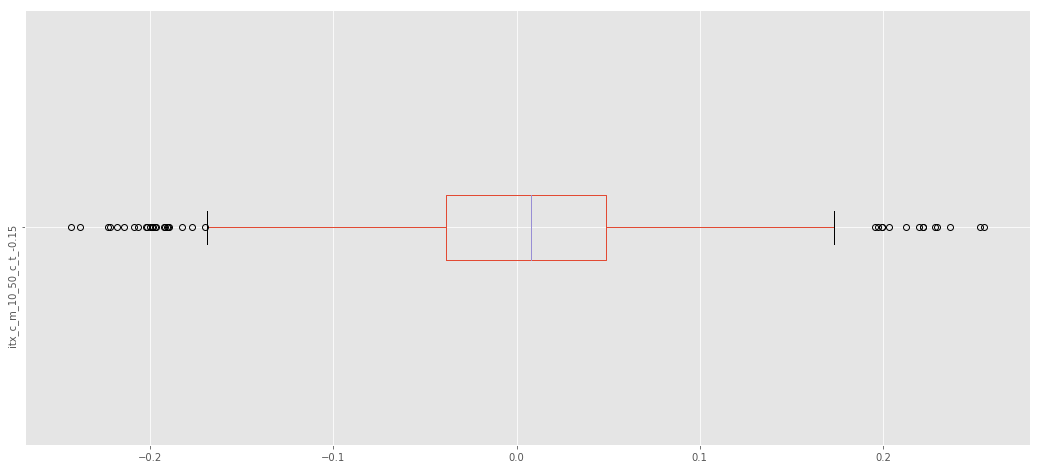

 el valor de 01p es : -0.16167 
 el valor de 05p es : -0.11036 
 el valor de 50p es : 0.00802 
 el valor de 95p es : 0.1126 
 el valor de T-test es : 3.8113 
 el valor de avg es : 0.005 
 el valor de kur es : 0.3581 
 el valor de skw es : -0.14589 
 el valor de std es : 0.068607 
 el valor de val es : -1.0203 
 el valor de var es : 0.0047069 


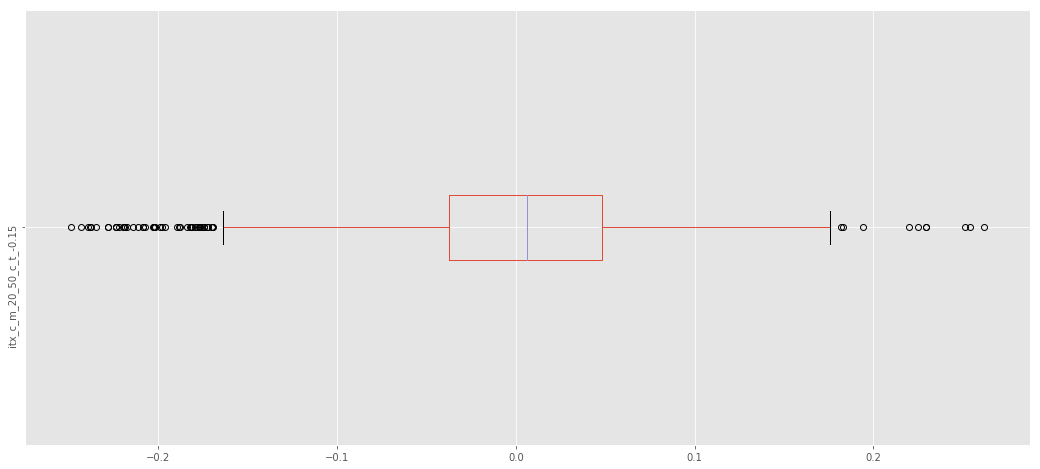

 el valor de 01p es : -0.19657 
 el valor de 05p es : -0.11104 
 el valor de 50p es : 0.0064049 
 el valor de 95p es : 0.11405 
 el valor de T-test es : 2.9419 
 el valor de avg es : 0.004 
 el valor de kur es : 0.72235 
 el valor de skw es : -0.30239 
 el valor de std es : 0.069319 
 el valor de val es : -1.0271 
 el valor de var es : 0.0048051 


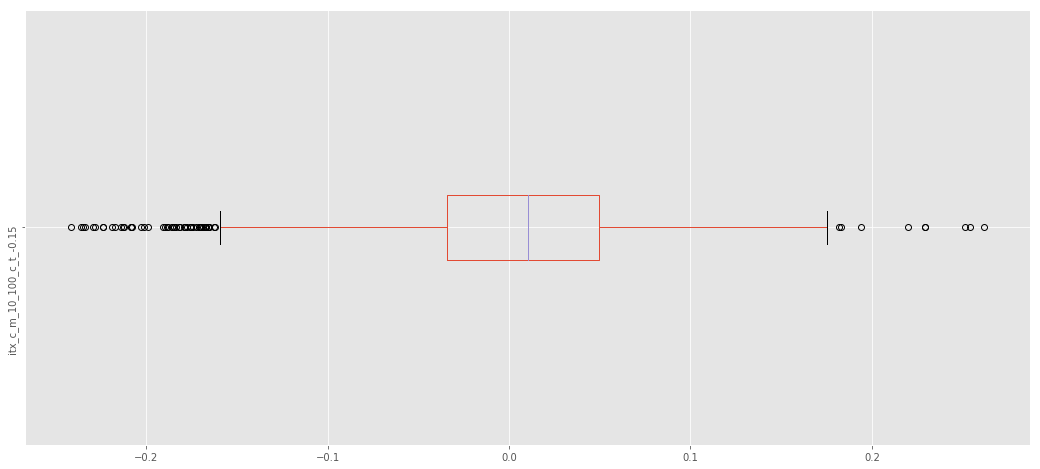

 el valor de 01p es : -0.18397 
 el valor de 05p es : -0.11534 
 el valor de 50p es : 0.010343 
 el valor de 95p es : 0.11566 
 el valor de T-test es : 4.9026 
 el valor de avg es : 0.007 
 el valor de kur es : 0.64985 
 el valor de skw es : -0.35195 
 el valor de std es : 0.069521 
 el valor de val es : -1.0028 
 el valor de var es : 0.0048332 


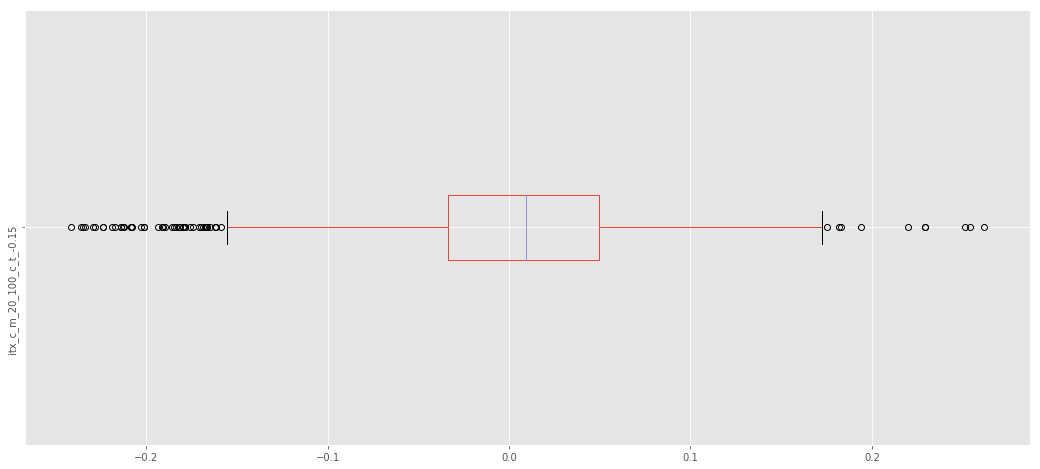

 el valor de 01p es : -0.18218 
 el valor de 05p es : -0.10912 
 el valor de 50p es : 0.0092648 
 el valor de 95p es : 0.11664 
 el valor de T-test es : 5.3252 
 el valor de avg es : 0.007 
 el valor de kur es : 0.6734 
 el valor de skw es : -0.29113 
 el valor de std es : 0.068218 
 el valor de val es : -1.0689 
 el valor de var es : 0.0046537 


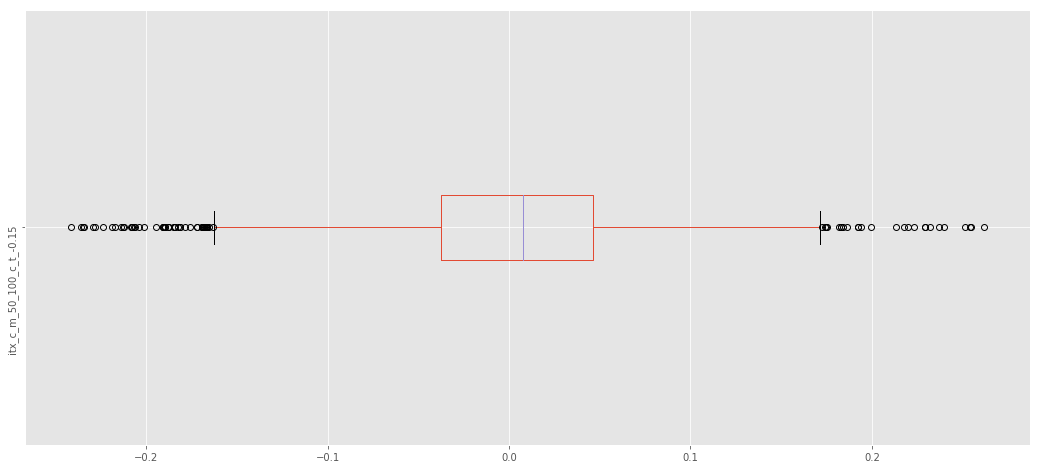

 el valor de 01p es : -0.18767 
 el valor de 05p es : -0.11697 
 el valor de 50p es : 0.0078668 
 el valor de 95p es : 0.11679 
 el valor de T-test es : 3.0797 
 el valor de avg es : 0.004 
 el valor de kur es : 0.80341 
 el valor de skw es : -0.19667 
 el valor de std es : 0.070175 
 el valor de val es : -0.99848 
 el valor de var es : 0.0049246 


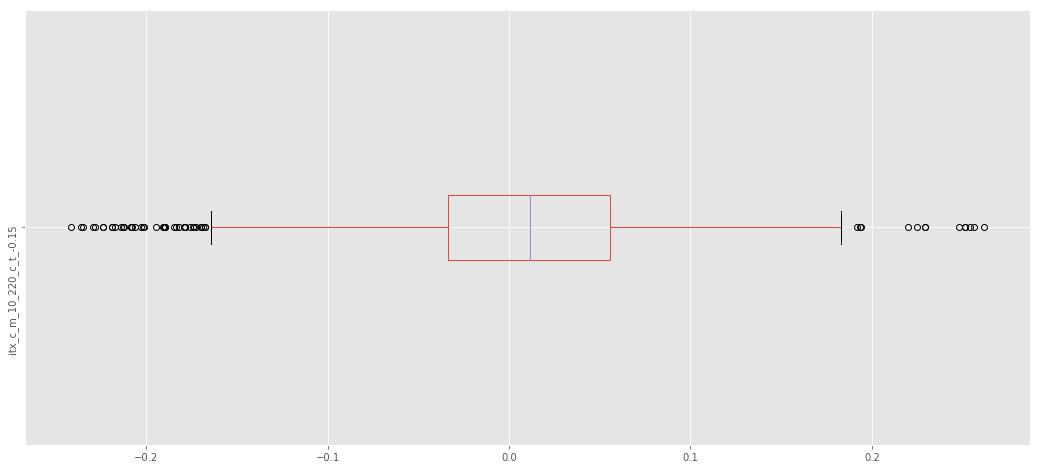

 el valor de 01p es : -0.18218 
 el valor de 05p es : -0.098536 
 el valor de 50p es : 0.0115 
 el valor de 95p es : 0.12427 
 el valor de T-test es : 8.2532 
 el valor de avg es : 0.011 
 el valor de kur es : 0.65873 
 el valor de skw es : -0.17248 
 el valor de std es : 0.069523 
 el valor de val es : -1.2612 
 el valor de var es : 0.0048334 


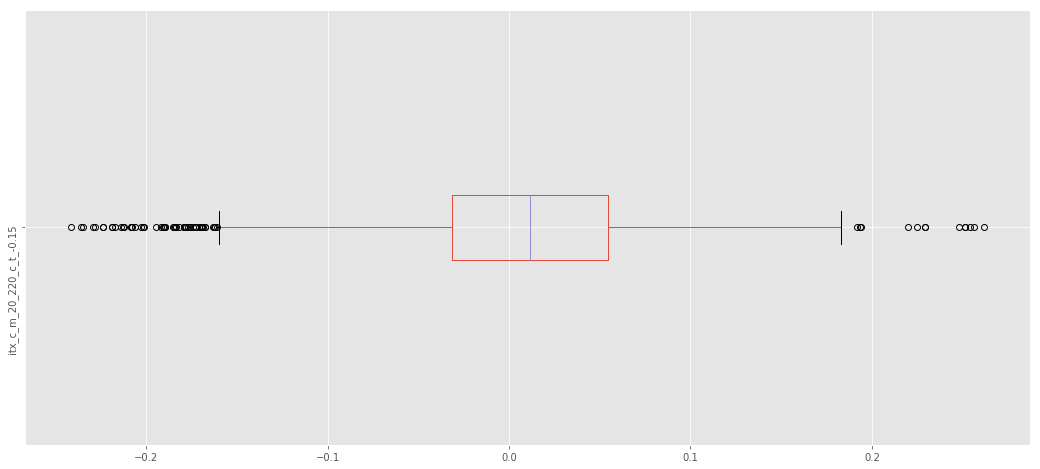

 el valor de 01p es : -0.185 
 el valor de 05p es : -0.10365 
 el valor de 50p es : 0.011678 
 el valor de 95p es : 0.12303 
 el valor de T-test es : 7.6953 
 el valor de avg es : 0.01 
 el valor de kur es : 0.75959 
 el valor de skw es : -0.25262 
 el valor de std es : 0.070229 
 el valor de val es : -1.187 
 el valor de var es : 0.0049322 


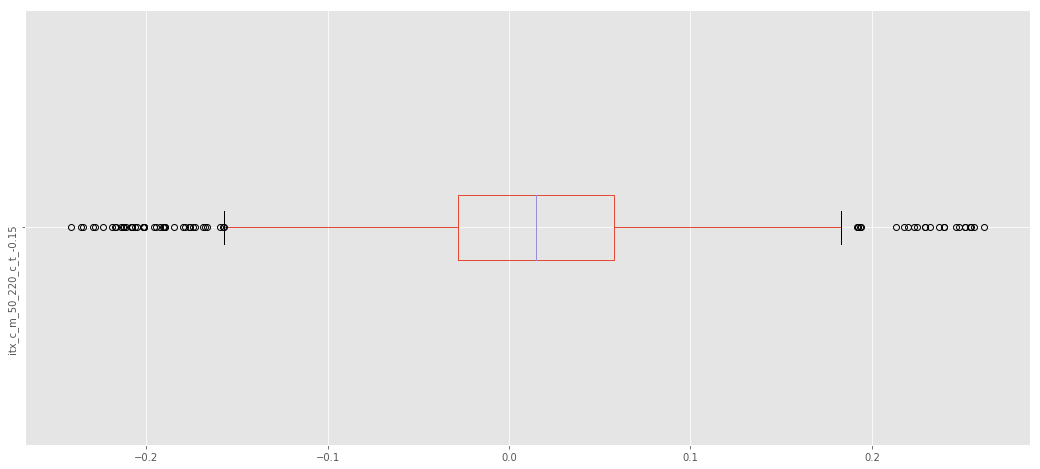

 el valor de 01p es : -0.18993 
 el valor de 05p es : -0.095151 
 el valor de 50p es : 0.014633 
 el valor de 95p es : 0.12979 
 el valor de T-test es : 11.039 
 el valor de avg es : 0.015 
 el valor de kur es : 0.90376 
 el valor de skw es : -0.11332 
 el valor de std es : 0.070191 
 el valor de val es : -1.364 
 el valor de var es : 0.0049268 


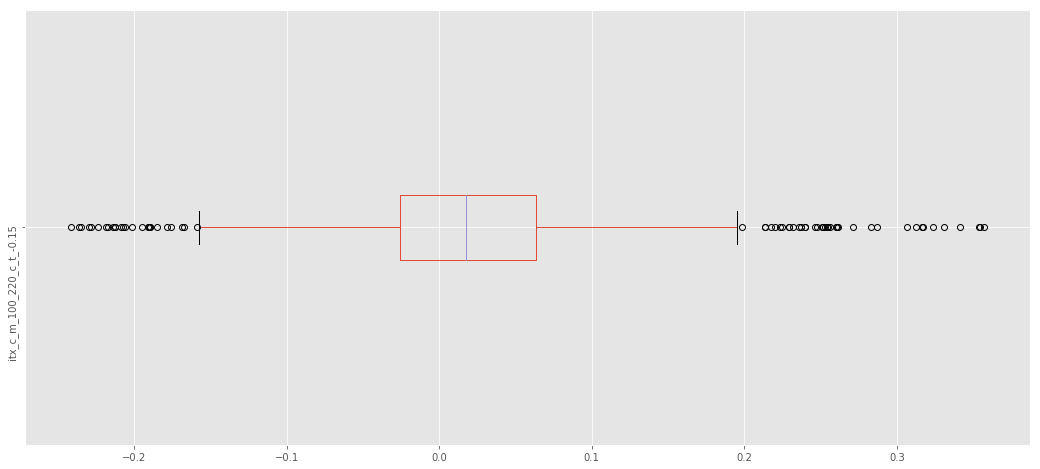

 el valor de 01p es : -0.15567 
 el valor de 05p es : -0.084992 
 el valor de 50p es : 0.01776 
 el valor de 95p es : 0.1363 
 el valor de T-test es : 14.97 
 el valor de avg es : 0.021 
 el valor de kur es : 1.8189 
 el valor de skw es : 0.3656 
 el valor de std es : 0.071887 
 el valor de val es : -1.6037 
 el valor de var es : 0.0051678 


In [68]:
selector=h.filter(like='c_m',axis=1).columns.values
var95histmedias10={}
for n in selector:
    sel="{}".format(n)
    #soso.append(n)
    #printsoso
    var95histmedias10[sel]=calculate_aggregate(h[sel].pct_change(20),False)

<h4>Tabla comparando los sistemas con límite y sin límite al -15%</h4>

In [69]:
fofo=pd.DataFrame(var95histmedias10)
np.round(fofo.T,3)

01p    05p    50p    95p  T-test    avg    kur  \
itx_c_m_10_20             -0.191 -0.123 -0.007  0.114  -4.536 -0.006  0.595   
itx_c_m_10_50             -0.215 -0.119  0.008  0.115   2.481  0.003  1.039   
itx_c_m_20_50             -0.179 -0.108  0.007  0.114   3.706  0.005  0.613   
itx_c_m_10_100            -0.228 -0.119  0.010  0.117   3.383  0.005  1.253   
itx_c_m_20_100            -0.212 -0.117  0.010  0.117   3.846  0.005  1.686   
itx_c_m_50_100            -0.198 -0.111  0.008  0.117   4.258  0.006  1.459   
itx_c_m_10_220            -0.235 -0.102  0.011  0.125   6.792  0.010  1.540   
itx_c_m_20_220            -0.200 -0.114  0.011  0.126   6.707  0.009  1.047   
itx_c_m_50_220            -0.191 -0.091  0.016  0.130  11.414  0.016  1.466   
itx_c_m_100_220           -0.144 -0.084  0.018  0.136  15.157  0.021  2.178   
itx_c_m_10_20_c_t_-0.15   -0.174 -0.118 -0.008  0.110  -5.010 -0.007  0.269   
itx_c_m_10_50_c_t_-0.15   -0.162 -0.110  0.008  0.113   3.811  0.005  0.358   
itx_c_m_20_50_c_t_-0.15   -0.197 -0.111  0.006  0.114   2.942  0.004  0.722   
itx_c_m_10_100_c_t_-0.15  -0.184 -0.115  0.010  0.116   4.903  0.007  0.650   
itx_c_m_20_100_c_t_-0.15  -0.182 -0.109  0.009  0.117   5.325  0.007  0.673   
itx_c_m_50_100_c_t_-0.15  -0.188 -0.117  0.008  0.117   3.080  0.004  0.803   
itx_c_m_10_220_c_t_-0.15  -0.182 -0.099  0.011  0.124   8.253  0.011  0.659   
itx_c_m_20_220_c_t_-0.15  -0.185 -0.104  0.012  0.123   7.695  0.010  0.760   
itx_c_m_50_220_c_t_-0.15  -0.190 -0.095  0.015  0.130  11.039  0.015  0.904   
itx_c_m_100_220_c_t_-0.15 -0.156 -0.085  0.018  0.136  14.970  0.021  1.819   

                             skw    std    val    var  
itx_c_m_10_20             -0.015  0.074 -0.929  0.005  
itx_c_m_10_50             -0.447  0.073 -0.972  0.005  
itx_c_m_20_50             -0.240  0.068 -1.056  0.005  
itx_c_m_10_100            -0.587  0.073 -0.979  0.005  
itx_c_m_20_100            -0.637  0.073 -1.002  0.005  
itx_c_m_50_100            -0.197  0.071 -1.062  0.005  
itx_c_m_10_220            -0.461  0.073 -1.218  0.005  
itx_c_m_20_220            -0.377  0.073 -1.100  0.005  
itx_c_m_50_220            -0.143  0.071 -1.428  0.005  
itx_c_m_100_220            0.365  0.073 -1.625  0.005  
itx_c_m_10_20_c_t_-0.15    0.138  0.070 -0.929  0.005  
itx_c_m_10_50_c_t_-0.15   -0.146  0.069 -1.020  0.005  
itx_c_m_20_50_c_t_-0.15   -0.302  0.069 -1.027  0.005  
itx_c_m_10_100_c_t_-0.15  -0.352  0.070 -1.003  0.005  
itx_c_m_20_100_c_t_-0.15  -0.291  0.068 -1.069  0.005  
itx_c_m_50_100_c_t_-0.15  -0.197  0.070 -0.998  0.005  
itx_c_m_10_220_c_t_-0.15  -0.172  0.070 -1.261  0.005  
itx_c_m_20_220_c_t_-0.15  -0.253  0.070 -1.187  0.005  
itx_c_m_50_220_c_t_-0.15  -0.113  0.070 -1.364  0.005  
itx_c_m_100_220_c_t_-0.15  0.366  0.072 -1.604  0.005

<H5>Gráfico de la serie original y la limitada al -15%, con var95 alto</h5>

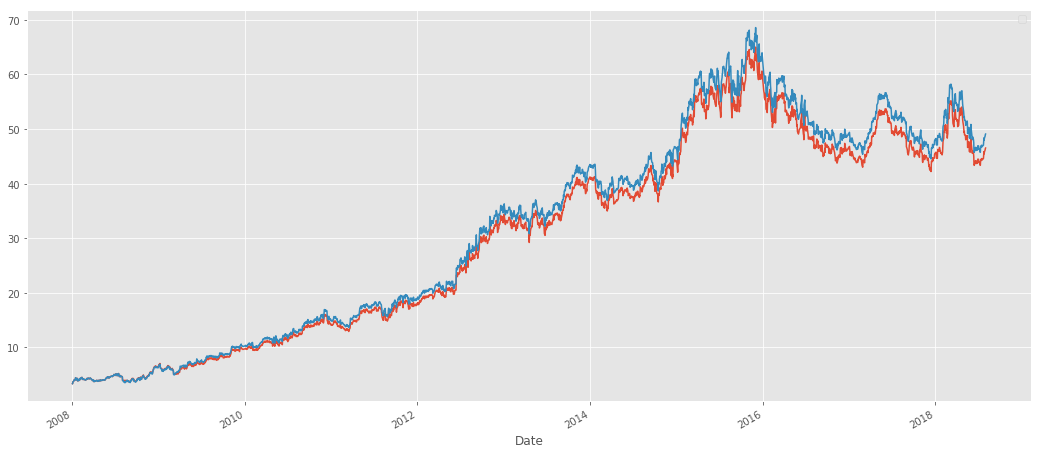

In [70]:
teto=crossover_tanto(f['itx_c_m_100_220'],tanto=-.15,change=20)
teto.plot()
f['itx_c_m_100_220'].plot()
plt.legend(['Con lImite al 15%'],['Original'])

plt.show()

<H5>Gráfico de la serie original y la limitada al -15%, con var95 bajo</h5>

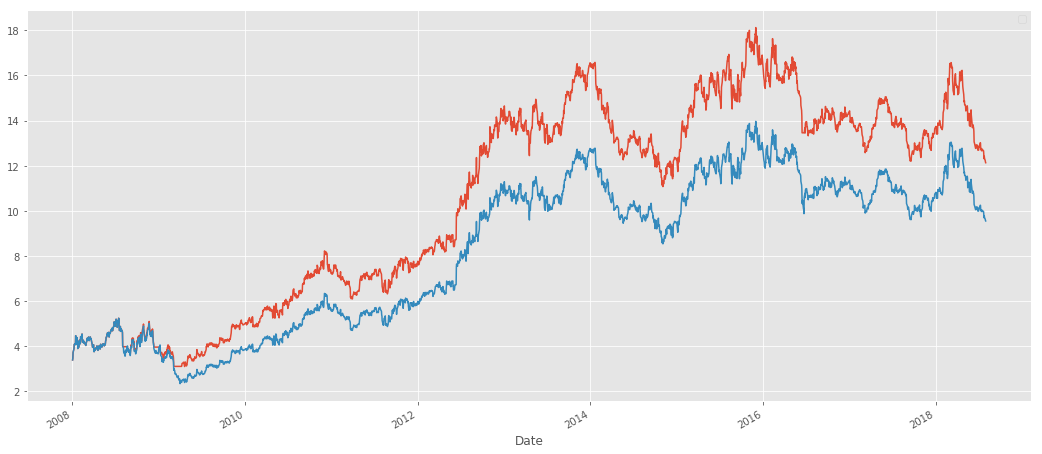

In [71]:
teto=crossover_tanto(f['itx_c_m_10_220'],tanto=-.15,change=20)
teto.plot()
f['itx_c_m_10_220'].plot()
plt.legend(['Con lImite al 15%'],['Original'])

plt.show()

<p>Claramente perjudica al que tiene menor pérdida y está por debajo del limite, que en este caso es del 15%, pero tan escasamente que podemos establecer este -15% como un seguro y un seguro muy barato.

<h5>Cálculo de la serie para un Rdto anual >0</h5> 

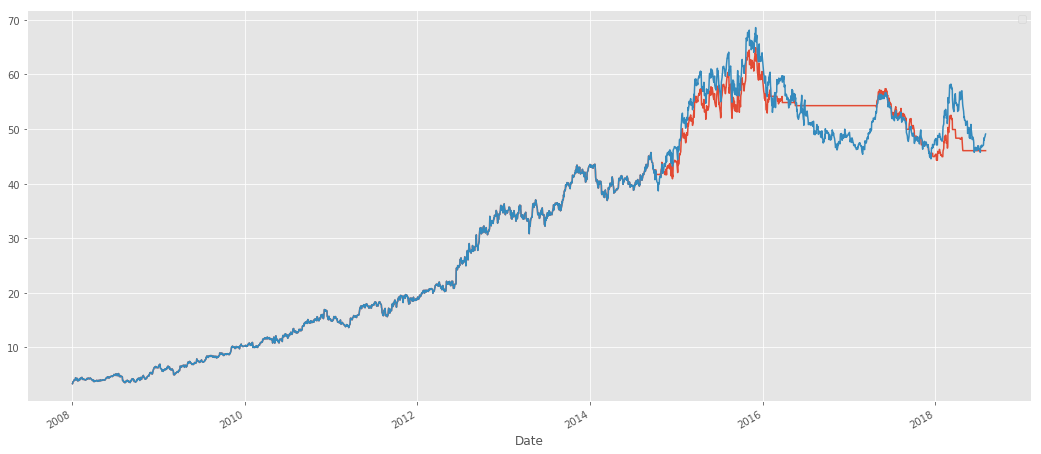

In [72]:
teto=crossover_tanto(f['itx_c_m_100_220'],tanto=.0,change=220)
teto.plot()
f['itx_c_m_100_220'].plot()
plt.legend(['Con lImite al 15%'],['Original'])

plt.show()

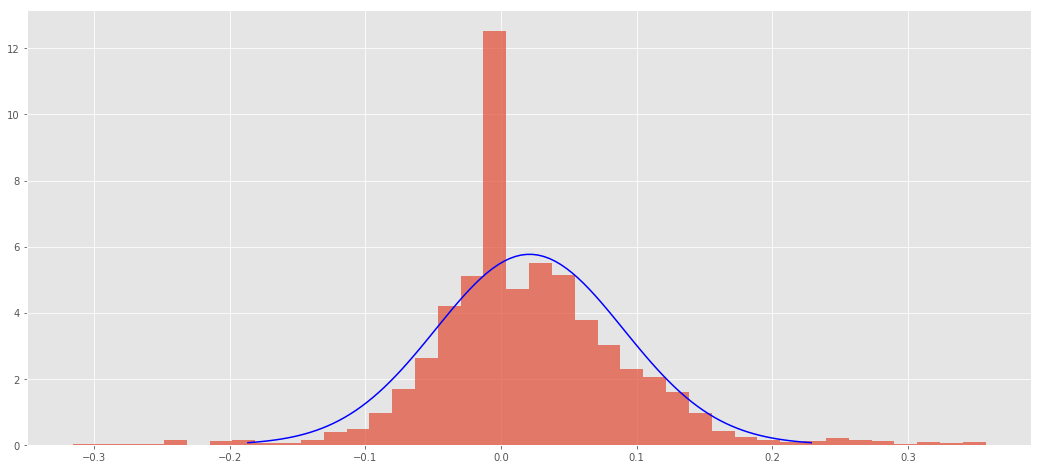

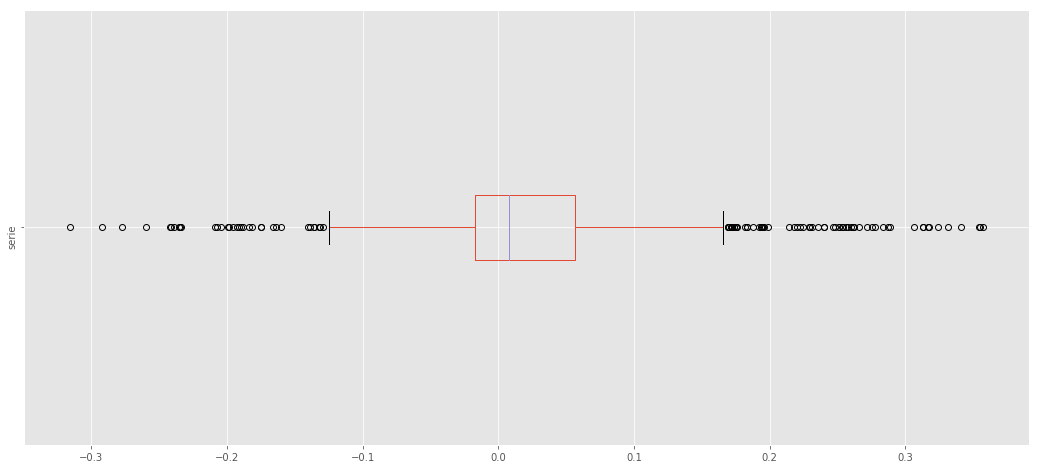

 el valor de 01p es : -0.14351 
 el valor de 05p es : -0.074541 
 el valor de 50p es : 0.0077041 
 el valor de 95p es : 0.13564 
 el valor de T-test es : 15.567 
 el valor de avg es : 0.021 
 el valor de kur es : 3.0499 
 el valor de skw es : 0.50895 
 el valor de std es : 0.069186 
 el valor de val es : -1.8197 
 el valor de var es : 0.0047867 


{'01p': -0.14351277853126218,
 '05p': -0.07454069021685598,
 '50p': 0.0077041234451467044,
 '95p': 0.13563956528807097,
 'T-test': 15.566582908274908,
 'avg': 0.021,
 'kur': 3.049931281669515,
 'skw': 0.508954572432763,
 'std': 0.06918565294830571,
 'val': -1.8196714424492761,
 'var': 0.004786654573883402}

In [73]:
calculate_aggregate(teto.pct_change(20))

<h1>Conclusion</h1>

<p>Limitando el riesgo mensual podemos obtener mejores resultados o al menos tener un coste pequeño y nos podemos evitar el riesgo de cola que en toda distribución podemos tener

# reversión a la media

<p>Todo proceso de media constante y varianza constante, tiene la propiedad de revertir a la media, pues si nó, no cumpliría las características que le pedimos a nuestra serie.
<p>Por tanto si no cumple esta caracteristica abandonaremos la serie, pues dificilmente podremos hacer una predicción.
<p>Cuanto mejor podemos predecir una serie mayor revertirá a la media.
<p>Vamos a calcular una reversión de cada uno de nuestros sistemas que mejor se comportan. Y estudiaremos sus resultados.

In [74]:
#sistema reversion

In [75]:
#crear sistema menor que el 10%
def reversion_media(values,tanto=-.10,tanto2=0):
    
    df=pd.DataFrame()
    #print type(values)
    df['base']=values.copy()
    #print df.base.tail()
    df['logvalues']=np.log(df.base / df.base.shift(1))
    df['pctvalues']=df['base'].pct_change(20)
    df['senal']=np.where((df.pctvalues>tanto)&(df.pctvalues.shift()<tanto),1,np.nan)
    df['senal']=np.where((df.pctvalues>tanto2)&(df.pctvalues.shift()<tanto2),0,df['senal'])
    df['senal'].ffill(inplace=True)
    df['senal']=df['senal'].fillna(0)
    #.senal.plot(secondary_y=True)
    #print df.logvalues
    df['rendimiento']=df.senal.shift()*df.logvalues
    df['rendimiento']=df['rendimiento'].fillna(0)
    df['rendimiento'][0]=np.log(df['base'][0])
    df['serie']=np.exp(df.rendimiento.cumsum())
    
    return df.serie

In [76]:

f1=pd.DataFrame(index=f.index)
ccoco=f.filter(like='_c_m',axis=1).columns.values
var95histmedias10={}

tanto=-.06
for n in ccoco:
      f1['{}_reversion'.format(n,tanto)]=reversion_media(f['{}'.format(n)],tanto)


In [77]:
f1.columns

Index(['san_c_m_10_20_reversion', 'san_c_m_10_50_reversion',
       'san_c_m_20_50_reversion', 'san_c_m_10_100_reversion',
       'san_c_m_20_100_reversion', 'san_c_m_50_100_reversion',
       'san_c_m_10_220_reversion', 'san_c_m_20_220_reversion',
       'san_c_m_50_220_reversion', 'san_c_m_100_220_reversion',
       'itx_c_m_10_20_reversion', 'itx_c_m_10_50_reversion',
       'itx_c_m_20_50_reversion', 'itx_c_m_10_100_reversion',
       'itx_c_m_20_100_reversion', 'itx_c_m_50_100_reversion',
       'itx_c_m_10_220_reversion', 'itx_c_m_20_220_reversion',
       'itx_c_m_50_220_reversion', 'itx_c_m_100_220_reversion',
       'tef_c_m_10_20_reversion', 'tef_c_m_10_50_reversion',
       'tef_c_m_20_50_reversion', 'tef_c_m_10_100_reversion',
       'tef_c_m_20_100_reversion', 'tef_c_m_50_100_reversion',
       'tef_c_m_10_220_reversion', 'tef_c_m_20_220_reversion',
       'tef_c_m_50_220_reversion', 'tef_c_m_100_220_reversion'],
      dtype='object')

<h4>Grafico del sistema y del sistema en reversión a la media</h4>

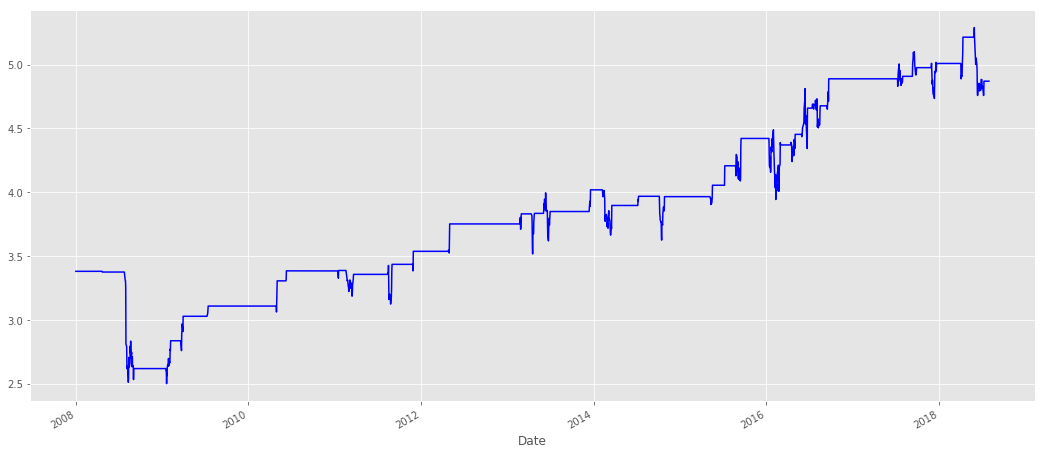

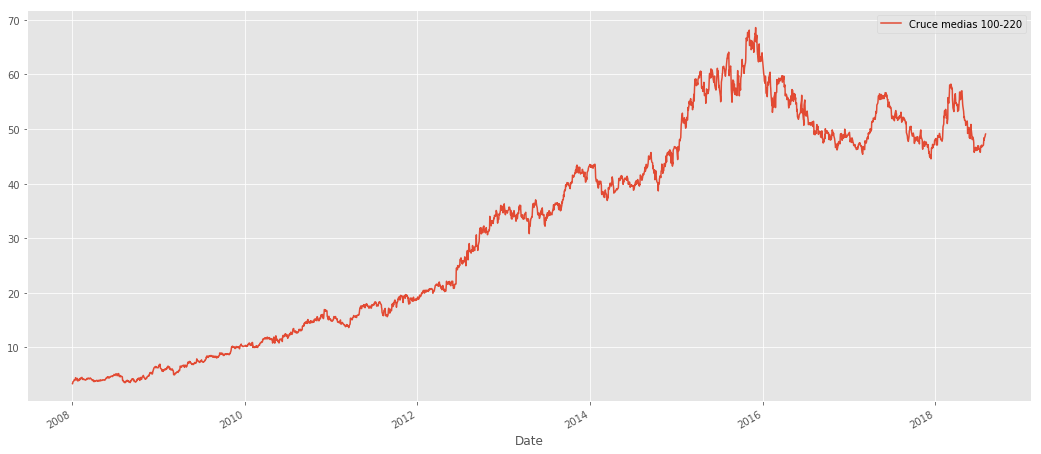

In [78]:
f1.itx_c_m_100_220_reversion.plot(c='b')
plt.show()
f.itx_c_m_100_220.plot()
plt.legend(['Cruce medias 100-220','Cruce medias 100-220 con reversion'])
plt.show()

<p>El rendimiento es mucho menor, pero parece que es más constante en rendimiento.

<h4>Gráficos de cada sistema en reversión a la media</h4>

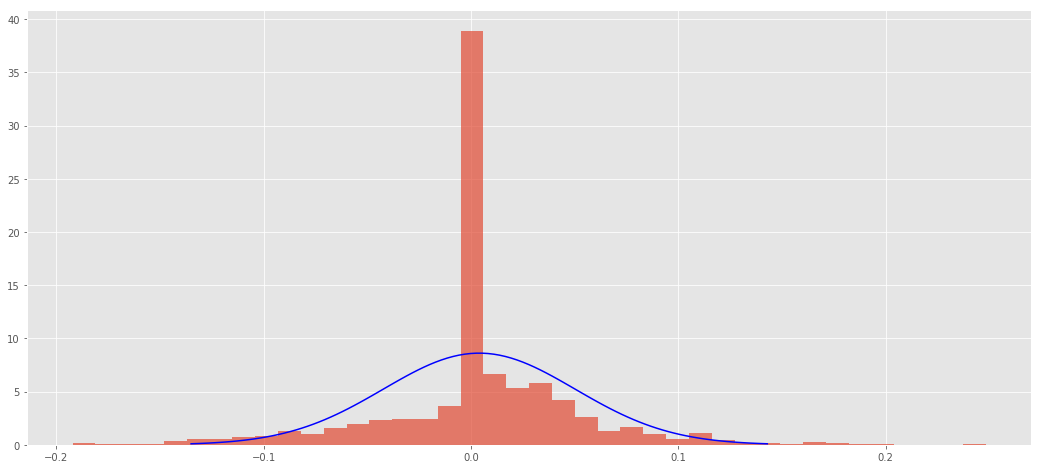

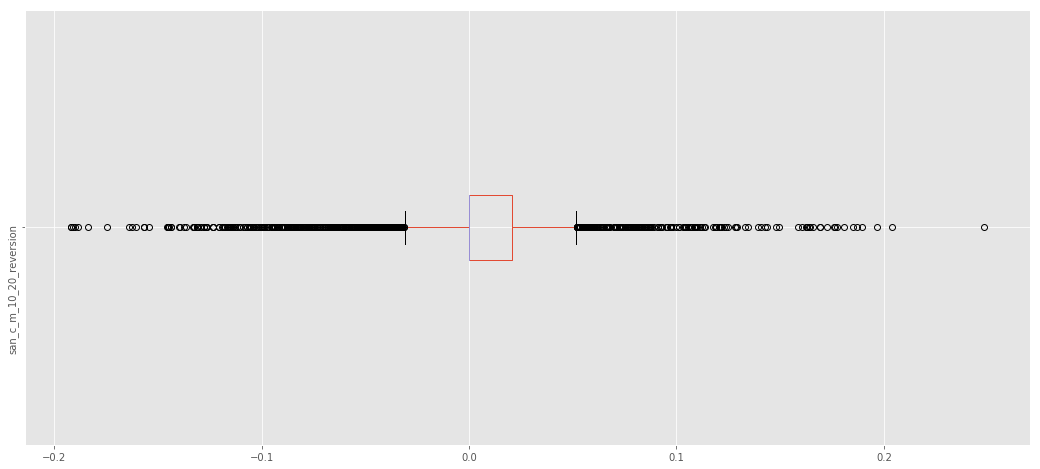

 el valor de 01p es : -0.13159 
 el valor de 05p es : -0.082941 
 el valor de 50p es : 0.0 
 el valor de 95p es : 0.08033 
 el valor de T-test es : 4.1824 
 el valor de avg es : 0.004 
 el valor de kur es : 3.2032 
 el valor de skw es : -0.11182 
 el valor de std es : 0.046309 
 el valor de val es : -0.96851 
 el valor de var es : 0.0021445 


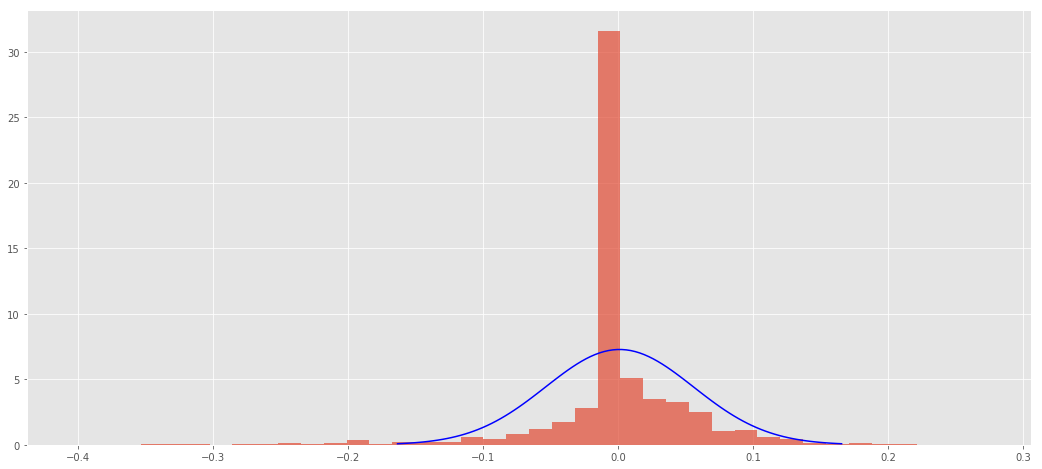

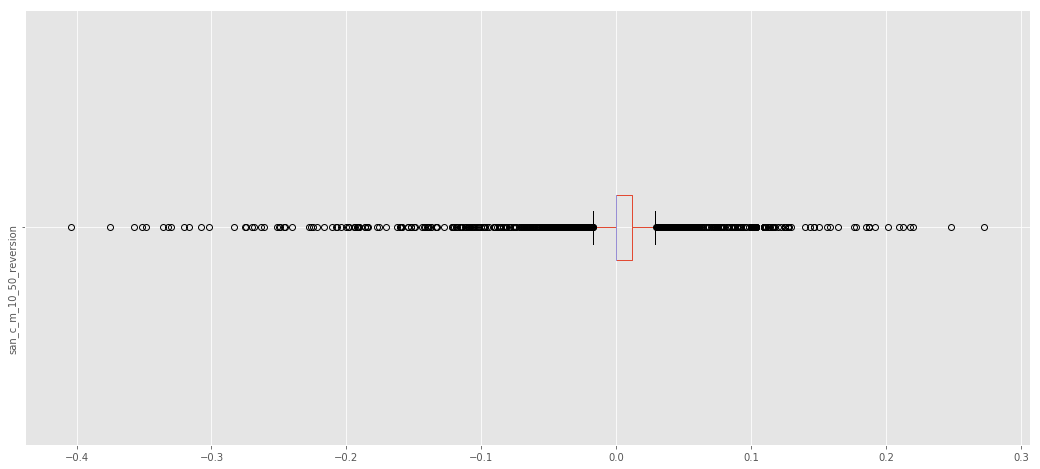

 el valor de 01p es : -0.22489 
 el valor de 05p es : -0.082198 
 el valor de 50p es : 0.0 
 el valor de 95p es : 0.077194 
 el valor de T-test es : 0.58677 
 el valor de avg es : 0.001 
 el valor de kur es : 11.161 
 el valor de skw es : -1.7862 
 el valor de std es : 0.054839 
 el valor de val es : -0.93911 
 el valor de var es : 0.0030073 


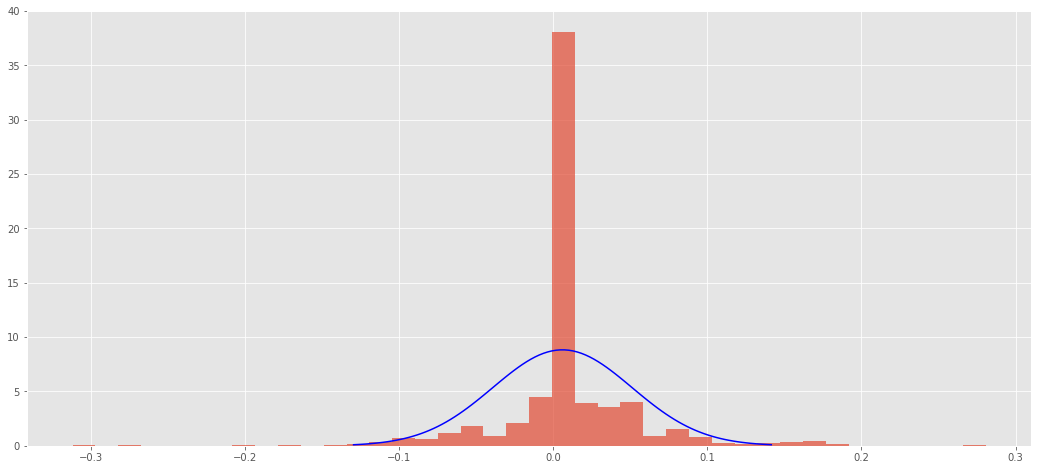

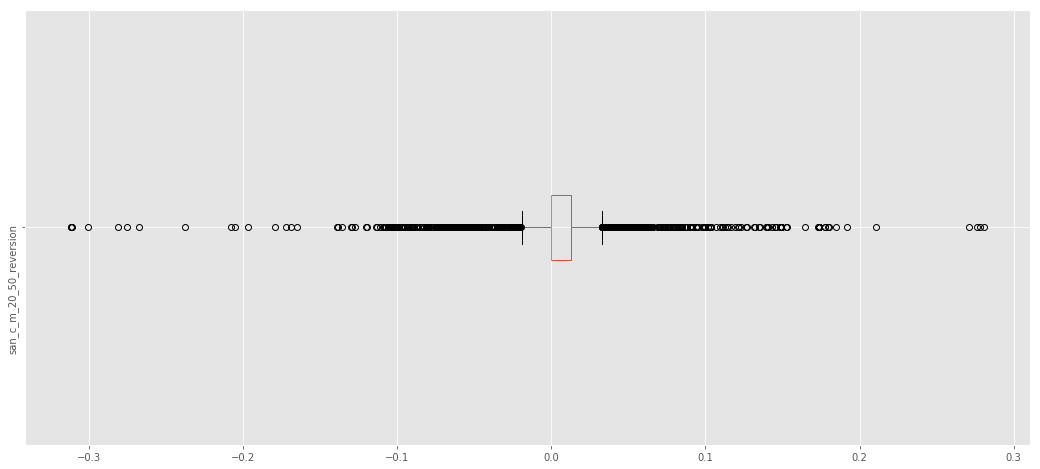

 el valor de 01p es : -0.10894 
 el valor de 05p es : -0.060942 
 el valor de 50p es : 0.0 
 el valor de 95p es : 0.080149 
 el valor de T-test es : 7.3686 
 el valor de avg es : 0.006 
 el valor de kur es : 9.9494 
 el valor de skw es : -0.076879 
 el valor de std es : 0.045175 
 el valor de val es : -1.3152 
 el valor de var es : 0.0020408 


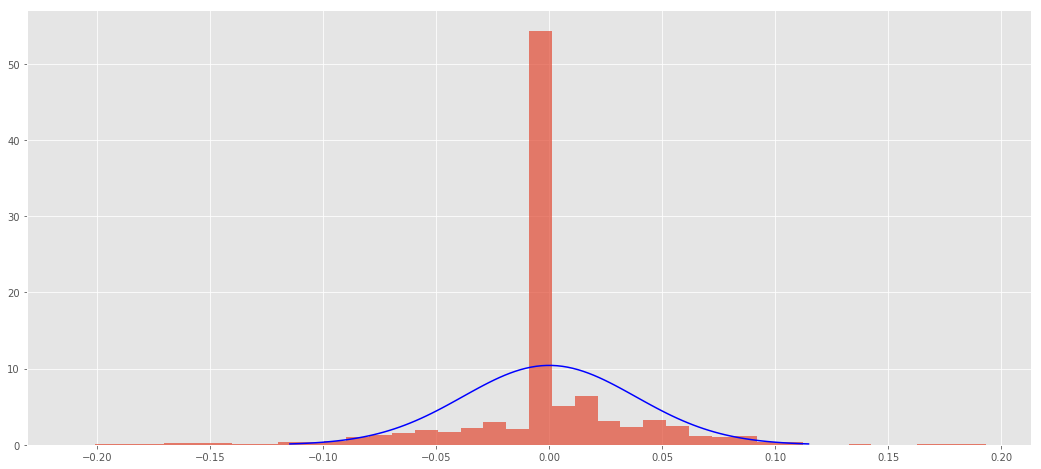

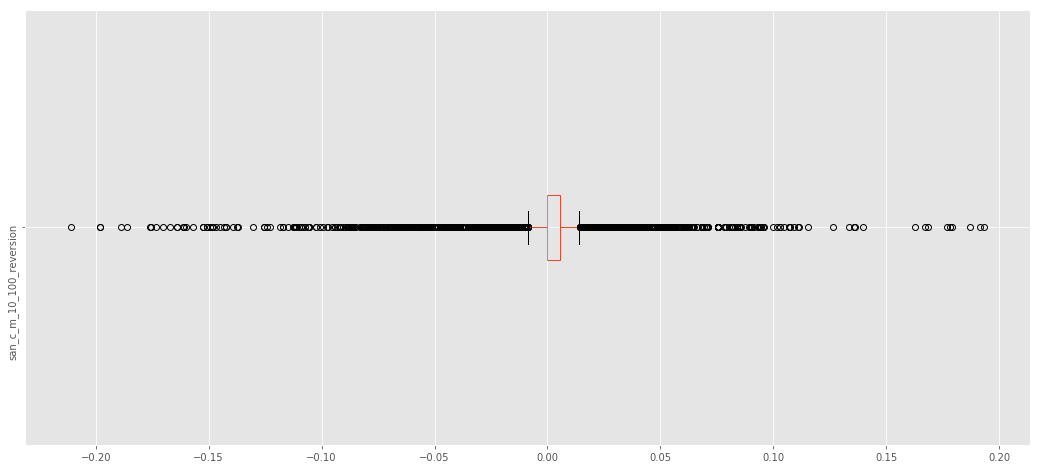

 el valor de 01p es : -0.14222 
 el valor de 05p es : -0.068978 
 el valor de 50p es : 0.0 
 el valor de 95p es : 0.060663 
 el valor de T-test es : 0.22915 
 el valor de avg es : 0.0 
 el valor de kur es : 5.6975 
 el valor de skw es : -0.60493 
 el valor de std es : 0.038267 
 el valor de val es : -0.87946 
 el valor de var es : 0.0014644 


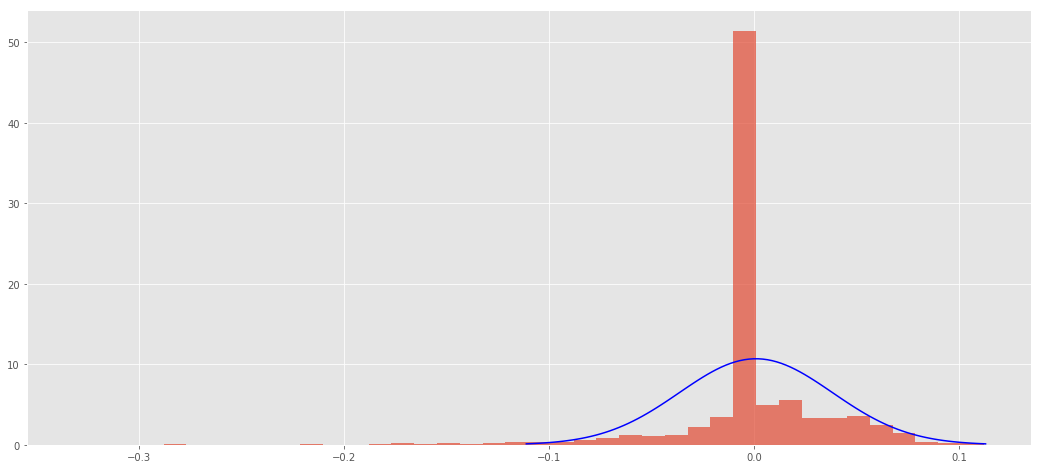

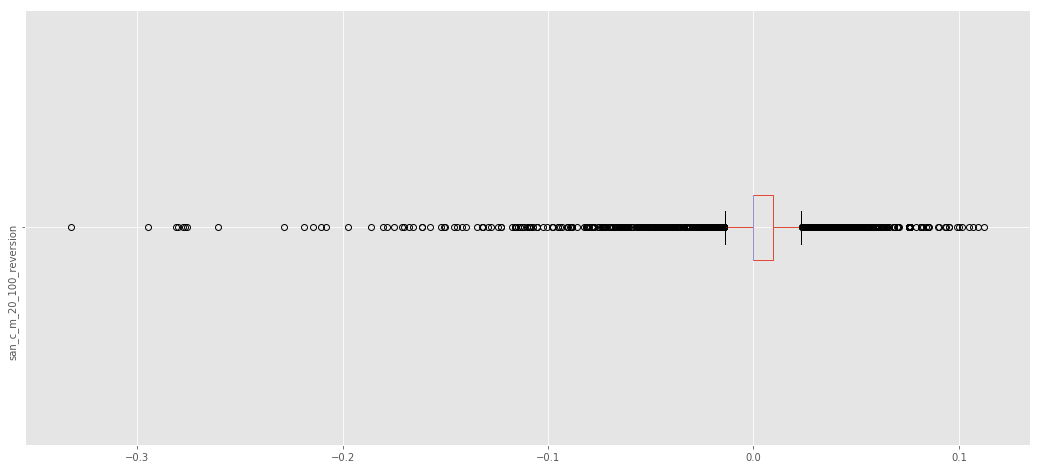

 el valor de 01p es : -0.15025 
 el valor de 05p es : -0.061192 
 el valor de 50p es : 0.0 
 el valor de 95p es : 0.058134 
 el valor de T-test es : 1.5883 
 el valor de avg es : 0.001 
 el valor de kur es : 15.16 
 el valor de skw es : -2.4803 
 el valor de std es : 0.037324 
 el valor de val es : -0.95003 
 el valor de var es : 0.0013931 


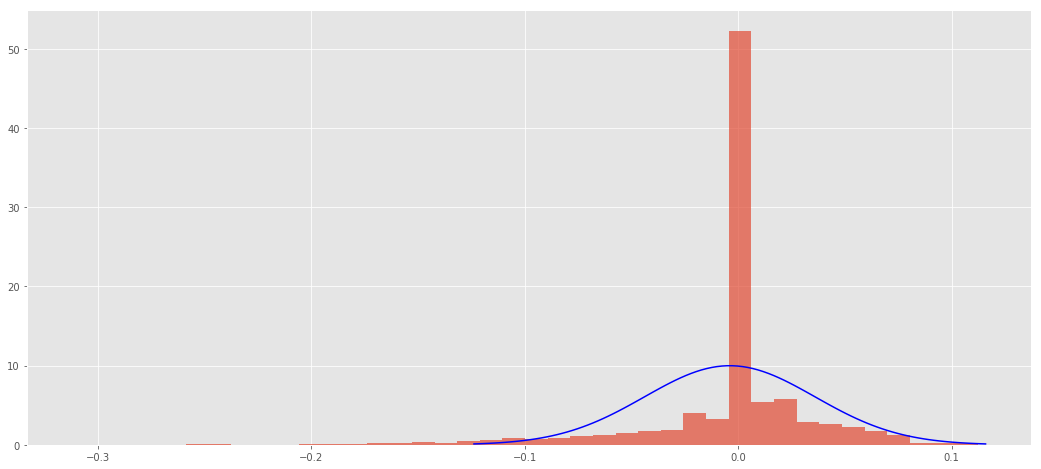

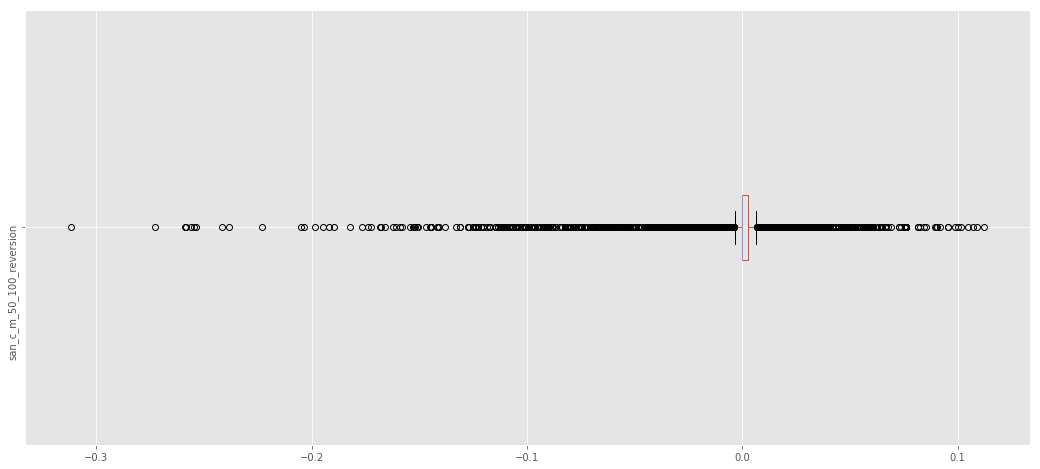

 el valor de 01p es : -0.15503 
 el valor de 05p es : -0.081346 
 el valor de 50p es : 0.0 
 el valor de 95p es : 0.055173 
 el valor de T-test es : -4.7275 
 el valor de avg es : -0.004 
 el valor de kur es : 9.4053 
 el valor de skw es : -2.1166 
 el valor de std es : 0.03994 
 el valor de val es : -0.67825 
 el valor de var es : 0.0015952 


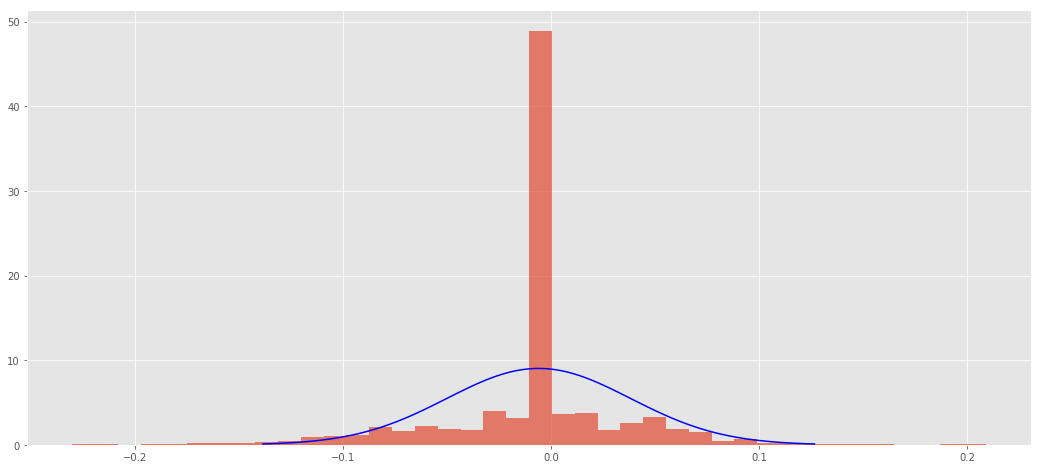

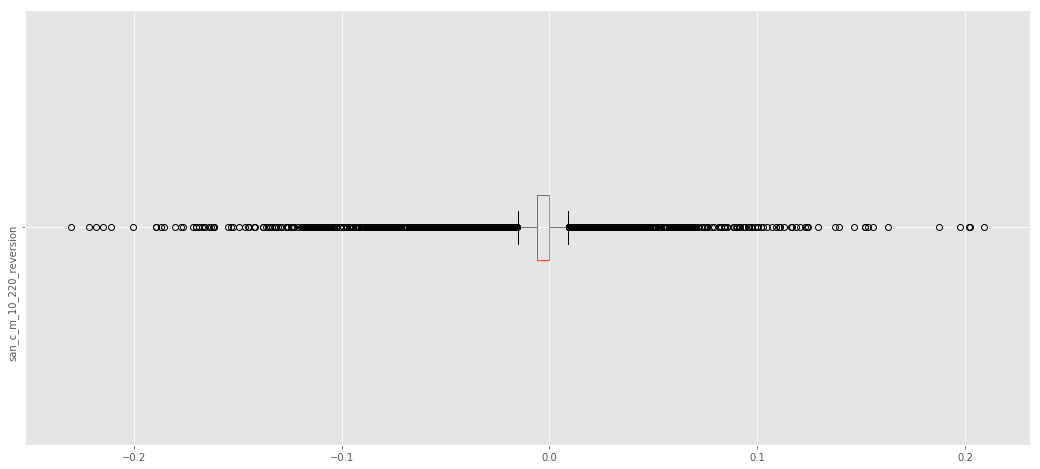

 el valor de 01p es : -0.15244 
 el valor de 05p es : -0.091879 
 el valor de 50p es : 0.0 
 el valor de 95p es : 0.061129 
 el valor de T-test es : -6.6346 
 el valor de avg es : -0.006 
 el valor de kur es : 4.0528 
 el valor de skw es : -0.69648 
 el valor de std es : 0.044211 
 el valor de val es : -0.66532 
 el valor de var es : 0.0019546 


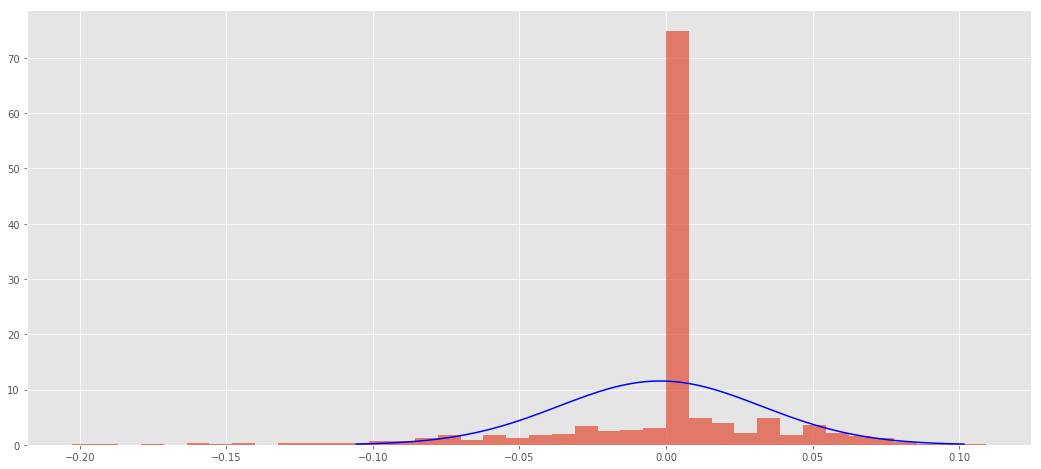

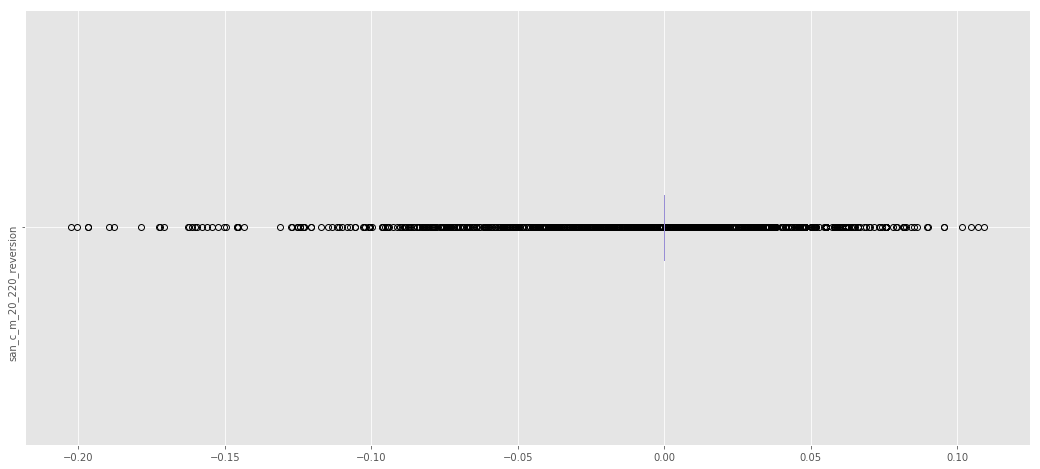

 el valor de 01p es : -0.12812 
 el valor de 05p es : -0.07167 
 el valor de 50p es : 0.0 
 el valor de 95p es : 0.051309 
 el valor de T-test es : -2.8927 
 el valor de avg es : -0.002 
 el valor de kur es : 6.0151 
 el valor de skw es : -1.4605 
 el valor de std es : 0.034555 
 el valor de val es : -0.7159 
 el valor de var es : 0.0011941 


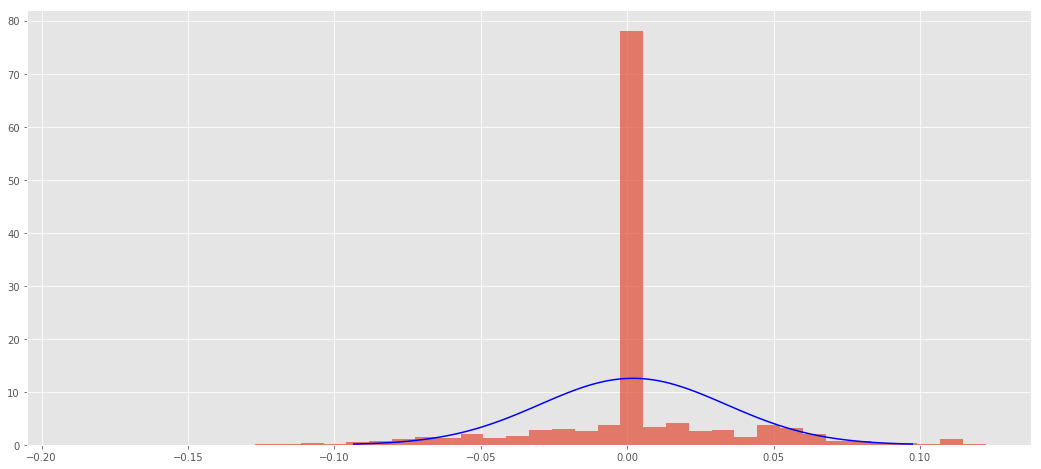

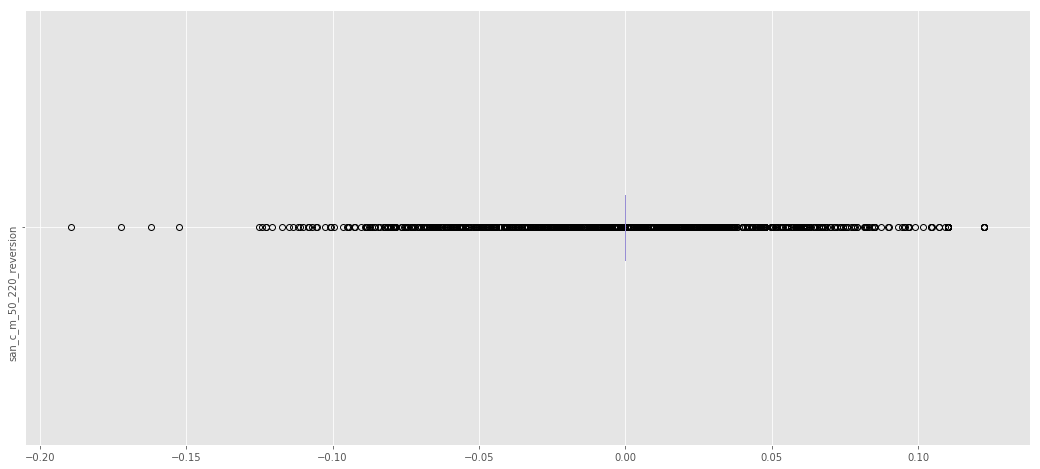

 el valor de 01p es : -0.094348 
 el valor de 05p es : -0.056211 
 el valor de 50p es : 0.0 
 el valor de 95p es : 0.059578 
 el valor de T-test es : 2.6895 
 el valor de avg es : 0.002 
 el valor de kur es : 4.1849 
 el valor de skw es : -0.14671 
 el valor de std es : 0.031804 
 el valor de val es : -1.0599 
 el valor de var es : 0.0010115 


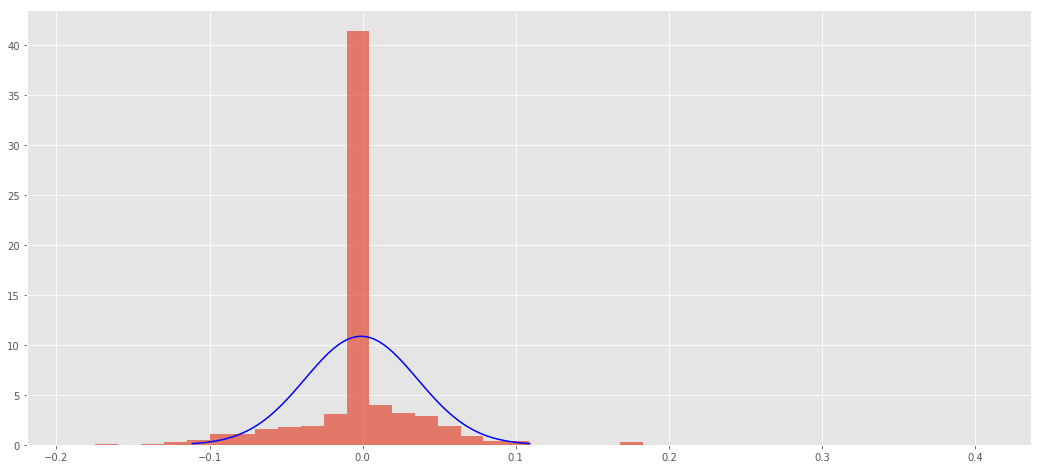

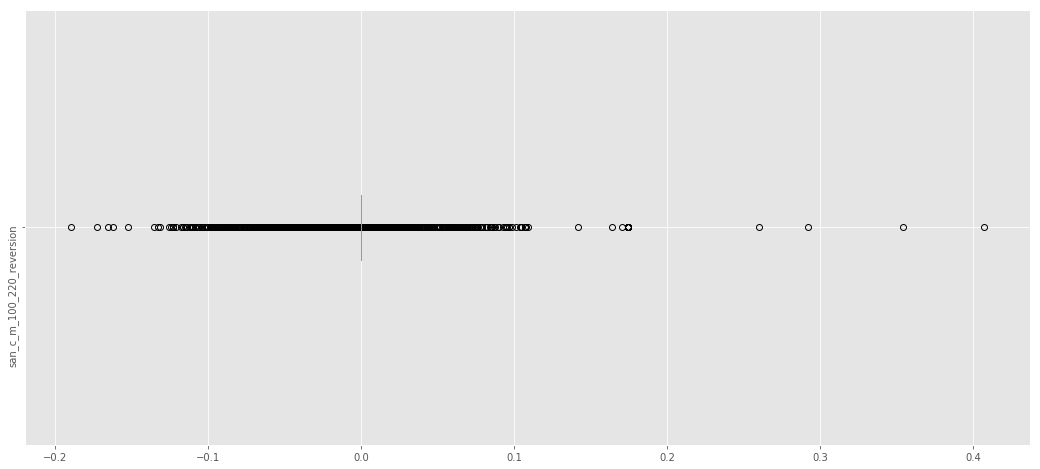

 el valor de 01p es : -0.10735 
 el valor de 05p es : -0.06864 
 el valor de 50p es : 0.0 
 el valor de 95p es : 0.055173 
 el valor de T-test es : -0.80331 
 el valor de avg es : -0.001 
 el valor de kur es : 14.981 
 el valor de skw es : 0.98372 
 el valor de std es : 0.036725 
 el valor de val es : -0.80379 
 el valor de var es : 0.0013487 


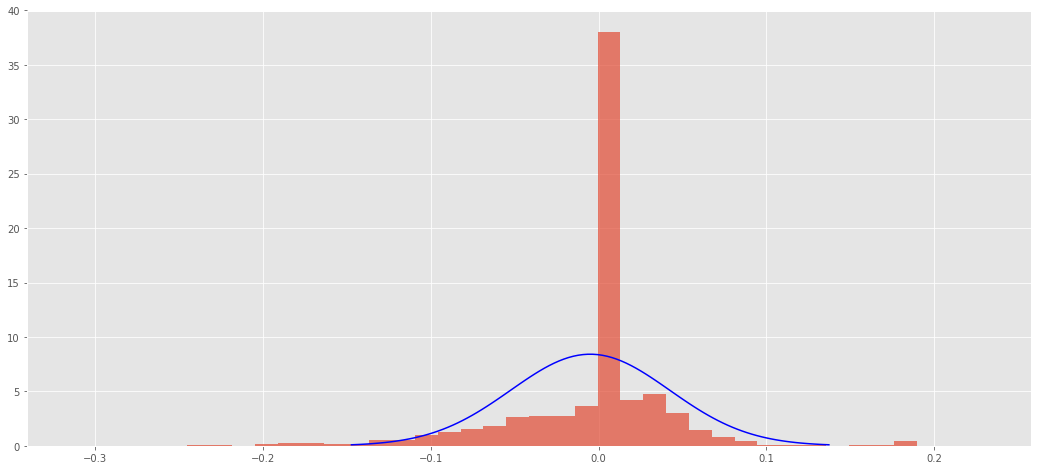

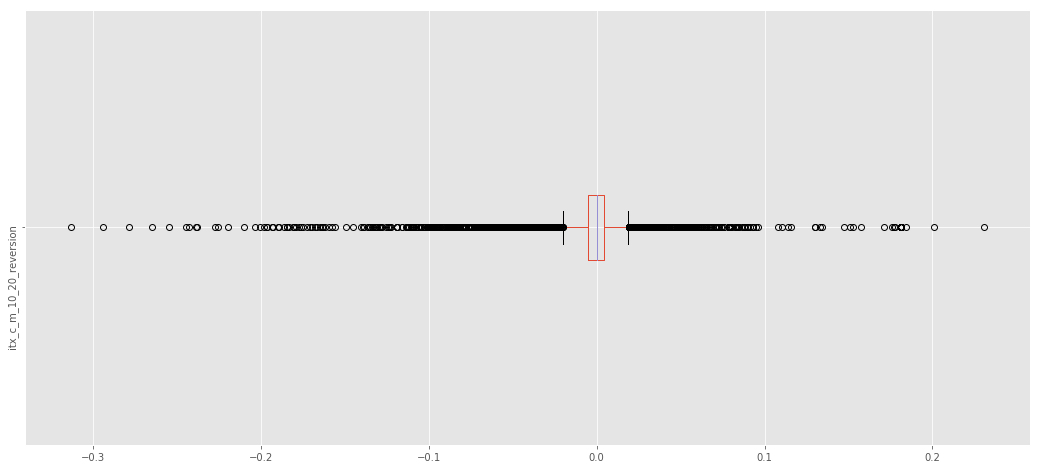

 el valor de 01p es : -0.18058 
 el valor de 05p es : -0.091858 
 el valor de 50p es : 0.0 
 el valor de 95p es : 0.053669 
 el valor de T-test es : -5.585 
 el valor de avg es : -0.005 
 el valor de kur es : 6.9001 
 el valor de skw es : -1.0158 
 el valor de std es : 0.0474 
 el valor de val es : -0.58426 
 el valor de var es : 0.0022468 


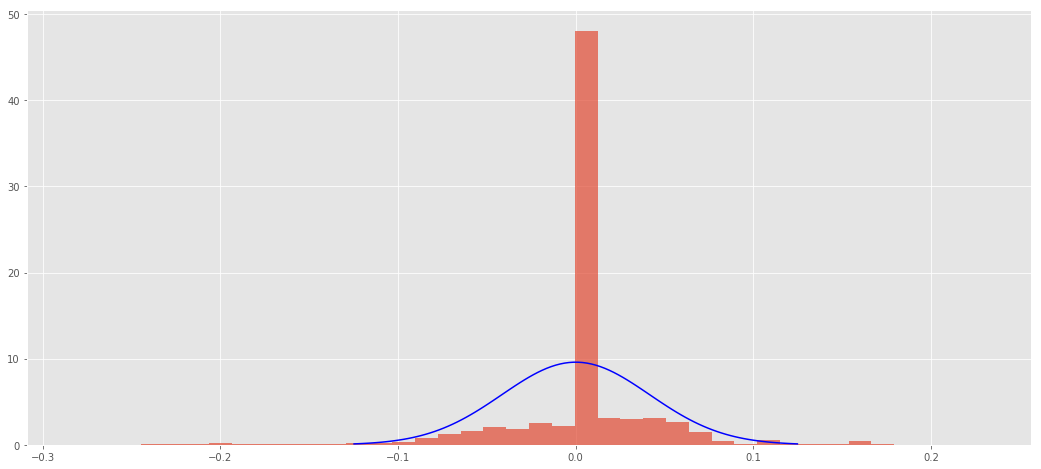

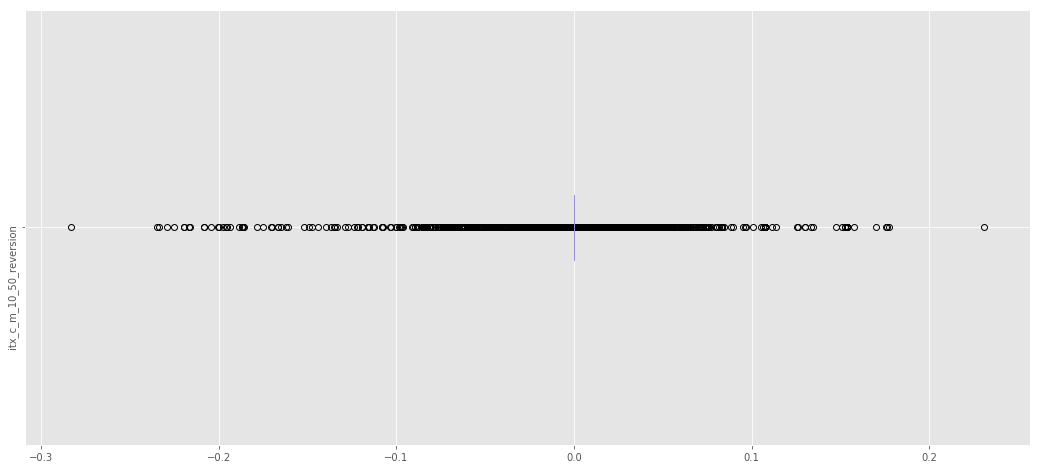

 el valor de 01p es : -0.16713 
 el valor de 05p es : -0.066774 
 el valor de 50p es : 0.0 
 el valor de 95p es : 0.063567 
 el valor de T-test es : 0.55436 
 el valor de avg es : 0.0 
 el valor de kur es : 8.5148 
 el valor de skw es : -0.90894 
 el valor de std es : 0.041578 
 el valor de val es : -0.95198 
 el valor de var es : 0.0017287 


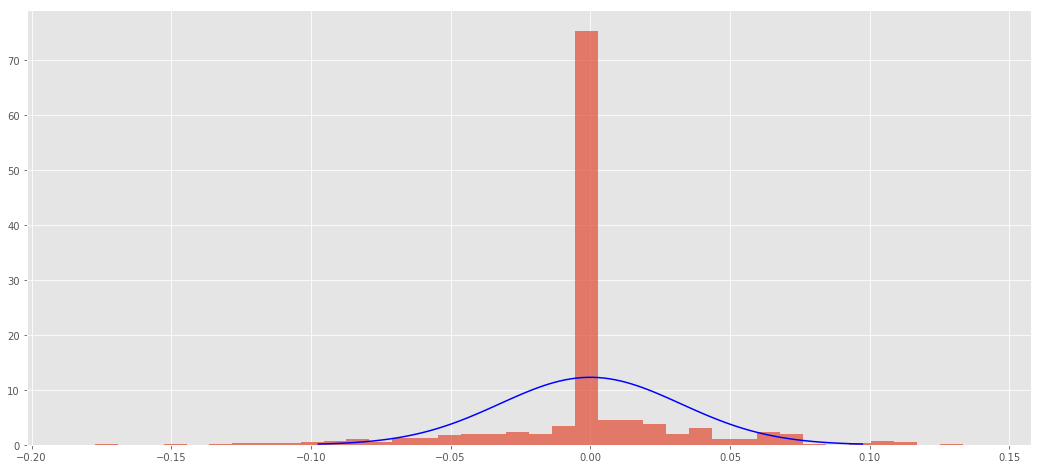

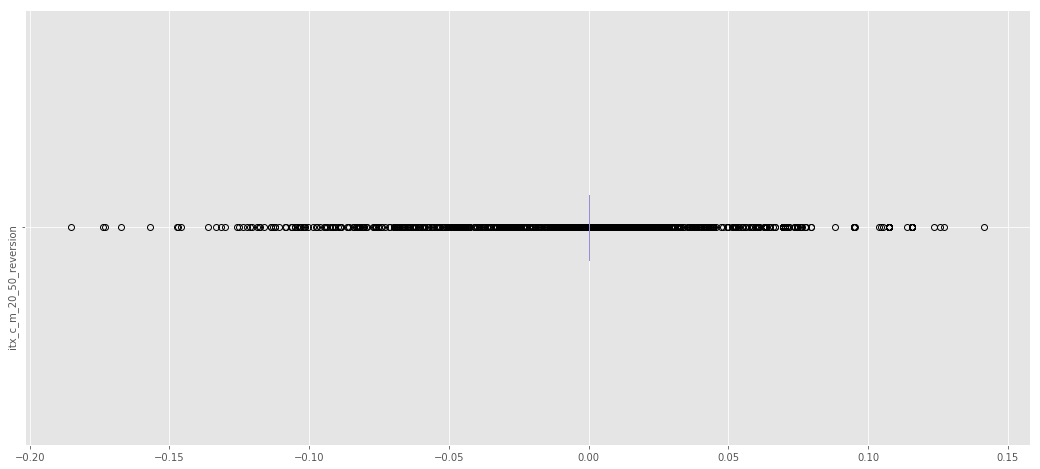

 el valor de 01p es : -0.11096 
 el valor de 05p es : -0.059618 
 el valor de 50p es : 0.0 
 el valor de 95p es : 0.060715 
 el valor de T-test es : 0.14115 
 el valor de avg es : 0.0 
 el valor de kur es : 5.2841 
 el valor de skw es : -0.55511 
 el valor de std es : 0.032454 
 el valor de val es : -1.0184 
 el valor de var es : 0.0010533 


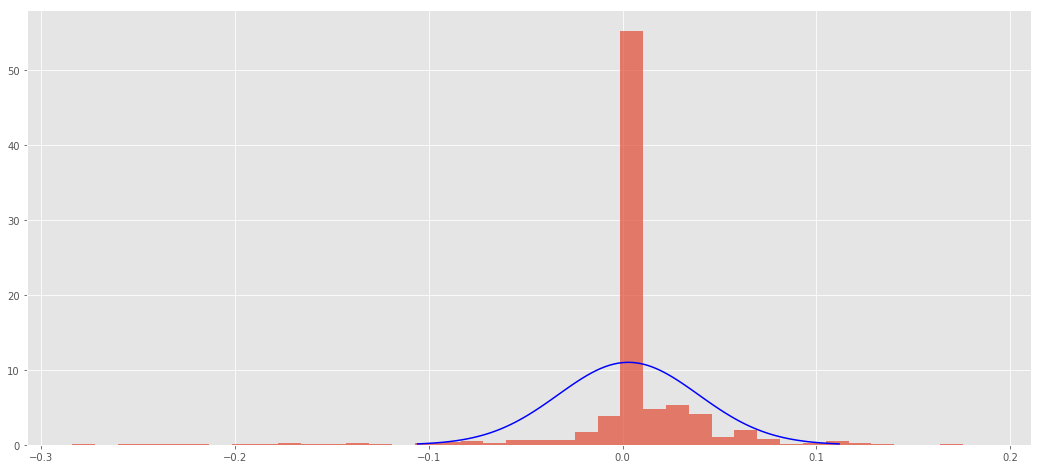

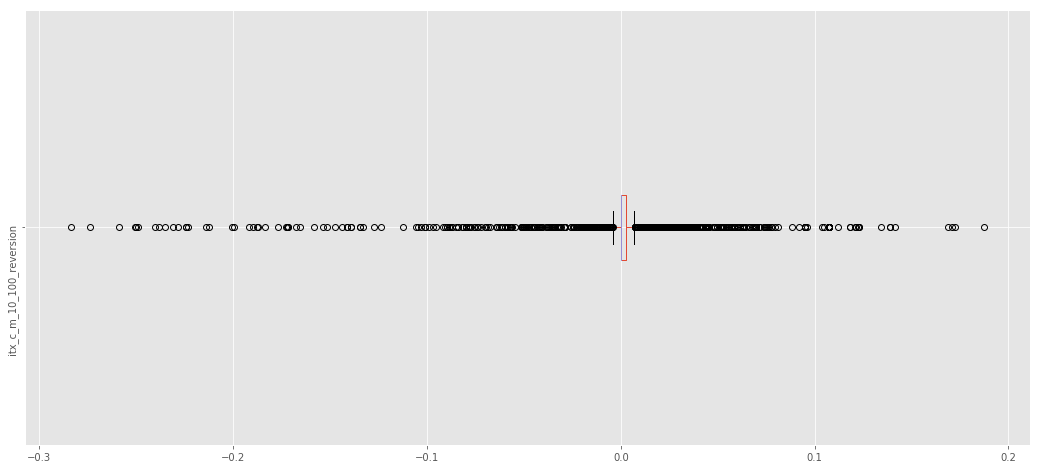

 el valor de 01p es : -0.17173 
 el valor de 05p es : -0.036154 
 el valor de 50p es : 0.0 
 el valor de 95p es : 0.055479 
 el valor de T-test es : 4.4243 
 el valor de avg es : 0.003 
 el valor de kur es : 17.444 
 el valor de skw es : -2.3595 
 el valor de std es : 0.036251 
 el valor de val es : -1.5345 
 el valor de var es : 0.0013141 


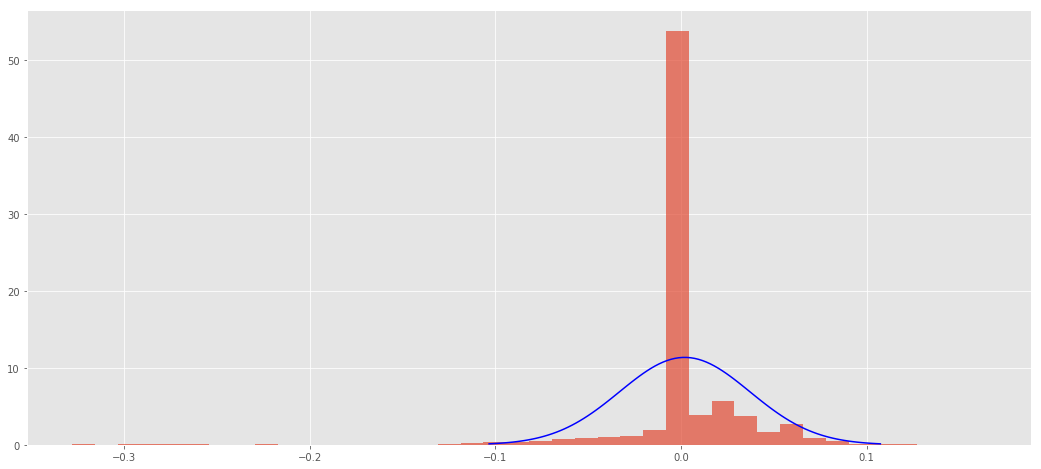

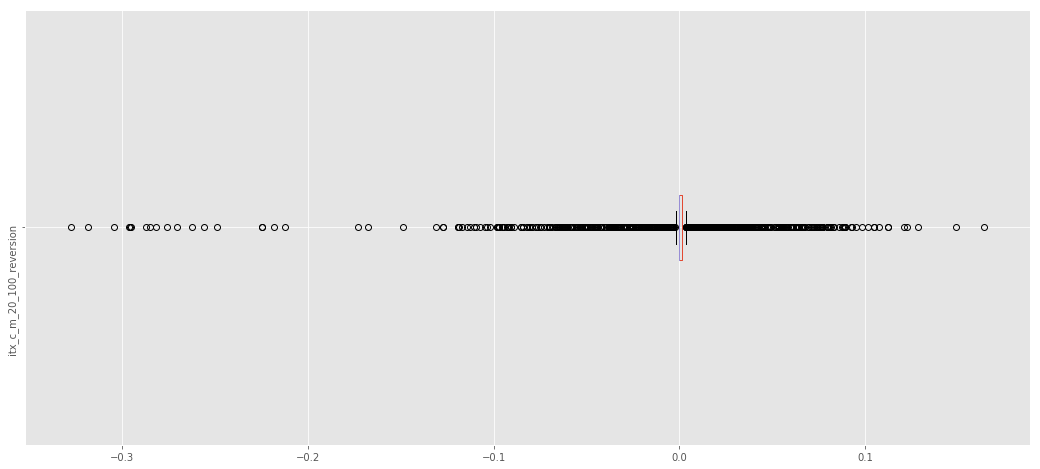

 el valor de 01p es : -0.11727 
 el valor de 05p es : -0.041973 
 el valor de 50p es : 0.0 
 el valor de 95p es : 0.054872 
 el valor de T-test es : 3.5676 
 el valor de avg es : 0.002 
 el valor de kur es : 27.466 
 el valor de skw es : -3.4023 
 el valor de std es : 0.035118 
 el valor de val es : -1.3073 
 el valor de var es : 0.0012333 


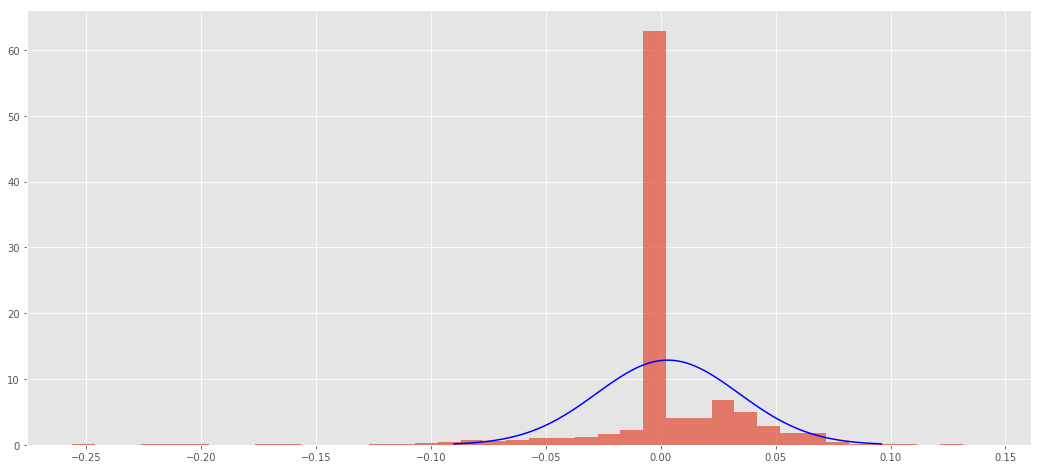

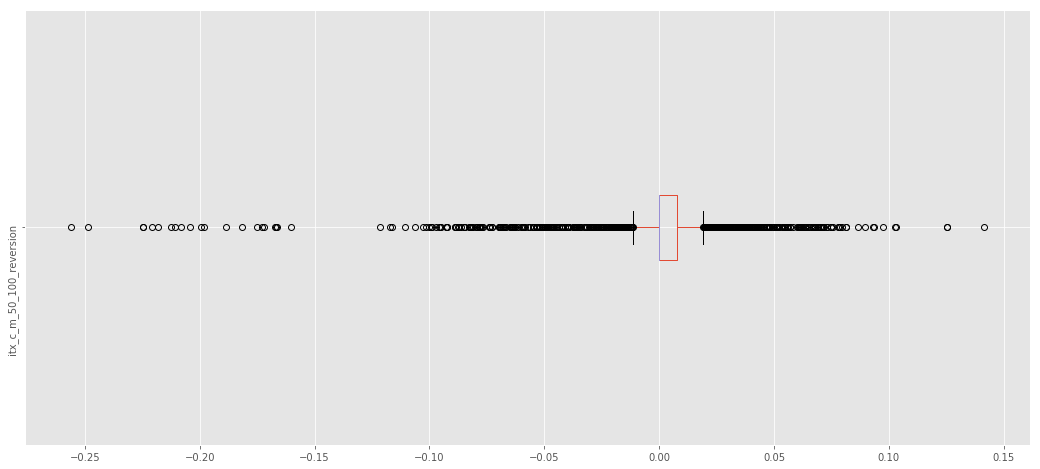

 el valor de 01p es : -0.10173 
 el valor de 05p es : -0.044446 
 el valor de 50p es : 0.0 
 el valor de 95p es : 0.04767 
 el valor de T-test es : 5.099 
 el valor de avg es : 0.003 
 el valor de kur es : 16.018 
 el valor de skw es : -2.35 
 el valor de std es : 0.030994 
 el valor de val es : -1.0725 
 el valor de var es : 0.00096064 


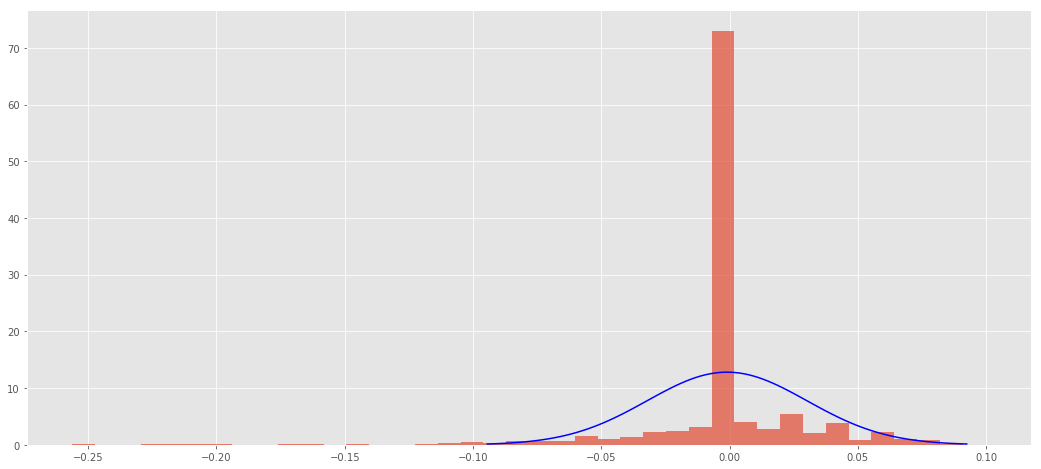

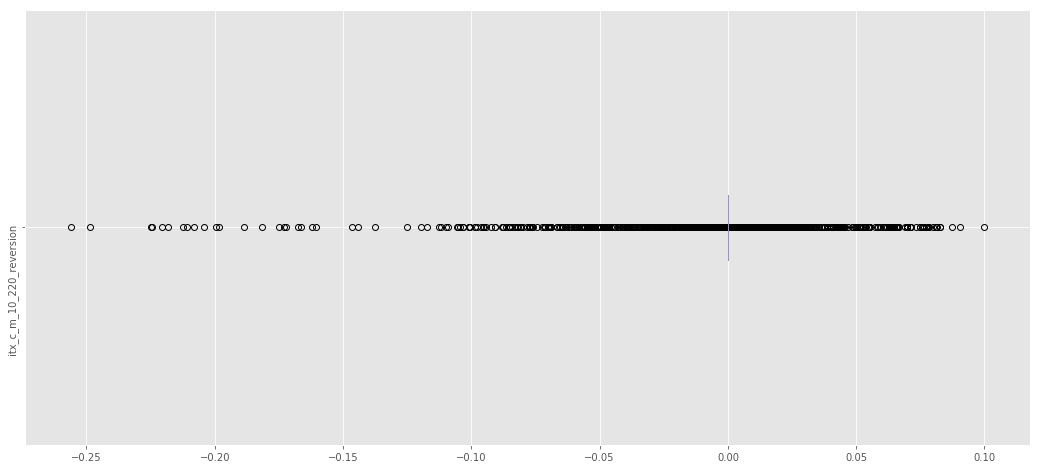

 el valor de 01p es : -0.11332 
 el valor de 05p es : -0.052234 
 el valor de 50p es : 0.0 
 el valor de 95p es : 0.044164 
 el valor de T-test es : -0.88289 
 el valor de avg es : -0.001 
 el valor de kur es : 15.085 
 el valor de skw es : -2.4213 
 el valor de std es : 0.031142 
 el valor de val es : -0.8455 
 el valor de var es : 0.00096982 


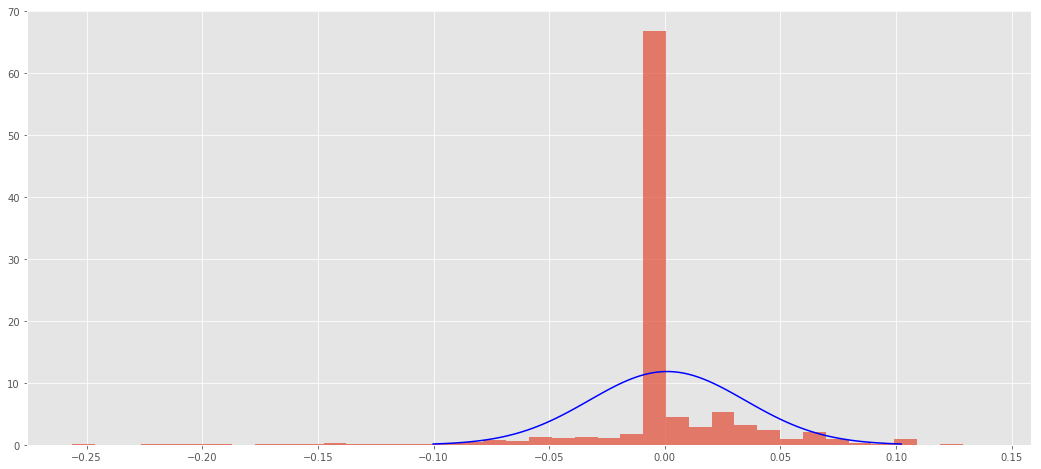

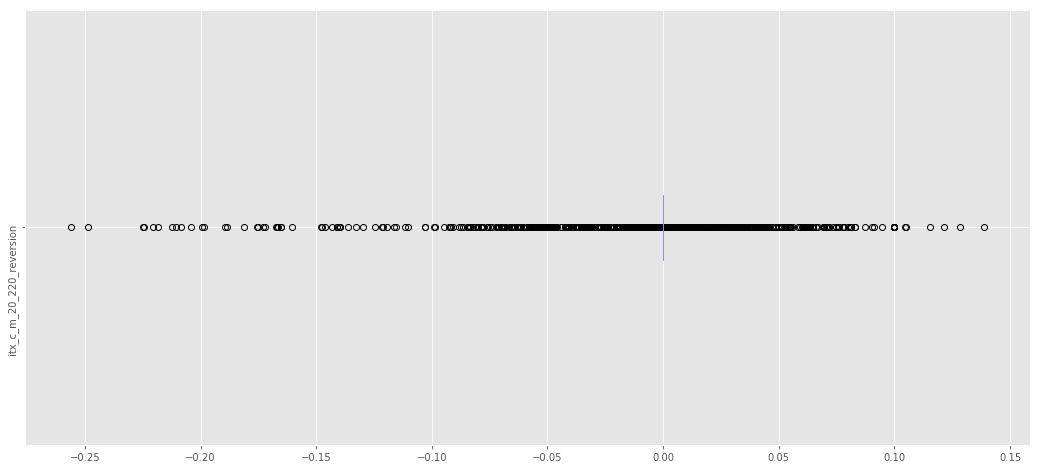

 el valor de 01p es : -0.14647 
 el valor de 05p es : -0.051606 
 el valor de 50p es : 0.0 
 el valor de 95p es : 0.052524 
 el valor de T-test es : 1.7049 
 el valor de avg es : 0.001 
 el valor de kur es : 13.351 
 el valor de skw es : -2.0795 
 el valor de std es : 0.033726 
 el valor de val es : -1.0178 
 el valor de var es : 0.0011374 


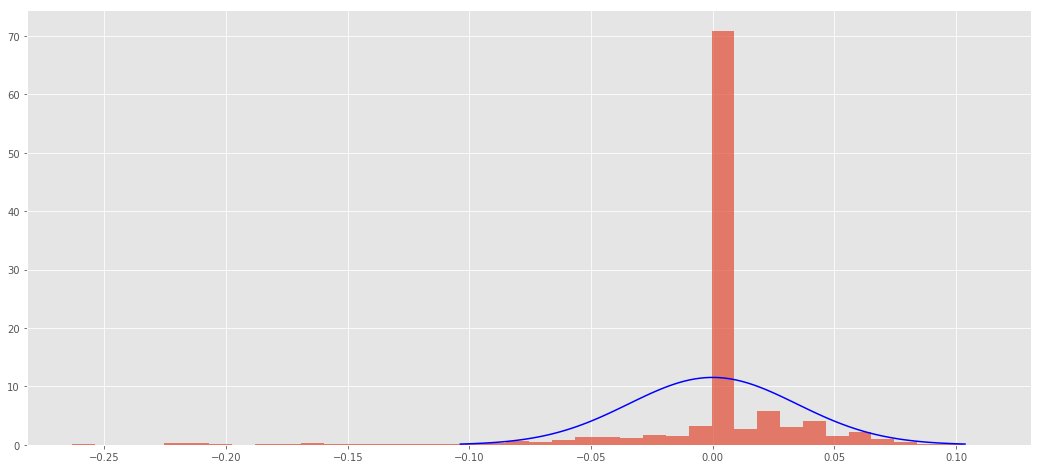

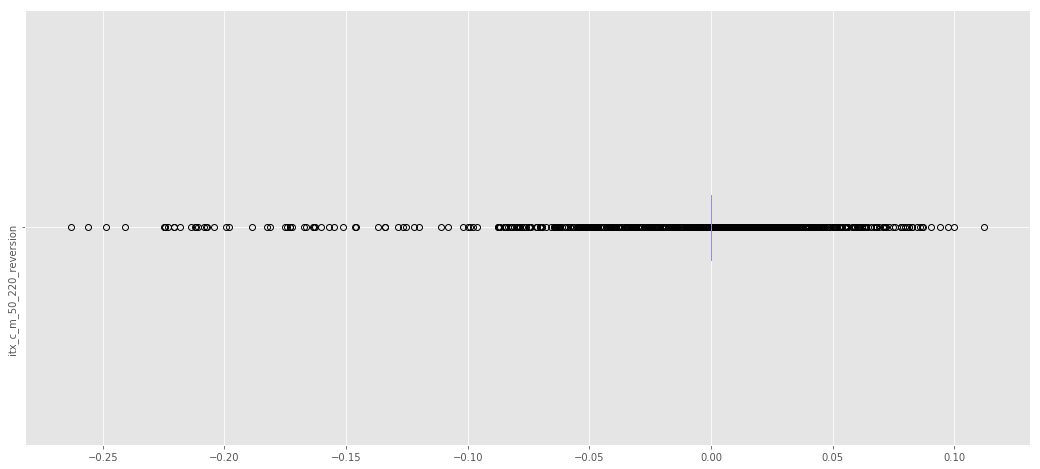

 el valor de 01p es : -0.17297 
 el valor de 05p es : -0.050012 
 el valor de 50p es : 0.0 
 el valor de 95p es : 0.047701 
 el valor de T-test es : 0.28374 
 el valor de avg es : 0.0 
 el valor de kur es : 16.732 
 el valor de skw es : -2.9444 
 el valor de std es : 0.034574 
 el valor de val es : -0.9538 
 el valor de var es : 0.0011954 


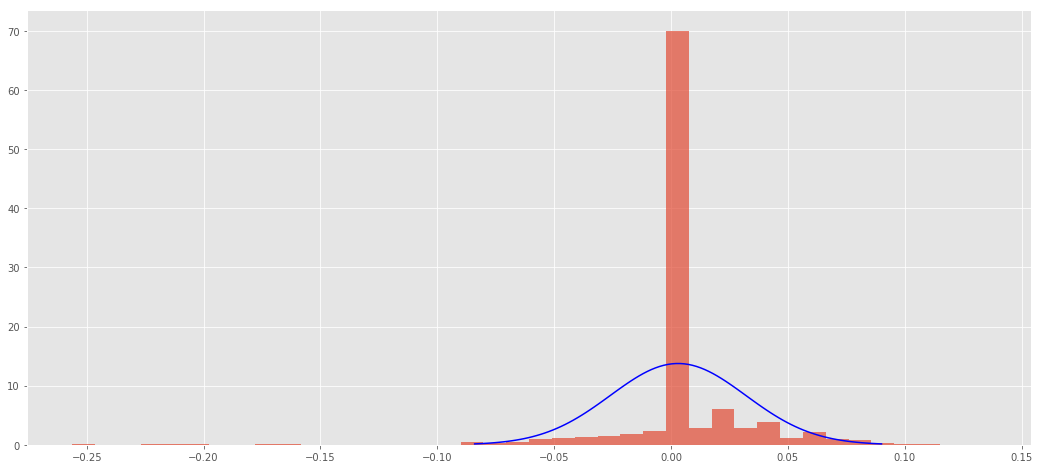

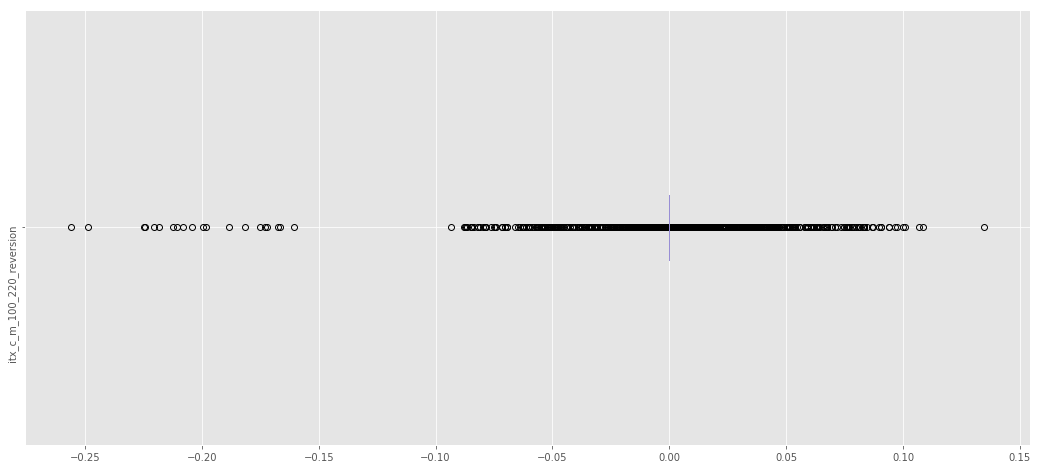

 el valor de 01p es : -0.084583 
 el valor de 05p es : -0.033713 
 el valor de 50p es : 0.0 
 el valor de 95p es : 0.05088 
 el valor de T-test es : 5.637 
 el valor de avg es : 0.003 
 el valor de kur es : 20.067 
 el valor de skw es : -2.3452 
 el valor de std es : 0.029015 
 el valor de val es : -1.5092 
 el valor de var es : 0.00084185 


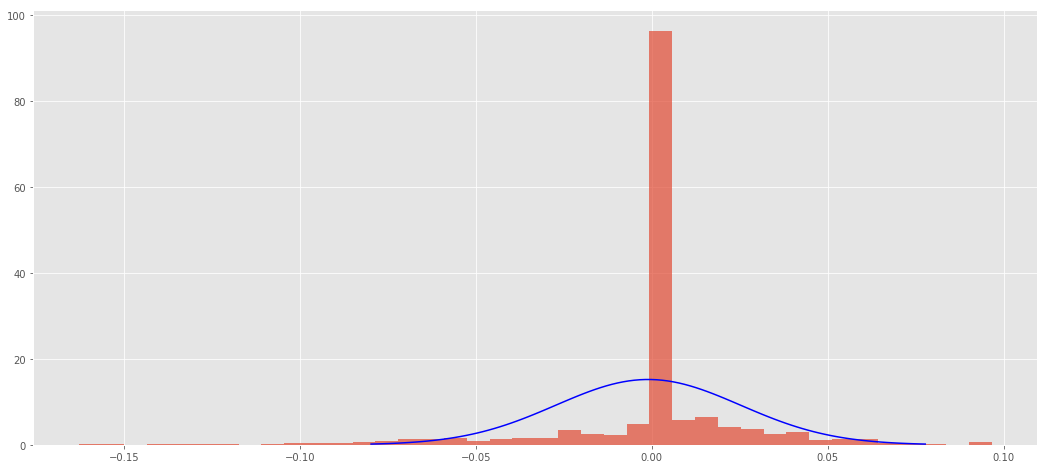

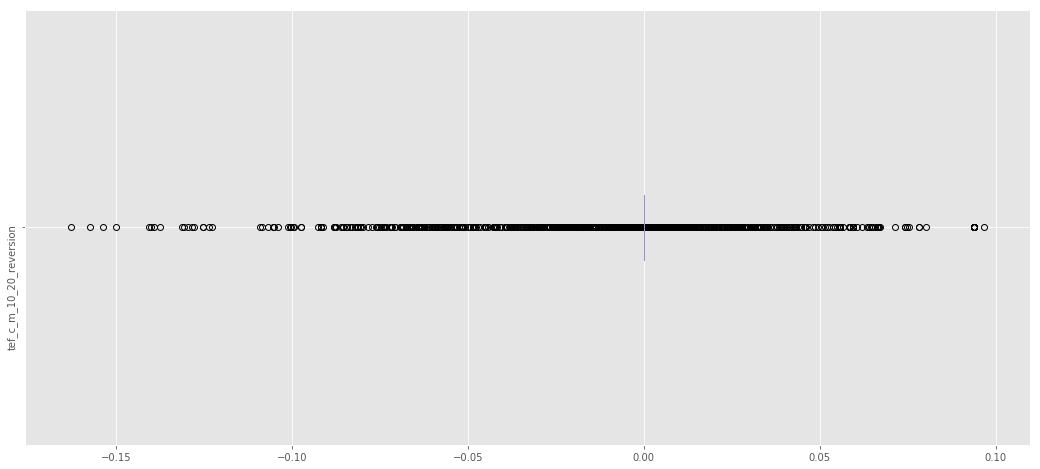

 el valor de 01p es : -0.099375 
 el valor de 05p es : -0.055809 
 el valor de 50p es : 0.0 
 el valor de 95p es : 0.039008 
 el valor de T-test es : -1.5126 
 el valor de avg es : -0.001 
 el valor de kur es : 7.1446 
 el valor de skw es : -1.3727 
 el valor de std es : 0.026252 
 el valor de val es : -0.69895 
 el valor de var es : 0.00068914 


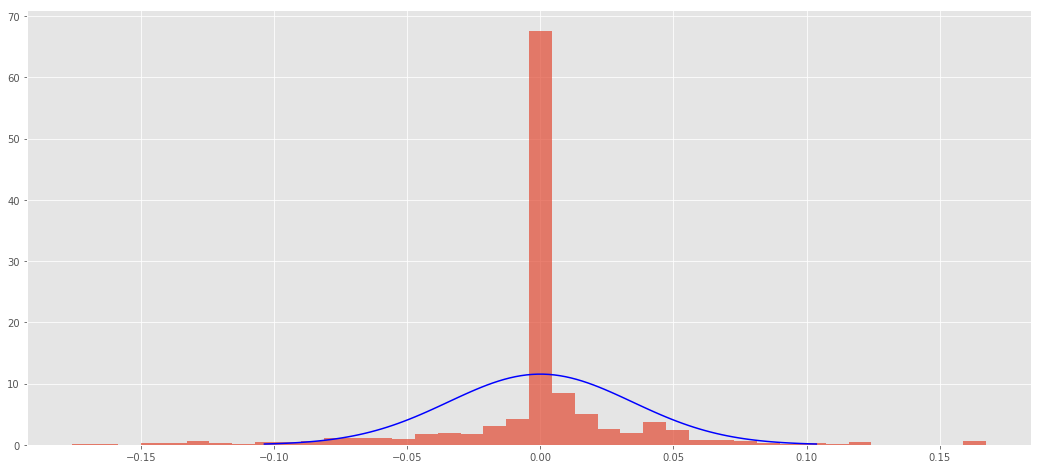

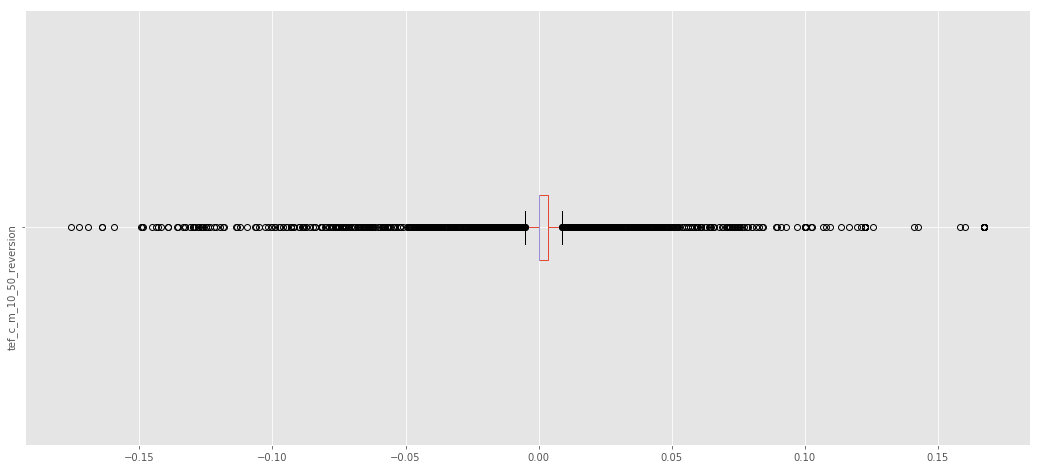

 el valor de 01p es : -0.12696 
 el valor de 05p es : -0.06276 
 el valor de 50p es : 0.0 
 el valor de 95p es : 0.048371 
 el valor de T-test es : 0.68769 
 el valor de avg es : 0.0 
 el valor de kur es : 7.2376 
 el valor de skw es : -0.31615 
 el valor de std es : 0.034553 
 el valor de val es : -0.77074 
 el valor de var es : 0.0011939 


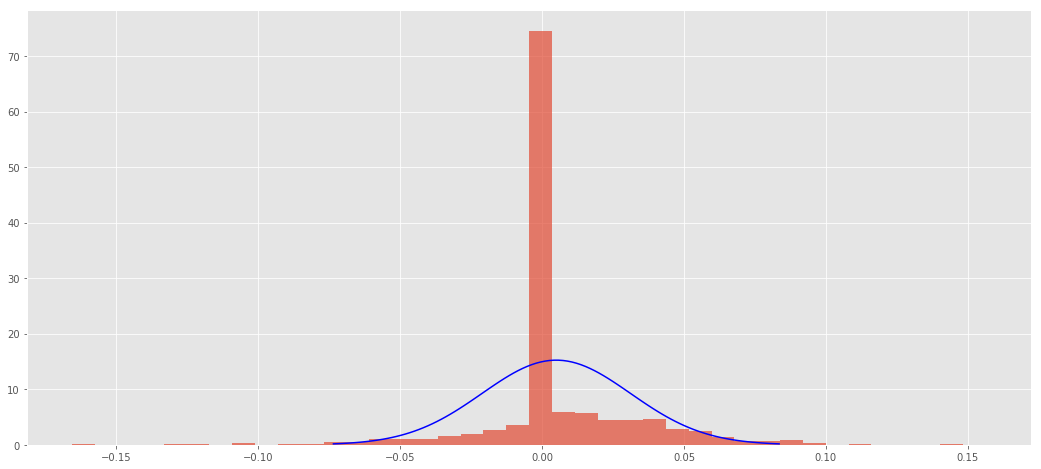

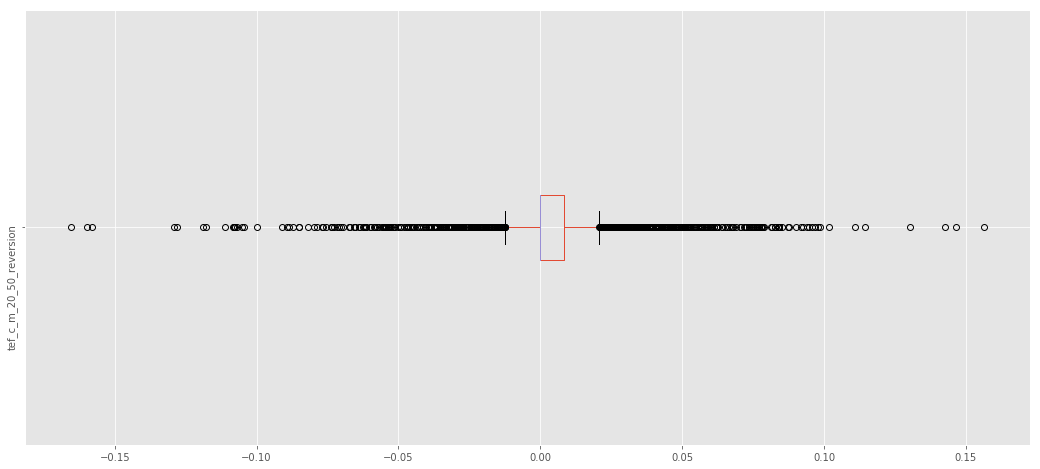

 el valor de 01p es : -0.075776 
 el valor de 05p es : -0.031176 
 el valor de 50p es : 0.0 
 el valor de 95p es : 0.052687 
 el valor de T-test es : 10.606 
 el valor de avg es : 0.005 
 el valor de kur es : 6.3786 
 el valor de skw es : -0.023186 
 el valor de std es : 0.026179 
 el valor de val es : -1.69 
 el valor de var es : 0.00068533 


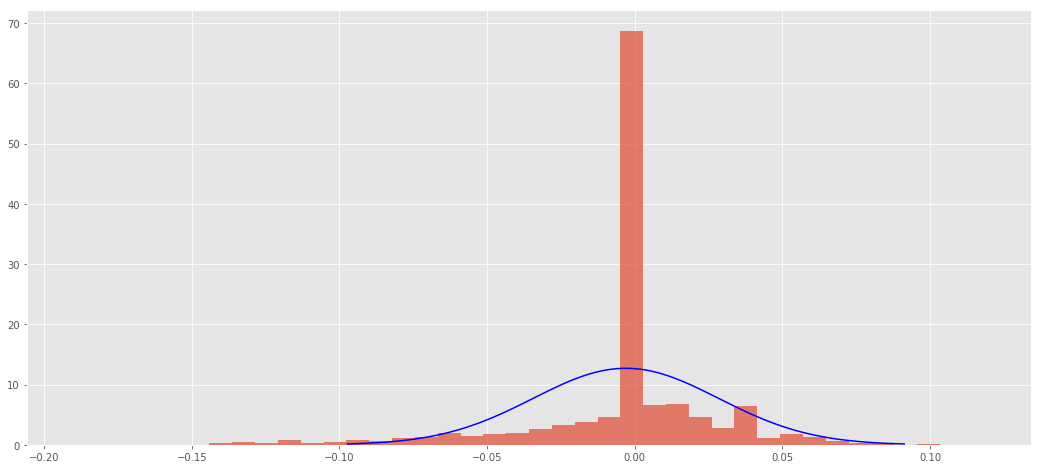

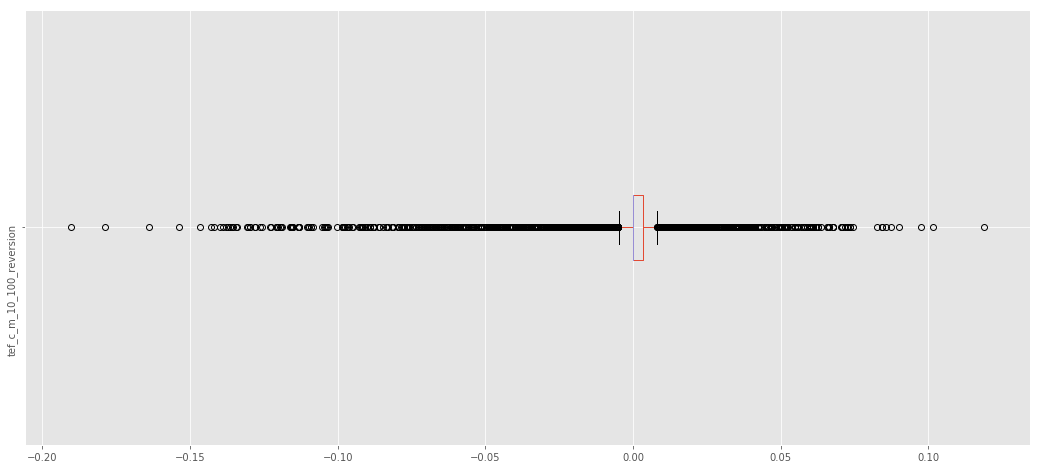

 el valor de 01p es : -0.12058 
 el valor de 05p es : -0.067769 
 el valor de 50p es : 0.0 
 el valor de 95p es : 0.040205 
 el valor de T-test es : -4.9429 
 el valor de avg es : -0.003 
 el valor de kur es : 5.0572 
 el valor de skw es : -1.4726 
 el valor de std es : 0.031419 
 el valor de val es : -0.59327 
 el valor de var es : 0.00098713 


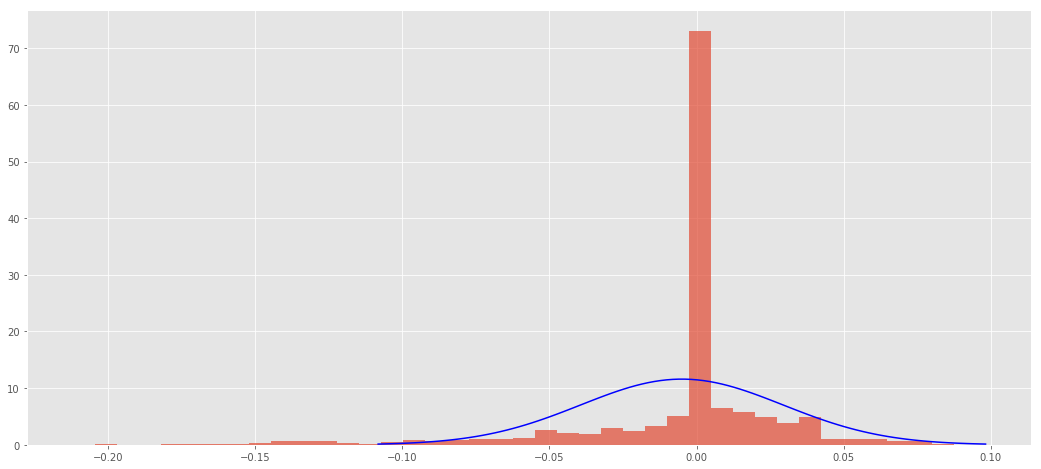

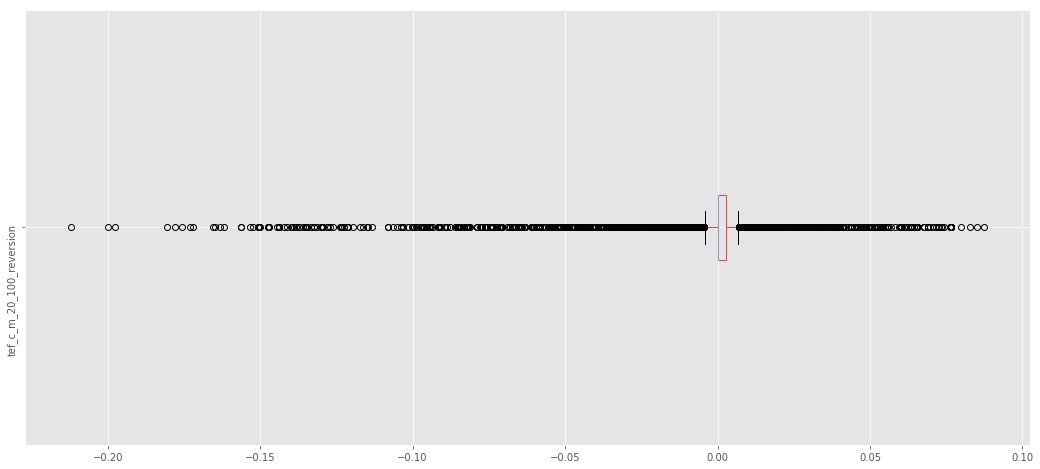

 el valor de 01p es : -0.14369 
 el valor de 05p es : -0.074652 
 el valor de 50p es : 0.0 
 el valor de 95p es : 0.038691 
 el valor de T-test es : -7.1899 
 el valor de avg es : -0.005 
 el valor de kur es : 6.6281 
 el valor de skw es : -1.9988 
 el valor de std es : 0.03441 
 el valor de val es : -0.51828 
 el valor de var es : 0.0011841 


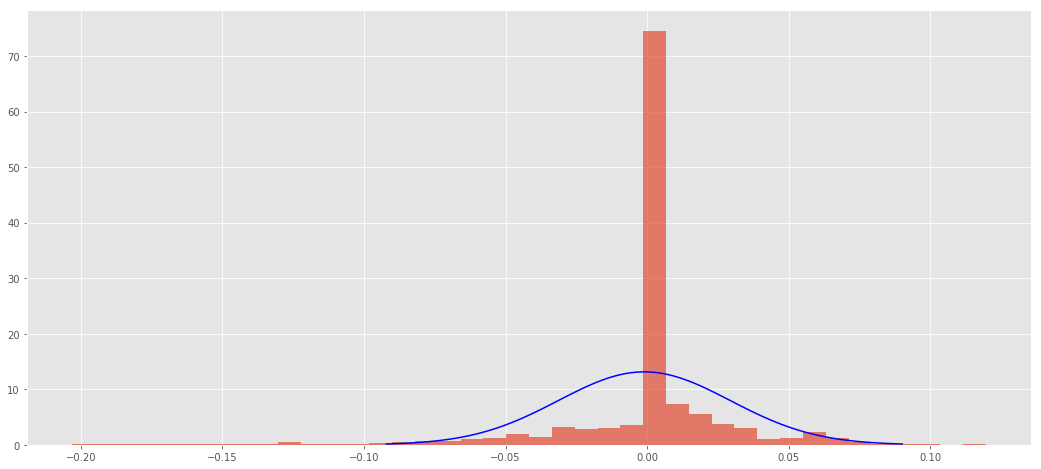

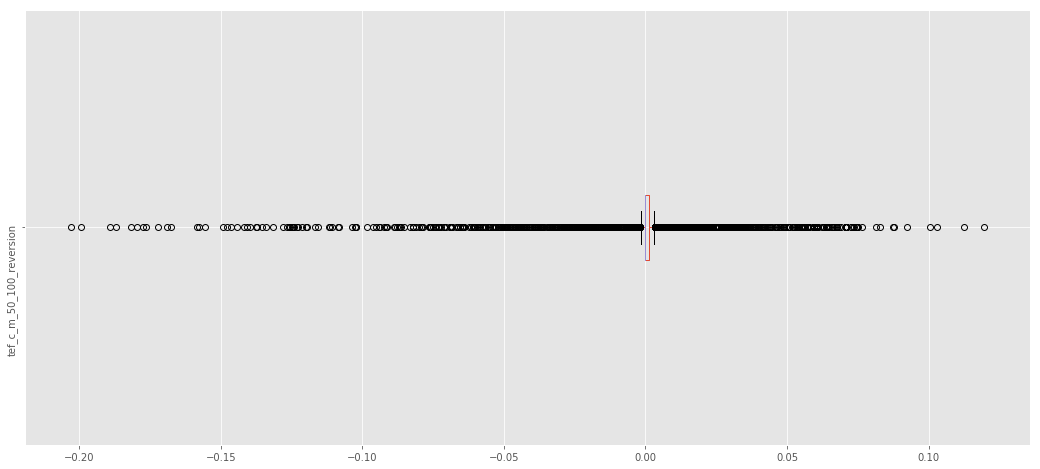

 el valor de 01p es : -0.12677 
 el valor de 05p es : -0.052138 
 el valor de 50p es : 0.0 
 el valor de 95p es : 0.042798 
 el valor de T-test es : -2.1466 
 el valor de avg es : -0.001 
 el valor de kur es : 9.5447 
 el valor de skw es : -1.8838 
 el valor de std es : 0.030369 
 el valor de val es : -0.82086 
 el valor de var es : 0.0009223 


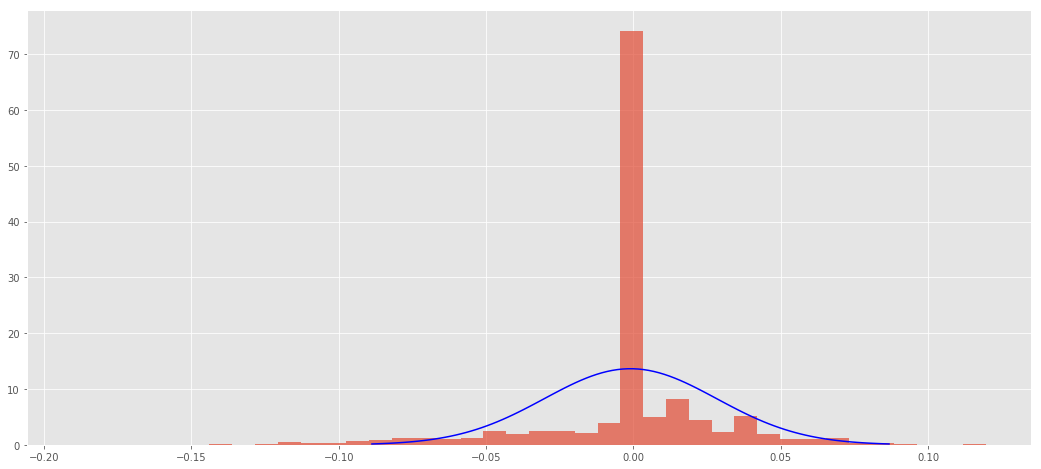

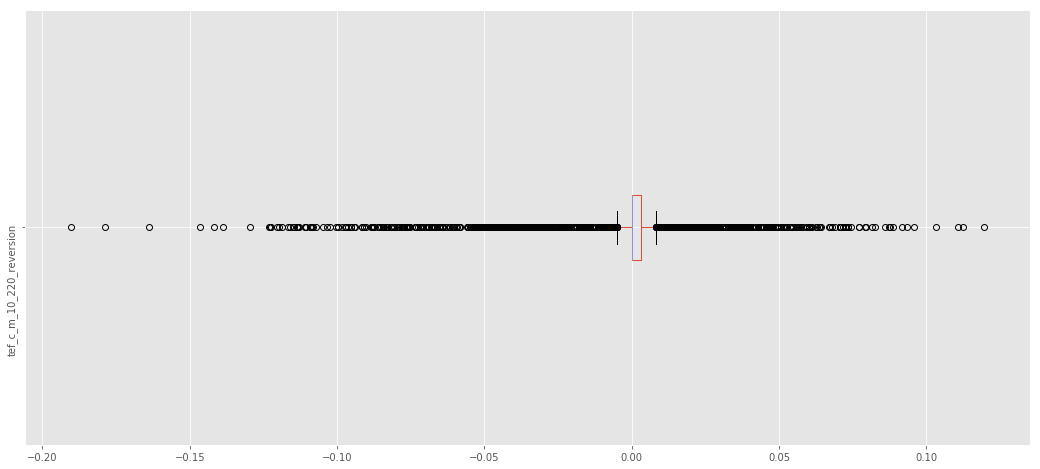

 el valor de 01p es : -0.1082 
 el valor de 05p es : -0.060487 
 el valor de 50p es : 0.0 
 el valor de 95p es : 0.041315 
 el valor de T-test es : -1.9695 
 el valor de avg es : -0.001 
 el valor de kur es : 5.3259 
 el valor de skw es : -1.1702 
 el valor de std es : 0.02925 
 el valor de val es : -0.68303 
 el valor de var es : 0.00085558 


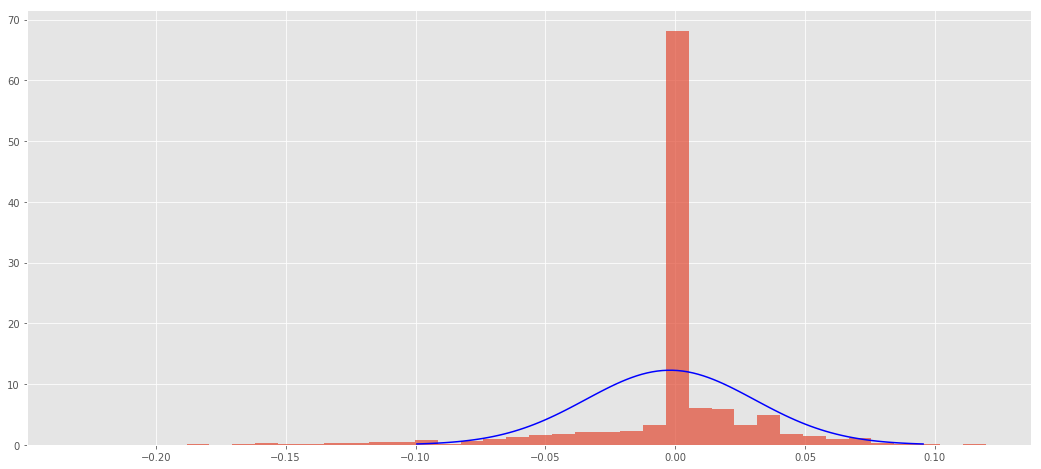

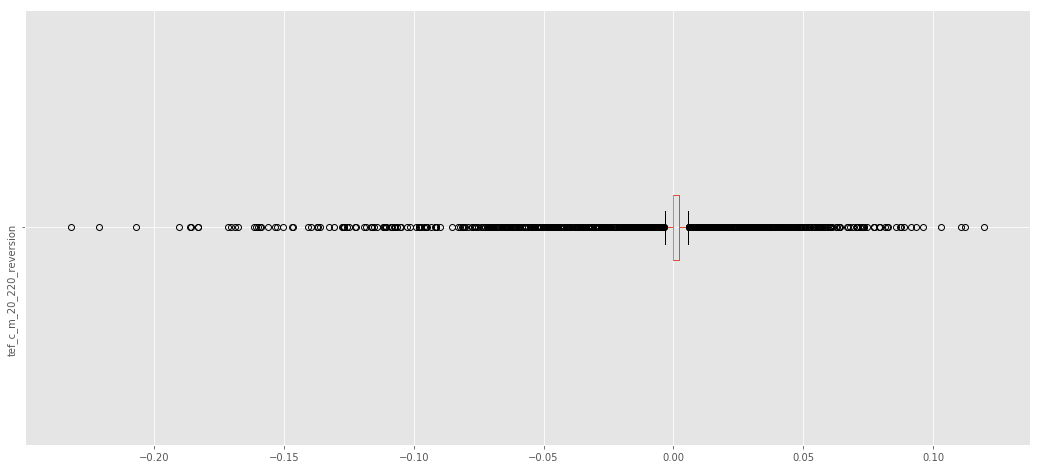

 el valor de 01p es : -0.13638 
 el valor de 05p es : -0.06081 
 el valor de 50p es : 0.0 
 el valor de 95p es : 0.041818 
 el valor de T-test es : -2.6266 
 el valor de avg es : -0.002 
 el valor de kur es : 9.0924 
 el valor de skw es : -1.9465 
 el valor de std es : 0.032491 
 el valor de val es : -0.68769 
 el valor de var es : 0.0010557 


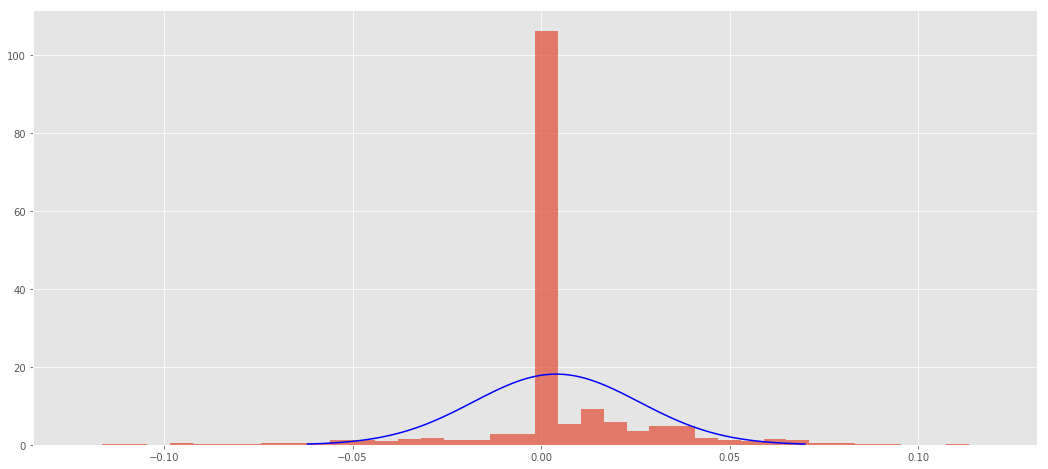

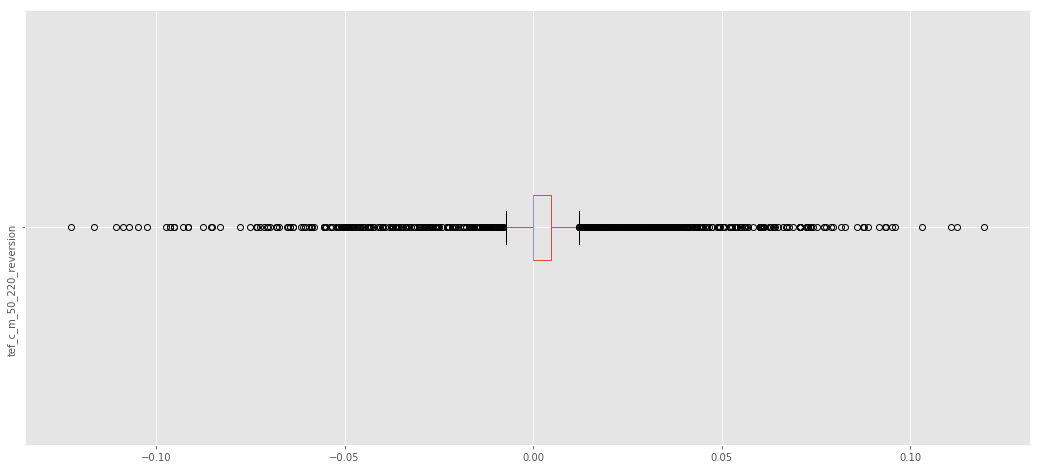

 el valor de 01p es : -0.069941 
 el valor de 05p es : -0.028939 
 el valor de 50p es : 0.0 
 el valor de 95p es : 0.04015 
 el valor de T-test es : 9.0942 
 el valor de avg es : 0.004 
 el valor de kur es : 6.4617 
 el valor de skw es : -0.12387 
 el valor de std es : 0.021989 
 el valor de val es : -1.3874 
 el valor de var es : 0.00048351 


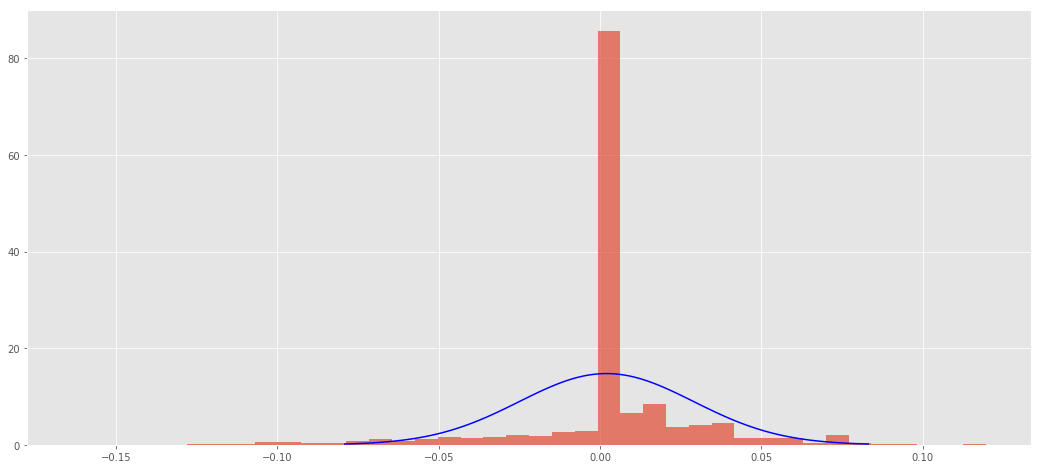

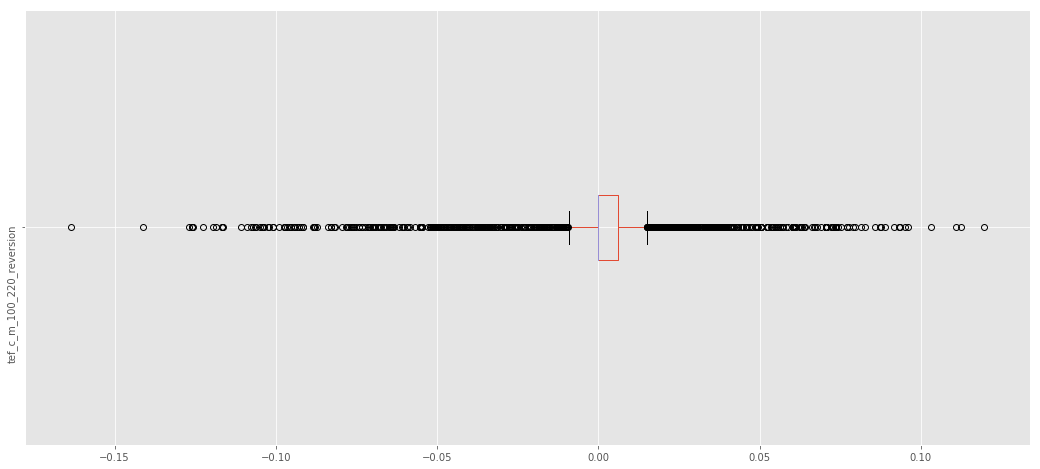

 el valor de 01p es : -0.097798 
 el valor de 05p es : -0.047737 
 el valor de 50p es : 0.0 
 el valor de 95p es : 0.042971 
 el valor de T-test es : 3.6911 
 el valor de avg es : 0.002 
 el valor de kur es : 5.652 
 el valor de skw es : -0.84553 
 el valor de std es : 0.027044 
 el valor de val es : -0.90015 
 el valor de var es : 0.00073138 


In [79]:
seleccion=f1.filter(like='_reversion',axis=1).columns.values
var95histmediasreversion={}
for n in seleccion:
    sel="{}".format(n)
    #soso.append(n)
    #printsoso
    var95histmediasreversion[sel]=calculate_aggregate(f1[sel].pct_change(20))

<h4>Tabla de resultados de los sistemas con reversión a la media</h4>

In [80]:
fofo=pd.DataFrame(var95histmediasreversion)
np.round(fofo.T,3)

01p    05p  50p    95p  T-test    avg     kur  \
san_c_m_10_20_reversion   -0.132 -0.083  0.0  0.080   4.182  0.004   3.203   
san_c_m_10_50_reversion   -0.225 -0.082  0.0  0.077   0.587  0.001  11.161   
san_c_m_20_50_reversion   -0.109 -0.061  0.0  0.080   7.369  0.006   9.949   
san_c_m_10_100_reversion  -0.142 -0.069  0.0  0.061   0.229  0.000   5.698   
san_c_m_20_100_reversion  -0.150 -0.061  0.0  0.058   1.588  0.001  15.160   
san_c_m_50_100_reversion  -0.155 -0.081  0.0  0.055  -4.728 -0.004   9.405   
san_c_m_10_220_reversion  -0.152 -0.092  0.0  0.061  -6.635 -0.006   4.053   
san_c_m_20_220_reversion  -0.128 -0.072  0.0  0.051  -2.893 -0.002   6.015   
san_c_m_50_220_reversion  -0.094 -0.056  0.0  0.060   2.689  0.002   4.185   
san_c_m_100_220_reversion -0.107 -0.069  0.0  0.055  -0.803 -0.001  14.981   
itx_c_m_10_20_reversion   -0.181 -0.092  0.0  0.054  -5.585 -0.005   6.900   
itx_c_m_10_50_reversion   -0.167 -0.067  0.0  0.064   0.554  0.000   8.515   
itx_c_m_20_50_reversion   -0.111 -0.060  0.0  0.061   0.141  0.000   5.284   
itx_c_m_10_100_reversion  -0.172 -0.036  0.0  0.055   4.424  0.003  17.444   
itx_c_m_20_100_reversion  -0.117 -0.042  0.0  0.055   3.568  0.002  27.466   
itx_c_m_50_100_reversion  -0.102 -0.044  0.0  0.048   5.099  0.003  16.018   
itx_c_m_10_220_reversion  -0.113 -0.052  0.0  0.044  -0.883 -0.001  15.085   
itx_c_m_20_220_reversion  -0.146 -0.052  0.0  0.053   1.705  0.001  13.351   
itx_c_m_50_220_reversion  -0.173 -0.050  0.0  0.048   0.284  0.000  16.732   
itx_c_m_100_220_reversion -0.085 -0.034  0.0  0.051   5.637  0.003  20.067   
tef_c_m_10_20_reversion   -0.099 -0.056  0.0  0.039  -1.513 -0.001   7.145   
tef_c_m_10_50_reversion   -0.127 -0.063  0.0  0.048   0.688  0.000   7.238   
tef_c_m_20_50_reversion   -0.076 -0.031  0.0  0.053  10.606  0.005   6.379   
tef_c_m_10_100_reversion  -0.121 -0.068  0.0  0.040  -4.943 -0.003   5.057   
tef_c_m_20_100_reversion  -0.144 -0.075  0.0  0.039  -7.190 -0.005   6.628   
tef_c_m_50_100_reversion  -0.127 -0.052  0.0  0.043  -2.147 -0.001   9.545   
tef_c_m_10_220_reversion  -0.108 -0.060  0.0  0.041  -1.970 -0.001   5.326   
tef_c_m_20_220_reversion  -0.136 -0.061  0.0  0.042  -2.627 -0.002   9.092   
tef_c_m_50_220_reversion  -0.070 -0.029  0.0  0.040   9.094  0.004   6.462   
tef_c_m_100_220_reversion -0.098 -0.048  0.0  0.043   3.691  0.002   5.652   

                             skw    std    val    var  
san_c_m_10_20_reversion   -0.112  0.046 -0.969  0.002  
san_c_m_10_50_reversion   -1.786  0.055 -0.939  0.003  
san_c_m_20_50_reversion   -0.077  0.045 -1.315  0.002  
san_c_m_10_100_reversion  -0.605  0.038 -0.879  0.001  
san_c_m_20_100_reversion  -2.480  0.037 -0.950  0.001  
san_c_m_50_100_reversion  -2.117  0.040 -0.678  0.002  
san_c_m_10_220_reversion  -0.696  0.044 -0.665  0.002  
san_c_m_20_220_reversion  -1.461  0.035 -0.716  0.001  
san_c_m_50_220_reversion  -0.147  0.032 -1.060  0.001  
san_c_m_100_220_reversion  0.984  0.037 -0.804  0.001  
itx_c_m_10_20_reversion   -1.016  0.047 -0.584  0.002  
itx_c_m_10_50_reversion   -0.909  0.042 -0.952  0.002  
itx_c_m_20_50_reversion   -0.555  0.032 -1.018  0.001  
itx_c_m_10_100_reversion  -2.359  0.036 -1.535  0.001  
itx_c_m_20_100_reversion  -3.402  0.035 -1.307  0.001  
itx_c_m_50_100_reversion  -2.350  0.031 -1.073  0.001  
itx_c_m_10_220_reversion  -2.421  0.031 -0.846  0.001  
itx_c_m_20_220_reversion  -2.079  0.034 -1.018  0.001  
itx_c_m_50_220_reversion  -2.944  0.035 -0.954  0.001  
itx_c_m_100_220_reversion -2.345  0.029 -1.509  0.001  
tef_c_m_10_20_reversion   -1.373  0.026 -0.699  0.001  
tef_c_m_10_50_reversion   -0.316  0.035 -0.771  0.001  
tef_c_m_20_50_reversion   -0.023  0.026 -1.690  0.001  
tef_c_m_10_100_reversion  -1.473  0.031 -0.593  0.001  
tef_c_m_20_100_reversion  -1.999  0.034 -0.518  0.001  
tef_c_m_50_100_reversion  -1.884  0.030 -0.821  0.001  
tef_c_m_10_220_reversion  -1.170  0.029 -0.683  0.001  
tef_c_m_20_220_reversion  -1.947  0.032 -0

In [81]:
#f.tef_c_m_20_50[0]

<h4>Gráfico del mejor sistema en reversón a la media</h4>

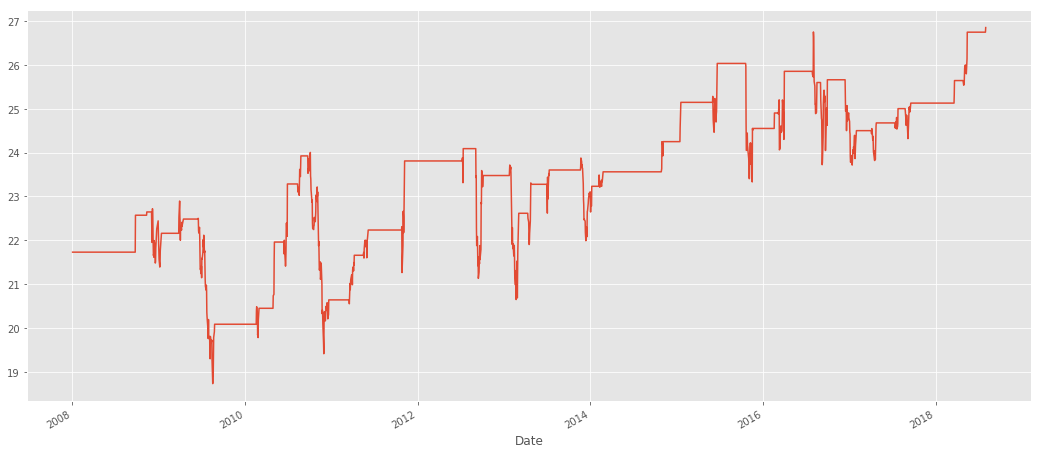

In [82]:
f1.tef_c_m_100_220_reversion.plot()

<h4>Gráfico del sistema que soporta el de reversion</h4>

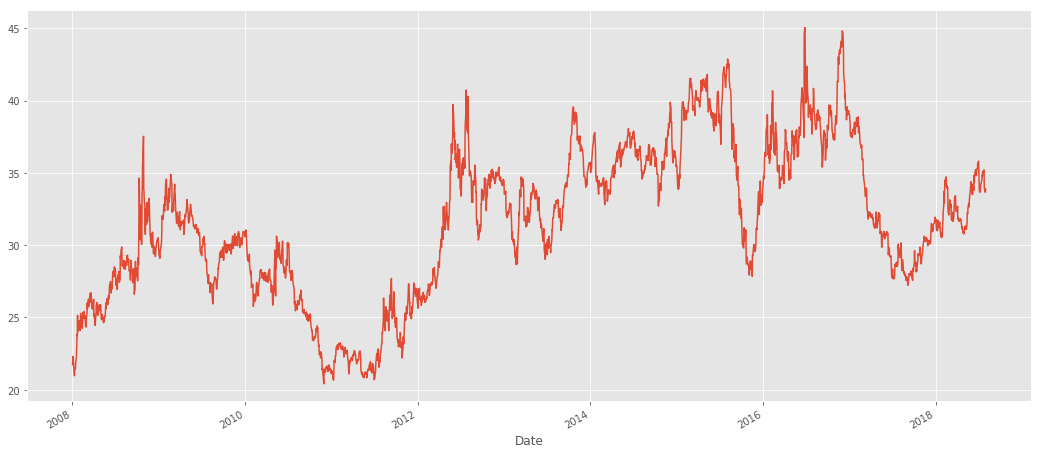

In [83]:
f.tef_c_m_100_220.plot()

In [84]:
#f.tef[0]

In [85]:
#f1.tef_c_m_20_50_reversion[0]

<h4>Tabla de rendimiento del sistema de reversión a la media semestralmente</h4>

In [86]:
f1.tef_c_m_20_50_reversion.resample('2Q').last()

Date
2008-03-31    21.731100
2008-09-30    22.639762
2009-03-31    24.376070
2009-09-30    24.430206
2010-03-31    25.749107
2010-09-30    29.981959
2011-03-31    28.382516
2011-09-30    29.263944
2012-03-31    27.651721
2012-09-30    29.927613
2013-03-31    31.634094
2013-09-30    33.346779
2014-03-31    34.873574
2014-09-30    38.203779
2015-03-31    39.688994
2015-09-30    38.822357
2016-03-31    39.654052
2016-09-30    41.719423
2017-03-31    40.961527
2017-09-30    42.587515
2018-03-31    41.033345
2018-09-30    42.267470
Name: tef_c_m_20_50_reversion, dtype: float64

<h4>tabla del sistema en datos semestrales</h4>

In [87]:
f.tef_c_m_20_50.resample('2Q').last()

Date
2008-03-31    26.244489
2008-09-30    26.899049
2009-03-31    18.810429
2009-09-30    21.636882
2010-03-31    21.626770
2010-09-30    23.878843
2011-03-31    18.451075
2011-09-30    19.530738
2012-03-31    17.672698
2012-09-30    18.314266
2013-03-31    14.511898
2013-09-30    14.365617
2014-03-31    12.710017
2014-09-30    13.682016
2015-03-31     8.450795
2015-09-30     7.821412
2016-03-31     7.048819
2016-09-30     8.440569
2017-03-31     9.668824
2017-09-30     9.725834
2018-03-31    10.776598
2018-09-30    10.073762
Name: tef_c_m_20_50, dtype: float64

<p>Está claro que el comportamiento del sistema no tiene nada que ver con el comportamiento del sistema en reversión.
    <p>Es decir se adapta a la mejor serie para cada sistema

# reversion a la media

In [88]:
#sistema reversion

In [89]:
#crear sistema menor que el 10%
def reversion_media2(values,tanto=-.05,tanto2=0,tanto3=-.1):
    import talib as ta
    df=pd.DataFrame()
    #print type(values)
    df['base']=values.copy()
    #print df.base.tail()
    df['logvalues']=np.log(df.base / df.base.shift(1))
    df['pctvalues']=df['base'].pct_change(20)
    df['senal']=np.where((df.pctvalues>tanto)&(df.pctvalues.shift()<tanto),1,np.nan)
#     df['senal']=np.where((df.pctvalues>tanto)&(df.pctvalues.shift()<tanto),1,df['senal'])

    df['senal']=np.where((df.pctvalues>tanto2)&(df.pctvalues.shift()<tanto2),0,df['senal'])
    df['senal']=np.where((df.pctvalues.shift()<tanto3),0,df['senal'])
    
    df['senal'].ffill(inplace=True)
    df['senal']=df['senal'].fillna(0)
    #.senal.plot(secondary_y=True)
    #print df.logvalues
    df['rendimiento']=df.senal.shift()*df.logvalues
    df['rendimiento']=df['rendimiento'].fillna(0)
    df['rendimiento'][0]=np.log(df['base'][0])
    df['serie']=np.exp(df.rendimiento.cumsum())
    
    return df.serie

In [90]:
seleccion=f.filter(like='_c_m',axis=1).columns.values
var95histmedias10={}
y=pd.DataFrame(index=f.index)
tanto=-.06
for n in seleccion:
      y['{}_reversion2'.format(n,tanto)]=reversion_media2(f['{}'.format(n)],tanto,tanto3=-.15)


In [91]:
y.tail()

san_c_m_10_20_reversion2  san_c_m_10_50_reversion2  \
Date                                                             
2018-07-26                  5.880674                  5.267322   
2018-07-27                  5.880674                  5.267322   
2018-07-30                  5.880674                  5.267322   
2018-07-31                  5.880674                  5.267322   
2018-08-01                  5.880674                  5.267322   

            san_c_m_20_50_reversion2  san_c_m_10_100_reversion2  \
Date                                                              
2018-07-26                 10.931645                   4.519325   
2018-07-27                 10.931645                   4.519325   
2018-07-30                 10.931645                   4.519325   
2018-07-31                 10.931645                   4.519325   
2018-08-01                 10.931645                   4.519325   

            san_c_m_20_100_reversion2  san_c_m_50_100_reversion2  \
Date                                                               
2018-07-26                   5.768144                   3.216241   
2018-07-27                   5.768144                   3.216241   
2018-07-30                   5.768144                   3.216241   
2018-07-31                   5.768144                   3.216241   
2018-08-01                   5.768144                   3.216241   

            san_c_m_10_220_reversion2  san_c_m_20_220_reversion2  \
Date                                                               
2018-07-26                   2.022979                   4.121112   
2018-07-27                   2.022979                   4.121112   
2018-07-30                   2.022979                   4.121112   
2018-07-31                   2.022979                   4.121112   
2018-08-01                   2.022979                   4.121112   

            san_c_m_50_220_reversion2  san_c_m_100_220_reversion2  \
Date                                                                
2018-07-26                   5.821648                    3.596294   
2018-07-27                   5.821648                    3.596294   
2018-07-30                   5.821648                    3.596294   
2018-07-31                   5.821648                    3.596294   
2018-08-01                   5.821648                    3.596294   

                       ...              tef_c_m_10_20_reversion2  \
Date                   ...                                         
2018-07-26             ...                             17.701827   
2018-07-27             ...                             17.701827   
2018-07-30             ...                             17.701827   
2018-07-31             ...                             17.701827   
2018-08-01             ...                             17.701827   

            tef_c_m_10_50_reversion2  tef_c_m_20_50_reversion2  \
Date                                                             
2018-07-26                 19.133585                 38.558207   
2018-07-27                 19.133585                 38.558207   
2018-07-30                 19.133585                 38.558207   
2018-07-31                 19.133585                 38.558207   
2018-08-01                 19.208511                 38.407804   

            tef_c_m_10_100_reversion2  tef_c_m_20_100_reversion2  \
Date                                                               
2018-07-26                  13.210141                  11.284774   
2018-07-27                  13.210141                  11.284774   
2018-07-30                  13.210141                  11.284774   
2018-07-31                  13.210141                  11.284774   
2018-08-01                  13.261871                  11.328965   

            tef_c_m_50_100_reversion2  tef_c_m_10_220_reversion2  \
Date                                                               
2018-07-26                  16.536958                  17.373781   
2018-07-27          

In [92]:
ccoco=f.filter(like='_c_',axis=1).columns.values
var95histmediasreversion2={}
for n in y:
    soso="{}".format(n)
    #soso.append(n)
    print ('\n\n-> {} : \n'.format(soso))
    var95histmediasreversion2[soso]=calculate_aggregate(y[soso].pct_change(20),False,False)



-> san_c_m_10_20_reversion2 : 

 el valor de 01p es : -0.13123 
 el valor de 05p es : -0.079091 
 el valor de 50p es : 0.0 
 el valor de 95p es : 0.066824 
 el valor de T-test es : 1.4006 
 el valor de avg es : 0.001 
 el valor de kur es : 3.1657 
 el valor de skw es : -0.60657 
 el valor de std es : 0.04184 
 el valor de val es : -0.8449 
 el valor de var es : 0.0017506 


-> san_c_m_10_50_reversion2 : 

 el valor de 01p es : -0.1555 
 el valor de 05p es : -0.078951 
 el valor de 50p es : 0.0 
 el valor de 95p es : 0.067234 
 el valor de T-test es : 0.60795 
 el valor de avg es : 0.001 
 el valor de kur es : 5.3507 
 el valor de skw es : -0.98087 
 el valor de std es : 0.042865 
 el valor de val es : -0.85159 
 el valor de var es : 0.0018374 


-> san_c_m_20_50_reversion2 : 

 el valor de 01p es : -0.10541 
 el valor de 05p es : -0.057589 
 el valor de 50p es : 0.0 
 el valor de 95p es : 0.075659 
 el valor de T-test es : 8.0117 
 el valor de avg es : 0.006 
 el valor de kur es : 5.

 el valor de 01p es : -0.070417 
 el valor de 05p es : -0.028939 
 el valor de 50p es : 0.0 
 el valor de 95p es : 0.039678 
 el valor de T-test es : 8.6789 
 el valor de avg es : 0.004 
 el valor de kur es : 6.4613 
 el valor de skw es : -0.18943 
 el valor de std es : 0.022148 
 el valor de val es : -1.3711 
 el valor de var es : 0.00049052 


-> tef_c_m_100_220_reversion2 : 

 el valor de 01p es : -0.097798 
 el valor de 05p es : -0.0487 
 el valor de 50p es : 0.0 
 el valor de 95p es : 0.042971 
 el valor de T-test es : 3.3889 
 el valor de avg es : 0.002 
 el valor de kur es : 5.6732 
 el valor de skw es : -0.87514 
 el valor de std es : 0.027174 
 el valor de val es : -0.88235 
 el valor de var es : 0.00073844 


In [93]:
fofo=pd.DataFrame(var95histmediasreversion2)
np.round(fofo.T,3)

01p    05p  50p    95p  T-test    avg     kur  \
san_c_m_10_20_reversion2   -0.131 -0.079  0.0  0.067   1.401  0.001   3.166   
san_c_m_10_50_reversion2   -0.155 -0.079  0.0  0.067   0.608  0.001   5.351   
san_c_m_20_50_reversion2   -0.105 -0.058  0.0  0.076   8.012  0.006   5.335   
san_c_m_10_100_reversion2  -0.106 -0.069  0.0  0.053  -1.615 -0.001   3.291   
san_c_m_20_100_reversion2  -0.141 -0.062  0.0  0.055   1.258  0.001   7.058   
san_c_m_50_100_reversion2  -0.156 -0.079  0.0  0.051  -4.866 -0.003   5.744   
san_c_m_10_220_reversion2  -0.142 -0.088  0.0  0.055  -8.366 -0.007   3.672   
san_c_m_20_220_reversion2  -0.104 -0.068  0.0  0.048  -2.867 -0.002   4.619   
san_c_m_50_220_reversion2  -0.095 -0.059  0.0  0.059   1.324  0.001   4.632   
san_c_m_100_220_reversion2 -0.106 -0.071  0.0  0.050  -4.357 -0.003   4.074   
itx_c_m_10_20_reversion2   -0.153 -0.084  0.0  0.049  -5.697 -0.005   5.888   
itx_c_m_10_50_reversion2   -0.105 -0.061  0.0  0.061   1.940  0.001   5.459   
itx_c_m_20_50_reversion2   -0.111 -0.056  0.0  0.061  -0.487 -0.000   7.151   
itx_c_m_10_100_reversion2  -0.114 -0.030  0.0  0.052   6.522  0.004  11.217   
itx_c_m_20_100_reversion2  -0.125 -0.044  0.0  0.055   4.284  0.003  10.444   
itx_c_m_50_100_reversion2  -0.123 -0.049  0.0  0.048   3.570  0.002  10.061   
itx_c_m_10_220_reversion2  -0.125 -0.052  0.0  0.044  -1.091 -0.001   9.654   
itx_c_m_20_220_reversion2  -0.115 -0.049  0.0  0.051   2.770  0.002   9.679   
itx_c_m_50_220_reversion2  -0.173 -0.049  0.0  0.046   0.128  0.000  14.532   
itx_c_m_100_220_reversion2 -0.085 -0.032  0.0  0.051   6.703  0.003  13.111   
tef_c_m_10_20_reversion2   -0.099 -0.056  0.0  0.039  -2.249 -0.001   7.105   
tef_c_m_10_50_reversion2   -0.136 -0.065  0.0  0.048  -0.472 -0.000   8.000   
tef_c_m_20_50_reversion2   -0.079 -0.033  0.0  0.051   9.467  0.005   5.463   
tef_c_m_10_100_reversion2  -0.120 -0.068  0.0  0.040  -5.284 -0.003   5.041   
tef_c_m_20_100_reversion2  -0.126 -0.074  0.0  0.039  -7.041 -0.004   4.809   
tef_c_m_50_100_reversion2  -0.124 -0.060  0.0  0.039  -2.612 -0.002   8.480   
tef_c_m_10_220_reversion2  -0.105 -0.061  0.0  0.041  -2.202 -0.001   5.395   
tef_c_m_20_220_reversion2  -0.122 -0.056  0.0  0.039  -1.382 -0.001   6.730   
tef_c_m_50_220_reversion2  -0.070 -0.029  0.0  0.040   8.679  0.004   6.461   
tef_c_m_100_220_reversion2 -0.098 -0.049  0.0  0.043   3.389  0.002   5.673   

                              skw    std    val    var  
san_c_m_10_20_reversion2   -0.607  0.042 -0.845  0.002  
san_c_m_10_50_reversion2   -0.981  0.043 -0.852  0.002  
san_c_m_20_50_reversion2    0.345  0.037 -1.314  0.001  
san_c_m_10_100_reversion2  -0.765  0.033 -0.766  0.001  
san_c_m_20_100_reversion2  -1.530  0.034 -0.890  0.001  
san_c_m_50_100_reversion2  -1.635  0.037 -0.647  0.001  
san_c_m_10_220_reversion2  -0.962  0.041 -0.620  0.002  
san_c_m_20_220_reversion2  -1.126  0.032 -0.711  0.001  
san_c_m_50_220_reversion2  -0.363  0.032 -1.010  0.001  
san_c_m_100_220_reversion2 -0.926  0.033 -0.702  0.001  
itx_c_m_10_20_reversion2   -0.660  0.041 -0.580  0.002  
itx_c_m_10_50_reversion2    0.096  0.035 -0.993  0.001  
itx_c_m_20_50_reversion2   -0.906  0.033 -1.090  0.001  
itx_c_m_10_100_reversion2  -1.394  0.030 -1.723  0.001  
itx_c_m_20_100_reversion2  -1.501  0.031 -1.243  0.001  
itx_c_m_50_100_reversion2  -1.834  0.031 -0.976  0.001  
itx_c_m_10_220_reversion2  -1.868  0.030 -0.854  0.001  
itx_c_m_20_220_reversion2  -1.485  0.030 -1.045  0.001  
itx_c_m_50_220_reversion2  -2.694  0.033 -0.945  0.001  
itx_c_m_100_220_reversion2 -1.468  0.027 -1.613  0.001  
tef_c_m_10_20_reversion2   -1.478  0.027 -0.697  0.001  
tef_c_m_10_50_reversion2   -0.653  0.035 -0.744  0.001  
tef_c_m_20_50_reversion2   -0.210  0.025 -1.540  0.001  
tef_c_m_10_100_reversion2  -1.511  0.031 -0.586  0.001  
tef_c_m_20_100_reversion2  -1.616  0.032 -0.521  0.001  
tef_c_m_50_100_reversion2  -1.744  0.030 -0.651  0.001  
tef_c_m_10_220_reversion2  -1.205  0.029 

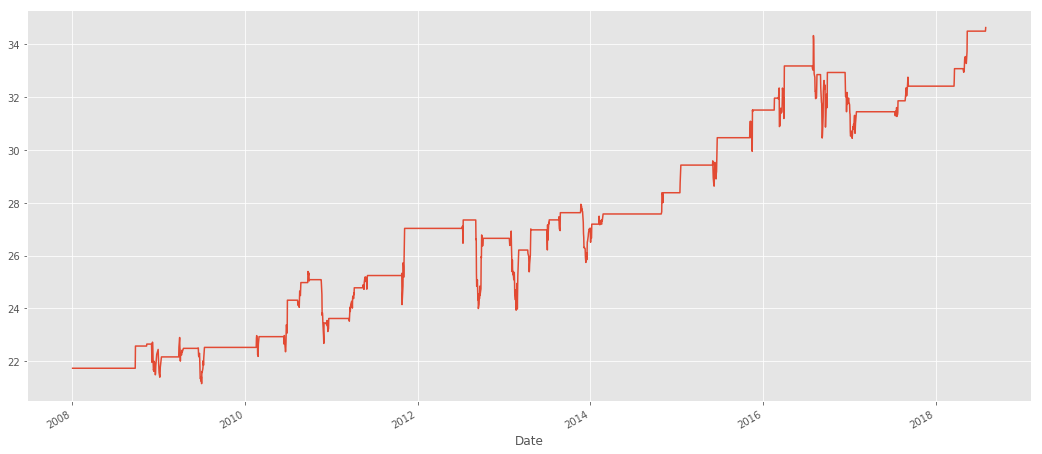

In [94]:
y.tef_c_m_50_220_reversion2.plot()

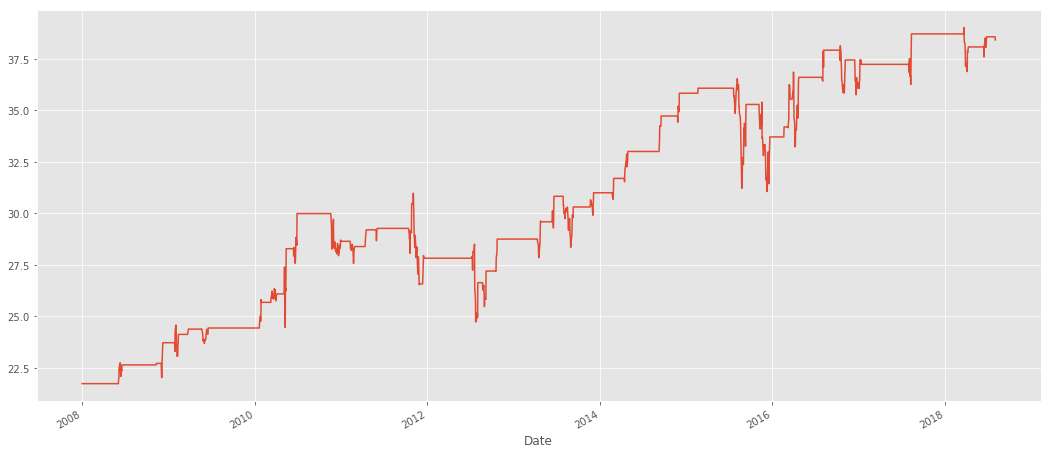

In [95]:
y.tef_c_m_20_50_reversion2.plot()